In [1]:
%load_ext pycodestyle_magic
%flake8_on
%load_ext autoreload

In [2]:
%autoreload 2

In [45]:
"""Python code to classify X-ray sources by color.

Functionalities needed.

1. Line, step, scatter and histogram and kde plots
2. Plot net counts, bg/net and S/N ratio
3. Process detectors seperately and combine colors only optional
4. Cross-match 4XMM and CSC sources.
5. Compare with Haley et al. sources.
"""


import copy
import os
import glob2
import warnings
import xspec
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from scipy.ndimage import median_filter


# Plot functions
def set_plotparams(plottype):
    """Set plot parameters."""
    if plottype == 'notebook':
        plt.rcParams["figure.figsize"] = (20, 15)
        plt.rcParams["axes.titlesize"] = 24
        plt.rcParams["axes.labelsize"] = 24
        plt.rcParams["lines.linewidth"] = 3
        plt.rcParams["lines.markersize"] = 10
        plt.rcParams["xtick.labelsize"] = 20
        plt.rcParams["ytick.labelsize"] = 20
        plt.rcParams["legend.fontsize"] = 20
        plt.rcParams['xtick.major.size'] = 16
        plt.rcParams['xtick.minor.size'] = 8
        plt.rcParams['ytick.major.size'] = 16
        plt.rcParams['ytick.minor.size'] = 8
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'inout'
        plt.rcParams['ytick.direction'] = 'inout'
    elif plottype == 'presentation':
        plt.rcParams["figure.figsize"] = (4, 3)
        plt.rcParams["axes.titlesize"] = 16
        plt.rcParams["axes.labelsize"] = 14
        plt.rcParams["lines.linewidth"] = 3
        plt.rcParams["lines.markersize"] = 5
        plt.rcParams["xtick.labelsize"] = 12
        plt.rcParams["ytick.labelsize"] = 12
        plt.rcParams["legend.fontsize"] = 12
        plt.rcParams['xtick.major.size'] = 8
        plt.rcParams['xtick.minor.size'] = 4
        plt.rcParams['ytick.major.size'] = 8
        plt.rcParams['ytick.minor.size'] = 4
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'inout'
        plt.rcParams['ytick.direction'] = 'inout'
    elif plottype == 'paper1':
        plt.rcParams["figure.figsize"] = (4, 3)
        plt.rcParams["axes.titlesize"] = 14
        plt.rcParams["axes.labelsize"] = 12
        plt.rcParams["lines.linewidth"] = 2
        plt.rcParams["lines.markersize"] = 2
        plt.rcParams["xtick.labelsize"] = 10
        plt.rcParams["ytick.labelsize"] = 10
        plt.rcParams["legend.fontsize"] = 10
        plt.rcParams['xtick.major.size'] = 6
        plt.rcParams['xtick.minor.size'] = 3
        plt.rcParams['ytick.major.size'] = 6
        plt.rcParams['ytick.minor.size'] = 3
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'
    elif plottype == 'paper2':
        plt.rcParams["figure.figsize"] = (8, 6)
        plt.rcParams["axes.titlesize"] = 20
        plt.rcParams["axes.labelsize"] = 12
        plt.rcParams["lines.linewidth"] = 2
        plt.rcParams["lines.markersize"] = 2
        plt.rcParams["xtick.labelsize"] = 10
        plt.rcParams["ytick.labelsize"] = 10
        plt.rcParams["legend.fontsize"] = 10
        plt.rcParams['xtick.major.size'] = 6
        plt.rcParams['xtick.minor.size'] = 3
        plt.rcParams['ytick.major.size'] = 6
        plt.rcParams['ytick.minor.size'] = 3
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'


def plotline_scatter(xdatas, ydatas, pl_types=None, axs=None, xlabel=None,
                     ylabel=None, pl_labels=None, styles=None, colors=None,
                     yscale='linear', title=None, ylim=None, figsize=None):
    """Plot line, step and scatter plots."""
    if pl_types is None:
        pl_types = ['line']*len(ydatas)
    if axs is None:
        fig, axs = plt.subplots(figsize=figsize)
    if pl_labels is None:
        pl_labels = [None]*len(ydatas)
    if styles is None:
        styles = ['-']*len(ydatas)
    if colors is None:
        if len(ydatas) <= 4:
            colors = ['#004488', '#ddaa33', '#bb5566', '#000000']
        elif len(ydatas) <= 9:
            colors = ['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      'b57de9', 'ff9468', '9cee81', '00d2ff']
        else:
            warnings.warn('Too many plot elements. Colors will be repeated.')
            colors = (['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      '#b57de9', '#ff9468', '#9cee81', '#00d2ff'] *
                      (int(len(ydatas/9)+1)))

    axs.set_title(title)
    if ylim is not None:
        axs.set_ylim(ylim[0], ylim[1])
    axs.set_xlabel(xlabel)
    axs.set_xscale('log')
    axs.set_yscale(yscale)
    axs.set_ylabel(ylabel)
    for i, pl_type in enumerate(pl_types):
        if pl_type == 'line':
            axs.plot(xdatas[i], ydatas[i], linestyle=styles[i],
                     label=pl_labels[i], color=colors[i])
        elif pl_type == 'scatter':
            if styles[i] == '-':
                styles[i] = 'o'
            axs.scatter(xdatas[i], ydatas[i], marker=styles[i],
                        label=pl_labels[i], color=colors[i])
        elif pl_type == 'step':
            ydatas[i] = np.append(ydatas[i], ydatas[i].copy()[-1])
            axs.step(xdatas[i], ydatas[i], where='post', linestyle=styles[i],
                     label=pl_labels[i], color=colors[i])
        else:
            raise ValueError("pl_type can only be 'line' or 'scatter'. Got " +
                             pl_type)
    axs.legend()
    return axs


def plothist(data_arr, data2=None, axs=None, bins=None, xlabel=None,
             ylabel=None, pl_labels=None, pl_type=None, cbar_label=None,
             colors=None):
    """Plot 1D and 2D histograms."""
    if axs is None:
        fig, axs = plt.subplots()
    if pl_type is None:
        pl_type = 'withoutkde'
    if pl_labels is None and isinstance(data_arr[0], (list, np.ndarray)):
        pl_labels = [None]*len(data_arr)
    if colors is None:
        if len(data_arr) <= 4:
            colors = ['#004488', '#ddaa33', '#bb5566', '#000000']
        elif len(data_arr) <= 9:
            colors = ['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      'b57de9', 'ff9468', '9cee81', '00d2ff']
        else:
            warnings.warn('Too many plot elements. Colors will be repeated.')
            colors = (['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      '#b57de9', '#ff9468', '#9cee81', '#00d2ff'] *
                      (int(len(data_arr/9)+1)))
    if colors is None and data2 is not None:
        colors = 'plasma_r'
    axs.set_xlabel(xlabel)
    if data2 is None:
        if pl_type == 'withkde':
            if ylabel is None:
                ylabel = 'Density per bin'
            axs.set_ylabel(ylabel)
            axs.hist(data_arr, bins=bins, density=True, label=pl_labels,
                     color=colors[:len(data_arr)])[:-1]
            if not isinstance(data_arr[0], (list, np.ndarray)):
                data_arr = [data_arr]
            for i, data in enumerate(data_arr):
                if pl_labels[i] is not None:
                    sns.kdeplot(x=data, label=pl_labels[i]+'_kde', ax=axs,
                                color=colors[i])
                else:
                    sns.kdeplot(x=data, ax=axs)
            axs.legend()
        else:
            if ylabel is None:
                ylabel = '# per bin'
            axs.set_ylabel(ylabel)
            axs.hist(data_arr, bins=bins, label=pl_labels,
                     color=colors[:len(data_arr)])[:-1]
            axs.legend()
    else:
        # 2D hist
        axs.set_ylabel(ylabel)
        if bins is None:
            bins = 10
        if pl_type == 'withkde':
            histplot = axs.hist2d(data_arr, data2, bins=bins, density=True,
                                  cmap=colors)[-1]
            sns.kdeplot(x=data_arr, y=data2, ax=axs)
            cbar = plt.colorbar(mappable=histplot, ax=axs, color='k')
            if cbar_label is None:
                cbar_label = 'Density per bin'
            cbar.set_label(cbar_label)
        else:
            histplot = axs.hist2d(data_arr, data2)[-1]
            cbar = plt.colorbar(mappable=histplot, ax=axs)
            if cbar_label is None:
                cbar_label = '# per bin'
            cbar.set_label(cbar_label)
    return axs


def plot_subplots(numrows, numcols, xdatas_arr, ydatas_arr, title=None,
                  subp_types_arr=None, pl_types_arr=None, xlabel_arr=None,
                  ylabel_arr=None, pl_labels_arr=None, styles_arr=None,
                  bins_arr=None, cbar_labels=None, yscale_arr=None,
                  ylim_arr=None, colors_arr=None):
    """Plot subplots"""
    if subp_types_arr is None:
        subp_types_arr = [['linescatter']*numcols]*numrows
    if pl_types_arr is None:
        pl_types_arr = [[None]*numcols]*numrows
    if pl_labels_arr is None:
        pl_labels_arr = [[None]*numcols]*numrows
    if xlabel_arr is None:
        xlabel_arr = [[None]*numcols]*numrows
    if ylabel_arr is None:
        ylabel_arr = [[None]*numcols]*numrows
    if styles_arr is None:
        styles_arr = [[None]*numcols]*numrows
    if bins_arr is None:
        bins_arr = [[None]*numcols]*numrows
    if cbar_labels is None:
        cbar_labels = [[None]*numcols]*numrows
    if yscale_arr is None:
        yscale_arr = [['linear']*numcols]*numrows
    if ylim_arr is None:
        ylim_arr = [[None]*numcols]*numrows
    if colors_arr is None:
        colors_arr = [[None]*numcols]*numrows

    # Checking if all the arrays are 2D
    if not isinstance(subp_types_arr[0], list):
        subp_types_arr = list(map(list, zip(*[subp_types_arr])))
    if not isinstance(pl_labels_arr[0], list):
        pl_labels_arr = list(map(list, zip(*[pl_labels_arr])))
    if not isinstance(xlabel_arr[0], list):
        xlabel_arr = list(map(list, zip(*[xlabel_arr])))
    if not isinstance(ylabel_arr[0], list):
        ylabel_arr = list(map(list, zip(*[ylabel_arr])))

    # Calling the figure and axes
    fig, axes = plt.subplots(numrows, numcols)
    fig.suptitle(title)
    axes = axes.reshape(numrows, numcols)
    plt.rcParams["legend.fontsize"] = (
        float(plt.rcParams["legend.fontsize"]) - 4*(numcols-1))
    print(plt.rcParams["legend.fontsize"])
    if numrows == 1 and numcols == 1:
        initial_figsize = plt.rcParams["figure.figsize"]
        plt.rcParams["figure.figsize"] = (12, 9)

    for i in range(numrows):
        for j in range(numcols):
            if subp_types_arr[i][j] == 'linescatter':
                plotline_scatter(
                    xdatas_arr[i][j], ydatas_arr[i][j], pl_types_arr[i][j],
                    axs=axes[i][j], xlabel=xlabel_arr[i][j],
                    ylabel=ylabel_arr[i][j], pl_labels=pl_labels_arr[i][j],
                    styles=styles_arr[i][j], yscale=yscale_arr[i][j],
                    ylim=ylim_arr[i][j], colors=colors_arr[i][j])
            elif subp_types_arr[i][j] == 'hist':
                plothist(xdatas_arr[i][j], ydatas_arr[i][j], axs=axes[i][j],
                         bins=bins_arr[i][j], xlabel=xlabel_arr[i][j],
                         ylabel=ylabel_arr[i][j],
                         pl_labels=pl_labels_arr[i][j],
                         pl_type=pl_types_arr[i][j],
                         cbar_label=cbar_labels[i][j], colors=colors_arr[i][j])
            else:
                print('subplot type can be linescatter or hist')
    plt.tight_layout()
    plt.rcParams["legend.fontsize"] = (
        float(plt.rcParams["legend.fontsize"]) + 4*(numcols-1))
    if numrows == 1 and numcols == 1:
        plt.rcParams["figure.figsize"] = initial_figsize
    return fig, axes


def filter_specs(net_counts, bg_counts, min_netcounts=None, maxbg_ratio=None,
                 det_mask=None):
    """Filter specs."""
    bgratio = bg_counts/net_counts
    filter_mask = det_mask.copy()
    if det_mask is None:
        det_mask = np.ones(len(net_counts), dtype=bool)
    if min_netcounts is not None:
        filter_mask[net_counts < min_netcounts] = False
    if maxbg_ratio is not None:
        filter_mask[bgratio > maxbg_ratio] = False
    return filter_mask


def load_sim_xmmspec(folder, background=False, numsim=10000, basename=None):
    """Load simulated XMM MOS and PN spectra."""
    if basename is None:
        basename = ''
    pn_specs = np.zeros((numsim, 4096), dtype=np.float64)
    pn_bgspecs = np.zeros((numsim, 4096), dtype=np.float64)
    mos_specs = np.zeros((numsim, 2400), dtype=np.float64)
    mos_bgspecs = np.zeros((numsim, 2400), dtype=np.float64)
    pn_mask = np.zeros(numsim, dtype=bool)
    mos_mask = np.zeros(numsim, dtype=bool)
    for i in range(numsim):
        pnfile = folder + basename + str(i) + '_PN.fak'
        mosfile = folder + basename + str(i) + '_MOS.fak'
        if os.path.isfile(pnfile):
            pn_mask[i] = True
            spec_data = fits.open(pnfile)
            pn_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = pnfile[:-4] + '_bkg.fak'
                bgspec_data = fits.open(bgfile)
                pn_bgspecs[i] = bgspec_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bgspec_data[1].header['backscal'])
        if os.path.isfile(mosfile):
            mos_mask[i] = True
            spec_data = fits.open(mosfile)
            mos_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = mosfile[:-4] + '_bkg.fak'
                bgspec_data = fits.open(bgfile)
                mos_bgspecs[i] = bgspec_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bgspec_data[1].header['backscal'])
    return ([pn_mask, mos_mask], [pn_specs, mos_specs],
            [pn_bgspecs, mos_bgspecs])


def load_xmmspec_observed(folder, background=False):
    """Load Observed XMM spec."""
    pn_specfiles = glob2.glob(folder + '*PN_combined_src_grp.ds')
    print('# PN files init:', len(pn_specfiles))
    mos_specfiles = glob2.glob(folder + '*MOS_combined_src_grp.ds')
    print('# PN files init:', len(pn_specfiles))
    num_combined = len(glob2.glob(folder + '*PN_MOS_combined_src.png'))
    num_sources = len(pn_specfiles) + len(mos_specfiles) - num_combined
    pn_specs = np.zeros((num_sources, 4096), dtype=float)
    pn_mask = np.zeros(num_sources, dtype=bool)
    mos_specs = np.zeros((num_sources, 2400), dtype=float)
    mos_mask = np.zeros(num_sources, dtype=bool)
    pn_bgspecs = np.zeros((num_sources, 4096), dtype=float)
    mos_bgspecs = np.zeros((num_sources, 2400), dtype=float)
    source_nums = np.zeros(num_sources, dtype=object)
    for i in range(num_sources):
        if i < len(pn_specfiles):
            pn_mask[i] = True
            source_nums[i] = pn_specfiles[i].split('/')[-1].split('_')[0]
            spec_data = fits.open(pn_specfiles[i])
            pn_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = pn_specfiles[i][:-10] + 'bkg_grp.ds'
                bg_data = fits.open(bgfile)
                pn_bgspecs[i] = bg_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bg_data[1].header['backscal'])
            if os.path.isfile(folder + source_nums[i] +
                              '_MOS_combined_src_grp.ds'):
                mosfile = folder + source_nums[i] + '_MOS_combined_src_grp.ds'
                spec_data = fits.open(mosfile)
                mos_mask[i] = True
                mos_specfiles.remove(mosfile)
                mos_specs[i] = spec_data[1].data['counts']
                if background:
                    bgfile = mosfile[:-10] + 'bkg_grp.ds'
                    bg_data = fits.open(bgfile)
                    mos_bgspecs[i] = bg_data[1].data['counts']*(
                        spec_data[1].header['backscal'] /
                        bg_data[1].header['backscal'])
        else:
            mos_mask[i] = True
            source_nums[i] = (
                mos_specfiles[i-len(pn_bgspecs)].split('/')[-1].split('_')[0])
            spec_data = fits.open(mos_specfiles[i-len(pn_bgspecs)])
            mos_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = mosfile[:-10] + 'bkg_grp.ds'
                bg_data = fits.open(bgfile)
                mos_bgspecs[i] = bg_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bg_data[1].header['backscal'])
    return (source_nums, [pn_mask, pn_specs, pn_bgspecs],
            [mos_mask, mos_specs, mos_bgspecs])


def load_chandraspec_sim(folder, background=False, num_sim=10000,
                         basename=None):
    """Load Chandra simulate spectra."""
    if basename is None:
        basename = ''
    specs = np.zeros((num_sim, 1024), dtype=float)
    bg_specs = np.zeros((num_sim, 1024), dtype=float)
    for i in range(num_sim):
        spec_file = folder + basename + str(i) + '.fak'
        spec_data = fits.open(spec_file)
        specs[i] = spec_data[1].data['counts']
        if background:
            bgspec_file = folder + basename + str(i) + '_bkg.fak'
            bg_data = fits.open(bgspec_file)
            bg_specs[i] = bg_data[1].data['counts'] * (
                spec_data[1].header['backscal']/bg_data[1].header['backscal'])
    return specs, bg_specs


def load_chandraspec_obs(folder, background=True):
    spec_files = glob2.glob(folder + '/*/*_combined_src.pi')
    spec_names = np.zeros(len(spec_files), dtype=object)
    specs = np.zeros((len(spec_files), 1024), dtype=float)
    bgspecs = np.zeros((len(spec_files), 1024), dtype=float)
    for i, spec_file in enumerate(spec_files):
        spec_file_base = os.path.basename(spec_file)
        spec_names[i] = spec_file_base.split('_')[0]
        spec_data = fits.open(spec_file)
        specs[i] = spec_data[1].data['counts']
        if background:
            bg_file = spec_file[:-6] + 'bkg.pi'
            bg_data = fits.open(bg_file)
            bgspecs[i] = bg_data[1].data['counts'] * (
                spec_data[1].header['backscal']/bg_data[1].header['backscal'])
    return spec_names, specs, bgspecs


def get_counts_enrange(spec, en_range, ebin_channels, floor_counts=None):
    """Get counts in the given energy range."""
    elow_index = np.where(ebin_channels >= en_range[0])[0][0]
    ehigh_index = np.where(ebin_channels <= en_range[1])[0][-1]
    if len(spec.shape) == 1:
        counts_enrange = np.sum(spec[elow_index:ehigh_index])
    else:
        counts_enrange = np.sum(spec[:, elow_index:ehigh_index], axis=1)
    if floor_counts is not None:
        if len(spec.shape) == 1:
            if counts_enrange < floor_counts:
                counts_enrange = floor_counts
        else:
            counts_enrange[counts_enrange < floor_counts] = floor_counts
    return counts_enrange, elow_index, ehigh_index


def get_counts_enrange2(spec, en_range, ebin_channels, floor_counts=None):
    """Another method to get counts"""
    en_mask = np.logical_and(ebin_channels >= en_range[0],
                             ebin_channels <= en_range[1])
    elow_index = np.where(en_mask)[0][0]
    ehigh_index = np.where(en_mask)[0][-1]
    if len(spec.shape) == 1:
        counts_enrange = np.sum(spec[en_mask])
    else:
        counts_enrange = np.sum(spec[:, en_mask], axis=1)
    if floor_counts is not None:
        if len(spec.shape) == 1:
            if counts_enrange < floor_counts:
                floor_counts = 0
        else:
            counts_enrange[counts_enrange < floor_counts] = 0
    return counts_enrange, elow_index, ehigh_index


def get_summary_det(src_spec, bg_spec, ebins, en_range=None,
                    det_mask=None, src_sig=None):
    """Get summary of the spectra for given detector."""
    if en_range is None:
        en_range = [0.2, 10.0]
    net_spec = src_spec - bg_spec
    net_counts, en_lowindex, en_highindex = get_counts_enrange(
        net_spec, en_range, ebins)
    if det_mask is None:
        det_mask = np.ones(len(src_spec), dtype=bool)
    det_mask[net_counts < 1] = False
    net_spec = net_spec[:, en_lowindex:en_highindex]
    bg_counts = get_counts_enrange(bg_spec, en_range, ebins)[0]
    norm_spec = (net_spec.transpose()/net_counts).transpose()
    bg_counts[bg_counts/net_counts < 1.0E-6] = 1.0E-6
    if src_sig is not None:
        det_mask[net_counts < src_sig*bg_counts**0.5] = False
    return (norm_spec, net_counts, bg_counts, det_mask, en_lowindex,
            en_highindex)


def join_lists_3d(list1_2d, list2_2d, list3_2d=None):
    """Join 2 lists along another dimention."""
    joined_list = []
    for i, row in enumerate(list1_2d):
        if list3_2d is None:
            joined_list.append([row, list2_2d[i]])
        else:
            joined_list.append([row, list2_2d[i], list3_2d[i]])
    return joined_list


def join_string_lists(list1_1d, list2_1d):
    """Outer product like addition of 2 strings"""
    joined_list = []
    join_list_row = None
    for string2 in list2_1d:
        for string1 in list1_1d:
            if join_list_row is None:
                join_list_row = [string1 + ' [' + string2 + ']']
            else:
                join_list_row.append(string1 + ' [' + string2 + ']')
        joined_list.append(copy.copy(join_list_row))
        join_list_row = None
    return joined_list


def plot_spec_summary(sim_src_spec_arr, sim_bg_spec_arr, obs_src_spec_arr,
                      obs_bg_spec_arr, ebins_arr, det_names=None, e_range=None,
                      plot=True, det_mask_sim_arr=None, det_mask_obs_arr=None):
    """Plot spec summary.

    1. Mean normalized spectra (also add error fn.)
    2. Net count, Net count/Bg counts, signal-to-noise ratio plots for
       each det.
    """
    norm_specs = []
    netcounts = []
    bgcounts = []
    ebins_lowhigh_indices = []
    if plot:
        ebins_refined = []
        norm_specs_forplot = []
        netcounts_forplot = []
        bg_net_ratio_forplot = []
        s_to_n_ratio_forplot = []
    if det_mask_sim_arr is None:
        det_mask_sim_arr = [None]*len(sim_src_spec_arr)
    if det_mask_obs_arr is None:
        det_mask_obs_arr = [None]*len(obs_src_spec_arr)
    if det_names is None:
        det_names = ['']*len(sim_src_spec_arr)

    for i, sim_src_specs in enumerate(sim_src_spec_arr):
        (sim_norm_spec, sim_netcounts, sim_bgcounts, sim_detmask,
         en_lowindex, en_highindex) = get_summary_det(
            sim_src_specs, sim_bg_spec_arr[i], ebins_arr[i], e_range,
            copy.copy(det_mask_sim_arr[i]), 3.0)
        (obs_norm_spec, obs_netcounts, obs_bgcounts,
         obs_detmask) = get_summary_det(
            obs_src_spec_arr[i], obs_bg_spec_arr[i], ebins_arr[i], e_range,
            copy.copy(det_mask_obs_arr[i]), 3.0)[:4]
        norm_specs.append([sim_norm_spec, obs_norm_spec])
        netcounts.append([sim_netcounts, obs_netcounts])
        bgcounts.append([sim_bgcounts, obs_bgcounts])
        ebins_lowhigh_indices.append([en_lowindex, en_highindex])
        det_mask_sim_arr[i] = sim_detmask
        det_mask_obs_arr[i] = obs_detmask
        if plot:
            ebins_refined.append(ebins_arr[i][en_lowindex:en_highindex])
            filter_size = int(0.2/(ebins_arr[i][en_lowindex+1] -
                                   ebins_arr[i][en_lowindex]))
            norm_specs_forplot.append([
                median_filter(np.mean(sim_norm_spec[sim_detmask], axis=0),
                              size=filter_size),
                median_filter(np.mean(obs_norm_spec[obs_detmask], axis=0),
                              size=filter_size)])
            netcounts_forplot.append([np.log10(sim_netcounts[sim_detmask]),
                                      np.log10(obs_netcounts[obs_detmask])])
            bg_net_ratio_forplot.append([
                np.log10((sim_bgcounts/sim_netcounts)[sim_detmask]),
                np.log10((obs_bgcounts/obs_netcounts)[obs_detmask])])
            s_to_n_ratio_forplot.append([
                np.log10((sim_netcounts /
                         (sim_netcounts+sim_bgcounts)**0.5)[sim_detmask]),
                np.log10((obs_netcounts /
                         (obs_netcounts+obs_bgcounts)**0.5)[obs_detmask])]
            )

    if plot is False:
        return (norm_specs, netcounts, bgcounts, ebins_lowhigh_indices,
                det_mask_sim_arr, det_mask_obs_arr)

    for i, norm_spec_sim_obs in enumerate(norm_specs_forplot):
        plotline_scatter([ebins_refined[i], ebins_refined[i]],
                         norm_spec_sim_obs, xlabel='Energy (keV)',
                         ylabel='Smoothed mean normalized spectra',
                         pl_labels=['Sim. ' + det_names[i] + ' spectra',
                                    'Obs. ' + det_names[i] + ' spectra'],
                         title=('Simulated and Observed ' + det_names[i] +
                                ' spectra'),
                         figsize=(12, 9))

    hist1D_joined_list = join_lists_3d(netcounts_forplot,
                                       bg_net_ratio_forplot,
                                       s_to_n_ratio_forplot)
    plot_subplots(
        len(norm_specs_forplot), 3, hist1D_joined_list,
        [[None]*3]*len(norm_specs_forplot),
        title='1D histograms of net and background counts',
        xlabel_arr=join_string_lists(
            ['log (Net counts)', 'log (Bg counts/Net counts)',
             'Signal-to-Noise Ratio'], det_names),
        ylabel_arr=[['# density per bin']*3]*len(norm_specs_forplot),
        subp_types_arr=[['hist']*3]*3,
        pl_types_arr=[['withkde']*3]*3,
        pl_labels_arr=[
            [['Simulated MSPs', 'Observed sources']]*3]*len(norm_specs_forplot)
    )

    return (norm_specs, netcounts, bgcounts, ebins_lowhigh_indices,
            det_mask_sim_arr, det_mask_obs_arr)


def get_enbins_centres(resp_file):
    """Get Energy bins and centres."""
    response = fits.open(resp_file)
    energy_bins = response[2].data
    emin = energy_bins['E_MIN']
    emax = energy_bins['E_MAX']
    e_centres = 0.5*(emin + emax)
    return np.append(emin, emax[-1]), e_centres


def get_line_cont_counts(src_spec, bg_spec, ebins, net_spec=None,
                         range_fe=None, cont1_range=None, cont2_range=None):
    """Get line and continuum counts"""
    if net_spec is None:
        net_spec = src_spec - bg_spec
    if range_fe is None:
        range_fe = [6.2, 7.2]
    if cont1_range is None:
        cont1_range = [5.8, 6.2]
    if cont2_range is None:
        cont2_range = [7.2, 7.6]
    sim_fe_net = get_counts_enrange(net_spec, range_fe, ebins,
                                    floor_counts=0)[0]
    sim_fe_src = get_counts_enrange(src_spec, range_fe, ebins,
                                    floor_counts=0)[0]
    sim_fe_bg = get_counts_enrange(bg_spec, range_fe, ebins,
                                   floor_counts=0)[0]

    sim_cont1_net = get_counts_enrange(net_spec, cont1_range, ebins,
                                       floor_counts=0)[0]
    sim_cont1_src = get_counts_enrange(src_spec, cont1_range, ebins,
                                       floor_counts=0)[0]
    sim_cont1_bg = get_counts_enrange(bg_spec, cont1_range, ebins,
                                      floor_counts=0)[0]

    sim_cont2_net = get_counts_enrange(net_spec, cont2_range, ebins,
                                       floor_counts=0)[0]
    sim_cont2_src = get_counts_enrange(src_spec, cont2_range, ebins,
                                       floor_counts=0)[0]
    sim_cont2_bg = get_counts_enrange(bg_spec, cont2_range, ebins,
                                      floor_counts=0)[0]
    return ([sim_fe_net, sim_fe_src, sim_fe_bg],
            [sim_cont1_net, sim_cont1_src, sim_cont1_bg],
            [sim_cont2_net, sim_cont2_src, sim_cont2_bg])


def get_colors_basic(counts_line_net, counts_cont1_net, counts_cont2_net,
                     mask=None):
    """Get colors."""
    if mask is None:
        mask = np.ones(len(counts_line_net), dtype=bool)
    colors = counts_line_net/(counts_cont1_net + counts_cont2_net)
    colors[~mask] = np.nan
    return colors


def get_colors_binned(colors, src_prop, srcprop_bins, mask=None):
    """Get expected color for given bins."""
    mean_colors = np.zeros(len(srcprop_bins)-1)
    median_colors = np.zeros(len(srcprop_bins)-1)
    colors_std = np.zeros(len(srcprop_bins)-1)
    for i, bin_edge in enumerate(srcprop_bins[:-1]):
        mean_colors[i], median_colors[i], colors_std[i] = get_colors_perbin(
            colors, src_prop, [bin_edge, srcprop_bins[i+1]])
    return mean_colors, colors_std, median_colors


def get_colors_perbin(colors, src_prop, bin_edges):
    """Get expected color for each bin"""
    mask = np.where(np.logical_and(np.logical_and(src_prop >= bin_edges[0],
                                                  src_prop < bin_edges[1]),
                                   np.isfinite(colors)))
    bin_colors = colors[mask]
    # return np.mean(bin_colors), np.median(bin_colors), np.std(bin_colors)
    return sigma_clipped_stats(bin_colors, sigma=5)


def bin_colors_withprop(colors, prop_list, prop_listnames, obs_colors,
                        obs_props, prop_binslist=None, plot=True, plot_det=''):
    """Bin colors with properties."""
    mean_colors_withprop = []
    median_colors_withprop = []
    std_colors_withprop = []
    if prop_binslist is None:
        prop_binslist = []
        no_given_bins = True
    else:
        no_given_bins = False
    for i in range(len(prop_list)):
        print('Calaculating mean and standard deviation in colors vs. ' +
              prop_listnames[i])
        if no_given_bins:
            prop_bins = 10**np.linspace(
                np.log10(max(0.00001, np.min(prop_list[i]))),
                np.log10(min(1.0E+5, np.max(prop_list[i]))), 21)
            prop_binslist.append(prop_bins)
        mean_colors, colors_std, median_colors = get_colors_binned(
            colors, prop_list[i], prop_binslist[i])
        mean_colors_withprop.append(mean_colors)
        std_colors_withprop.append(colors_std)
        median_colors_withprop.append(median_colors)
        if plot:
            plot_subplots(
                1, 2, [[[prop_list[i], get_bincenters(prop_binslist[i]),
                        get_bincenters(prop_binslist[i])],
                       [obs_props[i], get_bincenters(prop_binslist[i]),
                        get_bincenters(prop_binslist[i])]]],
                [[[colors, mean_colors + 2*colors_std,
                  mean_colors - 2*colors_std],
                 [obs_colors, mean_colors + 2*colors_std,
                  mean_colors - 2*colors_std]]],
                subp_types_arr=[['linescatter', 'linescatter']],
                pl_types_arr=[[['scatter', 'step', 'step'],
                              ['scatter', 'step', 'step']]],
                xlabel_arr=[[prop_listnames[i], prop_listnames[i]]],
                ylabel_arr=[['Simulated source colors',
                            'Observed source colors']],
                pl_labels_arr=[[['Colors', 'Mean + 2.0std', 'Mean - 2.0std'],
                                ['Colors', 'Mean + 2.0std', 'Mean - 2.0std']]],
                title='Color vs ' + prop_listnames[i] + ' for ' + plot_det,
                ylim_arr=[[(0, 5), (0, 5)], [(0, 5), (0, 5)]])
    return (prop_binslist, mean_colors_withprop, std_colors_withprop,
            median_colors_withprop)


def load_alldata(response_paths, sim_spec_paths, obs_spec_paths, range_fe=None,
                 range_cont1=None, range_cont2=None, en_range=None):
    """Main function to process the entire dataset."""
    det_enbins_arr = []
    det_ecenters_arr = []
    sim_srcspec_arr = []
    sim_bgspec_arr = []
    sim_mask_arr = []
    obs_srcspec_arr = []
    obs_bgspec_arr = []
    obs_mask_arr = []
    obs_src_nums = []
    det_names = ['PN', 'MOS', 'ACIS']
    if range_fe is None:
        range_fe = [6.2, 7.2]
    if range_cont1 is None:
        range_fe = [5.8, 6.2]
    if range_cont2 is None:
        range_fe = [7.2, 7.6]
    if en_range is None:
        en_range = [2, 10]
    for i, response in enumerate(response_paths):
        # Load energy bins
        det_ebins, det_ecenters = get_enbins_centres(response)
        det_enbins_arr.append(det_ebins)
        det_ecenters_arr.append(det_ecenters)
        # Load spectra
        if i == 0:
            ([sim1_mask, sim2_mask], [sim1_specs, sim2_specs],
             [sim1_bgs, sim2_bgs]) = load_sim_xmmspec(
                sim_spec_paths[i], background=True, basename='ips_')
            (source_nums, [obs1_mask, obs1_specs, obs1_bgs],
             [obs2_mask, obs2_specs, obs2_bgs]) = load_xmmspec_observed(
                obs_spec_paths[i], background=True)
            sim_srcspec_arr.append(sim1_specs)
            sim_srcspec_arr.append(sim2_specs)
            sim_bgspec_arr.append(sim1_bgs)
            sim_bgspec_arr.append(sim2_bgs)
            sim_mask_arr.append(sim1_mask)
            sim_mask_arr.append(sim2_mask)
            obs_srcspec_arr.append(obs1_specs)
            obs_srcspec_arr.append(obs2_specs)
            obs_bgspec_arr.append(obs1_bgs)
            obs_bgspec_arr.append(obs2_bgs)
            obs_mask_arr.append(obs1_mask)
            obs_mask_arr.append(obs2_mask)
            obs_src_nums.append(source_nums)
        elif i == 2:
            sim_specs, sim_bgs = load_chandraspec_sim(
                sim_spec_paths[i], background=True, num_sim=10000,
                basename='ips_')
            src_names, obs_specs, obs_bgs = load_chandraspec_obs(
                obs_spec_paths[i])
            sim_mask = np.ones(len(sim_specs), dtype=bool)
            obs_mask = np.ones(len(obs_specs), dtype=bool)
            sim_srcspec_arr.append(sim_specs)
            sim_bgspec_arr.append(sim_bgs)
            sim_mask_arr.append(sim_mask)
            obs_srcspec_arr.append(obs_specs)
            obs_bgspec_arr.append(obs_bgs)
            obs_mask_arr.append(obs_mask)
            obs_src_nums.append(src_names)
        else:
            pass
    # Plot spec summary
    (norm_specs, netcounts, bgcounts, ebins_lowhigh_indices, det_mask_sim,
     det_mask_obs) = plot_spec_summary(
        sim_srcspec_arr, sim_bgspec_arr, obs_srcspec_arr, obs_bgspec_arr,
        det_enbins_arr, det_names, en_range, True, sim_mask_arr, obs_mask_arr)
    spec_summary = {'ebins': [det_enbins_arr, det_ecenters_arr],
                    'elowhigh': ebins_lowhigh_indices,
                    'specs': [sim_srcspec_arr, sim_bgspec_arr, obs_srcspec_arr,
                              obs_bgspec_arr],
                    'spec_masks': [det_mask_sim, det_mask_obs],
                    'src_nums': obs_src_nums,
                    'norm_specs': norm_specs,
                    'counts': [netcounts, bgcounts]}
    return spec_summary


def getcolor_prop_singledet(det_ebins, det_srcspecs, det_bgspecs,
                            det_netcounts, det_bgcounts, det_obs_srcspecs,
                            det_obs_bgspecs, det_obsnetcounts, det_obsbgcounts,
                            range_fe=None, netcounts_lowhigh=None,
                            bgratio_lowhigh=None, snr_lowhigh=None,
                            det_name=None, plot=False):
    """Process single detector.

    Values may include nan. Will have to be masked later for plotting. Else
    submit already masked values
    """
    print(len(det_srcspecs), len(det_bgspecs), len(det_bgcounts), len(det_netcounts))
    print(len(det_obs_srcspecs), len(det_obs_bgspecs), len(det_obsbgcounts), len(det_obsnetcounts))
    bg_net_ratio = det_bgcounts/det_netcounts
    obs_bgnet_ratio = det_obsbgcounts/det_obsnetcounts
    sim_snr = det_netcounts/(det_netcounts + det_bgcounts)**0.5
    obs_snr = det_obsnetcounts/(det_obsnetcounts + det_obsbgcounts)**0.5
    ([fe_net, fe_src, fe_bg], [cont1_net, cont1_src, cont1_bg],
     [cont2_net, cont2_src, cont2_bg]) = get_line_cont_counts(
        det_srcspecs, det_bgspecs, det_ebins, range_fe=range_fe)
    ([obs_fe_net, obs_fe_src, obs_fe_bg],
     [obs_cont1_net, obs_cont1_src, obs_cont1_bg],
     [obs_cont2_net, obs_cont2_src, obs_cont2_bg]) = get_line_cont_counts(
        det_obs_srcspecs, det_obs_bgspecs, det_ebins, range_fe=range_fe)
    det_colors = get_colors_basic(fe_net, cont1_net, cont2_net)
    obs_det_colors = get_colors_basic(obs_fe_net, obs_cont1_net, obs_cont2_net)
    if netcounts_lowhigh is None:
        netcount_bins = 10**(np.linspace(1, 5, 21))
    else:
        netcount_bins = 10**(np.linspace(np.log10(netcounts_lowhigh[0]),
                                         np.log10(netcounts_lowhigh[1]), 21))
    if bgratio_lowhigh is None:
        bg_net_ratio_bins = 10**(np.linspace(-2, 1, 21))
    else:
        bg_net_ratio_bins = 10**(np.linspace(np.log10(bgratio_lowhigh[0]),
                                             np.log10(bgratio_lowhigh[1]), 21))
    if snr_lowhigh is None:
        snr_bins = 10**(np.linspace(0, 3, 21))
    else:
        snr_bins = 10**(np.linspace(np.log10(snr_lowhigh[0]),
                                    np.log10(snr_lowhigh[1]), 21))
    (mean_colors_withprop, std_colors_withprop,
     median_colors_withprop) = bin_colors_withprop(
        det_colors, [det_netcounts, bg_net_ratio, sim_snr],
        ['Net counts', 'Bg/net ratio', 'Signal-to-Noise Ratio'],
        obs_det_colors, [det_obsnetcounts, obs_bgnet_ratio, obs_snr],
        [netcount_bins, bg_net_ratio_bins, snr_bins], plot=plot,
        plot_det=det_name)[1:]
    sim_colors_dict = {'prop_list': [det_netcounts, bg_net_ratio, sim_snr],
                       'prop_bins': [netcount_bins, bg_net_ratio_bins,
                                     snr_bins],
                       'fe_cont_counts': [fe_net, cont1_net, cont2_net],
                       'fe_cont_bgcounts': [fe_bg, cont1_bg, cont2_bg],
                       'colors': det_colors,
                       'color_stat': [mean_colors_withprop,
                                      median_colors_withprop,
                                      std_colors_withprop]}
    obs_colors_dict = {'prop_list': [det_obsnetcounts, obs_bgnet_ratio,
                                     obs_snr],
                       'fe_cont_counts': [obs_fe_net, obs_cont1_net,
                                          obs_cont2_net],
                       'fe_cont_bgcounts': [obs_fe_bg, obs_cont1_bg,
                                            obs_cont2_bg],
                       'colors': obs_det_colors}
    return sim_colors_dict, obs_colors_dict


def get_bincenters(bins):
    """Get center of bins."""
    return bins


def getcolor_prop_alldet(spec_summary, compare_det=False):
    """Get colors in all detectors and plot relevant figure."""
    ebins_arr = spec_summary['ebins'][0]
    specs = spec_summary['specs']
    spec_masks = spec_summary['spec_masks']
    counts = spec_summary['counts']
    det_names = ['PN', 'MOS', 'ACIS']
    sim_colors_dict_arr = []
    obs_colors_dict_arr = []
    prop_names = ['Net counts', 'Bg/net ratio', 'Signal-to-Noise Ratio']
    plot_det = not compare_det
    for i, ebins in enumerate(ebins_arr):
        sim_colors_dict, obs_colors_dict = getcolor_prop_singledet(
            ebins, specs[0][i][spec_masks[0][i]],
            specs[1][i][spec_masks[0][i]], counts[0][i][0][spec_masks[0][i]],
            counts[1][i][0][spec_masks[0][i]], specs[2][i][spec_masks[1][i]],
            specs[3][i][spec_masks[1][i]], counts[0][i][1][spec_masks[1][i]],
            counts[1][i][1][spec_masks[1][i]], det_name=det_names[i],
            plot=plot_det)
        sim_colors_dict_arr.append(sim_colors_dict)
        obs_colors_dict_arr.append(obs_colors_dict)
    if compare_det:
        for i in range(3):
            plot_subplots(
                3, 2,
                [[[
                    sim_colors_dict_arr[0]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i])], [
                    obs_colors_dict_arr[0]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i])]],
                 [[
                    sim_colors_dict_arr[1]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i])], [
                    obs_colors_dict_arr[1]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i])]],
                 [[
                    sim_colors_dict_arr[2]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i])], [
                    obs_colors_dict_arr[2]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i])]]],
                [[[
                    sim_colors_dict_arr[0]['colors'],
                    (sim_colors_dict_arr[0]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[0]['color_stat'][2][i]),
                    (sim_colors_dict_arr[0]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[0]['color_stat'][2][i])], [
                    obs_colors_dict_arr[0]['colors'],
                    (sim_colors_dict_arr[0]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[0]['color_stat'][2][i]),
                    (sim_colors_dict_arr[0]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[0]['color_stat'][2][i])]],
                 [[
                    sim_colors_dict_arr[1]['colors'],
                    (sim_colors_dict_arr[1]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[1]['color_stat'][2][i]),
                    (sim_colors_dict_arr[1]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[1]['color_stat'][2][i])], [
                    obs_colors_dict_arr[1]['colors'],
                    (sim_colors_dict_arr[1]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[1]['color_stat'][2][i]),
                    (sim_colors_dict_arr[1]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[1]['color_stat'][2][i])]],
                 [[
                    sim_colors_dict_arr[2]['colors'],
                    (sim_colors_dict_arr[2]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[2]['color_stat'][2][i]),
                    (sim_colors_dict_arr[2]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[2]['color_stat'][2][i])], [
                    obs_colors_dict_arr[2]['colors'],
                    (sim_colors_dict_arr[2]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[2]['color_stat'][2][i]),
                    (sim_colors_dict_arr[2]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[2]['color_stat'][2][i])]]],
                subp_types_arr=[['linescatter']*2]*3,
                pl_types_arr=[[['scatter', 'step', 'step']]*2]*3,
                xlabel_arr=join_string_lists(
                    ['Simulated ' + prop_names[i],
                     'Observed ' + prop_names[i]], det_names),
                ylabel_arr=[['Simulated source colors',
                             'Observed source colors']]*3,
                pl_labels_arr=[[['Colors', r'Mean + 2.0$\sigma$',
                               r'Mean - 2.0$\sigma$']]*2]*3,
                ylim_arr=[[(0, 5)]*2]*3)
    return sim_colors_dict_arr, obs_colors_dict_arr


def process_singledet1(det_ebins, det_srcspecs, det_bgspecs, det_mask,
                       det_name, det_obs_ebins=None, det_obs_srcspecs=None,
                       det_obs_bgspecs=None, det_obsmask=None, range_fe=None):
    """Process single detector data."""
    ([netcounts, obs_netcounts],
     [bgcounts, obs_bgcounts], lowindex, highindex) = plot_spec_summary(
        det_srcspecs, det_bgspecs, det_obs_srcspecs, det_obs_bgspecs,
        det_ebins, en_range=[2.0, 10.0], det_mask_sim=det_mask,
        det_mask_obs=det_obsmask)
    ([netcounts_aroundfe, obs_netcounts_aroundfe],
     [bgcounts_aroundfe, obs_bgcounts_aroundfe], aroundfe_lowindex,
     aroundfe_highindex) = plot_spec_summary(
        det_srcspecs, det_bgspecs, det_obs_srcspecs, det_obs_bgspecs,
        det_ebins, en_range=[5.8, 7.6], det_mask_sim=det_mask,
        det_mask_obs=det_obsmask, det=det_name)
    bg_net_ratio = bgcounts/netcounts
    obs_bg_netratio = obs_bgcounts/obs_netcounts
    bg_net_ratio_aroundfe = bgcounts_aroundfe/netcounts_aroundfe
    obs_bg_netratio_aroundfe = obs_bgcounts_aroundfe/obs_netcounts_aroundfe
    ([fe_net, fe_src, fe_bg], [cont1_net, cont1_src, cont1_bg],
     [cont2_net, cont2_src, cont2_bg]) = get_line_cont_counts(
        det_srcspecs, det_bgspecs, det_ebins, range_fe=range_fe)
    ([obs_fe_net, obs_fe_src, obs_fe_bg],
     [obs_cont1_net, obs_cont1_src, obs_cont1_bg],
     [obs_cont2_net, obs_cont2_src, obs_cont2_bg]) = get_line_cont_counts(
        det_obs_srcspecs, det_obs_bgspecs, det_obs_ebins, range_fe=range_fe)
    det_colors = get_colors_basic(fe_net, cont1_net, cont2_net, mask=det_mask)
    obs_det_colors = get_colors_basic(obs_fe_net, obs_cont1_net, obs_cont2_net)
    netcount_bins = 10**(np.linspace(1, 5, 21))
    netcount_aroundfe_bins = 10**(np.linspace(0, 4, 21))
    bg_net_ratio_bins = 10**(np.linspace(-2, 1, 21))
    bg_net_ratio_aroundfe_bins = 10**(np.linspace(-2, 1, 21))
    (mean_colors_withprop, std_colors_withprop,
     median_colors_withprop) = bin_colors_withprop(
        det_colors, [netcounts, netcounts_aroundfe, bg_net_ratio,
                     bg_net_ratio_aroundfe],
        ['Net counts (2-10 keV)', 'Net counts (5.8-7.6 keV)',
         'Bg/net ratio (2-10 keV)', 'Bg/net ratio (5.8-7.6 keV)'],
        obs_det_colors, [obs_netcounts, obs_netcounts_aroundfe,
                         obs_bg_netratio, obs_bg_netratio_aroundfe],
        [netcount_bins, netcount_aroundfe_bins, bg_net_ratio_bins,
         bg_net_ratio_aroundfe_bins], plot=True, plot_det=det_name)[1:]
    sim_det_dict = {'counts_2_10': [netcounts, bgcounts],
                    'counts_aroundfe': [netcounts_aroundfe, bgcounts],
                    'lowhigh_indices': [lowindex, highindex,
                                        aroundfe_lowindex, aroundfe_highindex],
                    'fe_cont_netcounts': [fe_net, cont1_net, cont2_net],
                    'fe_cont_bgcounts': [fe_bg, cont1_bg, cont2_bg],
                    'fe_cont_srccounts': [fe_src, cont1_src, cont2_src],
                    'prop_bins': [netcount_bins, netcount_aroundfe_bins,
                                  bg_net_ratio_bins,
                                  bg_net_ratio_aroundfe_bins],
                    'mean_std_colors_withprop': [
                        mean_colors_withprop, std_colors_withprop,
                        median_colors_withprop]}
    obs_det_dict = {'counts_2_10': [obs_netcounts, obs_bgcounts],
                    'counts_aroundfe': [obs_netcounts_aroundfe,
                                        obs_bgcounts_aroundfe],
                    'lowhigh_indices': [lowindex, highindex,
                                        aroundfe_lowindex, aroundfe_highindex],
                    'fe_cont_netcounts': [obs_fe_net, obs_cont1_net,
                                          obs_cont2_net],
                    'fe_cont_bgcounts': [obs_fe_bg, obs_cont1_bg,
                                         obs_cont2_bg],
                    'fe_cont_srccounts': [obs_fe_src, obs_cont1_src,
                                          obs_cont2_src]}
    return sim_det_dict, obs_det_dict


def combine_pn_mos_prop(pn_prop, mos_prop, pn_mask, mos_mask):
    """Combine PN and MOS properties."""
    combined_prop = np.zeros_like(pn_prop)
    combined_prop[np.logical_and(
        pn_mask, ~mos_mask)] = pn_prop[np.logical_and(pn_mask, ~mos_mask)]
    combined_prop[np.logical_and(
        ~pn_mask, mos_mask)] = mos_prop[np.logical_and(~pn_mask, mos_mask)]
    combined_prop[np.logical_and(
        pn_mask, mos_mask)] = (pn_prop + mos_prop)[
            np.logical_and(pn_mask, mos_mask)]
    return combined_prop


def combine_wantedprops(pn_dict, mos_dict, pn_mask, mos_mask):
    """Combine the counts from PN and MOS detectors."""
    net_counts = combine_pn_mos_prop(
        pn_dict['counts_2_10'][0], mos_dict['counts_2_10'][0], pn_mask,
        mos_mask)
    bg_counts = combine_pn_mos_prop(
        pn_dict['counts_2_10'][1], mos_dict['counts_2_10'][1], pn_mask,
        mos_mask)
    net_counts_aroundfe = combine_pn_mos_prop(
        pn_dict['counts_aroundfe'][0], mos_dict['counts_aroundfe'][0], pn_mask,
        mos_mask)
    bg_counts_aroundfe = combine_pn_mos_prop(
        pn_dict['counts_aroundfe'][1], mos_dict['counts_aroundfe'][1], pn_mask,
        mos_mask)
    combined_fe_net = combine_pn_mos_prop(
        pn_dict['fe_cont_netcounts'][0], mos_dict['fe_cont_netcounts'][0],
        pn_mask, mos_mask)
    combined_cont1_net = combine_pn_mos_prop(
        pn_dict['fe_cont_netcounts'][1], mos_dict['fe_cont_netcounts'][1],
        pn_mask, mos_mask)
    combined_cont2_net = combine_pn_mos_prop(
        pn_dict['fe_cont_netcounts'][2], mos_dict['fe_cont_netcounts'][2],
        pn_mask, mos_mask)
    combined_colors = get_colors_basic(combined_fe_net, combined_cont1_net,
                                       combined_cont2_net)
    return (net_counts, bg_counts/net_counts, net_counts_aroundfe,
            bg_counts_aroundfe/net_counts_aroundfe, combined_colors)


835:80: E501 line too long (85 > 79 characters)
836:80: E501 line too long (99 > 79 characters)


In [46]:
chandra_response_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/chandra_obs_hard07/2CXOJ174334.1-291117/2CXOJ174334.1-291117_combined_src.rmf'
pn_response_path = '/Volumes/Pavan_Work_SSD/Backup/GalacticBulge_Xrayclassify/XMM_responses/PN/epn_bu23_dY9.rmf.gz'
mos_response_path = '/Volumes/Pavan_Work_SSD/Backup/GalacticBulge_Xrayclassify/XMM_responses/MOS_5eV/m1_e10_im_p0_c.rmf'
chandra_sim_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/sim_ips_highnh_twice_ew_chandra/'
xmm_sim_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/sim_ips_highnh_xu2016_twice_ew/'
xmm_sim_path2 = '/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/sim_ips_highnh_craig/'
chandra_sim_path2 = '/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/sim_ips_highnh_craig_chandra/'
chandra_obs_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/chandra_obs_hard07/'
xmm_obs_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/xmm_combined_copy/'

1:80: E501 line too long (159 > 79 characters)
2:80: E501 line too long (115 > 79 characters)
3:80: E501 line too long (120 > 79 characters)
4:80: E501 line too long (109 > 79 characters)
5:80: E501 line too long (104 > 79 characters)
6:80: E501 line too long (95 > 79 characters)
7:80: E501 line too long (107 > 79 characters)
8:80: E501 line too long (96 > 79 characters)


In [7]:
set_plotparams('notebook')

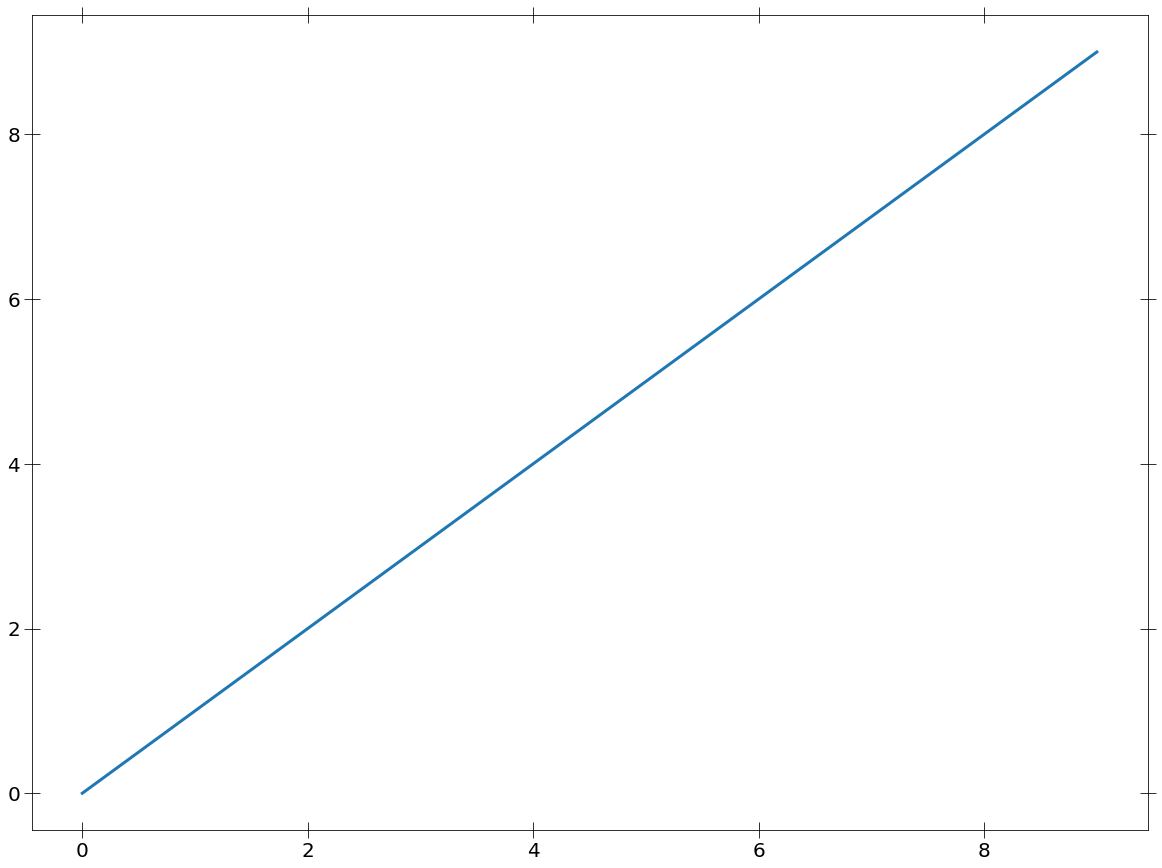

In [26]:
plt.plot(np.arange(10))

# PN files init: 853
# PN files init: 853


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:488: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:489: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:576: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:581: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:581: RuntimeWarning: invalid value encountered in true_divide


12.0


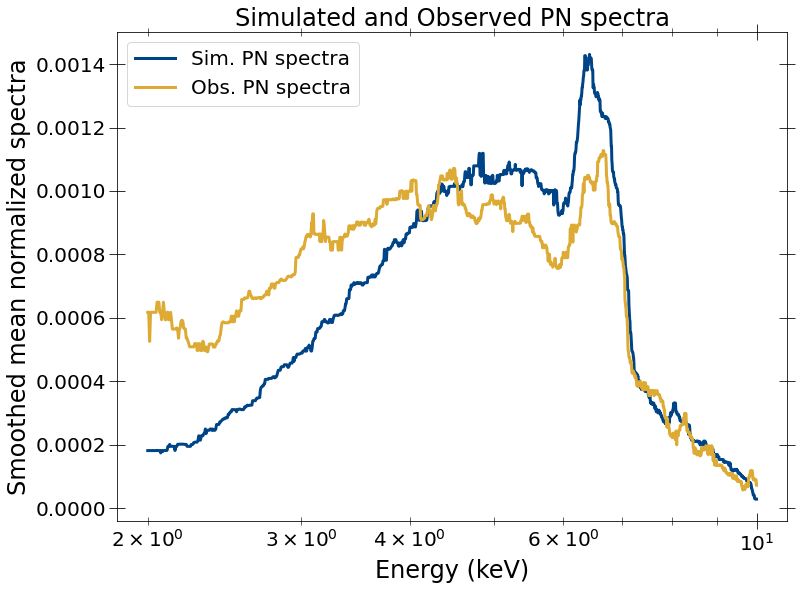

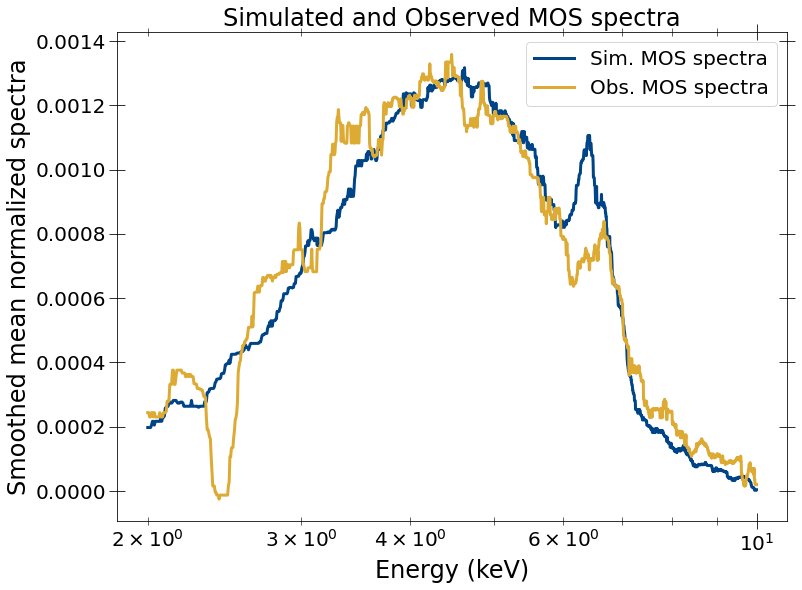

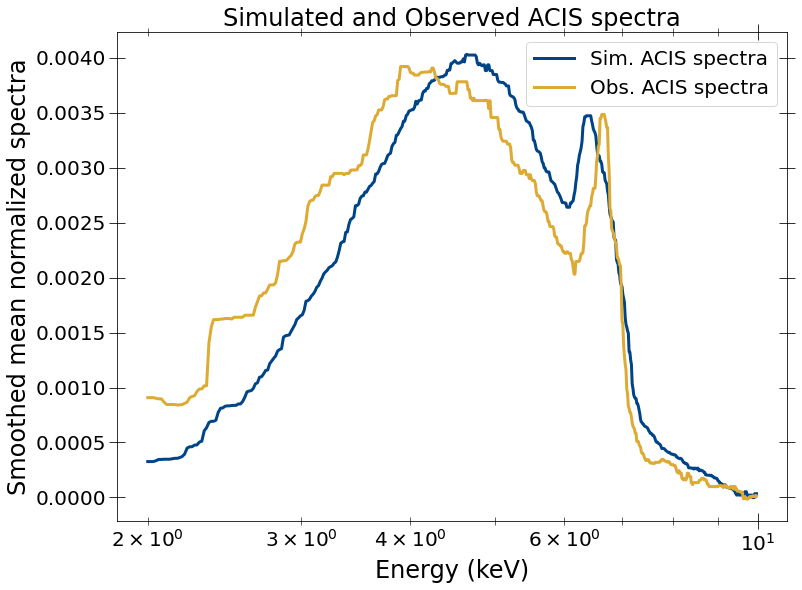

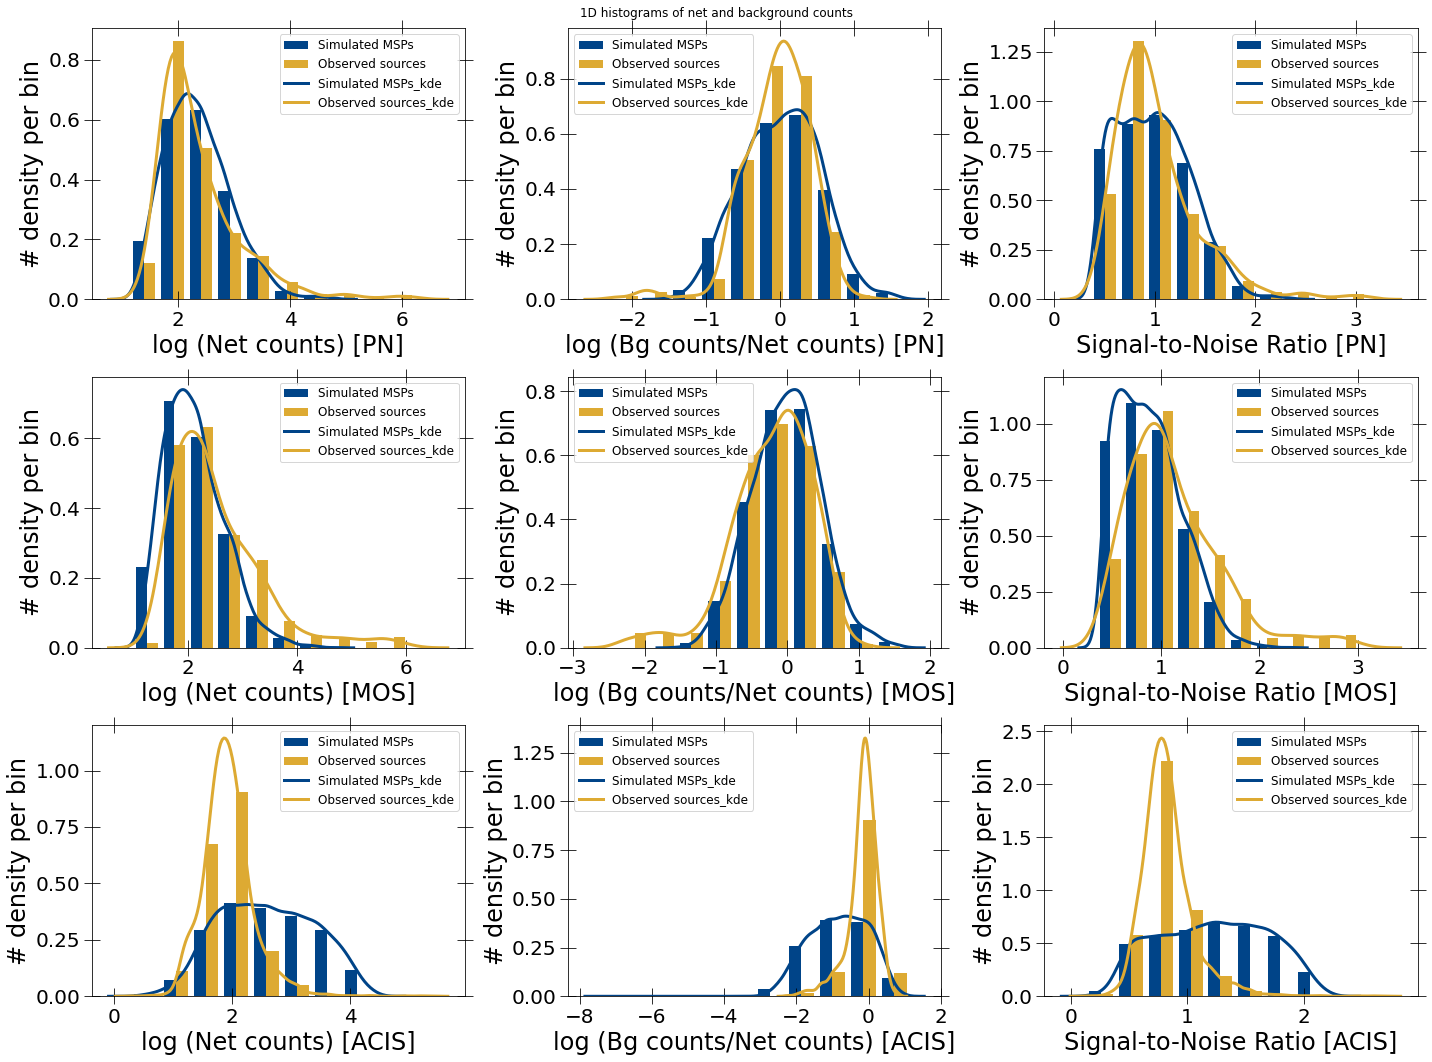

In [33]:
spec_summary = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path, xmm_sim_path, chandra_sim_path],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path], en_range=[2, 10])

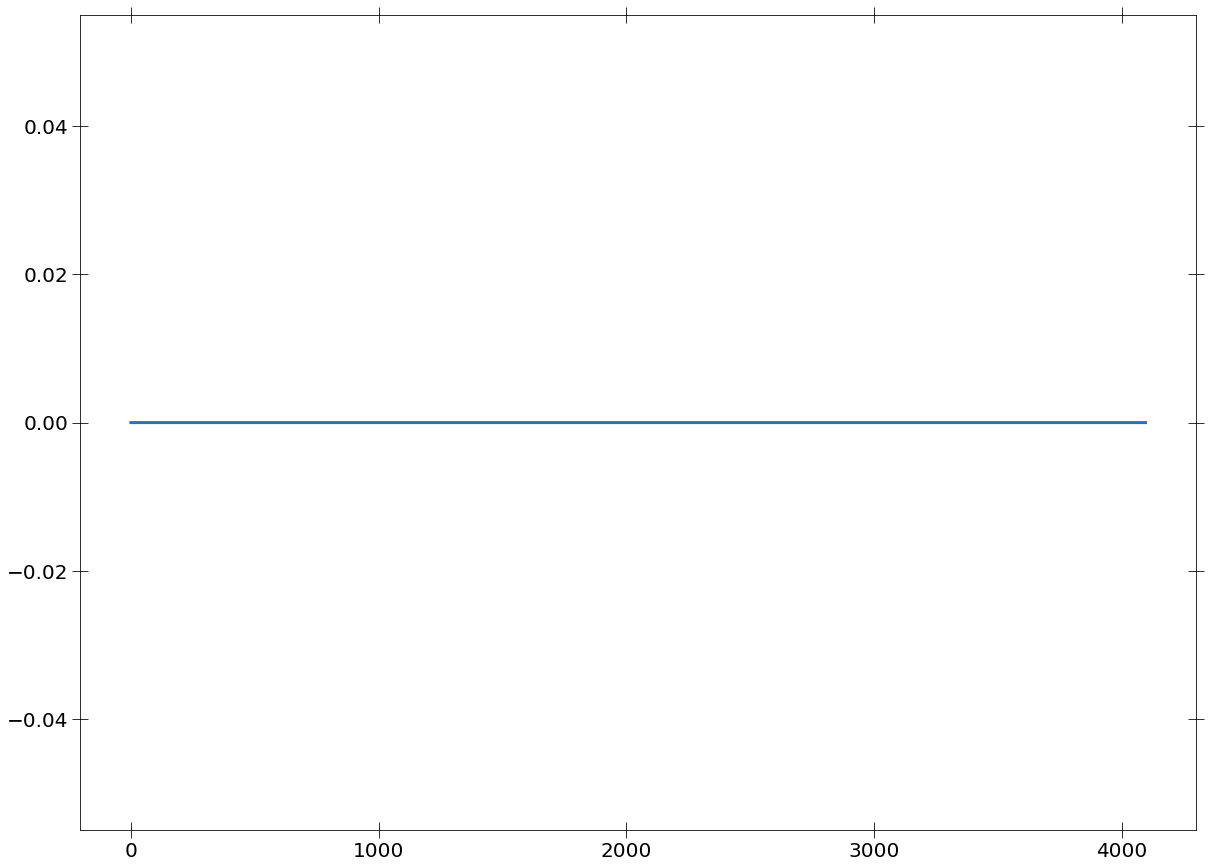

In [13]:
plt.plot(np.mean(spec_summary['specs'][0][0], axis=0))

In [144]:
counts_2keV_sim_mos = get_line_cont_counts(spec_summary['specs'][0][1][spec_summary['spec_masks'][0][1]],
                                           spec_summary['specs'][1][1][spec_summary['spec_masks'][0][1]],
                                           spec_summary['ebins'][0][1],
                                           range_fe=[2.1, 2.7])[0][0]
counts_2keV_obs_mos = get_line_cont_counts(spec_summary['specs'][2][1][spec_summary['spec_masks'][1][1]],
                                           spec_summary['specs'][3][1][spec_summary['spec_masks'][1][1]],
                                           spec_summary['ebins'][0][1],
                                           range_fe=[2.1, 2.7])[0][0]

1:80: E501 line too long (105 > 79 characters)
2:80: E501 line too long (105 > 79 characters)
5:80: E501 line too long (105 > 79 characters)
6:80: E501 line too long (105 > 79 characters)


In [158]:
counts_3keV_sim_mos = get_line_cont_counts(spec_summary['specs'][0][1][spec_summary['spec_masks'][0][1]],
                                           spec_summary['specs'][1][1][spec_summary['spec_masks'][0][1]],
                                           spec_summary['ebins'][0][1],
                                           range_fe=[2.7, 3.4])[0][0]
counts_3keV_obs_mos = get_line_cont_counts(spec_summary['specs'][2][1][spec_summary['spec_masks'][1][1]],
                                           spec_summary['specs'][3][1][spec_summary['spec_masks'][1][1]],
                                           spec_summary['ebins'][0][1],
                                           range_fe=[2.7, 3.4])[0][0]

1:80: E501 line too long (105 > 79 characters)
2:80: E501 line too long (105 > 79 characters)
5:80: E501 line too long (105 > 79 characters)
6:80: E501 line too long (105 > 79 characters)


In [159]:
netcounts_obs = spec_summary['counts'][0][1][1][spec_summary['spec_masks'][1][1]]
netcounts_sim = spec_summary['counts'][0][1][0][spec_summary['spec_masks'][0][1]]

1:80: E501 line too long (81 > 79 characters)


In [160]:
len(netcounts_obs)

445

In [161]:
spec_summary['src_nums'][0][spec_summary['spec_masks'][1][1]][105]

'201129721010057'

(array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   1.,   1.,   1.,
           1.,   7.,   5.,   9.,  28.,  37.,  51.,  95., 233.],
        [  1.,   0.,   0.,   0.,   2.,   2.,   1.,   1.,   3.,   2.,   1.,
           1.,   5.,   7.,   4.,  11.,  10.,  11.,   9.,  22.]]),
 array([-4.25934684e-01, -4.04641850e-01, -3.83349017e-01, -3.62056183e-01,
        -3.40763350e-01, -3.19470516e-01, -2.98177682e-01, -2.76884849e-01,
        -2.55592015e-01, -2.34299182e-01, -2.13006348e-01, -1.91713515e-01,
        -1.70420681e-01, -1.49127848e-01, -1.27835014e-01, -1.06542181e-01,
        -8.52493473e-02, -6.39565138e-02, -4.26636802e-02, -2.13708467e-02,
        -7.80131905e-05]),
 <a list of 2 BarContainer objects>)

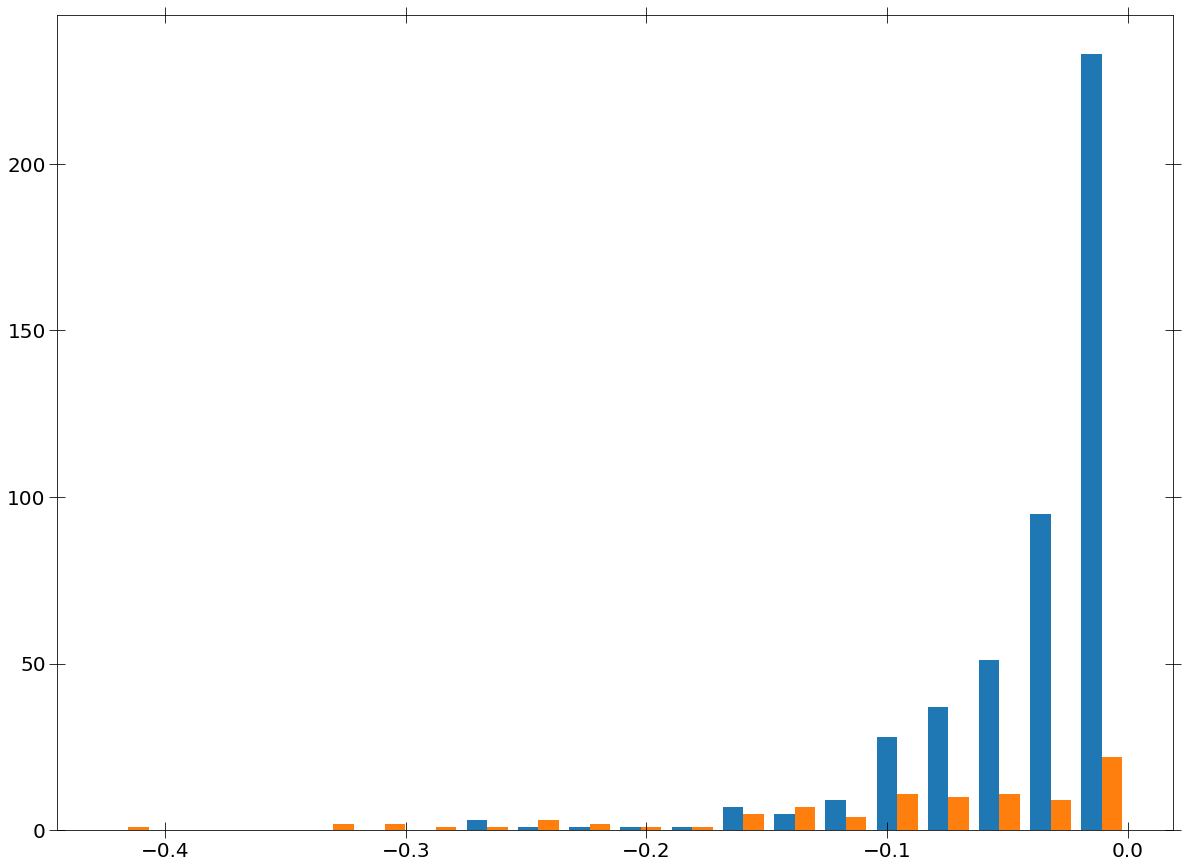

In [162]:
plt.hist([(counts_2keV_sim_mos/netcounts_sim)[counts_2keV_sim_mos < 0],
          (counts_2keV_obs_mos/netcounts_obs)[counts_2keV_obs_mos < 0]],
         bins=20)

(array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   1., 209.],
        [  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,  26.]]),
 array([-7.30066848e+02, -6.93565776e+02, -6.57064705e+02, -6.20563633e+02,
        -5.84062561e+02, -5.47561490e+02, -5.11060418e+02, -4.74559347e+02,
        -4.38058275e+02, -4.01557204e+02, -3.65056132e+02, -3.28555061e+02,
        -2.92053989e+02, -2.55552917e+02, -2.19051846e+02, -1.82550774e+02,
        -1.46049703e+02, -1.09548631e+02, -7.30475597e+01, -3.65464882e+01,
        -4.54166506e-02]),
 <a list of 2 BarContainer objects>)

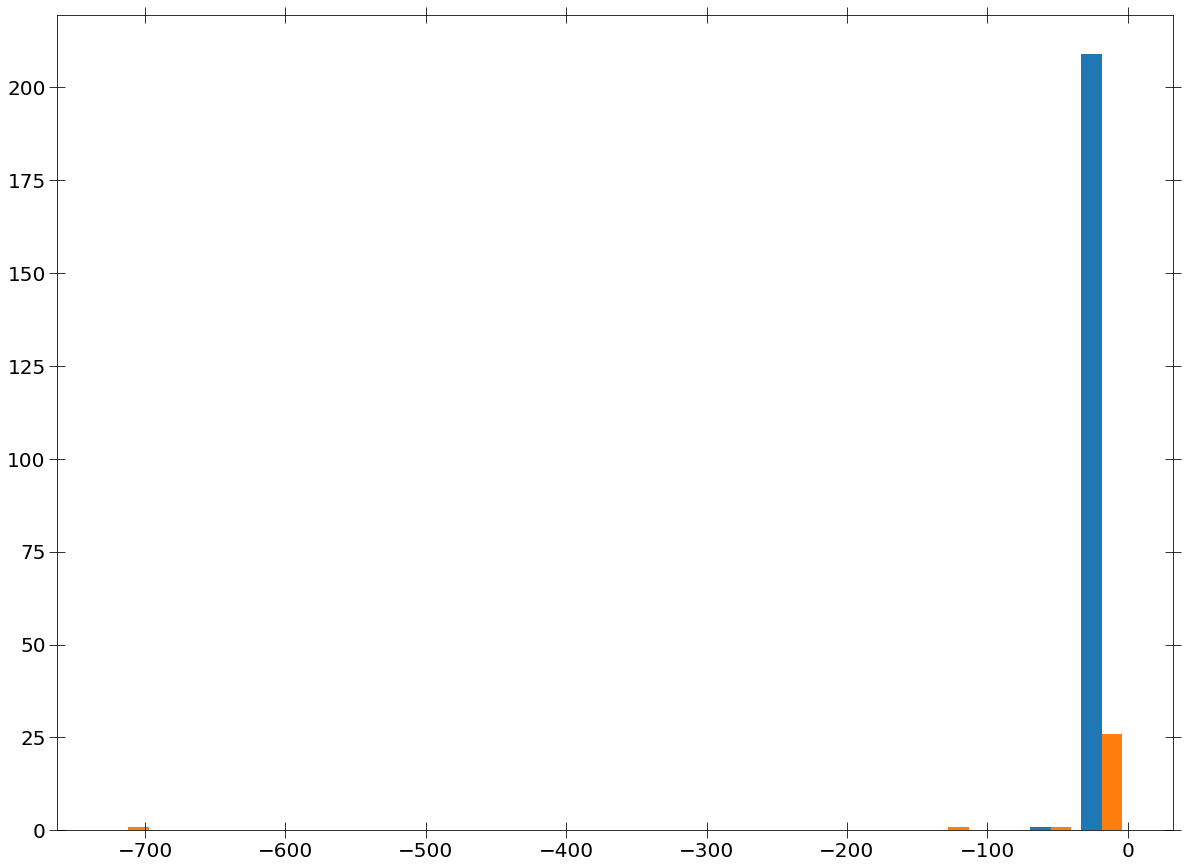

In [150]:
plt.hist([counts_3keV_sim_mos[counts_3keV_sim_mos < 0],
          counts_3keV_obs_mos[counts_3keV_obs_mos < 0]], bins=20)

In [165]:
np.sort(counts_2keV_obs_mos/netcounts_obs)[:10]

array([-0.42593468, -0.33020238, -0.32178032, -0.31756022, -0.317243  ,
       -0.2976317 , -0.26637052, -0.24287688, -0.24267083, -0.24171108])

In [163]:
spec_summary['src_nums'][0][spec_summary['spec_masks'][1][1]][np.argsort(counts_2keV_obs_mos/netcounts_obs)[:10]]

array(['206735502015094', '204024304010028', '206946410010097',
       '207848601010048', '206586001010103', '206735502010090',
       '206735502010070', '206746006015083', '206946410010058',
       '206586001010156'], dtype=object)

# PN files init: 853
# PN files init: 853


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:488: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:489: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:575: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:576: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:581: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

12.0


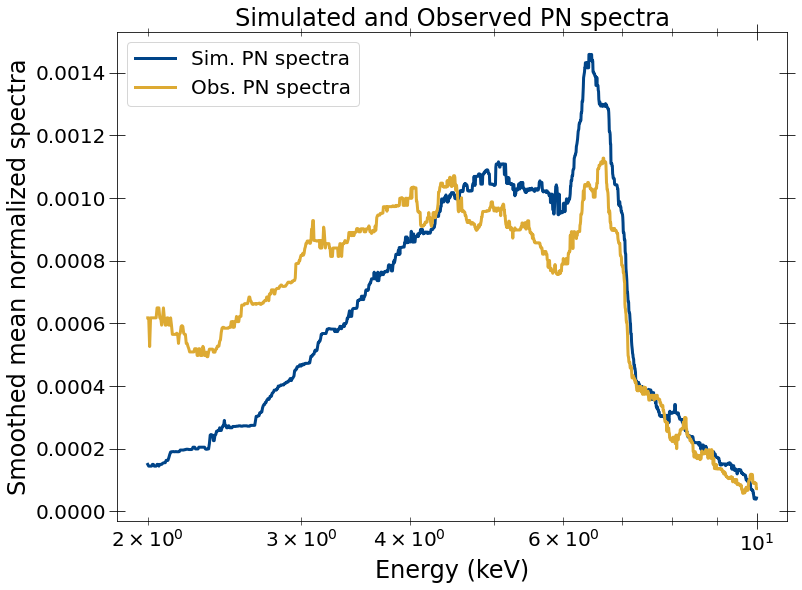

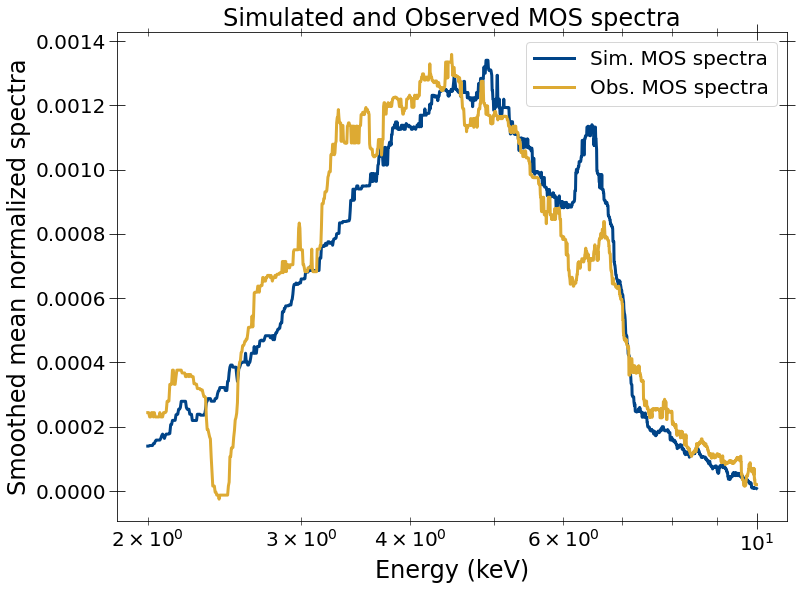

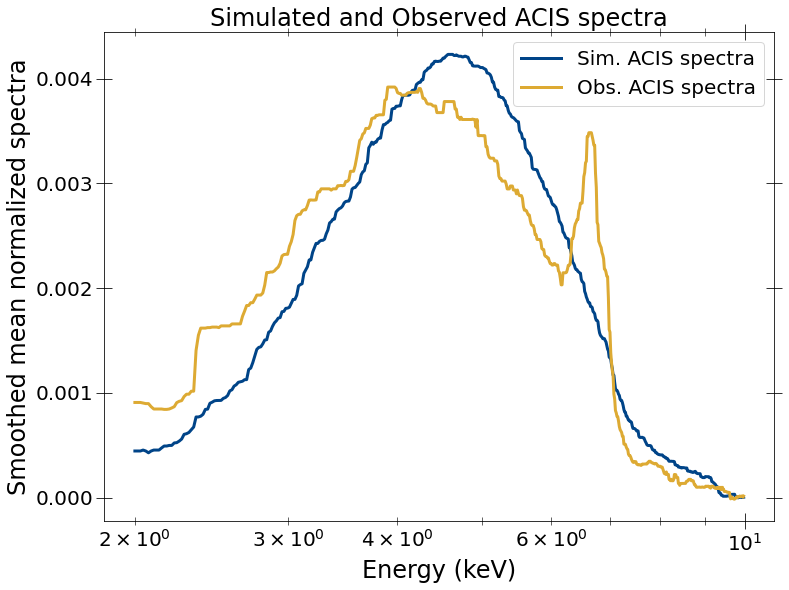

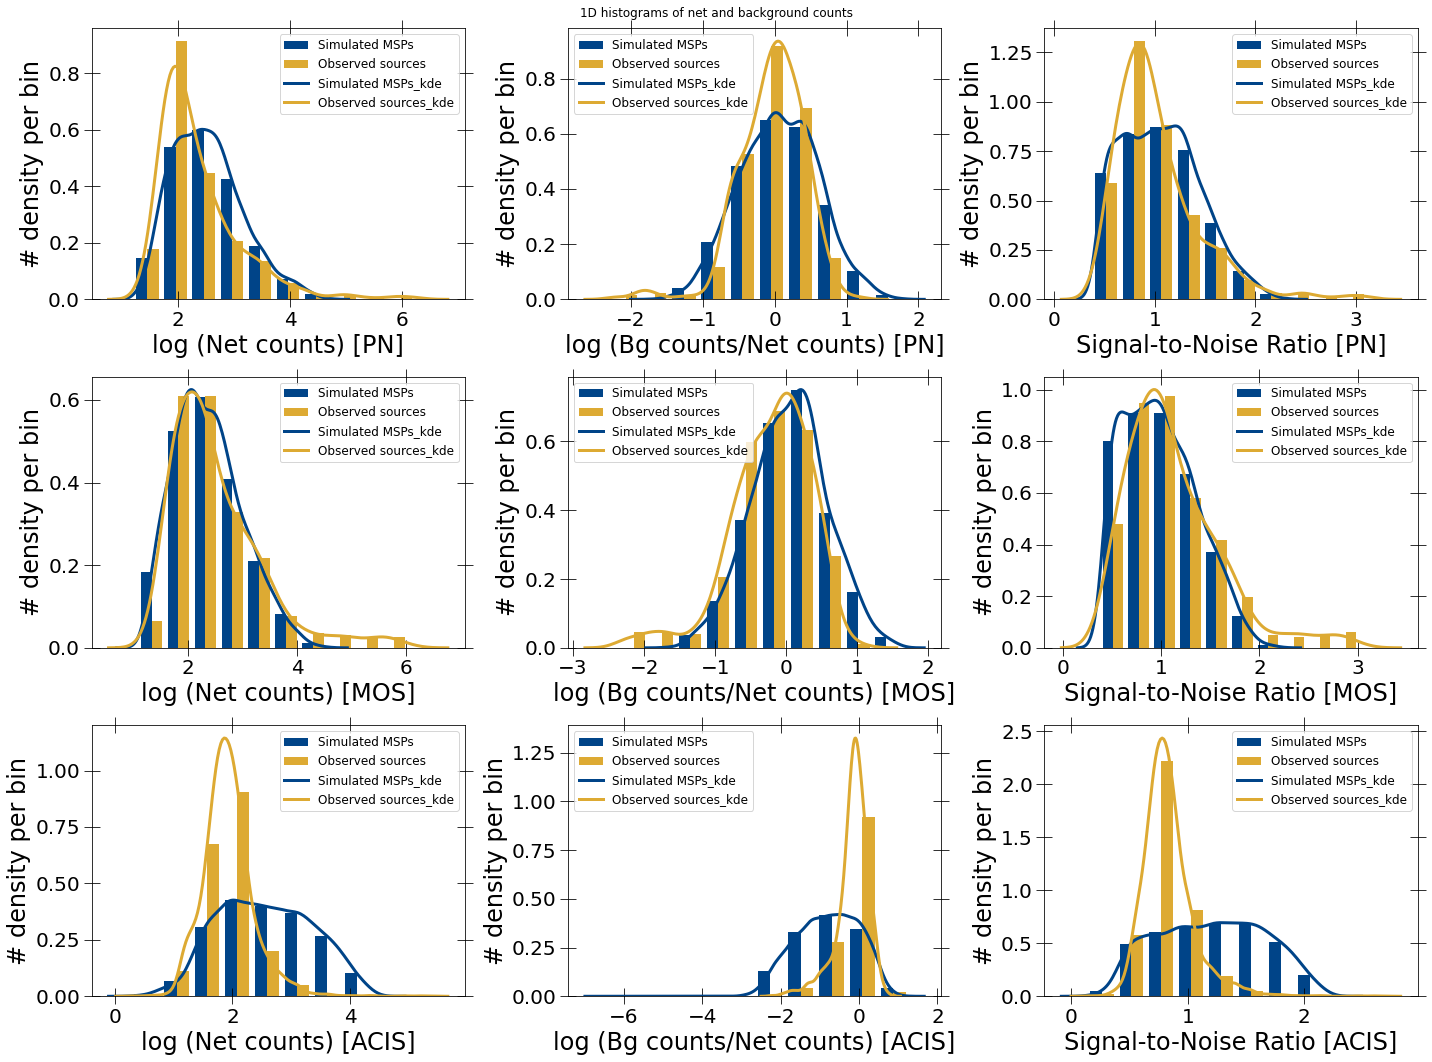

In [23]:
spec_summary_allobs = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path2, xmm_sim_path2, chandra_sim_path],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path], en_range=[2, 10])

4572 4572 4572 4572
741 741 741 741
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide


2382 2382 2382 2382
445 445 445 445
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide


7873 7873 7873 7873
2670 2670 2670 2670
Calaculating mean and standard deviation in colors vs. Net counts


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide


Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
16.0
16.0
16.0


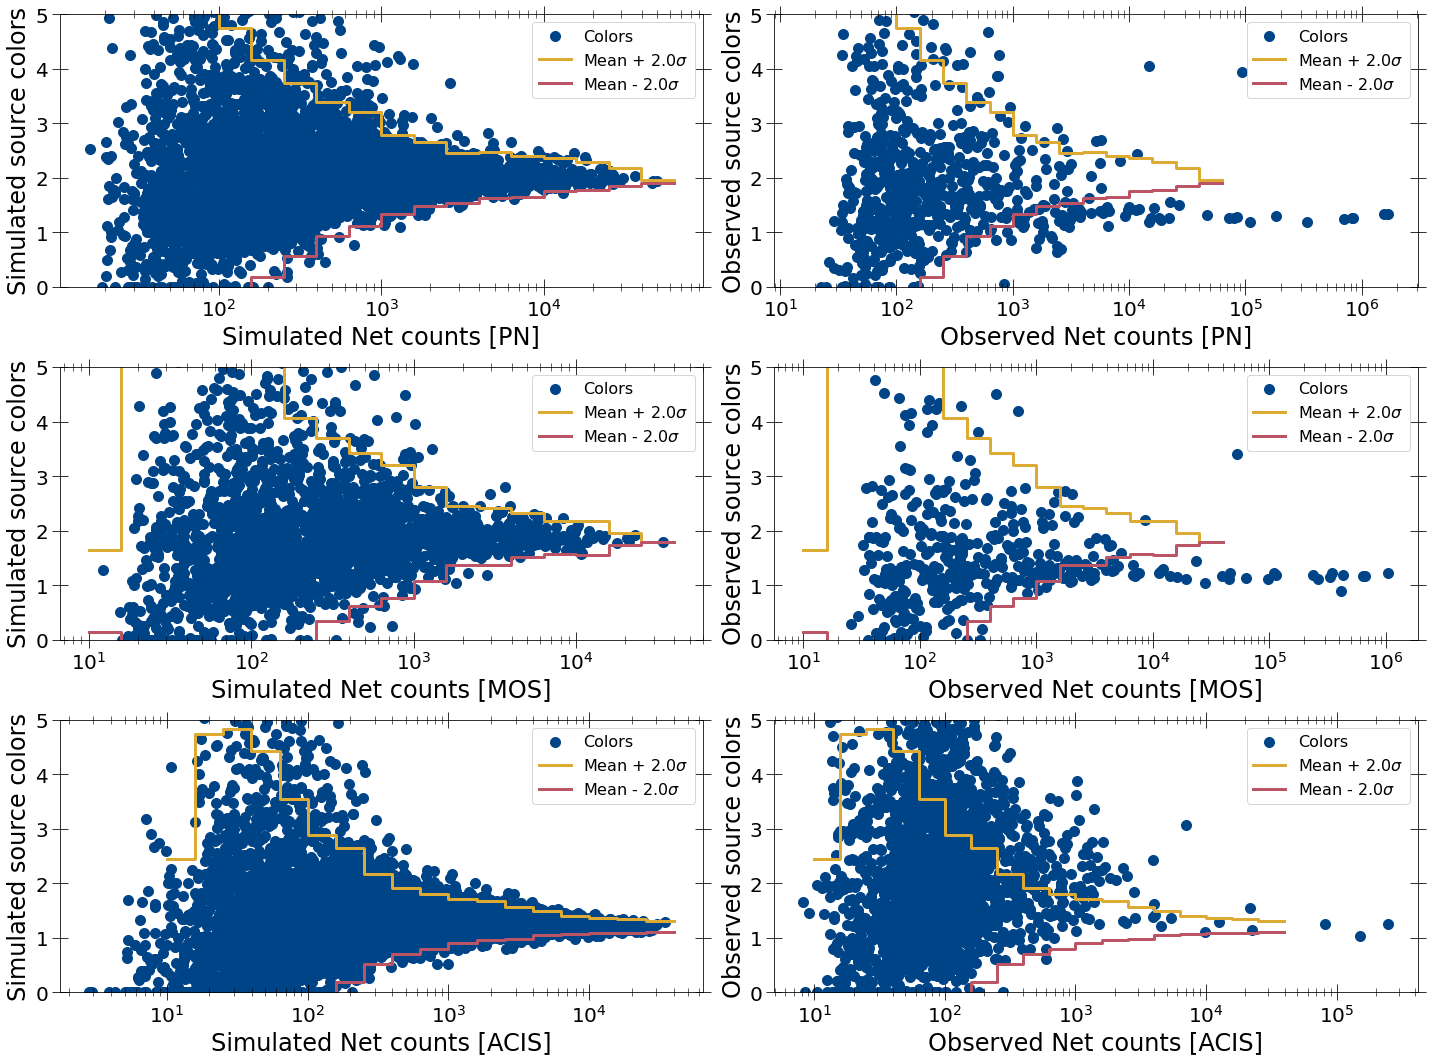

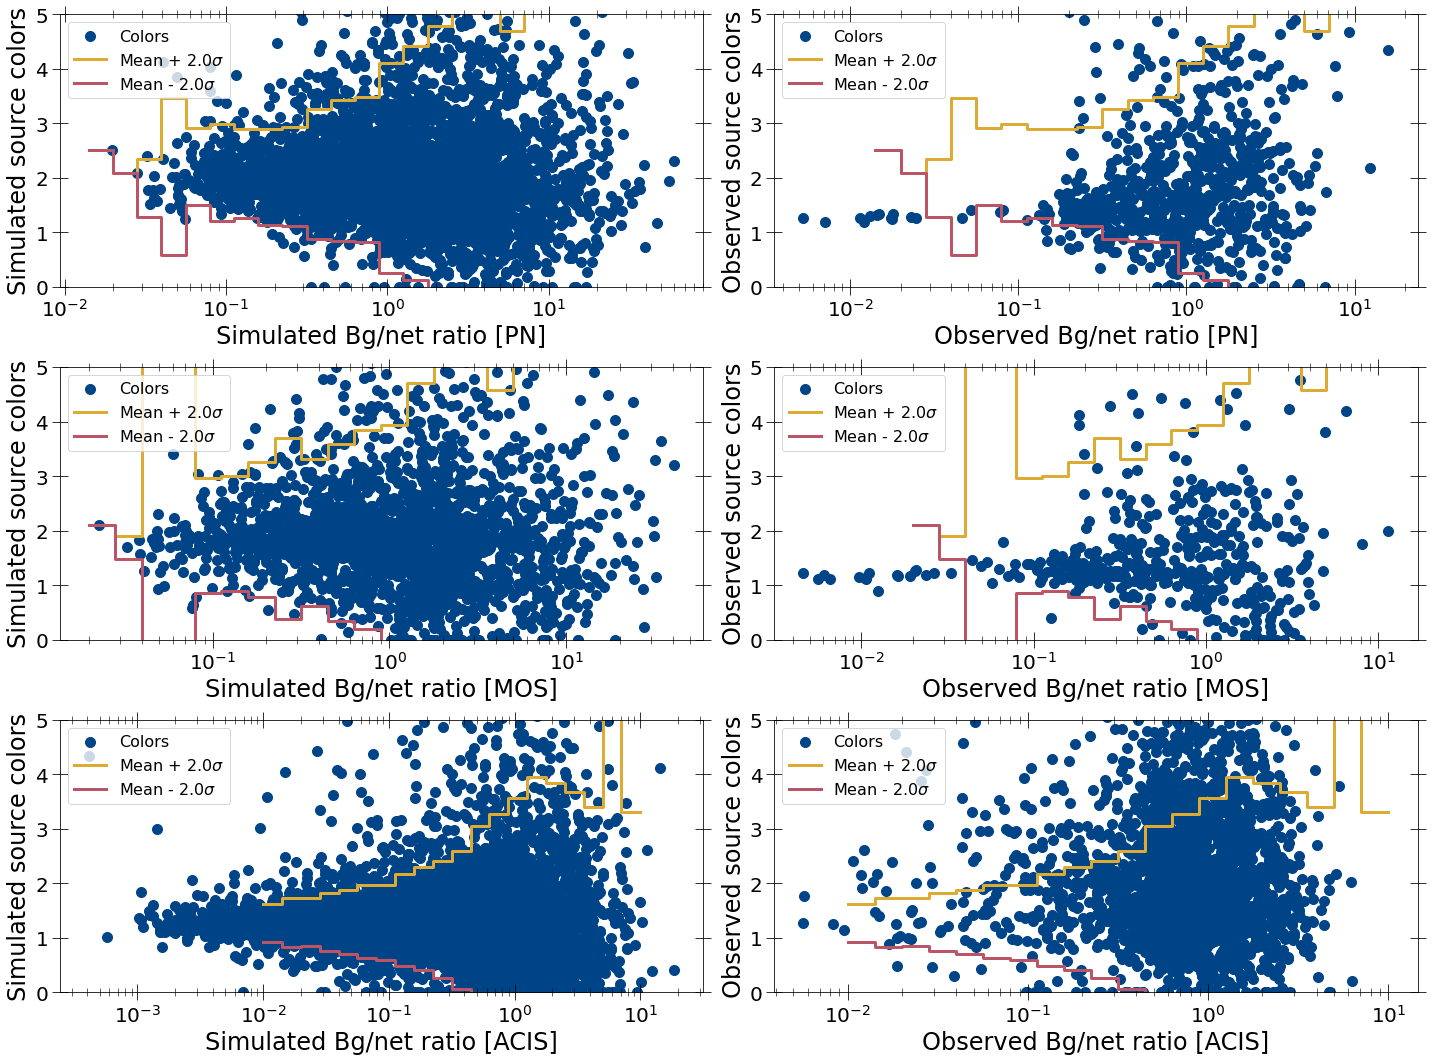

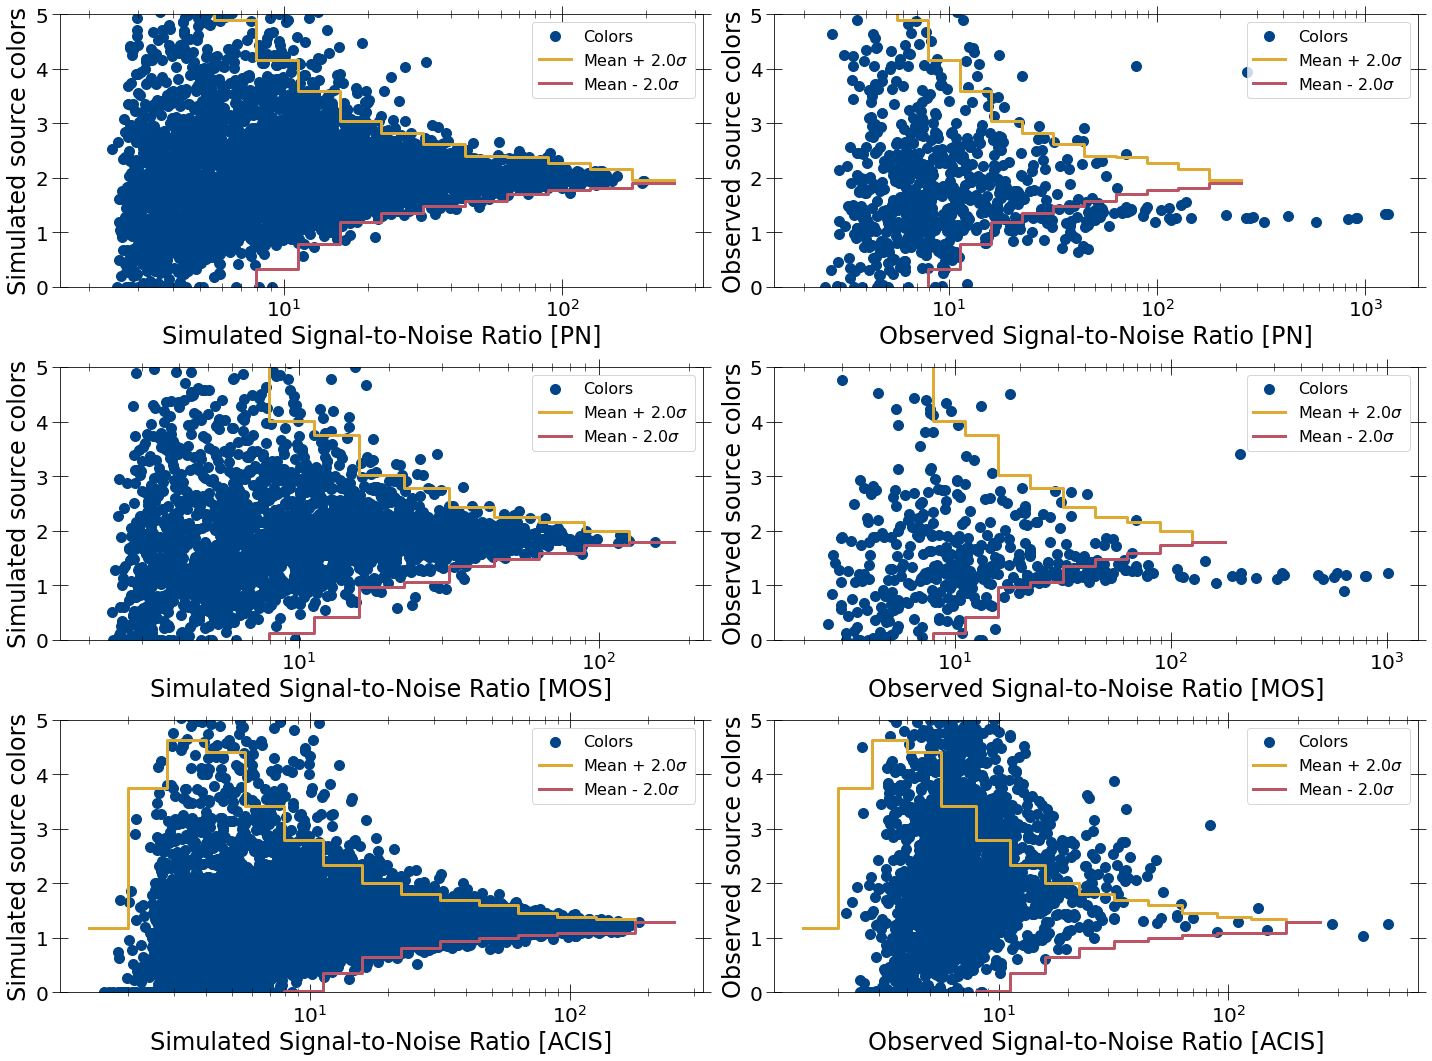

In [24]:
sim_color_dict_arr_clipped, obs_color_dict_arr_clipped = getcolor_prop_alldet(spec_summary_allobs, compare_det=True)

4419 4419 4419 4419
741 741 741 741


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide


Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
3625 3625 3625 3625
445 445 445 445
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide


8132 8132 8132 8132
2670 2670 2670 2670
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
16.0


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide


16.0
16.0


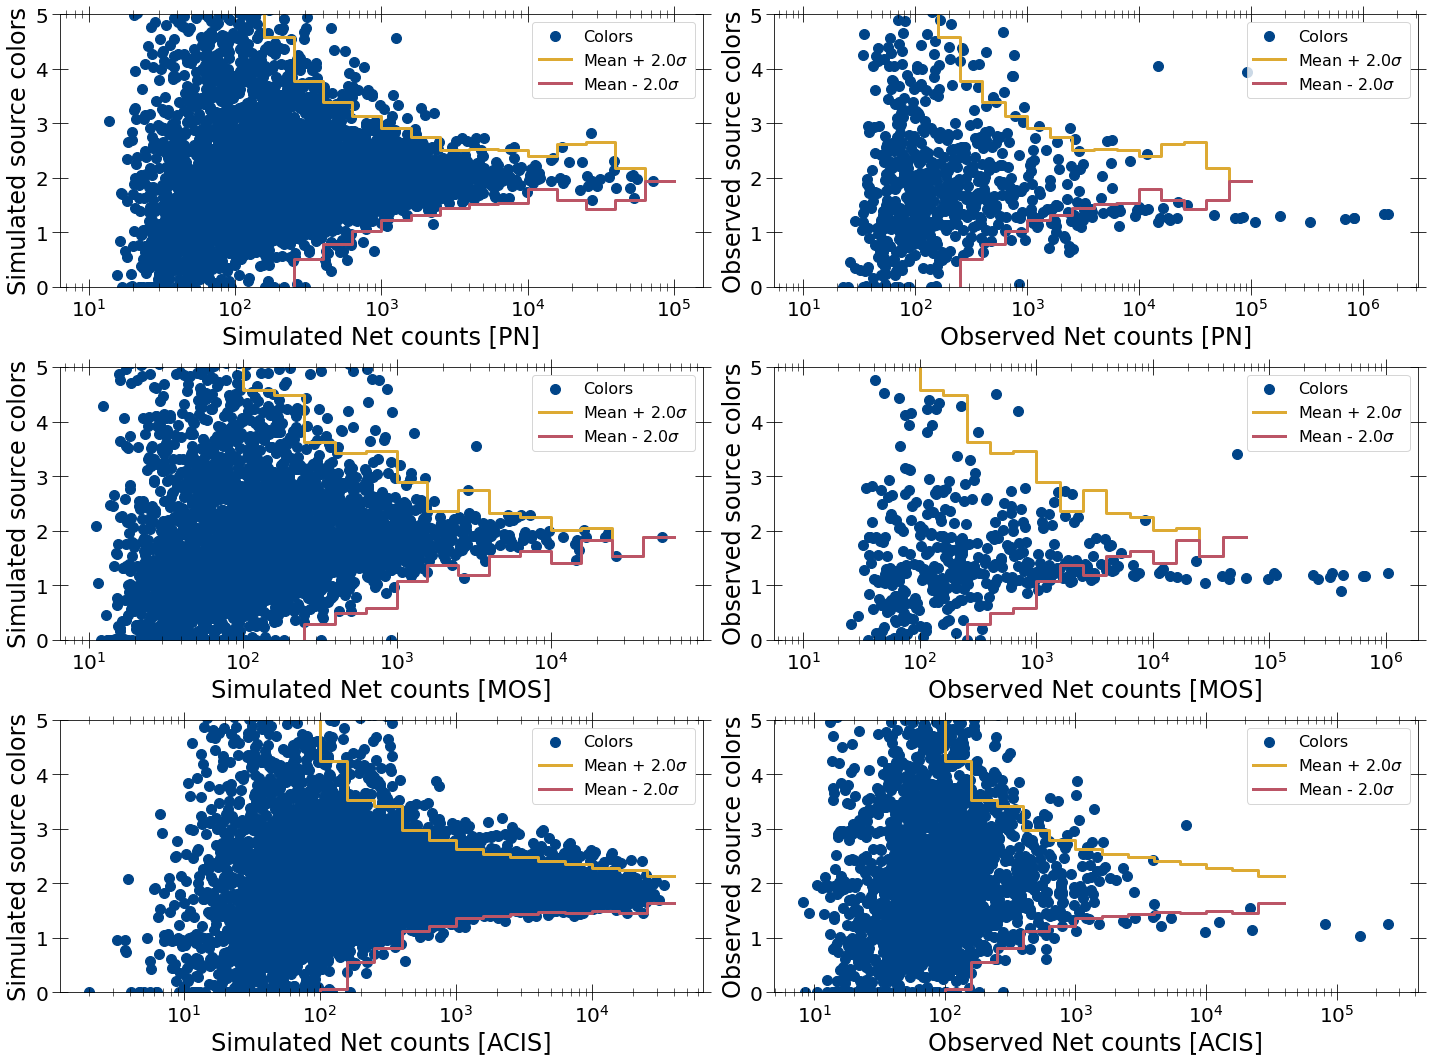

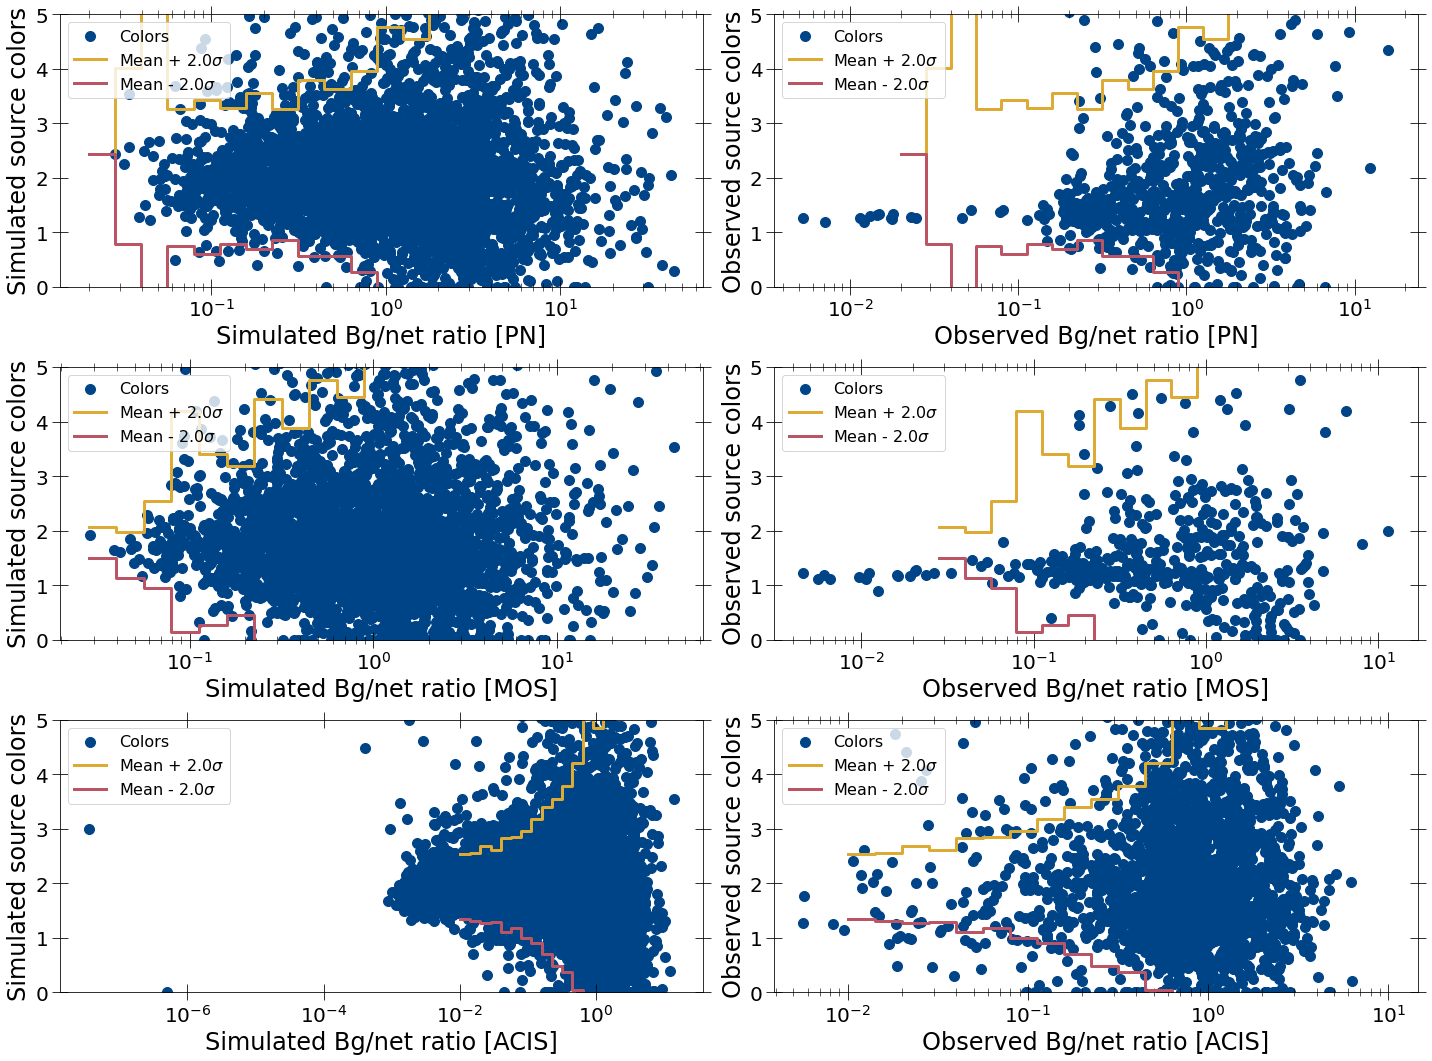

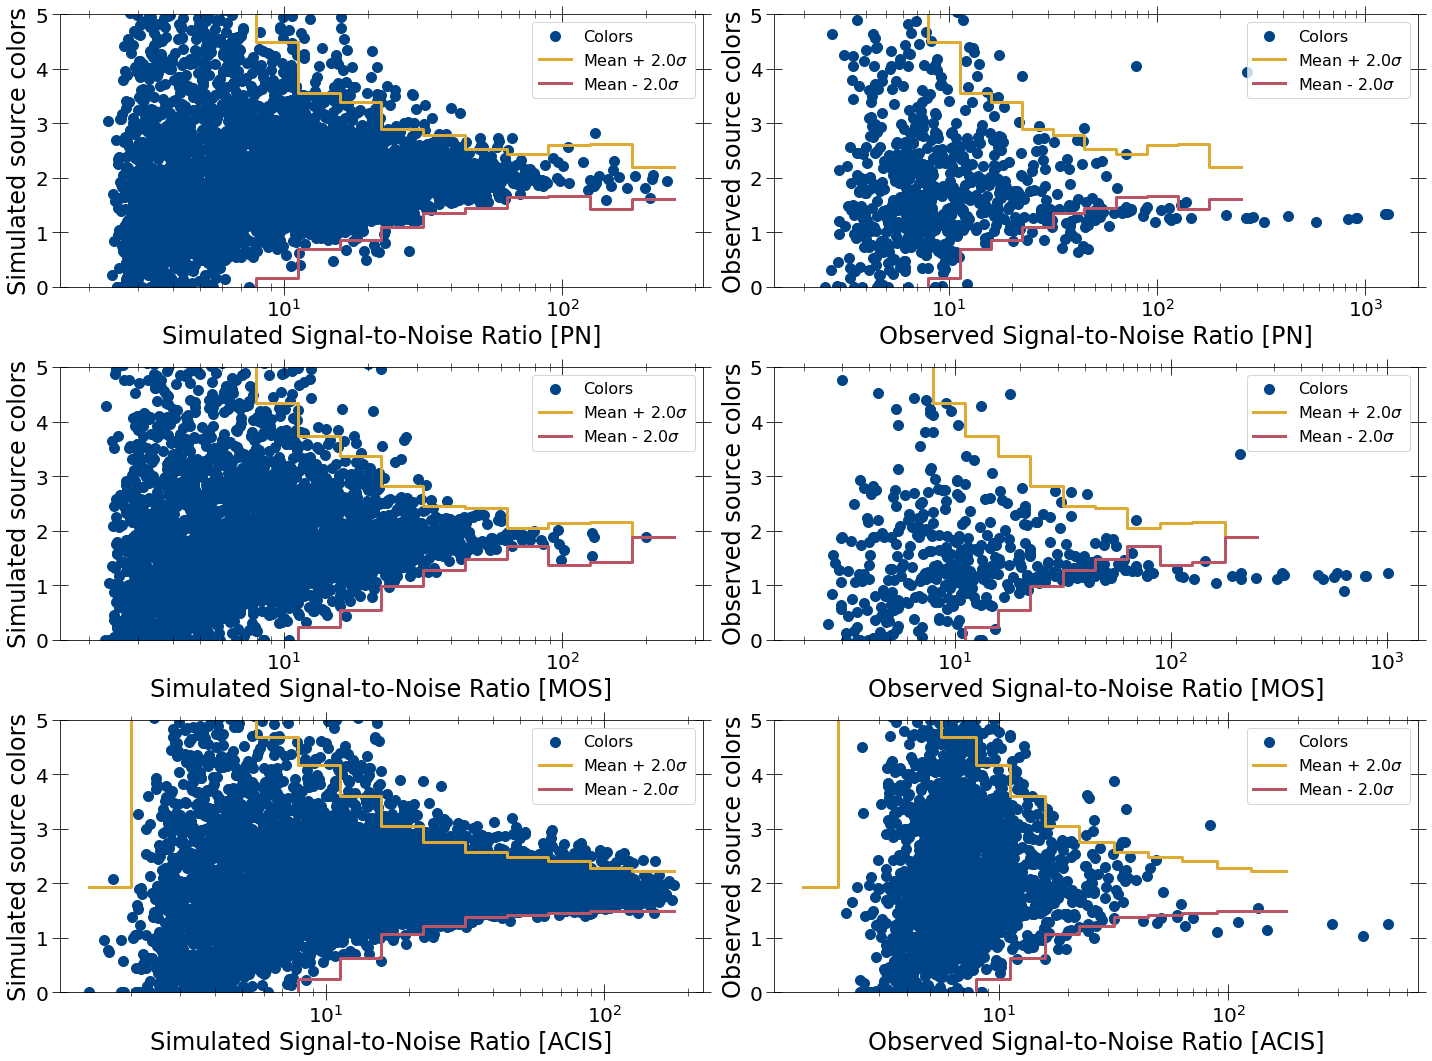

In [50]:
sim_color_dict_arr, obs_color_dict_arr = getcolor_prop_alldet(spec_summary, compare_det=True)

# PN files init: 853
# PN files init: 853


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:488: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:489: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:576: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:581: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:581: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:575: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

12.0


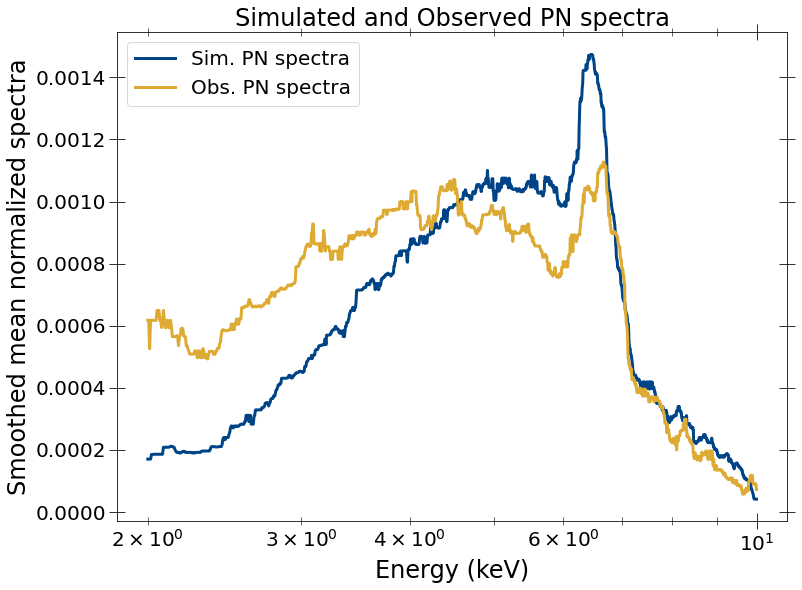

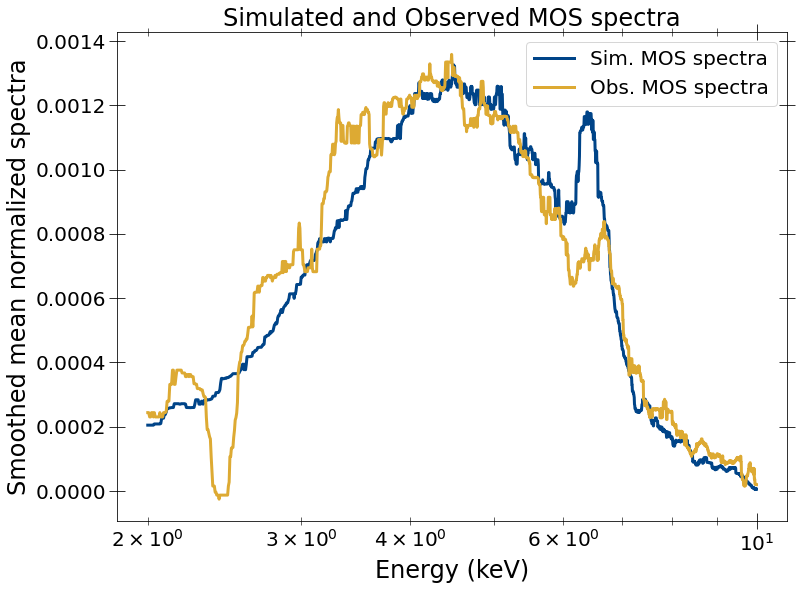

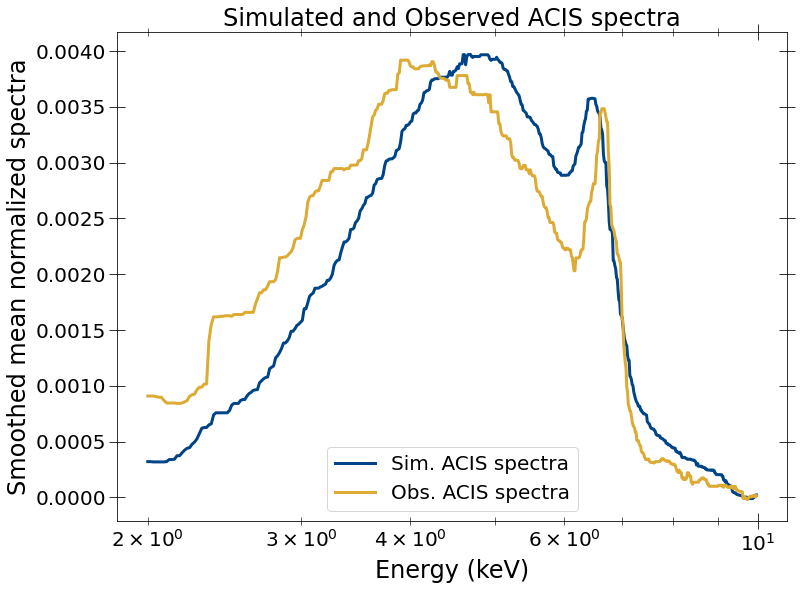

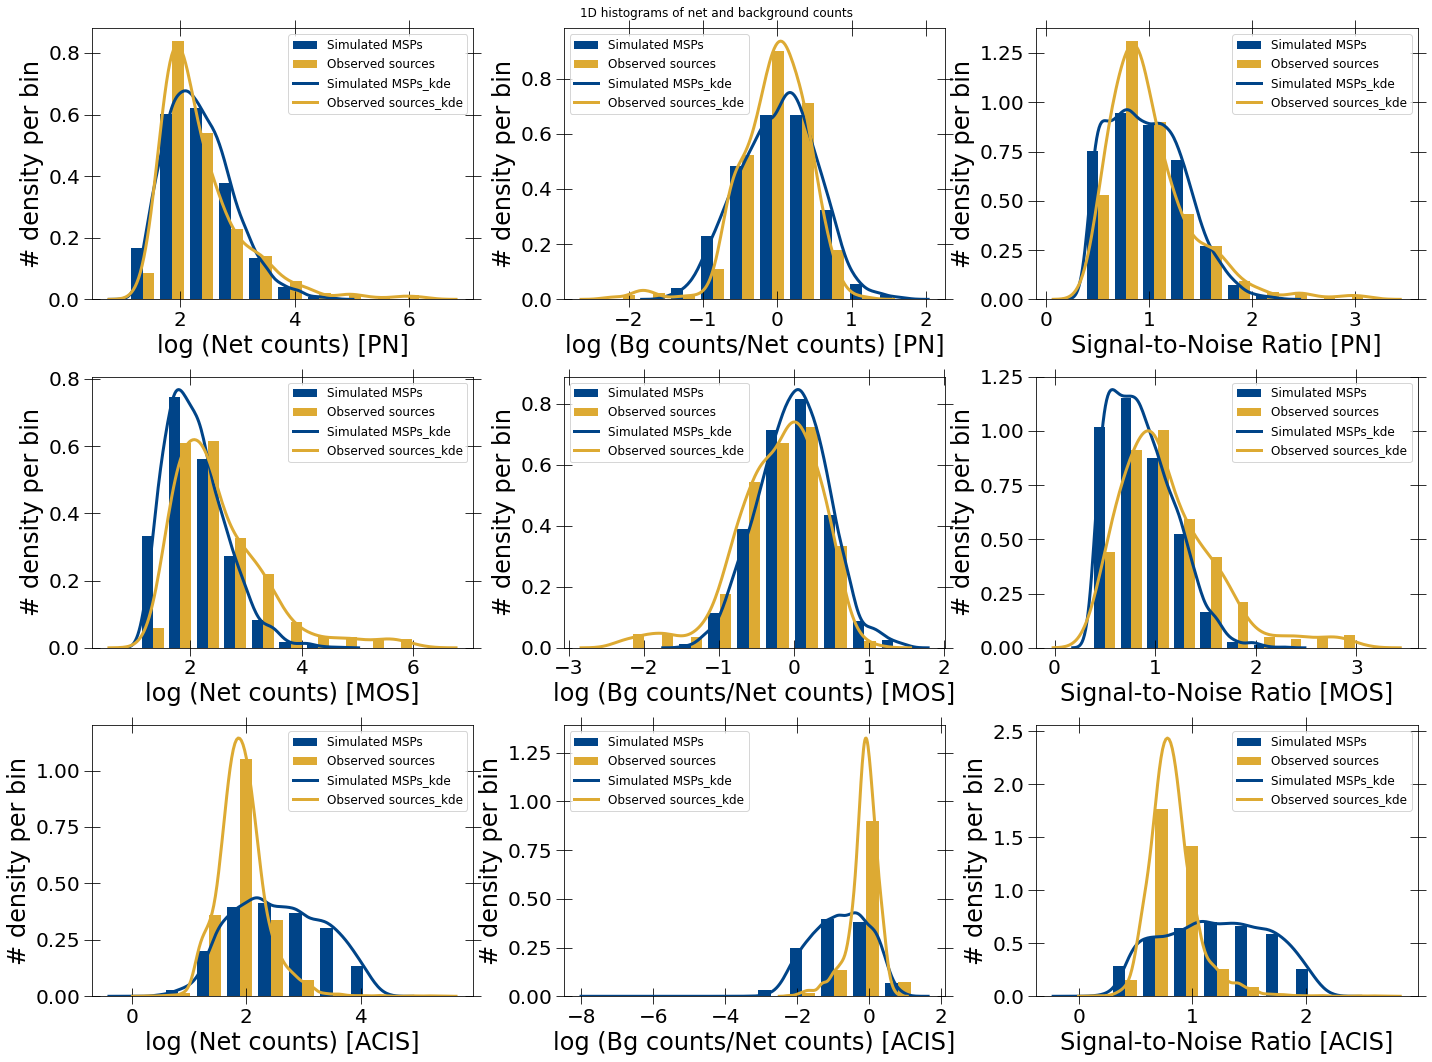

In [48]:
spec_summary2 = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path2, xmm_sim_path2, chandra_sim_path2],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path], en_range=[2.0, 10.0])

4405 4405 4405 4405
741 741 741 741
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide


3599 3599 3599 3599
445 445 445 445
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
7957 7957 7957 7957
2670 2670 2670 2670


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide


Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
16.0
16.0
16.0


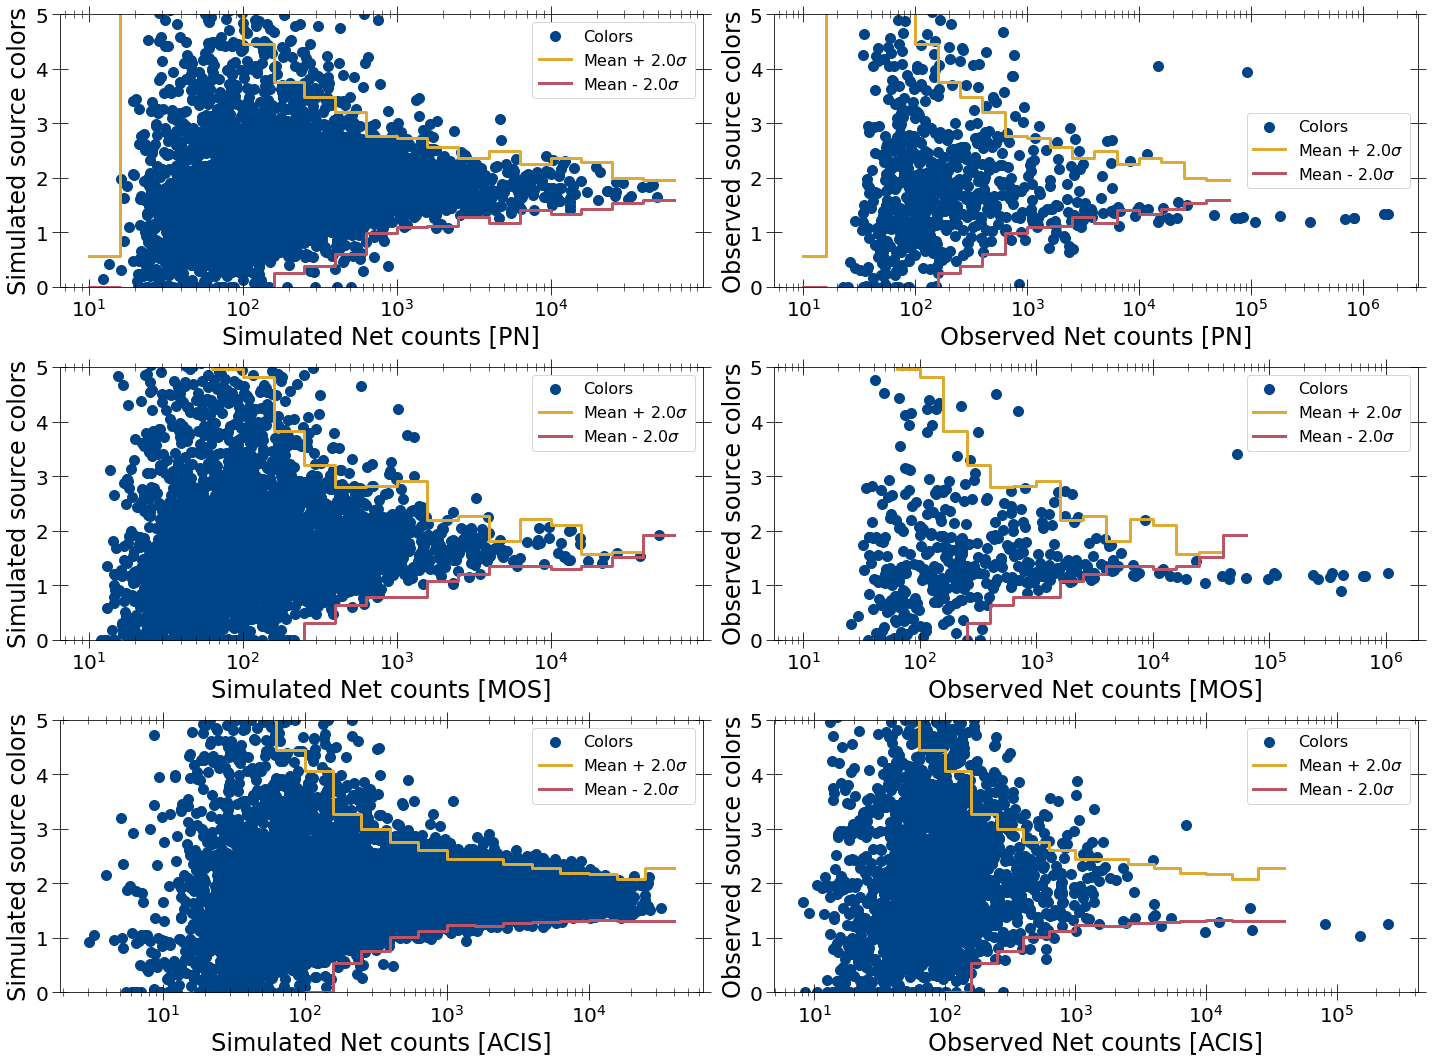

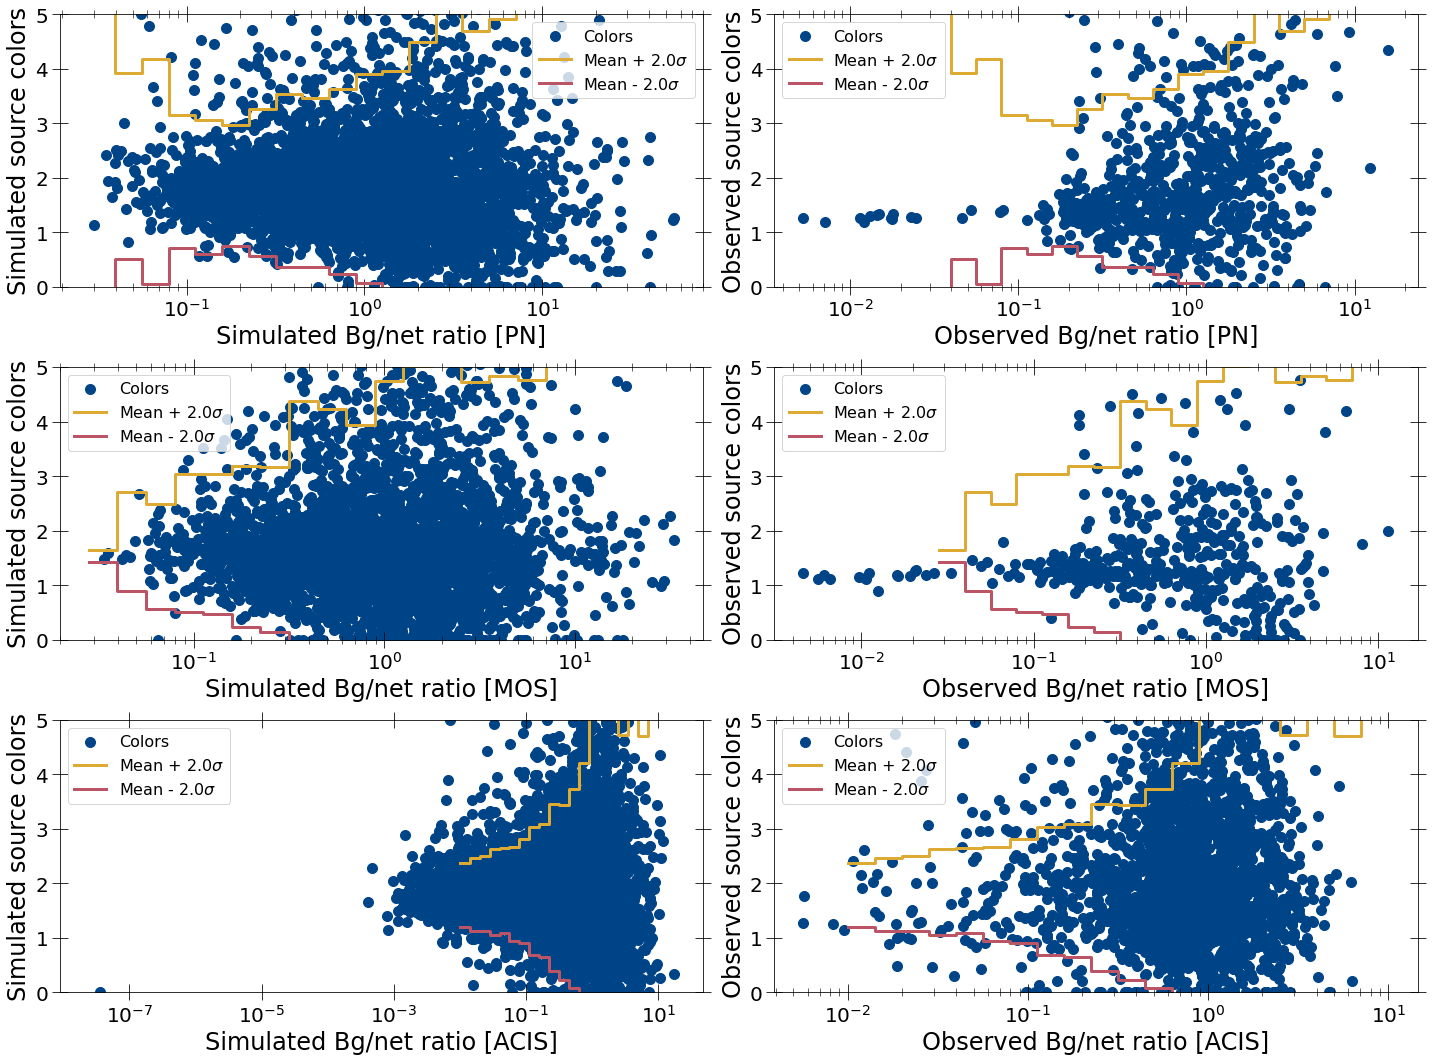

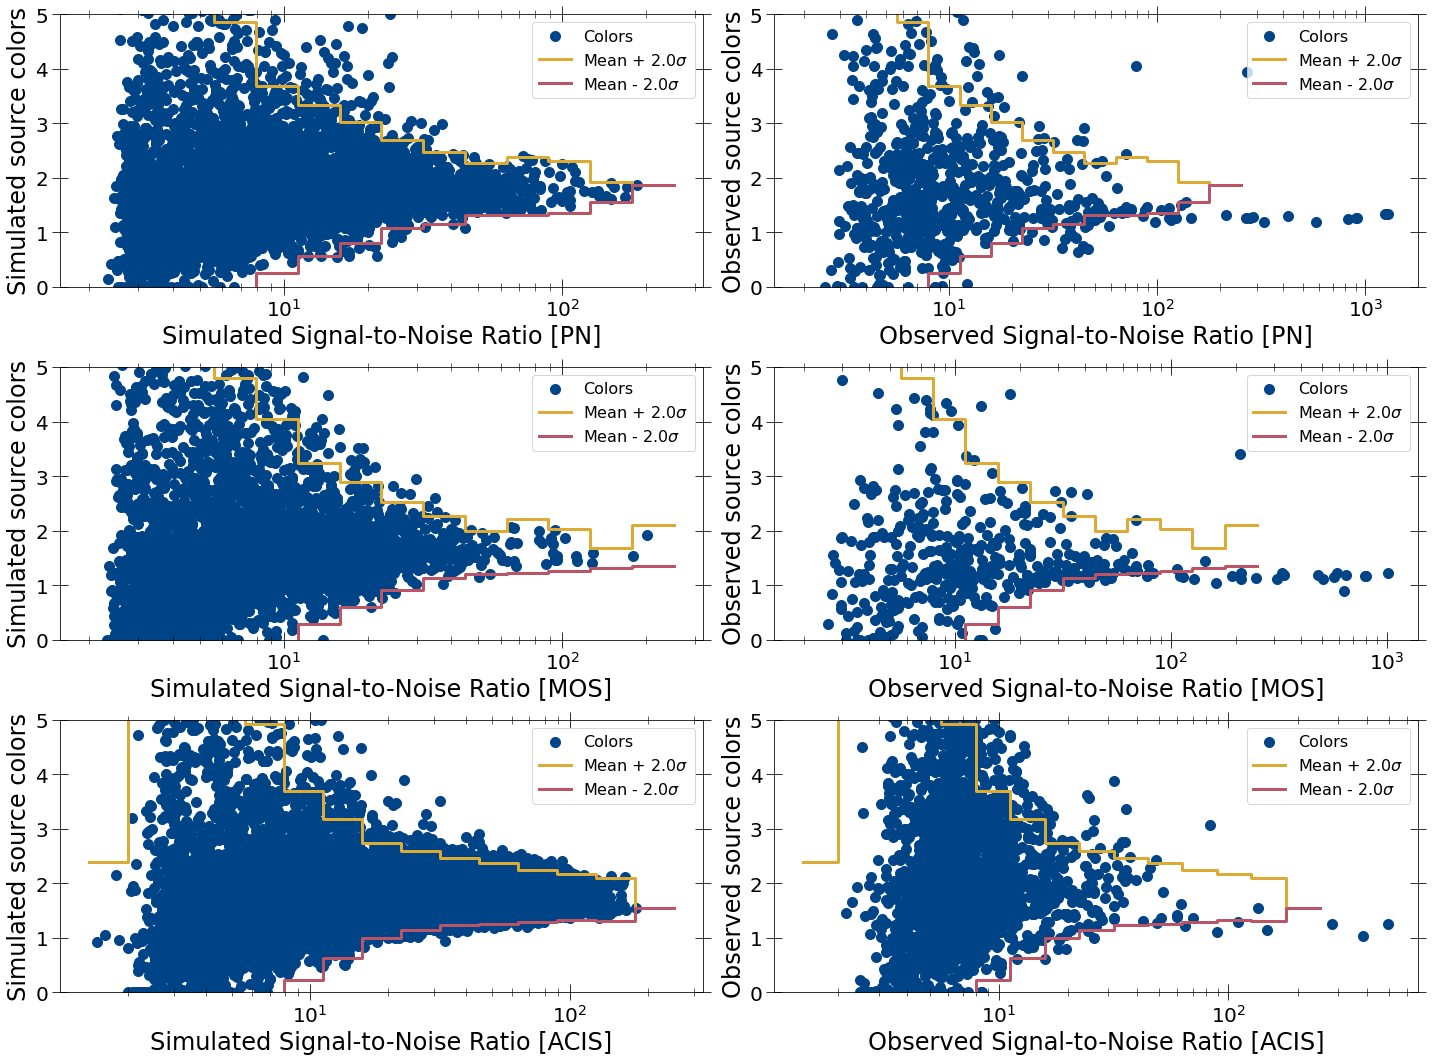

In [49]:
sim_color_dict_arr2, obs_color_dict_arr2 = getcolor_prop_alldet(spec_summary2, compare_det=True)

In [12]:
def get_candidate_src_nums_det(obs_src_nums, obs_det_mask, sim_color_dict,
                               obs_color_dict, min_counts):
    """Get src nums of quiescent sources for given detector"""
    obs_netcounts = obs_color_dict['prop_list'][0]
    netcount_bins = sim_color_dict['prop_bins'][0]
    obs_colors = obs_color_dict['colors']
    color_median = sim_color_dict['color_stat'][0][0]
    color_std = sim_color_dict['color_stat'][2][0]
    print(netcount_bins)
    print(color_median)
    print(color_std)
    interested_args = None
    for i, lower_bin in enumerate(netcount_bins):
        if lower_bin < min_counts:
            continue
        if i == len(netcount_bins) - 1:
            upper_bin = np.max(obs_netcounts) + 10
            median_color = color_median[-1]
            std_color = color_std[-1]
        else:
            upper_bin = netcount_bins[i+1]
            median_color = color_median[i]
            std_color = color_std[i]
        print(lower_bin, median_color + 2*std_color)
        if np.isnan(median_color) or np.isnan(std_color):
                    int_args = np.where(np.logical_and(
                        obs_netcounts >= lower_bin,
                        obs_netcounts < upper_bin))
        else:
        
            int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        print(len(int_args))
        if interested_args is None:
            interested_args = int_args.copy()
        else:
            interested_args = np.append(interested_args.copy(), int_args)
    return interested_args, obs_src_nums[obs_det_mask][interested_args]


def get_candidate_src_nums_alldet(spec_summary, sim_color_dict_arr,
                                  obs_color_dict_arr, min_count_arr=None):
    """Get source nums for all detectors."""
    interested_args_alldet = []
    interested_sources_alldet = []
    if min_count_arr is None:
        min_count_arr = [700, 700, 250]
    for i, obs_color_dict in enumerate(obs_color_dict_arr):
        if i > 0:
            interested_args, interested_srcs = get_candidate_src_nums_det(
                spec_summary['src_nums'][i-1], spec_summary['spec_masks'][1][i],
                sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        else:
            interested_args, interested_srcs = get_candidate_src_nums_det(
            spec_summary['src_nums'][i], spec_summary['spec_masks'][1][i],
            sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        interested_args_alldet.append(interested_args)
        interested_sources_alldet.append(interested_srcs)
    return interested_args_alldet, interested_sources_alldet


26:21: E117 over-indented
30:1: W293 blank line contains whitespace
59:80: E501 line too long (80 > 79 characters)
63:13: E122 continuation line missing indentation or outdented
64:13: E122 continuation line missing indentation or outdented


In [229]:
interested_args_alldet2, interested_srcs_alldet2 = get_candidate_src_nums_alldet(spec_summary2, sim_color_dict_arr2,
                              obs_color_dict_arr2, min_count_arr=[39, 39, 39])

1:80: E501 line too long (116 > 79 characters)
2:31: E128 continuation line under-indented for visual indent


[1.00000000e+01 1.58489319e+01 2.51188643e+01 3.98107171e+01
 6.30957344e+01 1.00000000e+02 1.58489319e+02 2.51188643e+02
 3.98107171e+02 6.30957344e+02 1.00000000e+03 1.58489319e+03
 2.51188643e+03 3.98107171e+03 6.30957344e+03 1.00000000e+04
 1.58489319e+04 2.51188643e+04 3.98107171e+04 6.30957344e+04
 1.00000000e+05]
[1.83545986 1.50859322 1.66084    1.48175529 1.46547481 1.42173222
 1.37907158 1.34241947 1.34164331 1.31932186 1.34112453 1.3576441
 1.36300675 1.31582893 1.27252105 1.33460737 1.24506393        nan
        nan        nan]
[1.44048382 0.95488145 1.07957089 0.78189889 0.56793735 0.42176062
 0.35496784 0.23084005 0.21274793 0.14517379 0.13894162 0.16628634
 0.13988764 0.09864256 0.04666147 0.         0.                nan
        nan        nan]
39.810717055349734 3.0455530706070366
71
63.09573444801933 2.601349507465748
60
100.0 2.2652534668157647
28
158.48931924611142 2.08900725130583
23
251.18864315095823 1.8040995660264987
13
398.1071705534973 1.7671391723807393
11
6

In [13]:
interested_args_alldet, interested_srcs_alldet = get_candidate_src_nums_alldet(spec_summary, sim_color_dict_arr,
                              obs_color_dict_arr, min_count_arr=[150, 150, 150])

[1.00000000e+01 1.58489319e+01 2.51188643e+01 3.98107171e+01
 6.30957344e+01 1.00000000e+02 1.58489319e+02 2.51188643e+02
 3.98107171e+02 6.30957344e+02 1.00000000e+03 1.58489319e+03
 2.51188643e+03 3.98107171e+03 6.30957344e+03 1.00000000e+04
 1.58489319e+04 2.51188643e+04 3.98107171e+04 6.30957344e+04
 1.00000000e+05]
[0.8405164  2.07153913 1.67298979 1.57385831 1.58436607 1.66406679
 1.43030382 1.44713313 1.39609846 1.36984926 1.35086023 1.27893642
 1.31590127 1.33564778 1.334838   1.30071855 1.27144028 1.27383281
 1.26917868 1.24506393]
[0.         2.55426532 1.66817468 1.37071133 1.16334185 1.11434474
 0.75549623 0.56022382 0.51077116 0.36126324 0.24291962 0.17375792
 0.13254254 0.16428213 0.15864827 0.09633923 0.05725364 0.0421451
 0.0654287  0.        ]
158.48931924611142 2.9412962840318846
67
251.18864315095823 2.567580775527234
45
398.1071705534973 2.4176407708782373
30
630.957344480193 2.0923757354927424
22
1000.0 1.8366994711223559
15
1584.893192461114 1.6264522674211288
18


1:80: E501 line too long (112 > 79 characters)
2:31: E128 continuation line under-indented for visual indent


In [14]:
len(np.sort(interested_srcs_alldet[0]))

236

In [15]:
len(np.sort(interested_srcs_alldet[1]))

205

In [16]:
len(np.sort(interested_srcs_alldet[2]))

275

In [17]:
def mark_interested_srcs(sim_color_dict, obs_color_dict, src_nums, obs_mask,
                         interested_srcs, prop_num=0):
    props = obs_color_dict['prop_list'][prop_num]
    colors = obs_color_dict['colors']
    interested_args = np.where(np.isin(src_nums[obs_mask], interested_srcs))
    print(interested_args)
    print(src_nums[obs_mask][interested_args])
    print(props[interested_args])
    print(colors[interested_args])
    prop_bins = sim_color_dict['prop_bins'][prop_num]
    mean_color = sim_color_dict['color_stat'][0][prop_num]
    std_color = sim_color_dict['color_stat'][2][prop_num]
    plotline_scatter([props, props[interested_args], prop_bins, prop_bins],
                     [colors, colors[interested_args], mean_color + 2*std_color,
                      mean_color - 2*std_color],
                     pl_types=['scatter', 'scatter', 'step', 'step'],
                     xlabel='Net counts', ylabel='Colors',
                     pl_labels=['Colors', 'Colors (candidates)',
                                r'Mean + 2$\sigma$', r'Mean + 2$\sigma$'],
                     ylim=(0, 5))

14:80: E501 line too long (80 > 79 characters)


In [23]:
np.where(spec_summary['src_nums'][0] == )

SyntaxError: invalid syntax (<ipython-input-23-8d0a30d54856>, line 1)

1:40: E202 whitespace before ')'
41: E999 SyntaxError: invalid syntax


Error before execution: invalid syntax (<ipython-input-23-8d0a30d54856>, line 1)


In [18]:
mark_interested_srcs(sim_color_dict_arr[0], obs_color_dict_arr[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     interested_srcs_alldet2[0], 0)

NameError: name 'interested_srcs_alldet2' is not defined

2:80: E501 line too long (83 > 79 characters)


(array([  3,   4,   6,  10,  11,  16,  17,  20,  23,  29,  32,  38,  39,
        40,  46,  47,  48,  50,  52,  59,  62,  69,  72,  74,  75,  78,
        82,  84,  87,  94,  95,  96,  97,  99, 100, 105, 107, 109, 110,
       111, 115, 118, 119, 120, 123, 129, 133, 138, 139, 141, 143, 144,
       146, 149, 156, 159, 160, 163, 166, 168, 169, 170, 178, 179, 180,
       186, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 212, 213,
       214, 215, 216, 218, 221, 222, 224, 226, 228, 230, 236, 239, 243,
       251, 252, 256, 259, 260, 270, 273, 274, 276, 279, 280, 283, 284,
       285, 286, 287, 288, 290, 292, 295, 296, 298, 309, 311, 313, 315,
       318, 319, 320, 322, 324, 333, 334, 338, 345, 347, 348, 349, 357,
       375, 379, 380, 381, 382, 383, 386, 395, 396, 397, 398, 399, 400,
       401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413,
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 442, 444]),)
['201032613010001' '201032613010002' '

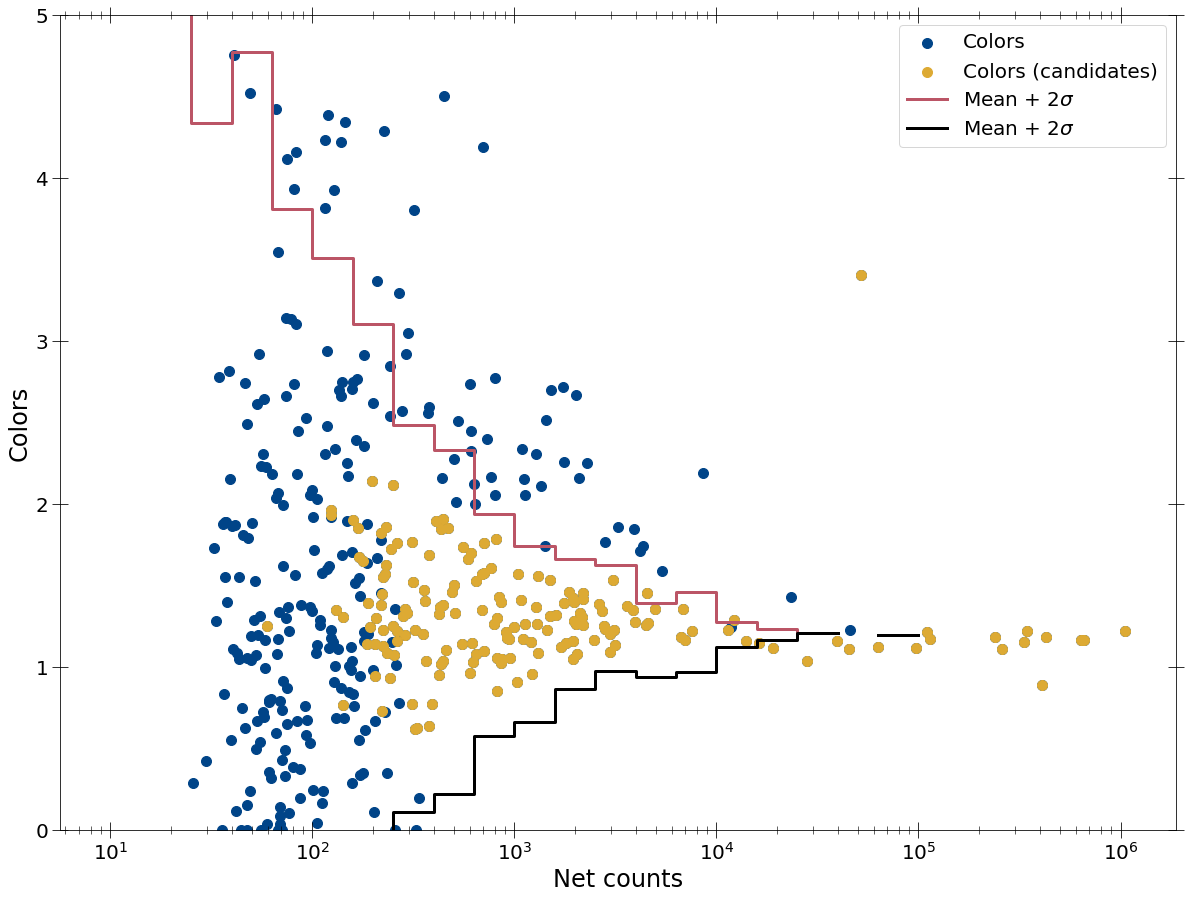

2:80: E501 line too long (83 > 79 characters)


In [233]:
mark_interested_srcs(sim_color_dict_arr[1], obs_color_dict_arr[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     interested_srcs_alldet2[1], 0)

In [182]:
len(interested_srcs_alldet[1])

205

(array([  22,   90,  107,  130,  133,  141,  143,  163,  165,  169,  182,
        183,  184,  196,  209,  212,  223,  226,  230,  234,  246,  280,
        296,  298,  303,  308,  314,  321,  327,  328,  366,  387,  389,
        394,  402,  455,  456,  458,  474,  552,  590,  596,  597,  609,
        624,  643,  652,  669,  691,  744,  748,  763,  766,  791,  803,
        806,  820,  859,  866,  895,  907,  954,  966,  975,  983, 1001,
       1035, 1053, 1056, 1073, 1075, 1079, 1097, 1151, 1163, 1179, 1187,
       1193, 1200, 1218, 1221, 1222, 1230, 1248, 1250, 1251, 1259, 1279,
       1289, 1329, 1339, 1340, 1345, 1350, 1354, 1362, 1367, 1375, 1381,
       1390, 1408, 1418, 1419, 1420, 1444, 1459, 1469, 1474, 1486, 1489,
       1499, 1500, 1515, 1525, 1527, 1528, 1537, 1541, 1544, 1545, 1547,
       1553, 1555, 1562, 1563, 1573, 1582, 1586, 1597, 1602, 1609, 1612,
       1618, 1633, 1649, 1659, 1666, 1672, 1675, 1703, 1705, 1706, 1710,
       1761, 1769, 1771, 1774, 1820, 1829, 1832, 1

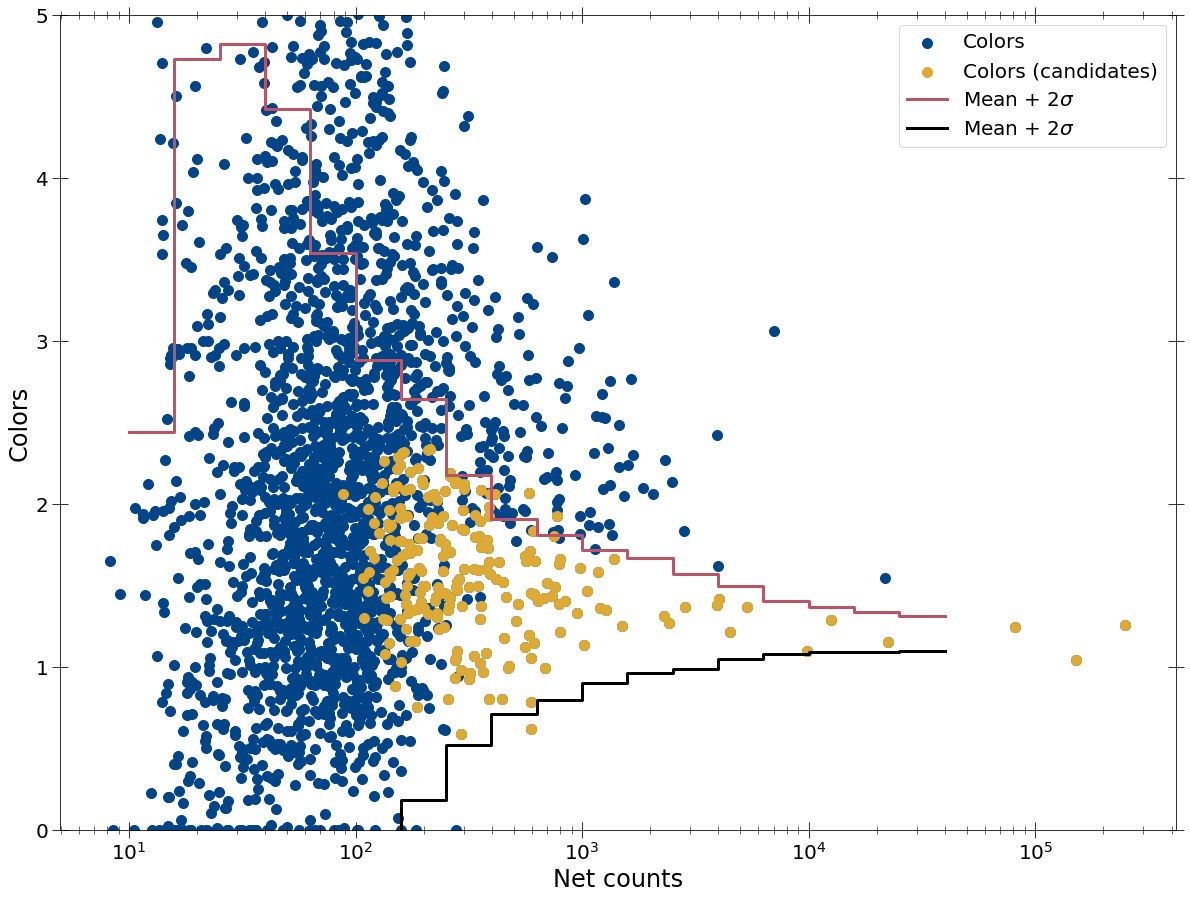

2:80: E501 line too long (83 > 79 characters)


In [234]:
mark_interested_srcs(sim_color_dict_arr[2], obs_color_dict_arr[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     interested_srcs_alldet2[2], 0)

In [28]:
source_nums = np.loadtxt('Interested_sources.txt', dtype='object')

(array([ 24,  38,  43,  50,  75,  91,  98, 111, 121, 127, 140, 152, 187,
       191, 192, 195, 206, 211, 213, 223, 229, 240, 273, 308, 309, 311,
       441, 464, 465, 467, 481, 483]),)


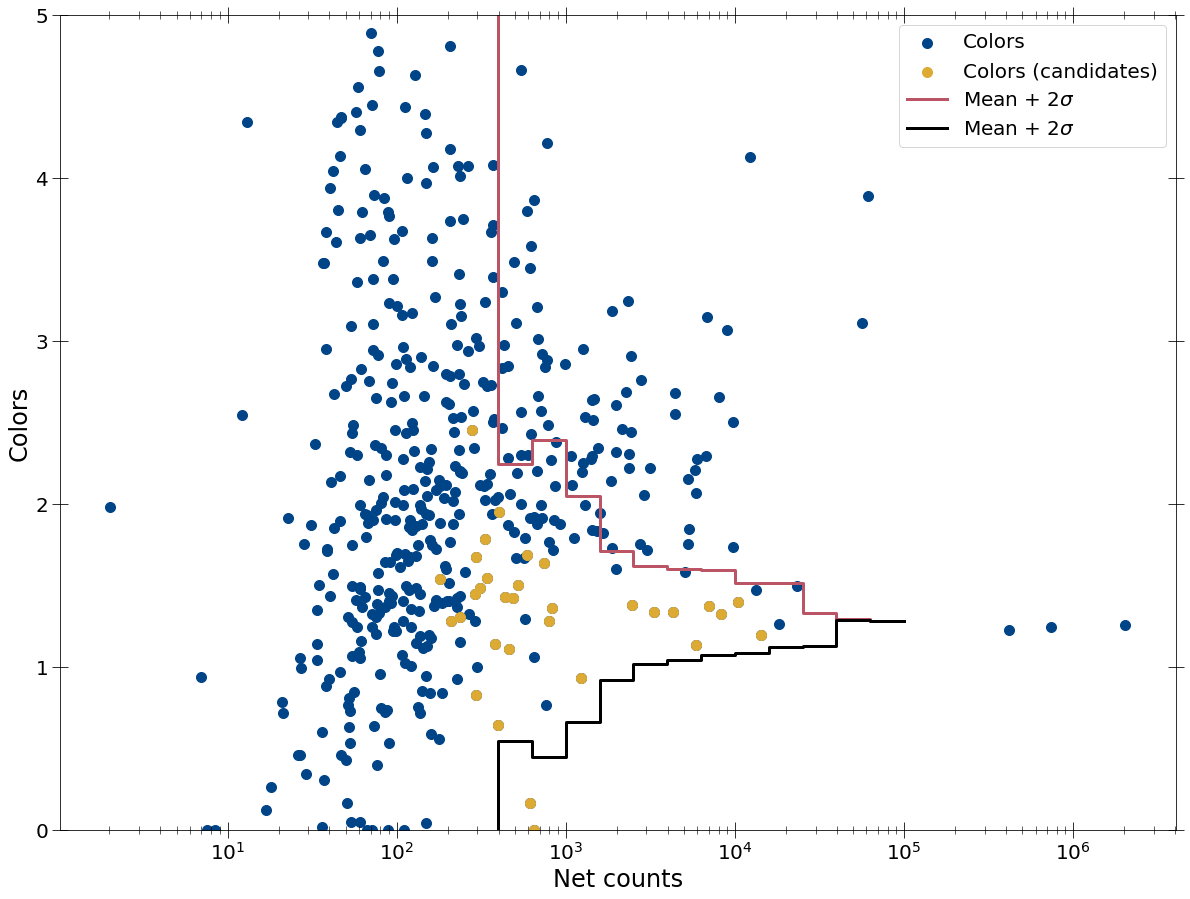

2:80: E501 line too long (83 > 79 characters)


In [29]:
mark_interested_srcs(sim_color_dict_arr[0], obs_color_dict_arr[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     source_nums, 0)

(array([ 16,  24,  29,  33,  55,  66,  72,  84,  93,  97, 103, 119, 122,
       123, 125, 134, 137, 139, 157, 171, 183, 184, 185, 220, 224, 225,
       226, 229, 231]),)


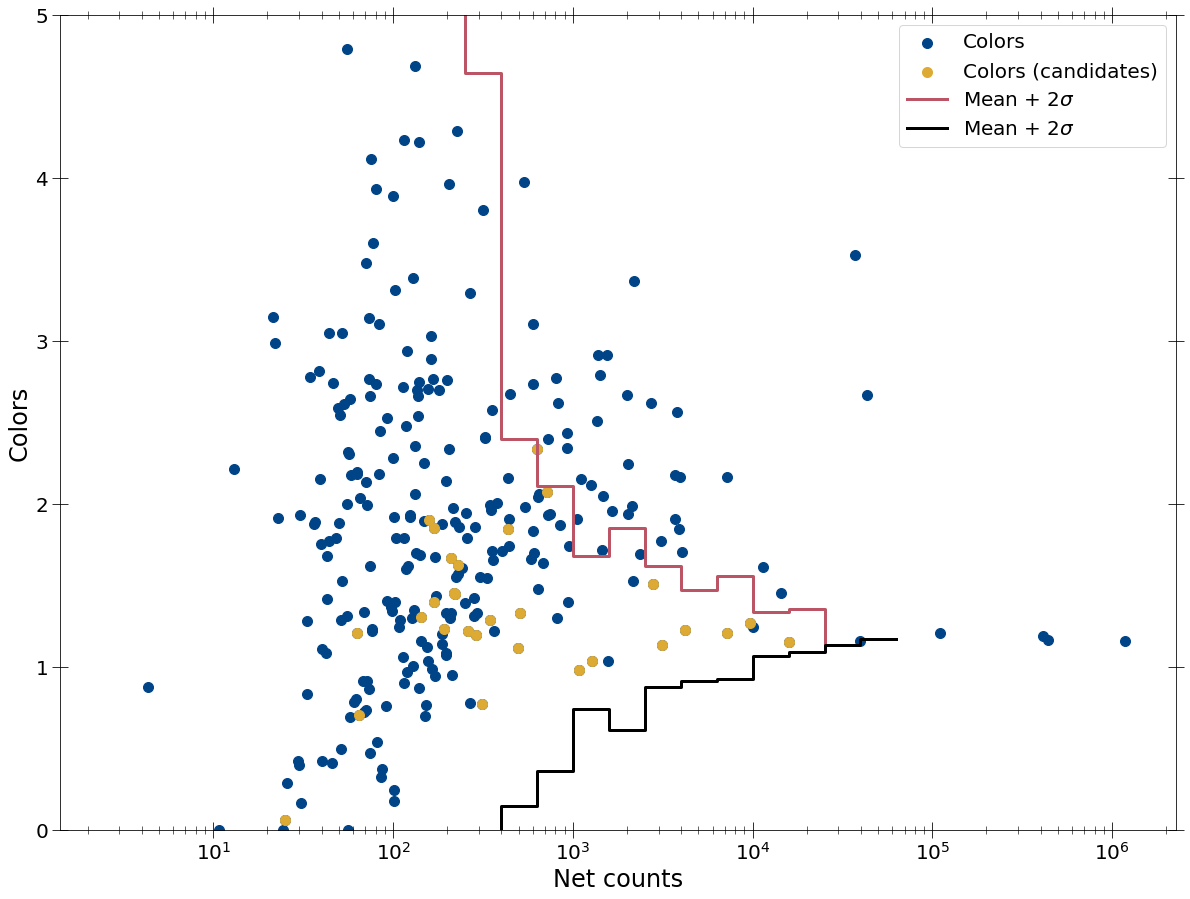

2:80: E501 line too long (83 > 79 characters)


In [30]:
mark_interested_srcs(sim_color_dict_arr[1], obs_color_dict_arr[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     source_nums, 0)

# Checking for low norm sources

## def unmask_arr(masked_values, mask, filler=-100.0):
    unmasked_arr = np.ones(len(mask), dtype=float)*filler
    unmasked_arr[mask] = masked_values
    return unmasked_arr

In [23]:
print('MOS sources not detected in PN')
mos_not_pn = []
for src in interested_srcs_alldet[1]:
    if src not in interested_srcs_alldet[0]:
        mos_not_pn.append(src)
        print('Source: ', src)
        arg = np.where(spec_summary['src_nums'][0] == src)[0]
        print('Net counts (PN): ', spec_summary['counts'][0][0][1][arg])
        print('Net counts (MOS): ', spec_summary['counts'][0][1][1][arg])
        print('Bg counts (PN): ', spec_summary['counts'][1][0][1][arg])
        print('Bg counts (MOS): ', spec_summary['counts'][1][1][1][arg])
        print('Mask (PN): ', spec_summary['spec_masks'][1][3][arg])
        print('Mask (MOS): ', spec_summary['spec_masks'][1][4][arg])
        print('Color (PN): ', unmask_arr(obs_color_dict_arr[0]['colors'], spec_summary['spec_masks'][1][3])[arg])
        print('Color (MOS): ', unmask_arr(obs_color_dict_arr[1]['colors'], spec_summary['spec_masks'][1][4])[arg])

MOS sources not detected in PN
Source:  201129705010014
Net counts (PN):  [1984.88629568]
Net counts (MOS):  [608.05064636]
Bg counts (PN):  [2078.11370432]
Bg counts (MOS):  [524.94935364]


IndexError: list index out of range

14:80: E501 line too long (113 > 79 characters)


In [395]:
print('PN sources not detected in MOS')
pn_not_mos = []
for src in interested_srcs_alldet[0]:
    if src not in interested_srcs_alldet[1]:
        pn_not_mos.append(src)
        print('Source: ', src)
        arg = np.where(spec_summary['src_nums'][0] == src)[0]
        print('Net counts (PN): ', spec_summary['counts'][0][0][1][arg])
        print('Net counts (MOS): ', spec_summary['counts'][0][1][1][arg])
        print('Bg counts (PN): ', spec_summary['counts'][1][0][1][arg])
        print('Bg counts (MOS): ', spec_summary['counts'][1][1][1][arg])
        print('Mask (PN): ', spec_summary['spec_masks'][1][3][arg])
        print('Mask (MOS): ', spec_summary['spec_masks'][1][4][arg])
        print('Color (PN): ', unmask_arr(obs_color_dict_arr[0]['colors'], spec_summary['spec_masks'][1][3])[arg])
        print('Color (MOS): ', unmask_arr(obs_color_dict_arr[1]['colors'], spec_summary['spec_masks'][1][4])[arg])

PN sources not detected in MOS
Source:  201113501010066
Net counts (PN):  [569.59489915]
Net counts (MOS):  [77.06422098]
Bg counts (PN):  [1054.40510085]
Bg counts (MOS):  [132.93577902]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [1.67109356]
Color (MOS):  [3.60388168]
Source:  201113501010154
Net counts (PN):  [404.91355624]
Net counts (MOS):  [169.29402981]
Bg counts (PN):  [769.08644376]
Bg counts (MOS):  [251.70597019]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [1.95526699]
Color (MOS):  [1.4032798]
Source:  201129701010015
Net counts (PN):  [452.26180445]
Net counts (MOS):  [80.75597502]
Bg counts (PN):  [476.73819555]
Bg counts (MOS):  [149.24402498]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [1.87554681]
Color (MOS):  [2.73833179]
Source:  201129704010011
Net counts (PN):  [465.79990524]
Net counts (MOS):  [287.22584027]
Bg counts (PN):  [836.20009476]
Bg counts (MOS):  [147.77415973]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [2.0655

14:80: E501 line too long (113 > 79 characters)


In [396]:
len(mos_not_pn)

18

In [397]:
len(pn_not_mos)

37

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:486: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:487: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:573: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:574: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

8.0


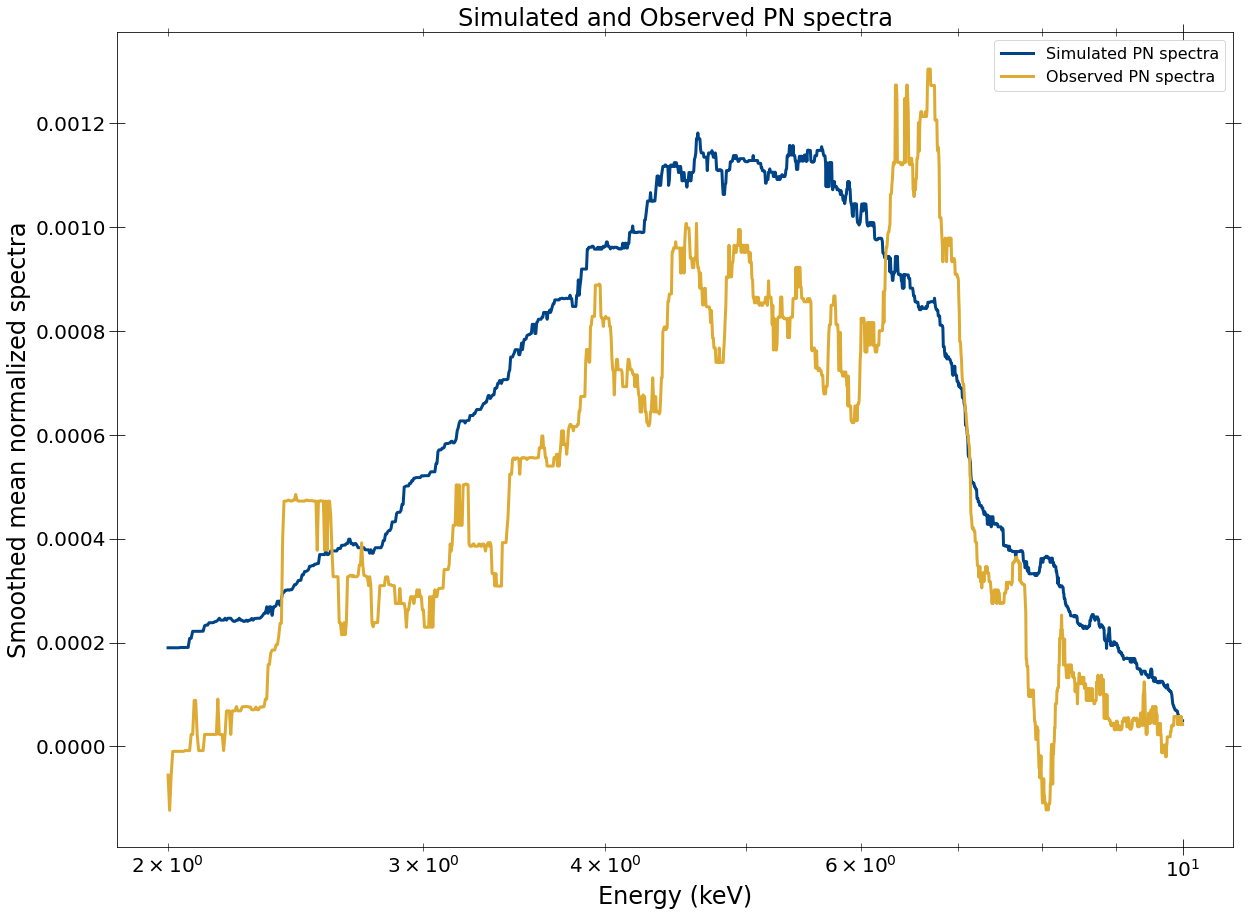

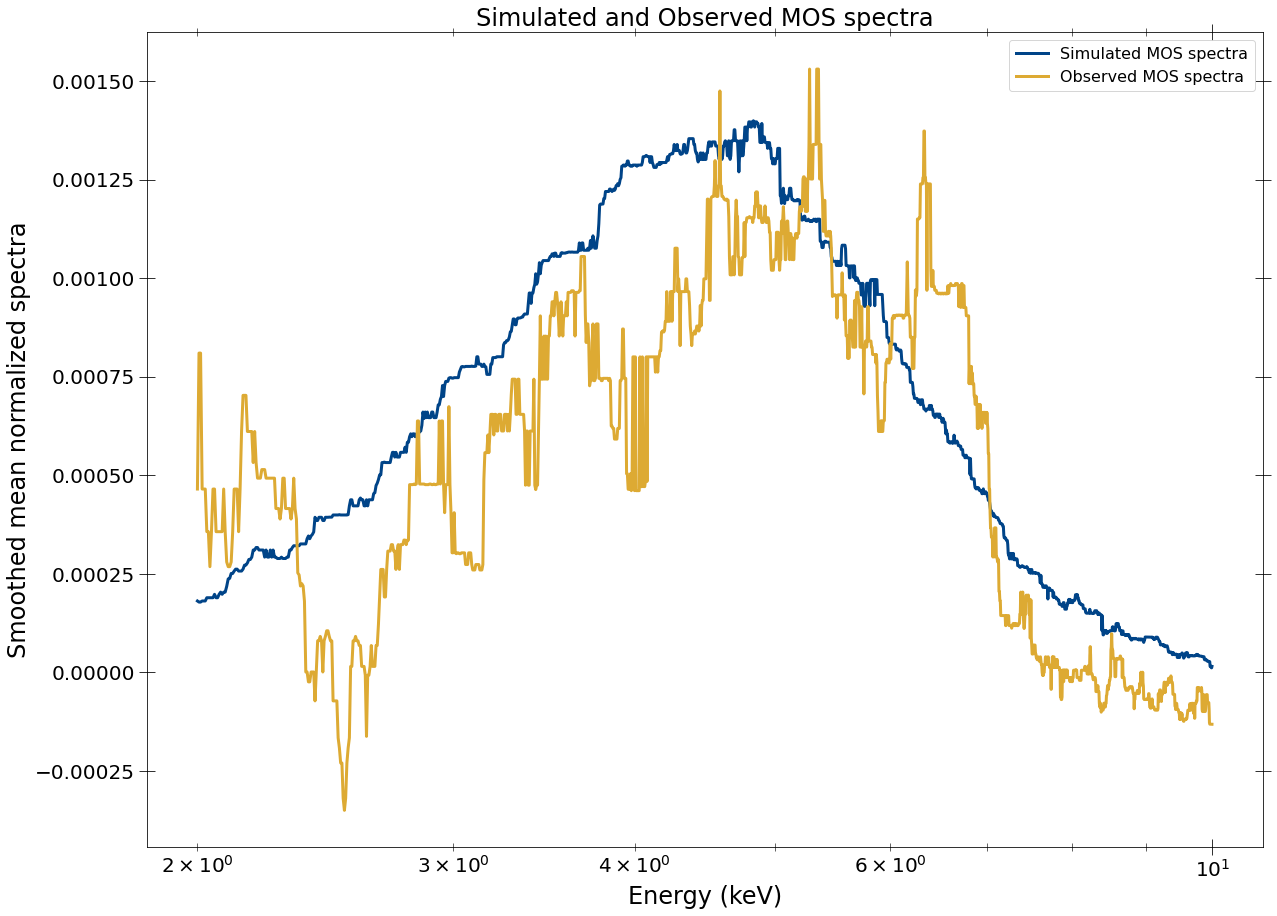

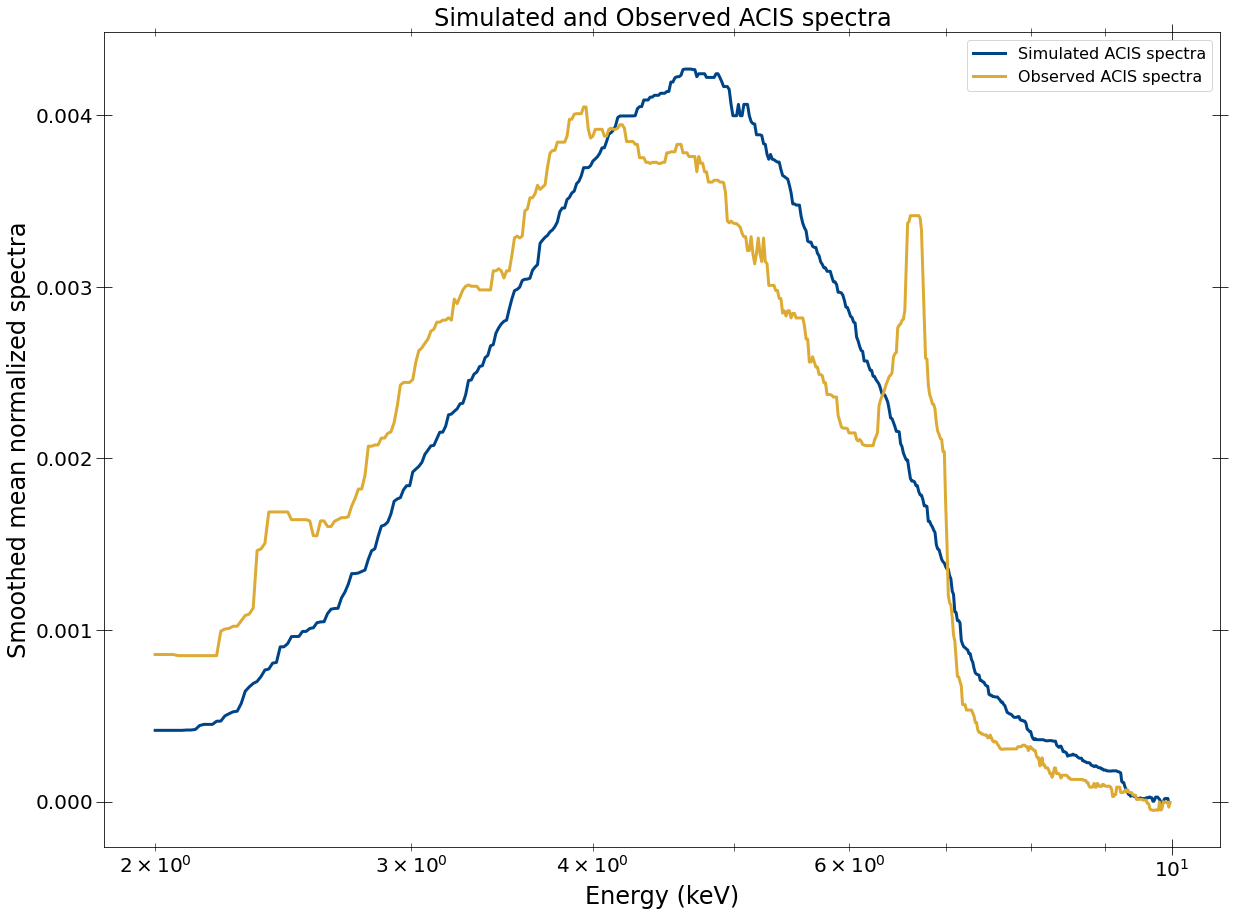

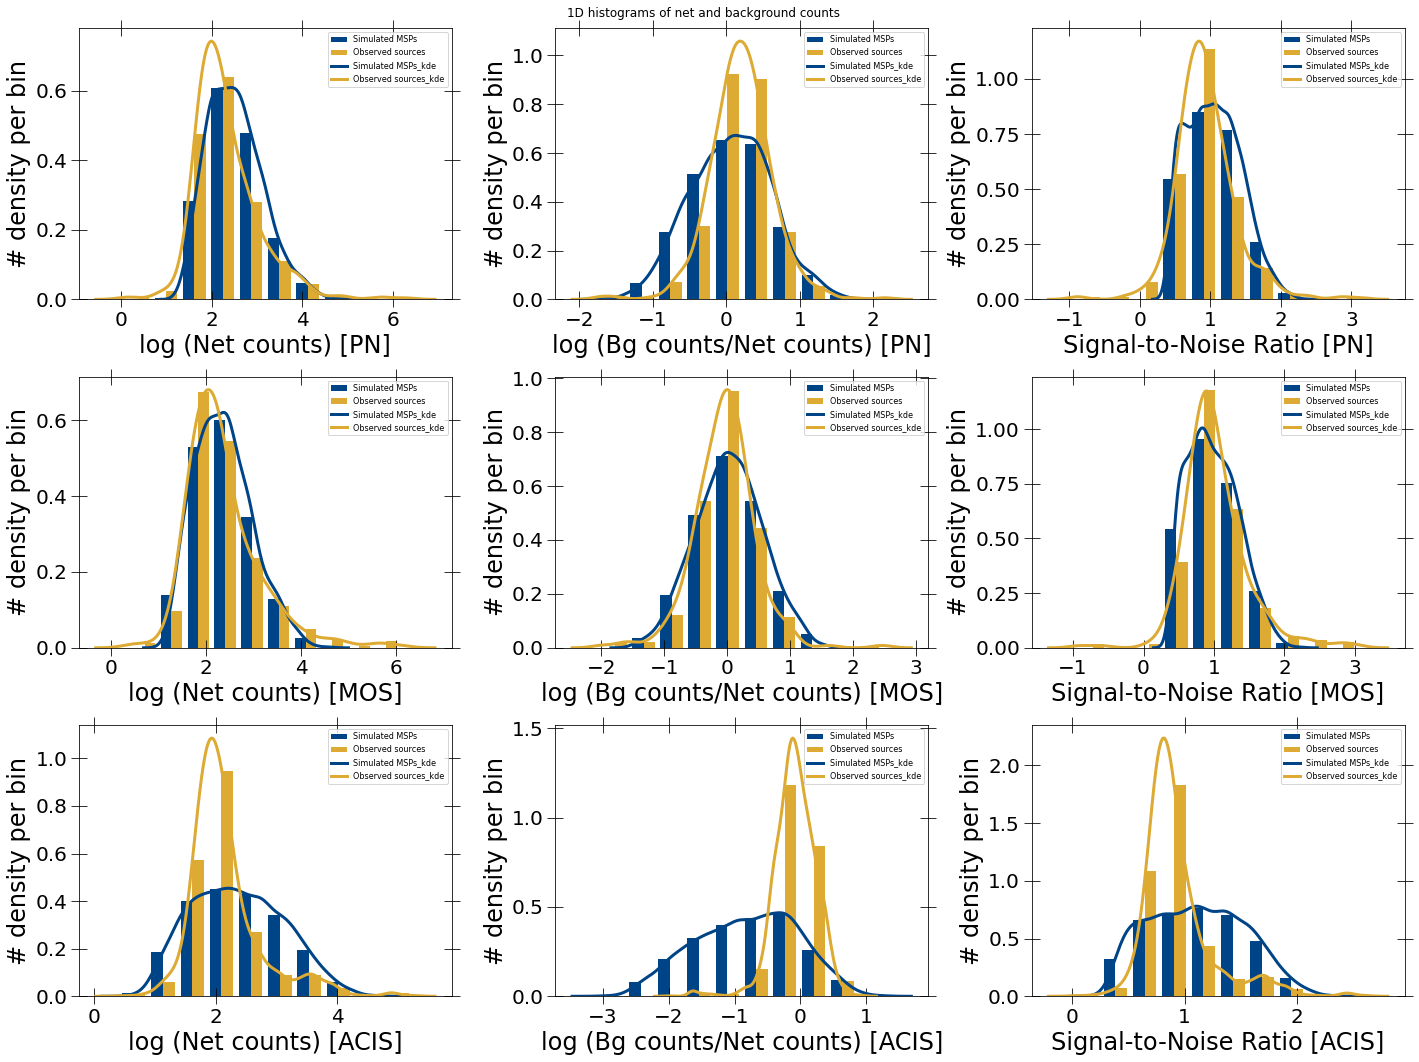

In [340]:
spec_summary = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path, xmm_sim_path, chandra_sim_path],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path], en_range=[2, 10])

In [17]:
def fit_src_pl_gauss(source_num, src_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    xspec.Xset.parallel.error = 4
    xspec.Xset.parallel.goodness = 4
    if telescope == 'XMM':
        spec_pnfile = glob2.glob(src_folder +
                                 str(source_num) + '_PN_combined_src_grp1*')
        spec_mosfile = glob2.glob(src_folder +
                                  str(source_num) + '_MOS_combined_src_grp1*')
        if len(spec_pnfile) > 0:
            spec_pn = xspec.Spectrum(spec_pnfile[0])
            spec_pn.ignore('0.0-2.0, 10.0-**')
        if len(spec_mosfile) > 0:
            spec_mos = xspec.Spectrum(spec_mosfile[0])
            spec_mos.ignore('0.0-2.0, 10.0-**')
    elif telescope == 'Chandra':
        os.chdir(src_folder + '/' + source_num)
        spec_file = str(source_num) + '_combined_src_grp1.pi'
        spec = xspec.Spectrum(spec_file)
        spec.ignore('0.0-2.0, 10.0-**')
        spec.notice('2.0-10.0')
    else:
        print('Telescope not recognized.')
    
    model = xspec.Model('tbabs*(pegpwrlw+gauss)')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    model.pegpwrlw.eMin.values = '2.0'
    model.pegpwrlw.eMax.values = '10.0'
    model.gaussian.LineE.values = '6.7, 0.0001, 6.1, 6.1, 7.3, 7.3'
    model.gaussian.Sigma.values = '0.1 0'
    model.gaussian.norm.values = '1.0E-5, 0.001,,,,'
    
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.query = 'yes'
    xspec.Fit.perform()
    xspec.Fit.error('2.706 6')
    xspec.Fit.perform()
    xspec.Fit.error('2.706 8')
    xspec.Fit.perform()
    xspec.Fit.error('2.706 6')
    xspec.Fit.error('2.706 8')
    goodness = xspec.Fit.goodness(1000)
    #goodness = 50.0
    line_pos_low = xspec.AllModels(1).gaussian.LineE.error[0]
    line_pos_high = xspec.AllModels(1).gaussian.LineE.error[1]
    line_norm_low = xspec.AllModels(1).gaussian.norm.error[0]
    line_norm_high = xspec.AllModels(1).gaussian.norm.error[1]
    print('Model params for ' + source_num +
          ': NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0],
          ' Fe_pos:', xspec.AllModels(1).gaussian.LineE.values[0],
          line_pos_low, line_pos_high,
          ' Fe_norm:', xspec.AllModels(1).gaussian.norm.values[0],
          line_norm_low, line_norm_high)
    print('Fit stats for ' + source_num + ': ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    os.chdir(curr_dir)
    return ([source_num, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [source_num, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0],
             xspec.AllModels(1).gaussian.LineE.values[0], line_pos_low,
             line_pos_high,
             xspec.AllModels(1).gaussian.norm.values[0], line_norm_low,
             line_norm_high])


27:1: W293 blank line contains whitespace
36:1: W293 blank line contains whitespace
49:5: E265 block comment should start with '# '
66:80: E501 line too long (80 > 79 characters)


In [18]:
def fit_src_pl(source_num, src_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    xspec.Xset.parallel.error = 4
    xspec.Xset.parallel.goodness = 4
    if telescope == 'XMM':
        spec_pnfile = glob2.glob(src_folder +
                                 str(source_num) + '_PN_combined_src_grp1*')
        spec_mosfile = glob2.glob(src_folder +
                                  str(source_num) + '_MOS_combined_src_grp1*')
        if len(spec_pnfile) > 0:
            spec_pn = xspec.Spectrum(spec_pnfile[0])
            spec_pn.ignore('0.0-2.0, 10.0-**')
        if len(spec_mosfile) > 0:
            spec_mos = xspec.Spectrum(spec_mosfile[0])
            spec_mos.ignore('0.0-2.0, 10.0-**')
    elif telescope == 'Chandra':
        os.chdir(src_folder + '/' + source_num)
        spec_file = str(source_num) + '_combined_src_grp1.pi'
        spec = xspec.Spectrum(spec_file)
        spec.ignore('0.0-2.0, 10.0-**')
        spec.notice('2.0-10.0')
    else:
        print('Telescope not recognized.')

    model = xspec.Model('tbabs*pegpwrlw')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.perform()
    xspec.Fit.error('2.706 2')
    xspec.Fit.perform()
    print('Calculating goodness')
    goodness = xspec.Fit.goodness(1000)
    print('Finished calculating goodness')
    #goodness = 50.0
    print('Model params for ' + source_num +
          ': NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0])
    print('Fit stats for ' + source_num + ': ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    if telescope == 'Chandra':
        os.chdir(curr_dir)
    return ([source_num, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [source_num, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0]])

40:5: E265 block comment should start with '# '
50:80: E501 line too long (80 > 79 characters)


In [358]:
fit_src_pl_gauss(interested_srcs_alldet[2][1], src_folder='.', telescope='Chandra')

Model params for 2CXOJ174405.3-292031: NH =  13.531164670649881  Gamma:  2.5445926815308217e-05  norm:  0.1468500637295036  Fe_pos: 7.090349296508933 6.596165307166636 0.0  Fe_norm: 6.413684010639694e-07 0.0 1.5322175172803025e-06
Fit stats for 2CXOJ174405.3-292031:  144.50499411378615 -7.643067628929242 59.7 158




(['2CXOJ174405.3-292031', 144.50499411378615, -7.643067628929242, 59.7, 158],
 ['2CXOJ174405.3-292031',
  13.531164670649881,
  2.5445926815308217e-05,
  0.1468500637295036,
  7.090349296508933,
  6.596165307166636,
  0.0,
  6.413684010639694e-07,
  0.0,
  1.5322175172803025e-06])

In [19]:
xspec.AllData.clear()
os.chdir('/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/xmm_combined_copy/')

In [240]:
import xspec

In [20]:
os.getcwd()

'/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/xmm_combined_copy'

In [23]:
pn_fit_stats_table_pl_g = []
pn_model_params_table_pl_g = []
pn_fit_stats_table_pl_g2 = []
pn_model_params_table_pl_g2 = []

for source_num in interested_srcs_alldet[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    pn_fit_stats_table_pl_g.append(fit_stats)
    pn_model_params_table_pl_g.append(model_params)
    pn_fit_stats_table_pl_g2.append(fit_stats2)
    pn_model_params_table_pl_g2.append(model_params2)

201129701010028
Model params for 201129701010028: NH =  13.097084536170286  Gamma:  2.5858762385188184e-06  norm:  0.08912003605196513  Fe_pos: 6.474423234580325 0.0 0.0  Fe_norm: 2.0934793463780414e-07 0.0 6.382487907458613e-07
Fit stats for 201129701010028:  381.9832202833417 -7.162187552303184 65.9 451


Model params for 201129701010028: NH =  12.007346566817  Gamma:  1.4788852592113402e-06  norm:  0.0837985504129848  Fe_norms: 1.896635561391661e-07 0.0 4.5786793411885067e-07 1.5786614326792382e-08 0.0 2.8053098469219676e-07 1.7494188878824568e-07 0.0 4.7671676973729557e-07
Fit stats for 201129701010028:  380.6568070309431 -7.092361763801753 56.7 450


201129701010051
Model params for 201129701010051: NH =  0.10000000000015803  Gamma:  1.2594627700780238e-06  norm:  0.13759564118469814  Fe_pos: 6.58273385663705 6.43622524986314 6.71692219852442  Fe_norm: 6.124128251094354e-07 9.324075071245871e-08 1.2426457647930034e-06
Fit stats for 201129701010051:  306.8565340109393 -6.2580167293

Model params for 201529201010020: NH =  11.075912849372365  Gamma:  2.1647182507545883  norm:  0.3646935199493776  Fe_pos: 6.461866058879345 6.3021548890930985 6.677540239392005  Fe_norm: 1.4590830413766418e-06 2.191319262841693e-07 2.9380289677518157e-06
Fit stats for 201529201010020:  707.739092245117 -5.570505674294565 99.9 870


Model params for 201529201010020: NH =  10.998369279888607  Gamma:  2.143281475319243  norm:  0.3642379178704127  Fe_norms: 1.0023775785476283e-06 4.572380382352661e-08 2.1789688782804617e-06 3.697253388952026e-07 0.0 1.4427837748519277e-06 7.812794993765397e-16 0.0 9.187395702873156e-07
Fit stats for 201529201010020:  708.2181067511231 -5.5692226925082196 99.9 869


202026708010341
Model params for 202026708010341: NH =  14.397107653650105  Gamma:  0.587409713745836  norm:  0.043113722435899615  Fe_pos: 6.920001373482395 6.771199312638482 7.134713351783259  Fe_norm: 4.381835316453988e-07 2.0791971538374454e-07 1.3223833380483268e-06
Fit stats for 202026708

Model params for 206746007010035: NH =  16.763169506153996  Gamma:  2.41548015432351  norm:  0.1234791043198554  Fe_pos: 6.83018319020404 6.662195474127227 7.027301334892729  Fe_norm: 6.085688557218021e-07 7.411770221436827e-08 1.2747650789710562e-06
Fit stats for 206746007010035:  567.0126941959309 -7.106393368269448 48.8 648


Model params for 206746007010035: NH =  16.3827611575693  Gamma:  2.318052563741459  norm:  0.12145750568147408  Fe_norms: 4.17151207601873e-13 0.0 3.656085421129572e-07 3.037953288665369e-07 0.0 8.215457700457435e-07 2.3501747055829975e-07 0.0 7.097680235722068e-07
Fit stats for 206746007010035:  568.3419432082258 -7.00698592481935 57.4 647


206946401010024
Model params for 206946401010024: NH =  11.626257351750834  Gamma:  1.8927958408333811  norm:  0.7655569773667352  Fe_pos: 7.084203392120934 0.0 0.0  Fe_norm: 2.776984744512909e-06 0.0 6.94433550413257e-06
Fit stats for 206946401010024:  278.7977883777365 -8.541755939152509 14.6 331


Model params for 2069

Model params for 206946410010046: NH =  18.497062663569384  Gamma:  2.3046704918654997  norm:  0.41677579482785765  Fe_pos: 7.033710781093285 6.895041801876328 7.18721311471324  Fe_norm: 1.5648615747135075e-06 2.635867846471192e-07 3.284883263028549e-06
Fit stats for 206946410010046:  197.72014482477564 -6.75450080957954 99.4 245


Model params for 206946410010046: NH =  16.179979428414214  Gamma:  1.8759969503540264  norm:  0.38098413362359385  Fe_norms: 2.088333063461036e-19 0.0 4.774060550642757e-07 7.869641367696204e-21 0.0 3.682416754551822e-07 6.988580001525056e-07 0.0 2.1433435668918145e-06
Fit stats for 206946410010046:  200.4515163006207 -6.897935012237249 95.7 244


206946410015051
Model params for 206946410015051: NH =  3.954805669055259  Gamma:  0.3043344726332815  norm:  0.2802152975997205  Fe_pos: 6.2530087146224265 0.0 0.0  Fe_norm: 6.406162825947443e-07 0.0 1.7639423261037003e-06
Fit stats for 206946410015051:  235.02387141850716 -6.731306460584899 96.6 223


Model para

Model params for 208016812010006: NH =  5.439498283534799  Gamma:  1.42442833832726  norm:  0.14103828007619562  Fe_norms: 4.3814113747102933e-13 0.0 4.015422131020668e-07 8.626489086070551e-08 0.0 5.60733972209138e-07 1.5958346039339866e-07 0.0 6.737450623734636e-07
Fit stats for 208016812010006:  197.024301371668 -8.63249421613247 13.7 229


208016813010013
Model params for 208016813010013: NH =  6.112110235249915  Gamma:  0.33826132113416424  norm:  0.24997846522005568  Fe_pos: 6.299823774062063 0.0 6.516223994444261  Fe_norm: 8.971155076469211e-07 2.145134611847787e-07 1.7091670491240618e-06
Fit stats for 208016813010013:  342.4004105870342 -8.852621035838617 13.5 383


Model params for 208016813010013: NH =  7.072862918863092  Gamma:  0.5805829165376867  norm:  0.2375275164226905  Fe_norms: 7.004824807401109e-07 1.749525894929774e-07 1.3645435480405714e-06 3.722585845946219e-07 0.0 1.0406942719793985e-06 8.552810154056525e-07 2.459885689407923e-07 1.6350447922110356e-06
Fit stats 

Model params for 208624701010019: NH =  8.341654542266033  Gamma:  1.3265138932686649  norm:  0.5143698195593963  Fe_norms: 1.9722958542367614e-07 0.0 2.209871232408758e-06 2.5326396708462073e-07 0.0 2.273855460691294e-06 5.311561366510063e-07 0.0 2.6855969008714236e-06
Fit stats for 208624701010019:  230.15900881819584 -7.564501762919066 51.3 276


208860102010003
Model params for 208860102010003: NH =  5.559937722365371  Gamma:  0.3953619450517863  norm:  0.3664049373346843  Fe_pos: 6.248248598188749 0.0 6.465607190984739  Fe_norm: 1.6559689957187627e-06 2.3206153892152896e-07 3.444851157166964e-06
Fit stats for 208860102010003:  185.33424337243284 -7.993127827144522 52.7 192


Model params for 208860102010003: NH =  5.765421142530239  Gamma:  0.37822039571154964  norm:  0.37943387774047876  Fe_norms: 1.0281541033839706e-06 0.0 2.5203855411301936e-06 3.45410649302244e-19 0.0 5.791275123546543e-07 7.223043659017239e-08 0.0 1.426121940338027e-06
Fit stats for 208860102010003:  187.1206

Model params for 201129704010023: NH =  15.47960216080798  Gamma:  0.6254523908410454  norm:  0.12431672315359538  Fe_pos: 6.473126160572492 6.368551449223438 6.590403144385391  Fe_norm: 7.06795894111905e-07 3.3377778838888583e-07 1.1356233418290325e-06
Fit stats for 201129704010023:  619.5281698994357 -5.225436163305506 99.9 803


Model params for 201129704010023: NH =  15.7838526846954  Gamma:  0.7053913031216026  norm:  0.12267948411970372  Fe_norms: 4.759961090938851e-07 1.893064873642923e-07 8.155201573821485e-07 2.342768493265292e-07 0.0 5.716073881379695e-07 1.502736762890054e-07 0.0 4.671357373202433e-07
Fit stats for 201129704010023:  620.2988073038068 -5.241928051384405 100.0 802


201129704010026
Model params for 201129704010026: NH =  8.80030170425491  Gamma:  0.42270417738797805  norm:  0.13584352983553524  Fe_pos: 6.799882414096336 6.713381625659447 6.882199148475735  Fe_norm: 1.5714420629568415e-06 8.792469058498723e-07 2.3849615912456965e-06
Fit stats for 20112970401002

Model params for 202039301010054: NH =  15.562969868937945  Gamma:  1.1944088317704442  norm:  0.09625961246212432  Fe_norms: 8.871097799529074e-17 0.0 1.262033284561506e-07 2.0666124807867512e-07 2.3944759456024876e-08 4.179070778295271e-07 1.6245495187318868e-07 0.0 3.7011742642476417e-07
Fit stats for 202039301010054:  841.5560448334857 -4.902119193423535 100.0 1053


202039301010071
Model params for 202039301010071: NH =  30.899981775532535  Gamma:  5.743921469173435e-07  norm:  0.11901272567322531  Fe_pos: 6.572441371618643 0.0 0.0  Fe_norm: 2.4332412283747546e-07 0.0 5.552688342629499e-07
Fit stats for 202039301010071:  595.6221375126892 -6.105072030328843 97.5 689


Model params for 202039301010071: NH =  26.19288212187621  Gamma:  4.561611155646538e-07  norm:  0.10449575954566014  Fe_norms: 1.6879705731298523e-07 0.0 4.0075618200453154e-07 1.8354114975974623e-07 0.0 4.1646673669382257e-07 1.6547086986578794e-07 0.0 4.013293604774323e-07
Fit stats for 202039301010071:  592.96054

Model params for 206946410010178: NH =  7.854207589562675  Gamma:  0.894576061850593  norm:  0.08132735340201148  Fe_pos: 7.032296750322455 0.0 0.0  Fe_norm: 1.4333999116361332e-08 0.0 3.266199508037429e-07
Fit stats for 206946410010178:  518.9586949372285 -8.325896684315683 22.4 674


Model params for 206946410010178: NH =  8.007020669600154  Gamma:  0.9327153243933888  norm:  0.08096595446536593  Fe_norms: 1.8906905108421444e-15 0.0 8.633060007751529e-08 1.0330744043479698e-09 0.0 2.3438434507705652e-07 6.142954547794107e-08 0.0 3.0890609724153823e-07
Fit stats for 206946410010178:  518.7696747316327 -8.314830475164527 20.2 673


206946416010014
Model params for 206946416010014: NH =  8.445089349385004  Gamma:  3.1442382138619434  norm:  0.3346723743396027  Fe_pos: 6.344517583150406 0.0 0.0  Fe_norm: 3.407705170326605e-07 0.0 1.157683403823934e-06
Fit stats for 206946416010014:  536.2356242619048 -5.196650769920585 100.0 611


Model params for 206946416010014: NH =  8.148546422246481

Model params for 208860204010001: NH =  4.98493778846935  Gamma:  0.939188388969524  norm:  0.8824836781060639  Fe_pos: 6.543245049667211 6.461833700846944 6.6261780234352745  Fe_norm: 8.121918004545625e-06 4.5239834710984575e-06 1.234700347299879e-05
Fit stats for 208860204010001:  471.76582385536676 -5.872505150797124 99.9 535


Model params for 208860204010001: NH =  5.286151571461448  Gamma:  1.0219388602949866  norm:  0.8705234482827311  Fe_norms: 4.252405918899864e-06 1.7639479463903494e-06 7.342642579661903e-06 4.209216860707e-06 1.551773487783041e-06 7.564864570074047e-06 1.1670865483557618e-06 0.0 4.188733560765084e-06
Fit stats for 208860204010001:  472.6638925520565 -5.869490742575545 99.9 534


208860207010007
Model params for 208860207010007: NH =  8.561912304171413  Gamma:  1.0057053073431443  norm:  0.6605928608513832  Fe_pos: 6.511940295445864 6.425240225699455 6.604450665749181  Fe_norm: 4.4903733999259595e-06 2.5984995951943103e-06 6.582883811482649e-06
Fit stats for 

Model params for 201129707010057: NH =  19.798041509192736  Gamma:  0.1387486132804595  norm:  0.19732214271118867  Fe_norms: 5.0840338024915434e-17 0.0 1.2462031840540834e-07 1.5309350095670119e-18 0.0 2.2291476906777176e-07 3.822562212421026e-17 0.0 1.9764865064112848e-07
Fit stats for 201129707010057:  581.4976528837147 -6.948595836688409 98.4 737


201129708010018
Model params for 201129708010018: NH =  24.593156833570845  Gamma:  0.7447693049564779  norm:  0.45173709327489325  Fe_pos: 6.712459620874066 6.554953423258761 6.897006261331803  Fe_norm: 9.78848519612186e-07 2.2628683418426e-07 1.8228495954108933e-06
Fit stats for 201129708010018:  708.932785941752 -6.094039580623275 99.9 839


Model params for 201129708010018: NH =  24.85660026293856  Gamma:  0.7619627420727652  norm:  0.4548309256770543  Fe_norms: 3.635698604581175e-17 0.0 4.229126159223132e-07 6.988730644006618e-07 9.987066458820634e-08 1.390144841238328e-06 2.672644158589117e-07 0.0 9.2967795420567e-07
Fit stats for 

Model params for 205110012010053: NH =  13.800091126991033  Gamma:  1.9286794317960483  norm:  2.8424957192152465  Fe_norms: 1.8734684333714923e-12 0.0 2.7484853573521376e-06 8.156440360219818e-15 0.0 4.099691471505533e-06 2.0575987941517698e-10 0.0 4.112706895639929e-06
Fit stats for 205110012010053:  337.4415255762675 -7.758567947560132 97.8 409


205110012010055
Model params for 205110012010055: NH =  12.282562810231997  Gamma:  1.7173687817311398  norm:  2.9304390684188  Fe_pos: 7.3 7.210830052662242 0.0  Fe_norm: 6.581374497111288e-06 9.466171208341579e-07 1.3599473877208371e-05
Fit stats for 205110012010055:  365.8499182164831 -8.856332592159415 66.2 434


Model params for 205110012010055: NH =  11.3731872239794  Gamma:  1.5496210454377752  norm:  2.8713509550777623  Fe_norms: 1.1071459328595529e-06 0.0 5.462282883090116e-06 6.786522605183652e-08 0.0 4.192564824462104e-06 2.005767696281535e-13 0.0 2.668838930167763e-06
Fit stats for 205110012010055:  369.44440592967766 -9.1022425

Model params for 201129704010010: NH =  35.17188442992724  Gamma:  1.0895957452916305  norm:  0.2289851845735807  Fe_norms: 7.687596656325006e-07 4.82407563574623e-07 1.09311107449424e-06 4.2522037617279497e-07 1.478094259701833e-07 7.294335138941876e-07 2.7907568920222823e-07 1.2783834109747277e-08 5.728504223486773e-07
Fit stats for 201129704010010:  1462.21003646937 -8.246663067734104 64.4 1763


201129704010019
Model params for 201129704010019: NH =  25.131711655145956  Gamma:  0.52016005278107  norm:  0.16589693520437246  Fe_pos: 6.58330272478069 6.406062552458643 6.748330390853386  Fe_norm: 5.804263880326259e-07 2.2783416886691353e-07 9.655323768730653e-07
Fit stats for 201129704010019:  1289.8414416977184 -6.855043105403802 93.9 1423


Model params for 201129704010019: NH =  24.076278130162496  Gamma:  0.5759859829791723  norm:  0.15615635496866237  Fe_norms: 2.9724366742871984e-07 3.8509564015066174e-08 5.826975978758645e-07 3.454186450357798e-07 7.24806734974358e-08 6.49513418

Model params for 207234103010049: NH =  5.237668945124975  Gamma:  1.5113890258522523e-07  norm:  1.3097405177408048  Fe_pos: 6.7611235541254855 6.640705849418267 6.872559844774003  Fe_norm: 5.291285785603355e-06 2.4403151761664875e-06 8.524964537894733e-06
Fit stats for 207234103010049:  503.1534813330033 -7.339352082939445 97.0 659


Model params for 207234103010049: NH =  4.9027803939860375  Gamma:  1.4393159856052802e-05  norm:  1.2695043007053375  Fe_norms: 1.8505913428725285e-06 6.134515577448093e-08 3.9216393830039625e-06 3.613681513906773e-06 1.567019241413086e-06 6.035080923619997e-06 2.0800699171502707e-06 1.49993321632228e-07 4.401956608667775e-06
Fit stats for 207234103010049:  499.73996946156103 -7.555599174511799 96.7 658


207234103015041
Model params for 207234103015041: NH =  8.925283505841492  Gamma:  0.28697606060304676  norm:  2.3501686030022637  Fe_pos: 7.299999999999952 6.985028738949051 0.0  Fe_norm: 7.09722824258826e-06 2.9608446874172557e-06 1.1519619894431494e

Model params for 206946401010013: NH =  10.615453815897801  Gamma:  1.6443126442981533  norm:  2.227837254836741  Fe_pos: 6.331608745659266 0.0 0.0  Fe_norm: 2.75277375899565e-06 0.0 6.305713006483749e-06
Fit stats for 206946401010013:  772.0375360958518 -9.173100320720229 94.4 859


Model params for 206946401010013: NH =  10.641844462216323  Gamma:  1.6485062511743578  norm:  2.230686518164051  Fe_norms: 2.1042952881864313e-06 0.0 5.1072603239040835e-06 1.2399887925004114e-06 0.0 4.3953821772458245e-06 2.4042155980809413e-12 0.0 2.8952333041527005e-06
Fit stats for 206946401010013:  771.7423978289974 -9.105456909280054 95.1 858


206946409010002
Model params for 206946409010002: NH =  9.51008843315819  Gamma:  2.2541357280509606  norm:  2.0064674817506627  Fe_pos: 6.447056789487504 6.300687585525322 6.578342645921346  Fe_norm: 4.935879508442289e-06 1.637688952570642e-06 8.701996286597252e-06
Fit stats for 206946409010002:  717.7336678507119 -10.339158071583743 15.8 779


Model params 

Model params for 201529201010094: NH =  6.60307918905713  Gamma:  1.680164860251739  norm:  1.392041638575058  Fe_pos: 6.814100784233714 0.0 0.0  Fe_norm: 1.197526353637945e-06 0.0 2.719204317588524e-06
Fit stats for 201529201010094:  903.017004971931 -9.724050572215972 92.9 999


Model params for 201529201010094: NH =  6.72731023402895  Gamma:  1.7200799581776547  norm:  1.3871434983018505  Fe_norms: 7.033110832649345e-07 0.0 1.7599375768292383e-06 6.689327674105415e-07 0.0 1.8014030571722003e-06 7.030397940559147e-07 0.0 1.8623508118635265e-06
Fit stats for 201529201010094:  901.5004880580291 -9.725624896156752 94.0 998


202026707010271
Model params for 202026707010271: NH =  19.81616228781602  Gamma:  5.0  norm:  5.46101179549345  Fe_pos: 6.518196676760956 0.0 0.0  Fe_norm: 3.6732844999604494e-23 0.8224962005991274 0.0
Fit stats for 202026707010271:  860.2236774003702 -7.707607868710697 100.0 928


Model params for 202026707010271: NH =  19.863726388291084  Gamma:  5.0  norm:  5.49

Model params for 207901804010066: NH =  18.807918931877985  Gamma:  5.0  norm:  4.973258426421662  Fe_norms: 1.976980377478863e-22 0.8224962005991274 0.0 1.1588629482791923e-22 0.8224962005991274 0.0 2.395868602836693e-22 0.8224962005991274 0.0
Fit stats for 207901804010066:  761.6228954065682 -7.5959834319041155 100.0 811


207901804015015
Model params for 207901804015015: NH =  20.259133473192918  Gamma:  5.0  norm:  6.305964877705168  Fe_pos: 7.003874517860132 0.0 0.0  Fe_norm: 9.997328357789784e-23 0.8224962005991274 0.0
Fit stats for 207901804015015:  869.1797645089695 -7.2671777076169155 100.0 947


Model params for 207901804015015: NH =  20.25846253499322  Gamma:  5.0  norm:  6.305595752497505  Fe_norms: 2.2006103850274693e-22 0.8224962005991274 0.0 1.454178107450923e-22 0.8224962005991274 0.0 1.8899679133346076e-22 0.8224962005991274 0.0
Fit stats for 207901804015015:  869.1797569100023 -7.267563721482234 100.0 946


207901804015034
Model params for 207901804015034: NH =  20.88

Model params for 207234103010040: NH =  6.600768961380268  Gamma:  0.3905981439246614  norm:  4.140953272504823  Fe_pos: 7.0033337915205705 6.947913140188986 7.063380426796042  Fe_norm: 2.3189432323720637e-05 1.7769362342771932e-05 2.9003454510993532e-05
Fit stats for 207234103010040:  1378.1322394100334 -8.043313808887548 100.0 1297


Model params for 207234103010040: NH =  6.509382515546153  Gamma:  0.4036807734146533  norm:  4.064802187484505  Fe_norms: 3.0220285389723434e-06 3.3958573212837e-07 5.9737448574948244e-06 7.865614852736762e-06 4.533498066522284e-06 1.151235993862419e-05 1.5631724153116222e-05 1.1531467331939926e-05 2.0092587568035937e-05
Fit stats for 207234103010040:  1374.3301950831355 -8.299857415805397 100.0 1296


207234104010014
Model params for 207234104010014: NH =  4.911128880113902  Gamma:  4.896530650855125e-07  norm:  6.1182246801870654  Fe_pos: 6.856341207089568 6.7908560643664275 6.924257335664589  Fe_norm: 1.9901150089857573e-05 1.4146817269743473e-05 2.6

Model params for 207234103010014: NH =  11.571918138986463  Gamma:  1.0946730901476405  norm:  7.454600852861168  Fe_norms: 5.578404276729338e-06 1.7088639268679077e-06 9.791885382097558e-06 1.6064963640975454e-05 1.1294550287069153e-05 2.1218583804764777e-05 1.633419437168311e-05 1.1101245802555934e-05 2.201874869540047e-05
Fit stats for 207234103010014:  1562.9811805703534 -8.125189763890729 100.0 1315


207234104010017
Model params for 207234104010017: NH =  4.886240711040576  Gamma:  0.04991082060416591  norm:  9.06020102585513  Fe_pos: 7.249368628993179 7.176451374772983 0.0  Fe_norm: 1.924226155750177e-05 1.2362414278639891e-05 2.652745430646197e-05
Fit stats for 207234104010017:  1589.7706952140077 -8.848080639509302 100.0 1441


Model params for 207234104010017: NH =  4.577625398477278  Gamma:  0.013500907716713877  norm:  9.003827262370558  Fe_norms: 2.4539623254421984e-06 0.0 6.294480707809253e-06 7.507225644855954e-06 3.3817302391716896e-06 1.19338489480858e-05 7.73572140900

Model params for 207234103010035: NH =  8.373638775000543  Gamma:  0.7918083300386272  norm:  7.452410094297654  Fe_pos: 6.4909099197493685 6.424486189722204 6.559817025820205  Fe_norm: 2.2782064330065515e-05 1.8454312133803657e-05 2.7268663965214448e-05
Fit stats for 207234103010035:  1807.2598160175753 -8.159051587605887 100.0 1465


Model params for 207234103010035: NH =  8.769844517133272  Gamma:  0.9106557564900815  norm:  7.259582090067452  Fe_norms: 1.3763679020920236e-05 1.0706037161597452e-05 1.6984771340219024e-05 1.2594506542955095e-05 9.32160426990438e-06 1.605479531982373e-05 1.7783718246230994e-05 1.4094237148551985e-05 2.1691618646719484e-05
Fit stats for 207234103010035:  1723.5748379441352 -8.369496675734297 100.0 1464


208441011010001
Model params for 208441011010001: NH =  22.097892557625624  Gamma:  1.0190726721991168  norm:  16.301237398215893  Fe_pos: 6.30407978513899 0.0 0.0  Fe_norm: 2.9134331015998044e-06 0.0 7.693246407985344e-06
Fit stats for 208441011010001

In [243]:
pn_fit_stats_table2_pl_g = []
pn_model_params_table2_pl_g = []
pn_fit_stats_table2_pl_g2 = []
pn_model_params_table2_pl_g2 = []

for source_num in interested_srcs_alldet2[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    pn_fit_stats_table2_pl_g.append(fit_stats)
    pn_model_params_table2_pl_g.append(model_params)
    pn_fit_stats_table2_pl_g2.append(fit_stats2)
    pn_model_params_table2_pl_g2.append(model_params2)

200305401010049
Model params for 200305401010049: NH =  39.80595888401704  Gamma:  2.3825591994546134e-06  norm:  0.21361680758265583  Fe_pos: 6.100000111108822 0.0 0.0  Fe_norm: 3.06779052292325e-23 0.46326946953921294 0.0
Fit stats for 200305401010049:  331.47549413760163 -5.57881296425545 50.0 437


Model params for 200305401010049: NH =  24.438736445600597  Gamma:  1.7255975200034478e-06  norm:  0.13858239915107873  Fe_norms: 8.516062428125166e-21 0.0 3.444170365818164e-07 5.978606096270344e-07 0.0 1.3919180144732897e-06 6.108052249182213e-07 0.0 1.4395946490753204e-06
Fit stats for 200305401010049:  327.47359359882256 -6.03200922906665 50.0 436


201129701010051
Model params for 201129701010051: NH =  0.10000000000173763  Gamma:  1.2594627700780238e-06  norm:  0.13756465360305595  Fe_pos: 6.58273370665754 6.43622524986314 6.71692219852442  Fe_norm: 6.114755862461551e-07 9.324075071245871e-08 1.2426457647930034e-06
Fit stats for 201129701010051:  306.85672590498393 -6.2578305267910

Model params for 202026707010239: NH =  66.01119399784378  Gamma:  9.841147953495933e-05  norm:  0.06323665022633702  Fe_pos: 6.587005957450174 6.433280632269624 6.774816815447761  Fe_norm: 7.942884457293147e-07 1.764204819577287e-07 3.334755295854453e-06
Fit stats for 202026707010239:  848.6679086530474 -0.09193838408086667 50.0 1015


Model params for 202026707010239: NH =  74.37422718924367  Gamma:  0.07509599452052837  norm:  0.07649845764245573  Fe_norms: 2.7019295731909096e-07 0.0 1.7372335782386792e-06 3.936576931028525e-07 0.0 1.7681720342744087e-06 2.100291108781944e-15 0.0 3.206897415449207e-07
Fit stats for 202026707010239:  850.9452154831648 -0.09203282801898459 50.0 1014


202026708010117
Model params for 202026708010117: NH =  135.8489498021393  Gamma:  1.3071885067454876e-06  norm:  0.34171941479213636  Fe_pos: 6.139969988839689 0.0 0.0  Fe_norm: 2.026564270146005e-06 0.0 0.00025644280572002765
Fit stats for 202026708010117:  379.31421782597425 -3.635128490972496 50.0 44

Model params for 206556701010023: NH =  2.1270834826659266  Gamma:  2.505390338589546e-06  norm:  0.07251707791549934  Fe_pos: 6.557813169094284 6.479322648973209 6.635290379954195  Fe_norm: 6.914120104447882e-07 3.2032208431706496e-07 1.105381503088828e-06
Fit stats for 206556701010023:  770.028659732099 -5.842006357962617 50.0 907


Model params for 206556701010023: NH =  2.4458583510544054  Gamma:  1.4730520619281761e-07  norm:  0.07511148603302732  Fe_norms: 2.0222800055122265e-07 0.0 4.968472247899483e-07 1.930327210505575e-07 0.0 5.319874228207905e-07 1.8181029414489774e-07 0.0 5.522292049676187e-07
Fit stats for 206556701010023:  776.9391645937985 -5.858277949897014 50.0 906


206556701010040
Model params for 206556701010040: NH =  39.267335257721335  Gamma:  2.221091058235401  norm:  0.12681594908263072  Fe_pos: 6.923200564881908 0.0 0.0  Fe_norm: 3.246964938808722e-07 0.0 6.284873155092487e-07
Fit stats for 206556701010040:  858.6651904626445 -6.30228880242744 50.0 1102


Mode

Model params for 206946402010138: NH =  6.615287461677243  Gamma:  1.273079242861707  norm:  0.0785740866905896  Fe_pos: 6.163074972164117 0.0 7.196918721081235  Fe_norm: 2.6504235226373944e-07 0.0 5.814755880971426e-07
Fit stats for 206946402010138:  419.7954924868701 -6.4309899448586725 50.0 514


Model params for 206946402010138: NH =  7.038965950005619  Gamma:  1.3277537281022844  norm:  0.0804472548687927  Fe_norms: 2.1841421356677956e-08 0.0 2.823595294901373e-07 9.919303618460698e-08 0.0 3.782107862022948e-07 1.7057696279067852e-07 0.0 4.6166819580716564e-07
Fit stats for 206946402010138:  420.67132162483847 -6.518117447608181 50.0 513


206946404010105
Model params for 206946404010105: NH =  20.35914722009558  Gamma:  0.08794200758751608  norm:  0.12946510195886557  Fe_pos: 6.563031112125658 6.124769761468572 0.0  Fe_norm: 6.471151006785165e-07 0.0 1.519249074702212e-06
Fit stats for 206946404010105:  300.4134656784083 -5.951315868439392 50.0 349


Model params for 206946404010

Model params for 207641901010010: NH =  6.966433928941913  Gamma:  0.23352553712362822  norm:  0.20500201515126196  Fe_pos: 7.299999999699763 6.700517413061059 0.0  Fe_norm: 8.871815469333716e-07 1.2391972887974015e-07 1.853589796553659e-06
Fit stats for 207641901010010:  356.88825701159817 -7.315146152461581 50.0 435


Model params for 207641901010010: NH =  5.584923667551076  Gamma:  0.07124772805274578  norm:  0.20246397208911823  Fe_norms: 1.0936700637223285e-07 0.0 5.864642517171806e-07 2.6672803681815725e-07 0.0 8.185401334656552e-07 2.6634039825366583e-07 0.0 8.620476677970026e-07
Fit stats for 207641901010010:  358.87529932304 -7.30183244033844 50.0 434


207641901010014
Model params for 207641901010014: NH =  17.815842269150096  Gamma:  1.4169791329719932  norm:  0.21318169784954769  Fe_pos: 7.3 0.0 0.0  Fe_norm: 4.758234678664807e-07 0.0 1.3736820114295742e-06
Fit stats for 207641901010014:  275.11508938012537 -6.559737768127809 50.0 327


Model params for 207641901010014: NH

Model params for 208441011010009: NH =  1.2695414140107382  Gamma:  1.0536247034338173  norm:  0.35466225933541756  Fe_pos: 6.432624320369774 0.0 0.0  Fe_norm: 2.4762016456785645e-07 0.0 1.4210372706082378e-06
Fit stats for 208441011010009:  294.2073491791614 -7.8395790979769835 50.0 371


Model params for 208441011010009: NH =  1.2868901817658809  Gamma:  1.0592237482221267  norm:  0.35426059504130303  Fe_norms: 2.667065157521264e-07 0.0 1.2434105584824897e-06 1.1670327231228508e-08 0.0 9.672209467692376e-07 6.323019823215546e-11 0.0 6.876217854749685e-07
Fit stats for 208441011010009:  294.0814906869676 -7.8413349644011765 50.0 370


208441011010032
Model params for 208441011010032: NH =  2.041467668945232  Gamma:  0.7192569850985779  norm:  1.0208480795287638  Fe_pos: 7.002399355950746 0.0 0.0  Fe_norm: 1.9256852361294383e-06 0.0 6.719554309635833e-06
Fit stats for 208441011010032:  305.41624492881783 -7.970791590850964 50.0 333


Model params for 208441011010032: NH =  1.9479979617

Model params for 200305401015015: NH =  6.102124233831839  Gamma:  0.7141327534247249  norm:  0.17891718458002673  Fe_pos: 6.472152763664358 0.0 0.0  Fe_norm: 3.9330846708869585e-07 0.0 1.0704722053311355e-06
Fit stats for 200305401015015:  501.31167013964114 -7.651884856653909 50.0 640


Model params for 200305401015015: NH =  6.429024337387809  Gamma:  0.7945053270672161  norm:  0.17665077429030326  Fe_norms: 2.9731295600544286e-07 0.0 8.1226586465844e-07 1.4903775326507075e-07 0.0 7.1192333385351e-07 1.5297087700968577e-07 0.0 7.363728054955049e-07
Fit stats for 200305401015015:  500.9033339521037 -7.6351389958538665 50.0 639


201129701010028
Model params for 201129701010028: NH =  12.49224372699796  Gamma:  5.2057672439109515e-05  norm:  0.08726669835039214  Fe_pos: 6.476992838574023 0.0 0.0  Fe_norm: 2.27892815913404e-07 0.0 6.382487907458613e-07
Fit stats for 201129701010028:  382.01067074326465 -7.223521531186869 50.0 451


Model params for 201129701010028: NH =  11.99746478030

Model params for 201129719010007: NH =  5.537782473938883  Gamma:  1.969773561846617e-05  norm:  0.4543773087541724  Fe_pos: 6.4227007713327255 6.334931058717694 6.5132077632371175  Fe_norm: 2.0620480549144144e-06 9.69050049366608e-07 3.291114956780158e-06
Fit stats for 201129719010007:  617.8092342543231 -5.472747205121675 50.0 684


Model params for 201129719010007: NH =  5.078827097486471  Gamma:  0.000445851703893506  norm:  0.4371352222801319  Fe_norms: 1.7415519784195234e-06 8.972335741001697e-07 2.738165423102965e-06 7.432325632889041e-07 0.0 1.7237623404330379e-06 6.743272174535729e-07 0.0 1.7136151245701622e-06
Fit stats for 201129719010007:  612.3848261709473 -5.5015604975553485 50.0 683


201129719015024
Model params for 201129719015024: NH =  12.671285520888826  Gamma:  1.1399437801766041  norm:  0.1648783774555974  Fe_pos: 6.531170700236952 0.0 6.7025908620041275  Fe_norm: 9.557951518850644e-07 3.4105162973570485e-07 1.7028100151006047e-06
Fit stats for 201129719015024:  4

Model params for 205110002015026: NH =  3.5204108647043904  Gamma:  1.4775456928426658  norm:  0.06718613731500002  Fe_pos: 6.569093154405726 6.189564669055946 6.795764183958111  Fe_norm: 3.2618924392486383e-07 6.523673459600386e-08 6.273792496898587e-07
Fit stats for 205110002015026:  677.6229584284479 -9.325812117080321 50.0 823


Model params for 205110002015026: NH =  4.06334012858652  Gamma:  1.6393193445172827  norm:  0.06627591469236307  Fe_norms: 1.8394547660360391e-07 0.0 4.243521490419012e-07 2.0310381042208477e-07 0.0 4.4774374603583886e-07 1.5073625333482905e-07 0.0 4.026565723795776e-07
Fit stats for 205110002015026:  676.2119295113032 -9.256223941521977 50.0 822


205110012010017
Model params for 205110012010017: NH =  13.21371247697383  Gamma:  2.393093721978135  norm:  4.832105489381408  Fe_pos: 6.792357426722151 6.587224813198149 6.959588312048532  Fe_norm: 6.858363769548059e-06 6.740571261144508e-08 1.538407223215578e-05
Fit stats for 205110012010017:  385.58855818499

Model params for 206946407010048: NH =  6.524311503742337  Gamma:  1.332092583494217  norm:  0.052998081844891146  Fe_norms: 9.06186569857991e-09 0.0 2.736529202912643e-07 4.747018732079034e-07 1.7389905909772395e-07 8.432627817929565e-07 2.804006725423302e-07 0.0 6.334241575822412e-07
Fit stats for 206946407010048:  526.2068128439031 -7.38459798011282 50.0 617


206946408010129
Model params for 206946408010129: NH =  22.450174294991236  Gamma:  3.1076277470917165e-05  norm:  0.10744525119757628  Fe_pos: 6.411989629578153 0.0 0.0  Fe_norm: 1.4047657789586108e-07 0.0 5.441257841368572e-07
Fit stats for 206946408010129:  609.9169328504026 -4.393653139946654 50.0 724


Model params for 206946408010129: NH =  22.010545702048493  Gamma:  2.42588887645507e-07  norm:  0.10570793788496688  Fe_norms: 1.9690533754319384e-07 0.0 5.285321302668344e-07 2.3824636365375285e-17 0.0 2.2700887130814757e-07 4.232469770584694e-08 0.0 4.0332648392976085e-07
Fit stats for 206946408010129:  608.9996706187519

Model params for 208016813010003: NH =  6.925268140513447  Gamma:  1.8467065434727865  norm:  0.2504475939112919  Fe_norms: 3.507820249069145e-08 0.0 4.2636647493549627e-07 4.60828457080729e-23 0.8224962005991274 0.0 2.631395491984549e-07 0.0 7.160066686078557e-07
Fit stats for 208016813010003:  608.3058280307714 -5.654245607839033 50.0 760


208016813010013
Model params for 208016813010013: NH =  6.112110235461891  Gamma:  0.33826132025607936  norm:  0.2499784652203847  Fe_pos: 6.2998237739116885 0.0 6.516223994444261  Fe_norm: 8.971155076175477e-07 2.145134611847787e-07 1.7091670491240618e-06
Fit stats for 208016813010013:  342.40041058721874 -8.852621035678828 50.0 383


Model params for 208016813010013: NH =  7.072862889865704  Gamma:  0.5805829228102923  norm:  0.237527516207336  Fe_norms: 7.004824805596303e-07 1.749525894929774e-07 1.3645435480405714e-06 3.722585840176762e-07 0.0 1.0406942719793985e-06 8.552810148514468e-07 2.459885689407923e-07 1.6350447922110356e-06
Fit stats f

Model params for 201129701010015: NH =  3.31838177978455  Gamma:  0.7720457656416215  norm:  0.07743181625076409  Fe_norms: 5.0165736722728575e-08 0.0 2.3384348074867808e-07 1.7731910608465431e-07 0.0 4.0149084300016715e-07 7.230784333993648e-08 0.0 3.0057651856136355e-07
Fit stats for 201129701010015:  890.5552949666865 -6.841347602201237 50.0 1128


201129702010029
Model params for 201129702010029: NH =  4.653523282413345  Gamma:  6.079708714527779e-07  norm:  0.06756387555037348  Fe_pos: 6.781883923465312 6.703595254022801 6.852125000831154  Fe_norm: 8.802340560836374e-07 5.657869930537109e-07 1.2268003812884669e-06
Fit stats for 201129702010029:  739.2926687680828 -7.732215704154929 50.0 846


Model params for 201129702010029: NH =  3.647069992906699  Gamma:  1.2185988410321954e-05  norm:  0.062379789214978235  Fe_norms: 1.0951188413540886e-07 0.0 3.1255821529356274e-07 6.066361961544125e-07 3.695054332655181e-07 8.802317997178433e-07 3.90691448021976e-07 1.69252510805729e-07 6.491

Model params for 205100104010002: NH =  19.04107627068398  Gamma:  1.443483887264985  norm:  2.3635982897006516  Fe_pos: 6.6612276314994 0.0 0.0  Fe_norm: 1.7168092374945094e-06 0.0 4.722916468979159e-06
Fit stats for 205100104010002:  706.8347493318071 -6.58102704764641 50.0 865


Model params for 205100104010002: NH =  19.064658743402354  Gamma:  1.442581705427321  norm:  2.3684012487814834  Fe_norms: 3.3166571037089364e-13 0.0 9.888763913020183e-07 1.4364158306071733e-06 0.0 3.867827706517562e-06 1.2322236639374863e-07 0.0 2.3997272351138153e-06
Fit stats for 205100104010002:  706.7148291642416 -6.5810936760826175 50.0 864


205110012010055
Model params for 205110012010055: NH =  12.282562810326315  Gamma:  1.7173687820978576  norm:  2.930439068166423  Fe_pos: 7.3 7.210830052662242 0.0  Fe_norm: 6.581374468115996e-06 9.466171208341579e-07 1.3599473877208371e-05
Fit stats for 205110012010055:  365.849918216552 -8.856332591275425 50.0 434


Model params for 205110012010055: NH =  11.3

Model params for 208624703010003: NH =  7.523262623682197  Gamma:  1.3447294982411135  norm:  1.9844866440063365  Fe_norms: 1.7659500990113147e-07 0.0 3.147394060102723e-06 2.982596743407187e-13 0.0 2.7963270052384193e-06 3.1348724368876014e-06 0.0 7.310212718109005e-06
Fit stats for 208624703010003:  506.1028764834954 -9.516519230146335 50.0 635


208860207010007
Model params for 208860207010007: NH =  8.561912304867812  Gamma:  1.005705310450266  norm:  0.6605928608450075  Fe_pos: 6.511940295466213 6.425240225699455 6.604450665749181  Fe_norm: 4.490373399989638e-06 2.5984995951943103e-06 6.582883811482649e-06
Fit stats for 208860207010007:  1044.7993408788584 -9.031122069616503 50.0 1321


Model params for 208860207010007: NH =  9.79123434267331  Gamma:  1.2907104036812247  norm:  0.6474858166597647  Fe_norms: 2.994610236103857e-06 1.5743026661621749e-06 4.6200710535687495e-06 2.2830452842297915e-06 8.072599589433341e-07 3.985078156125734e-06 1.707557481880286e-06 2.2277175756853968e

Model params for 201529201010060: NH =  5.586971098289907  Gamma:  1.601518219355089  norm:  1.0472298778309475  Fe_norms: 5.78324217092602e-07 0.0 1.482675960562638e-06 2.4065509283989374e-22 0.8224962005991274 0.0 4.440603199933733e-23 0.8224962005991274 0.0
Fit stats for 201529201010060:  799.2807208395453 -9.67180687947165 50.0 961


206904418010026
Model params for 206904418010026: NH =  7.163308511312102  Gamma:  0.38616378742769486  norm:  2.0941759158713067  Fe_pos: 6.739749894008129 6.632307080121754 6.857105851121971  Fe_norm: 4.10138267471892e-06 1.7127363109120024e-06 6.663039361781383e-06
Fit stats for 206904418010026:  2035.747297997201 -3.298590689355155 50.0 1711


Model params for 206904418010026: NH =  7.232268522145792  Gamma:  0.4081308690326966  norm:  2.079788195892744  Fe_norms: 5.722596055319541e-07 0.0 2.1423184677852317e-06 3.011022595816062e-06 1.2503003468591708e-06 4.95166178424577e-06 1.4903057572327818e-06 0.0 3.445413206760023e-06
Fit stats for 206904418

Model params for 208861209010009: NH =  9.230518421874  Gamma:  1.130532973492363e-06  norm:  2.7971442824018076  Fe_pos: 7.299999999999665 7.253661622633777 0.0  Fe_norm: 1.0104565065509763e-05 4.463300527808699e-06 1.6912327377722882e-05
Fit stats for 208861209010009:  806.8594265047691 -8.470618470077614 50.0 919


Model params for 208861209010009: NH =  9.324931385669045  Gamma:  1.5890362393956917e-07  norm:  2.8320327481813377  Fe_norms: 6.398613714306159e-07 0.0 3.872917558193697e-06 8.349587928062182e-07 0.0 4.322840891455717e-06 3.36190238588793e-06 0.0 7.586078108629214e-06
Fit stats for 208861209010009:  813.7278218709782 -8.228768035583895 50.0 918


201032613010001
Model params for 201032613010001: NH =  7.249854091436847  Gamma:  0.5135909202600558  norm:  1.4392063288111685  Fe_pos: 6.222456295455572 0.0 6.681514195086902  Fe_norm: 1.7837890547061975e-06 2.9907116388324395e-07 3.3970160588610584e-06
Fit stats for 201032613010001:  1254.6948701084011 -10.589243914172531 5

Model params for 207234105010036: NH =  4.720253025953739  Gamma:  0.25250000756089397  norm:  2.790363226898697  Fe_norms: 2.6747151639816257e-06 0.0 6.339034471014634e-06 5.838453985032619e-06 1.9542649289977073e-06 1.0368709739450455e-05 1.262850167079402e-05 7.641487366395627e-06 1.8366328731214335e-05
Fit stats for 207234105010036:  697.0705270155363 -8.739636111043358 50.0 850


207242102010146
Model params for 207242102010146: NH =  28.31046061859735  Gamma:  2.1986378113922345  norm:  1.9039300303733422  Fe_pos: 6.303310906858332 0.0 6.469776736848268  Fe_norm: 1.7343563490554392e-06 9.388761439083585e-08 3.5485140018262894e-06
Fit stats for 207242102010146:  687.14630519132 -9.585179165353589 50.0 833


Model params for 207242102010146: NH =  28.499261721267807  Gamma:  2.18790157604158  norm:  1.9276508590888035  Fe_norms: 9.391433163129734e-07 0.0 2.3289173753307095e-06 2.703548487784168e-22 0.8224962005991274 0.0 1.2971245716386953e-21 0.8224962005991274 0.0
Fit stats for 2

Model params for 208441011010002: NH =  11.806368398647834  Gamma:  1.085567549670512  norm:  4.246581151410045  Fe_norms: 7.314885304247489e-06 4.282940622181431e-06 1.0646434807056477e-05 3.4302960665321895e-06 6.236798356391798e-07 6.569051265562414e-06 2.9534978005005205e-06 0.0 6.281314925039318e-06
Fit stats for 208441011010002:  1425.3039494960267 -6.731496261155781 50.0 1622


208860107010001
Model params for 208860107010001: NH =  13.953729790578471  Gamma:  1.8601476735342082  norm:  3.731111658341462  Fe_pos: 6.501197716518862 6.338086796117543 6.640640022827582  Fe_norm: 2.996811736486401e-06 7.979780064124028e-07 5.324325701194428e-06
Fit stats for 208860107010001:  1708.2354172297985 -8.894820962747072 50.0 2042


Model params for 208860107010001: NH =  13.917702803826787  Gamma:  1.8482482352346543  norm:  3.7334974035956345  Fe_norms: 1.5450651057675325e-06 0.0 3.3117591118591068e-06 7.341409095474529e-07 0.0 2.440312857073494e-06 8.4018844930718695e-22 0.0 5.9650593754

Model params for 201129705010011: NH =  7.839231675538625  Gamma:  1.3108474237135483  norm:  0.46289364762261603  Fe_pos: 6.738265997582534 0.0 0.0  Fe_norm: 7.904929875382777e-20 0.0 2.800425987719552e-07
Fit stats for 201129705010011:  3140.376817408358 -5.75674440283408 50.0 2908


Model params for 201129705010011: NH =  7.841829758462728  Gamma:  1.3100822506124525  norm:  0.4631712372742016  Fe_norms: 5.136412112466445e-19 0.0 2.1381378536718177e-07 2.0804876157514476e-19 0.0 2.004299056259637e-07 1.4555005521545286e-15 0.0 1.1310103084171872e-07
Fit stats for 201129705010011:  3140.380966469166 -5.758212946172336 50.0 2907


203028831010002
Model params for 203028831010002: NH =  36.77341401252439  Gamma:  2.029577696762538  norm:  3.0234544424159857  Fe_pos: 7.141469526219574 6.997074373483518 7.27982469264186  Fe_norm: 1.9267762151875934e-06 6.355930346050814e-07 3.340307125059322e-06
Fit stats for 203028831010002:  2273.838231810996 -5.25645442010143 50.0 2257


Model params 

Model params for 207234105010033: NH =  5.9081691052234735  Gamma:  0.2760954958485584  norm:  6.270761971398246  Fe_norms: 4.714535287029551e-06 1.6885661603599863e-06 7.964620155639556e-06 1.0235577942437112e-05 6.674170308073063e-06 1.4035652911699619e-05 9.128728618942043e-06 5.442012807685192e-06 1.3111175376993634e-05
Fit stats for 207234105010033:  1657.4652459946194 -8.33820582506763 50.0 1427


207901804010003
Model params for 207901804010003: NH =  22.57051273441629  Gamma:  5.0  norm:  94.07667866563223  Fe_pos: 6.73964041448673 0.0 0.0  Fe_norm: 4.072477671732721e-06 0.0 8.382646392803007e-06
Fit stats for 207901804010003:  1278.2700034240563 -9.198308887250587 50.0 1337


Model params for 207901804010003: NH =  22.579365646955612  Gamma:  5.0  norm:  94.06476605121472  Fe_norms: 8.158533789967393e-21 0.8224962005991274 0.0 4.148411466421745e-06 5.176706758261817e-07 7.887873183904472e-06 1.0083737264151835e-07 0.0 3.336197748012629e-06
Fit stats for 207901804010003:  1276.

Model params for 208624706010010: NH =  30.77692992782048  Gamma:  1.3489584944779187  norm:  562.8939136601183  Fe_norms: 0.00010759355761687262 4.5857812470488096e-05 0.0001707359905246191 0.00020110887616467963 0.00013624983779587102 0.00026757911418925706 0.00015505518379270642 8.909158117602071e-05 0.00022287524411224773
Fit stats for 208624706010010:  1914.9046716174773 -9.936565300241478 50.0 1588


205110012010001
Model params for 205110012010001: NH =  8.586812349994041  Gamma:  1.307878673859071  norm:  891.9033494803455  Fe_pos: 6.100000000000062 0.0 0.0  Fe_norm: 1.3046603567883563e-19 0.8224962005991274 0.0
Fit stats for 205110012010001:  5155.502759340956 -7.217163366565651 50.0 3160


Model params for 205110012010001: NH =  8.586792229975599  Gamma:  1.307874927806351  norm:  891.9030367180809  Fe_norms: 3.183628962484176e-19 0.8224962005991274 0.0 7.51900459744968e-20 0.8224962005991274 0.0 3.135403963848902e-20 0.8224962005991274 0.0
Fit stats for 205110012010001:  515

In [247]:
len(pn_fit_stats_table2_pl)

249

In [24]:
pn_fit_stats_table_pl = []
pn_model_params_table_pl = []

for source_num in interested_srcs_alldet[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    pn_fit_stats_table_pl.append(fit_stats)
    pn_model_params_table_pl.append(model_params)

201129701010028
Calculating goodness
Finished calculating goodness
Model params for 201129701010028: NH =  37.56082428752371  Gamma:  0.861247163717205  norm:  0.14598707114350107
Fit stats for 201129701010028:  382.5684256576273 -5.890927648309739 94.9 453


201129701010051
Calculating goodness
Finished calculating goodness
Model params for 201129701010051: NH =  0.43201730740613553  Gamma:  7.480334794360045e-06  norm:  0.1466287080639999
Fit stats for 201129701010051:  310.7585488634855 -6.0812220531530246 97.3 317


201129702010034
Calculating goodness
Finished calculating goodness
Model params for 201129702010034: NH =  3.20039607092196  Gamma:  1.4548471528268061e-05  norm:  0.03011084276254505
Fit stats for 201129702010034:  511.48141265628794 -5.3192524233387255 93.3 661


201129704015082
Calculating goodness
Finished calculating goodness
Model params for 201129704015082: NH =  5.461691827613828  Gamma:  1.3616481828832507e-06  norm:  0.08334361655077917
Fit stats for 201129704

Calculating goodness
Finished calculating goodness
Model params for 206946407010048: NH =  3.2569551463610997  Gamma:  0.3925291540959129  norm:  0.062448494282273226
Fit stats for 206946407010048:  536.0501341214913 -6.928627305126817 64.2 620


206946408010009
Calculating goodness
Finished calculating goodness
Model params for 206946408010009: NH =  6.868359871338582  Gamma:  1.9208312711708968  norm:  0.13216136657427013
Fit stats for 206946408010009:  362.57694843930403 -6.813578299967316 92.0 386


206946408010129
Calculating goodness
Finished calculating goodness
Model params for 206946408010129: NH =  23.188484833731142  Gamma:  6.419534435479029e-05  norm:  0.11198256406682937
Fit stats for 206946408010129:  610.3556123611252 -4.399075548723999 99.1 726


206946410010025
Calculating goodness
Finished calculating goodness
Model params for 206946410010025: NH =  6.840441745697537  Gamma:  0.7585326715625831  norm:  0.500337854098136
Fit stats for 206946410010025:  223.28943622444

Calculating goodness
Finished calculating goodness
Model params for 208860207010005: NH =  9.0888031847163  Gamma:  1.6491692640685105  norm:  0.1641987190561932
Fit stats for 208860207010005:  476.3091956319573 -6.158246059489605 95.1 474


208860810010009
Calculating goodness
Finished calculating goodness
Model params for 208860810010009: NH =  10.9505408353825  Gamma:  0.15450183446963364  norm:  0.2822638763024717
Fit stats for 208860810010009:  614.6073509493914 -6.017276278231541 87.5 641


208861209010005
Calculating goodness
Finished calculating goodness
Model params for 208861209010005: NH =  6.116469219534191  Gamma:  0.9996569217334361  norm:  0.3366841010026303
Fit stats for 208861209010005:  244.0701135947005 -7.297756342647673 72.1 299


200305401010008
Calculating goodness
Finished calculating goodness
Model params for 200305401010008: NH =  9.342317212527167  Gamma:  0.19386778149659126  norm:  0.17774034813890724
Fit stats for 200305401010008:  502.224457190648 -7.2470

Calculating goodness
Finished calculating goodness
Model params for 206946409010022: NH =  6.229705740326593  Gamma:  1.3376067214176115  norm:  0.8797420860865492
Fit stats for 206946409010022:  295.77367670777727 -8.176075385944293 67.0 365


206946410010178
Calculating goodness
Finished calculating goodness
Model params for 206946410010178: NH =  7.7566217373064985  Gamma:  0.8778499387706408  norm:  0.08134304808039977
Fit stats for 206946410010178:  518.9781712845518 -8.337312623245696 17.2 676


206946416010014
Calculating goodness
Finished calculating goodness
Model params for 206946416010014: NH =  7.982537143533928  Gamma:  3.004550041529256  norm:  0.32472292295702676
Fit stats for 206946416010014:  536.9326584377626 -5.20075238253876 100.0 613


207242102010114
Calculating goodness
Finished calculating goodness
Model params for 207242102010114: NH =  18.986026843534518  Gamma:  2.2625364373070336  norm:  0.87763318038981
Fit stats for 207242102010114:  285.99179461773656 -8.

Calculating goodness
Finished calculating goodness
Model params for 204003401010007: NH =  5.472578446040414  Gamma:  0.8424586936952337  norm:  0.09678878239070395
Fit stats for 204003401010007:  1141.6552412390974 -8.166210826135151 36.9 1387


204105804010005
Calculating goodness
Finished calculating goodness
Model params for 204105804010005: NH =  16.15921811570922  Gamma:  1.9326197776522083  norm:  0.4974069386019531
Fit stats for 204105804010005:  1497.9556444660807 -6.488017377673605 100.0 1834


205110012010017
Calculating goodness
Finished calculating goodness
Model params for 205110012010017: NH =  12.618659992851015  Gamma:  2.2380088903979622  norm:  4.736173711287452
Fit stats for 205110012010017:  388.348540582881 -8.679762876810548 80.9 462


205110012010028
Calculating goodness
Finished calculating goodness
Model params for 205110012010028: NH =  10.633826129027183  Gamma:  1.8245210242619463  norm:  3.0586819310192244
Fit stats for 205110012010028:  321.1609565546698 

Calculating goodness
Finished calculating goodness
Model params for 207641904010001: NH =  9.427479981041616  Gamma:  0.1895546301663769  norm:  1.097435702134522
Fit stats for 207641904010001:  1004.1267020050211 -8.904201143460545 68.0 1187


208016804010054
Calculating goodness
Finished calculating goodness
Model params for 208016804010054: NH =  13.867751147535579  Gamma:  1.9684249775009908  norm:  1.2775848834997543
Fit stats for 208016804010054:  579.053192430708 -10.233535090337037 15.8 727


208042503010007
Calculating goodness
Finished calculating goodness
Model params for 208042503010007: NH =  7.592757668369937  Gamma:  2.4536871186174074  norm:  0.7501638402239885
Fit stats for 208042503010007:  597.4507166670604 -9.665019904259545 65.5 682


208624703010003
Calculating goodness
Finished calculating goodness
Model params for 208624703010003: NH =  7.2538718046253114  Gamma:  1.269635687475988  norm:  2.0004520520112985
Fit stats for 208624703010003:  508.65043767372316 -9.

Calculating goodness
Finished calculating goodness
Model params for 207901804010066: NH =  18.805677566355115  Gamma:  5.0  norm:  4.972269011014987
Fit stats for 207901804010066:  761.6228475844068 -7.598239091719925 100.0 814


207901804015015
Calculating goodness
Finished calculating goodness
Model params for 207901804015015: NH =  20.259439794848532  Gamma:  5.0  norm:  6.306123333952167
Fit stats for 207901804015015:  869.1797694912718 -7.267001402013695 100.0 949


207901804015034
Calculating goodness
Finished calculating goodness
Model params for 207901804015034: NH =  20.900525720889757  Gamma:  5.0  norm:  6.066436614818981
Fit stats for 207901804015034:  891.7970818599811 -7.923110820169208 100.0 938


208441011010002
Calculating goodness
Finished calculating goodness
Model params for 208441011010002: NH =  11.467503190656672  Gamma:  0.9417415551182398  norm:  4.421924064070972
Fit stats for 208441011010002:  1448.3057104070626 -6.7274686799741055 100.0 1625


20886010701000

Calculating goodness
Finished calculating goodness
Model params for 207234103010036: NH =  5.2242329790123385  Gamma:  0.08247115860015493  norm:  8.24307358989638
Fit stats for 207234103010036:  1915.4984918246782 -7.883116050428491 100.0 1518


201129706010014
Calculating goodness
Finished calculating goodness
Model params for 201129706010014: NH =  12.934272046940238  Gamma:  1.1199569129628362  norm:  0.42303507968401477
Fit stats for 201129706010014:  3640.7325406950126 -5.774323276756255 100.0 3170


201129721010003
Calculating goodness
Finished calculating goodness
Model params for 201129721010003: NH =  12.125075317119046  Gamma:  1.4198908315533898  norm:  1.5212841082112525
Fit stats for 201129721010003:  6060.841133867111 -4.498763403696206 100.0 3105


201442201010001
Calculating goodness
Finished calculating goodness
Model params for 201442201010001: NH =  12.220736773379684  Gamma:  1.8461496554408063  norm:  5.2609117517356765
Fit stats for 201442201010001:  2995.0592165

In [246]:
pn_fit_stats_table2_pl = []
pn_model_params_table2_pl = []

for source_num in interested_srcs_alldet2[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    pn_fit_stats_table2_pl.append(fit_stats)
    pn_model_params_table2_pl.append(model_params)

200305401010049
Model params for 200305401010049: NH =  39.805908434776285  Gamma:  7.169042835422148e-07  norm:  0.2136166691845309
Fit stats for 200305401010049:  331.47548228732285 -5.578814283706613 50.0 439


201129701010051
Model params for 201129701010051: NH =  0.43201730131312205  Gamma:  7.463879676030254e-06  norm:  0.1466287081116996
Fit stats for 201129701010051:  310.75854886357934 -6.081222052127955 50.0 317


201129704010031
Model params for 201129704010031: NH =  30.565616107080245  Gamma:  2.3993514482036167  norm:  0.151691544568419
Fit stats for 201129704010031:  889.402788554389 -5.9470772626802795 50.0 1173


201129704010041
Model params for 201129704010041: NH =  10.611039158171966  Gamma:  0.3067599355345301  norm:  0.2244129493697962
Fit stats for 201129704010041:  233.22676400644966 -7.7287610123439165 50.0 243


201129707010018
Model params for 201129707010018: NH =  24.29983000192929  Gamma:  1.9939350000327225  norm:  0.15077201100639415
Fit stats for 20112

Model params for 206946405010094: NH =  5.407768315532954  Gamma:  0.5207580618543582  norm:  0.08212040471758167
Fit stats for 206946405010094:  290.3303674164932 -6.719550622948568 50.0 330


206946408010060
Model params for 206946408010060: NH =  28.3727835301244  Gamma:  1.1127643880517504  norm:  0.19864922381537084
Fit stats for 206946408010060:  337.47779804685797 -7.890584621046666 50.0 363


206946408015034
Model params for 206946408015034: NH =  52.3346557980782  Gamma:  3.180575889921384  norm:  1.1513422555114954
Fit stats for 206946408015034:  246.8565252798347 -5.137769931282889 50.0 285


206946409010022
Model params for 206946409010022: NH =  6.229705740790377  Gamma:  1.337606718368001  norm:  0.8797420859841123
Fit stats for 206946409010022:  295.77367670777767 -8.176075386330327 50.0 365


206946410010025
Model params for 206946410010025: NH =  6.840441743610254  Gamma:  0.758532671078732  norm:  0.5003378540979199
Fit stats for 206946410010025:  223.2894362244432 -7

Model params for 201129707010040: NH =  49.5776244985074  Gamma:  1.2638154782543423  norm:  0.17775650886596062
Fit stats for 201129707010040:  273.29273602735196 -6.511778573323717 50.0 328


201129708010066
Model params for 201129708010066: NH =  13.998103667743958  Gamma:  0.14613824808254078  norm:  0.18404946824502677
Fit stats for 201129708010066:  580.7733946326856 -4.568653162279634 50.0 682


201129708015085
Model params for 201129708015085: NH =  42.989387506155325  Gamma:  1.7543090971160176  norm:  0.20897089534232183
Fit stats for 201129708015085:  251.87547615352065 -6.177845330182773 50.0 262


201129709010025
Model params for 201129709010025: NH =  6.40347444101713  Gamma:  0.05817900184452419  norm:  0.16778054162593295
Fit stats for 201129709010025:  509.0541264754828 -4.923834552450399 50.0 562


201129715010023
Model params for 201129715010023: NH =  0.10000003102585676  Gamma:  2.089663094699327e-06  norm:  0.04249493158550592
Fit stats for 201129715010023:  394.0

Model params for 207901804010064: NH =  18.46779866389381  Gamma:  5.0  norm:  5.757402468988422
Fit stats for 207901804010064:  790.7161832827782 -7.498702064109055 50.0 826


208016803010003
Model params for 208016803010003: NH =  6.185355381703184  Gamma:  1.222260426169147  norm:  0.3198136926262305
Fit stats for 208016803010003:  628.9378982866099 -6.627109769538901 50.0 773


208016813010003
Model params for 208016813010003: NH =  6.628568658343826  Gamma:  1.762801904733762  norm:  0.2506705496106544
Fit stats for 208016813010003:  609.6442782716246 -5.657308286493724 50.0 763


208016813010013
Model params for 208016813010013: NH =  6.2129703823132525  Gamma:  0.24658217895254392  norm:  0.2683124097208932
Fit stats for 208016813010013:  347.3815332130674 -8.689638894584515 50.0 385


208024101010072
Model params for 208024101010072: NH =  11.526056556793954  Gamma:  0.0077092933896032384  norm:  0.09076235368713732
Fit stats for 208024101010072:  251.75775610120792 -6.92033812

Model params for 201032613010002: NH =  5.426897119465339  Gamma:  0.47090027769133375  norm:  0.773994391241295
Fit stats for 201032613010002:  1255.9294417727688 -7.646708669602269 50.0 1560


201129701010027
Model params for 201129701010027: NH =  9.649795795108659  Gamma:  1.0283016380837886  norm:  0.1715001259084814
Fit stats for 201129701010027:  845.1138053816295 -8.60805417961941 50.0 1045


201129707010002
Model params for 201129707010002: NH =  16.008572366704563  Gamma:  0.18894350827211082  norm:  0.19323181653137078
Fit stats for 201129707010002:  799.910755380052 -6.3528137034330925 50.0 875


201129707010014
Model params for 201129707010014: NH =  11.380393225831108  Gamma:  0.18691894637792855  norm:  0.1216807812303055
Fit stats for 201129707010014:  592.0827559583832 -6.750975432637999 50.0 750


201129707010015
Model params for 201129707010015: NH =  32.35747657951063  Gamma:  1.0894609976307805  norm:  0.3090676467890682
Fit stats for 201129707010015:  919.64671006

Model params for 201529201010091: NH =  6.144001308598835  Gamma:  1.6370323629059782  norm:  2.17517483905738
Fit stats for 201529201010091:  1062.975988439709 -10.095625255028244 50.0 1119


206904418010014
Model params for 206904418010014: NH =  7.895295102067729  Gamma:  0.583485936877836  norm:  5.95882815262876
Fit stats for 206904418010014:  4564.6949187009695 -3.1480746742101013 50.0 2213


206904418010045
Model params for 206904418010045: NH =  4.147060291533469  Gamma:  0.00016760760069234944  norm:  2.958306891669967
Fit stats for 206904418010045:  929.9509870426419 -7.5724778375108235 50.0 1007


207234103010019
Model params for 207234103010019: NH =  5.945790625513885  Gamma:  0.15108964511596037  norm:  2.2463250037594
Fit stats for 207234103010019:  1874.200267726933 -4.3457016652917915 50.0 1945


207234103010046
Model params for 207234103010046: NH =  6.923478625133678  Gamma:  0.006505933919449624  norm:  1.682038634905474
Fit stats for 207234103010046:  1151.92881471

Model params for 203032102010002: NH =  15.002549958616619  Gamma:  1.4942005371867502  norm:  13.742017162456085
Fit stats for 203032102010002:  9193.94867685653 -4.562337467053314 50.0 3164


207234103015046
Model params for 207234103015046: NH =  5.406904543871727  Gamma:  0.1288005213954796  norm:  8.412933049755239
Fit stats for 207234103015046:  2243.650389389737 -7.9349554900887025 50.0 1545


208624706010010
Model params for 208624706010010: NH =  31.037456818099162  Gamma:  1.3308270028133227  norm:  573.2801325560904
Fit stats for 208624706010010:  1960.6696181107352 -9.565236325299427 50.0 1591


205110012010001
Model params for 205110012010001: NH =  8.58678150667414  Gamma:  1.3078729413072792  norm:  891.90282543595
Fit stats for 205110012010001:  5155.5029559293125 -7.217156512365482 50.0 3162


201129721010005
Model params for 201129721010005: NH =  15.850574048781128  Gamma:  2.0500678412632745  norm:  2.711500338501457
Fit stats for 201129721010005:  105738.5169469819

In [40]:
test

SyntaxError: unexpected character after line continuation character (<ipython-input-40-7dc8c59fb709>, line 1)

6: E999 SyntaxError: unexpected character after line continuation character


Error before execution: unexpected character after line continuation character (<ipython-input-40-7dc8c59fb709>, line 1)


In [248]:
mos_fit_stats_table2_pl_g = []
mos_model_params_table2_pl_g = []
mos_fit_stats_table2_pl_g2 = []
mos_model_params_table2_pl_g2 = []

for source_num in interested_srcs_alldet2[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    mos_fit_stats_table2_pl_g.append(fit_stats)
    mos_model_params_table2_pl_g.append(model_params)
    mos_fit_stats_table2_pl_g2.append(fit_stats2)
    mos_model_params_table2_pl_g2.append(model_params2)

201129701010027
Model params for 201129701010027: NH =  9.819770036600167  Gamma:  1.1039206092219227  norm:  0.1677499948292157  Fe_pos: 6.3840886259328435 6.257737231836482 6.517471358685884  Fe_norm: 2.686869599961564e-07 2.1695656705176165e-08 5.437366520709519e-07
Fit stats for 201129701010027:  841.882095458817 -8.665785645329287 50.0 1043


Model params for 201129701010027: NH =  10.0926877825381  Gamma:  1.1712645622711444  norm:  0.16673469499491544  Fe_norms: 2.880125435841834e-07 8.050868824537158e-08 5.25120430834049e-07 5.760894113250644e-12 0.0 1.534723790504566e-07 1.5577976887676093e-07 0.0 3.994094832955193e-07
Fit stats for 201129701010027:  838.6227508932285 -8.656965662701412 50.0 1042


201129704010031
Model params for 201129704010031: NH =  33.7677096813271  Gamma:  2.728895098231746  norm:  0.17796542796111728  Fe_pos: 7.299999718069995 0.0 0.0  Fe_norm: 2.0546650152968042e-07 0.0 9.33924576918656e-07
Fit stats for 201129704010031:  888.8044698104263 -5.939907079

Model params for 206556701010016: NH =  7.855355270701126  Gamma:  0.7055260532301157  norm:  0.0838775220009082  Fe_pos: 6.799769089915469 6.677702332421763 6.916114967669991  Fe_norm: 5.343335988558654e-07 1.6536779855362085e-07 9.981604640990476e-07
Fit stats for 206556701010016:  562.265516203551 -6.43700547138055 50.0 715


Model params for 206556701010016: NH =  7.167697532841169  Gamma:  0.4930442701744168  norm:  0.0885198000667998  Fe_norms: 3.914748361249937e-15 0.0 1.9637454489663345e-07 2.053266329374451e-07 0.0 5.421530716513982e-07 3.010723480495581e-08 0.0 3.5896856415939304e-07
Fit stats for 206556701010016:  566.8532104882255 -6.394293662686685 50.0 714


206556701010023
Model params for 206556701010023: NH =  2.1270834826659266  Gamma:  2.505390338589546e-06  norm:  0.07251707791549934  Fe_pos: 6.557813169094284 6.479322648973209 6.635290379954195  Fe_norm: 6.914120104447882e-07 3.2032208431706496e-07 1.105381503088828e-06
Fit stats for 206556701010023:  770.028659732

Model params for 202026707010221: NH =  6.3016210895329055  Gamma:  1.733388498666554  norm:  0.13745736010572235  Fe_pos: 6.148659688783511 0.0 0.0  Fe_norm: 3.2676824246574486e-07 0.0 1.4108737889620754e-06
Fit stats for 202026707010221:  322.11205226182364 -6.879937910744003 50.0 373


Model params for 202026707010221: NH =  5.751677128206241  Gamma:  1.5746216398890527  norm:  0.1389171080334418  Fe_norms: 1.945034508823684e-16 0.0 6.503911944930553e-07 8.006285478178546e-08 0.0 1.1805745635594766e-06 2.9645400345078745e-11 0.0 1.2237678702125133e-06
Fit stats for 202026707010221:  322.48140061392337 -6.906561630801784 50.0 372


202026707010240
Model params for 202026707010240: NH =  2.1371053816531225  Gamma:  0.3535571219492564  norm:  0.12696458300144622  Fe_pos: 6.897918585161181 6.74087654803363 7.006648862821705  Fe_norm: 1.3314963449581852e-06 2.966401121155157e-07 2.7783777275766182e-06
Fit stats for 202026707010240:  337.3682410278833 -7.566457859274431 50.0 399


Model p

Model params for 206735502010047: NH =  16.78331030218887  Gamma:  0.7047226011269394  norm:  0.3546298944640384  Fe_norms: 6.954914066915627e-07 0.0 3.1424749677627603e-06 6.408606226390284e-22 0.0 1.8203852016260875e-06 1.342753352671312e-18 0.0 1.5701852471047705e-06
Fit stats for 206735502010047:  265.05713339651527 -7.1508409166815206 50.0 300


206735502010049
Model params for 206735502010049: NH =  9.884677494480416  Gamma:  1.8014469589014983  norm:  0.17584112967622578  Fe_pos: 6.91581189714852 0.0 0.0  Fe_norm: 1.0975538810284656e-06 0.0 3.97675509690739e-06
Fit stats for 206735502010049:  309.93109783297115 -6.478883202667095 50.0 342


Model params for 206735502010049: NH =  11.1273308071883  Gamma:  2.1212946165428397  norm:  0.17915432620372754  Fe_norms: 6.170901402510062e-07 0.0 1.914180308823877e-06 2.5282526637134285e-07 0.0 1.6397834380133033e-06 6.59117456173523e-07 0.0 2.4234572263112654e-06
Fit stats for 206735502010049:  309.5133412964408 -6.584803907900362 50.0 

Model params for 206946401010003: NH =  9.91131613965665  Gamma:  1.5530828683846476  norm:  0.8081794176144841  Fe_pos: 7.3 6.6924390665396265 0.0  Fe_norm: 2.0633869393793765e-06 4.942041510935063e-08 4.457535362827374e-06
Fit stats for 206946401010003:  979.9495468786388 -3.905526865174976 50.0 1005


Model params for 206946401010003: NH =  9.508755649723287  Gamma:  1.468018634649897  norm:  0.8051212148965766  Fe_norms: 1.8087496716941346e-13 0.0 8.573818424478976e-07 2.3774626453567542e-18 0.0 1.306862295459087e-06 8.369579123608156e-07 0.0 2.4364495977030576e-06
Fit stats for 206946401010003:  981.804046412713 -3.9032274759289676 50.0 1004


208016803010001
Model params for 208016803010001: NH =  5.477438247722109  Gamma:  0.7910695804625593  norm:  0.6112963494070606  Fe_pos: 6.47529835813703 6.35485643721511 6.611925243433143  Fe_norm: 1.348419485181247e-06 3.689821193491286e-07 2.4614583841749452e-06
Fit stats for 208016803010001:  986.3285668155654 -7.282235643893765 50.0 11

Model params for 201129704010012: NH =  47.99547378902808  Gamma:  1.1455378402935856  norm:  0.193340980282925  Fe_norms: 4.976917818064273e-07 1.9454470224134595e-07 8.77319904920263e-07 9.565092193988462e-07 6.073720419931775e-07 1.4473729170547097e-06 4.6028945632850123e-07 1.6413169751286473e-07 8.204330158239285e-07
Fit stats for 201129704010012:  1307.8389133360947 -5.942811816045561 50.0 1622


201129704010030
Model params for 201129704010030: NH =  10.275657314499618  Gamma:  0.06913579956366873  norm:  0.11087469618622794  Fe_pos: 6.785720053889405 6.73219401972946 6.838356850043799  Fe_norm: 1.0468878738555692e-06 7.888495708382812e-07 1.3271605684070161e-06
Fit stats for 201129704010030:  1397.6022141448511 -4.95895388099019 50.0 1596


Model params for 201129704010030: NH =  8.85062892487003  Gamma:  0.09278108641214622  norm:  0.10068662053060018  Fe_norms: 2.941016499861173e-07 1.3845935537132127e-07 4.6539638413611707e-07 6.751424687966461e-07 4.836384050747141e-07 8.87

Model params for 202026708010061: NH =  4.284414241178537  Gamma:  0.6217750016690143  norm:  0.15456650888143342  Fe_pos: 6.47965814789462 6.403768020942791 6.558311948262894  Fe_norm: 6.075893752752013e-07 3.498994435722654e-07 8.828080582724337e-07
Fit stats for 202026708010061:  1494.4958368776684 -7.010208430063332 50.0 1784


Model params for 202026708010061: NH =  4.649384667622556  Gamma:  0.7263775066297368  norm:  0.15097671859213718  Fe_norms: 4.4620100045090273e-07 2.512563547331493e-07 6.605388268149822e-07 2.5454824732187586e-07 4.6791726317826057e-08 4.844191820904564e-07 2.442860353690041e-07 4.221644753733374e-08 4.712812726426638e-07
Fit stats for 202026708010061:  1489.0896818618544 -7.026614485857815 50.0 1783


205100104010002
Model params for 205100104010002: NH =  19.04107627068398  Gamma:  1.443483887264985  norm:  2.3635982897006516  Fe_pos: 6.6612276314994 0.0 0.0  Fe_norm: 1.7168092374945094e-06 0.0 4.722916468979159e-06
Fit stats for 205100104010002:  706.83

Model params for 207234103010048: NH =  5.983796713687287  Gamma:  0.21415195618769559  norm:  3.400524523775699  Fe_norms: 2.933445913517748e-06 0.0 8.94419800559215e-06 9.996052483656814e-07 0.0 7.318711518780237e-06 1.3265608624497831e-05 5.582602503375814e-06 2.260345451722159e-05
Fit stats for 207234103010048:  498.3276047697127 -9.440821195722663 50.0 610


207234104010049
Model params for 207234104010049: NH =  6.8492077803500715  Gamma:  0.11770209850992475  norm:  3.86232913511545  Fe_pos: 7.275464132059056 0.0 0.0  Fe_norm: 9.232131887967399e-06 0.0 2.0871916755029953e-05
Fit stats for 207234104010049:  501.56366509796555 -8.885169277235837 50.0 630


Model params for 207234104010049: NH =  6.361865227330297  Gamma:  0.002450435063314329  norm:  3.9775621346067975  Fe_norms: 9.057807639689313e-18 0.0 4.318790355520227e-06 1.562091015249209e-15 0.0 4.334276990275446e-06 9.200381357444726e-07 0.0 8.404585800828589e-06
Fit stats for 207234104010049:  503.9697464580271 -8.6830511

Model params for 202026707010170: NH =  7.013226942454524  Gamma:  0.8820863785806043  norm:  0.12875534724101076  Fe_pos: 6.56057504831706 0.0 0.0  Fe_norm: 4.810961043587065e-07 0.0 1.1432187070734963e-06
Fit stats for 202026707010170:  580.6182900624632 -8.273568707654396 50.0 766


Model params for 202026707010170: NH =  6.7672570456841825  Gamma:  0.8169553811135155  norm:  0.1302743367247342  Fe_norms: 1.2521961159022592e-07 0.0 5.703849925630193e-07 2.1310353044046914e-07 0.0 7.545382577573849e-07 3.686893758203222e-13 0.0 5.136299534234932e-07
Fit stats for 202026707010170:  581.745541320635 -8.288187689284877 50.0 765


202026707010187
Model params for 202026707010187: NH =  3.9335433505911768  Gamma:  8.317652064257133e-08  norm:  8.157141762609772  Fe_pos: 7.3 7.15179165289488 0.0  Fe_norm: 1.7909727455023544e-05 4.788642128791051e-06 3.321136022158643e-05
Fit stats for 202026707010187:  868.8741528794254 -9.679713169893967 50.0 999


Model params for 202026707010187: NH =  

Model params for 201129721010060: NH =  15.502729409114743  Gamma:  1.6838274693457587  norm:  0.1795795097114884  Fe_pos: 7.045162976101989 0.0 0.0  Fe_norm: 4.117561983453338e-09 0.0 1.4530004265870746e-07
Fit stats for 201129721010060:  2557.647102860751 -9.05659859399537 50.0 2655


Model params for 201129721010060: NH =  15.515854933961947  Gamma:  1.6844314586726221  norm:  0.17971310320210512  Fe_norms: 3.720928794148729e-15 0.0 3.2819488898655345e-08 2.1830729881930585e-15 0.0 8.574920912523508e-08 1.846859471331045e-08 0.0 1.2392580495213957e-07
Fit stats for 201129721010060:  2557.563677277806 -9.055103612336135 50.0 2654


206904418010026
Model params for 206904418010026: NH =  7.163308511312102  Gamma:  0.38616378742769486  norm:  2.0941759158713067  Fe_pos: 6.739749894008129 6.632307080121754 6.857105851121971  Fe_norm: 4.10138267471892e-06 1.7127363109120024e-06 6.663039361781383e-06
Fit stats for 206904418010026:  2035.747297997201 -3.298590689355155 50.0 1711


Model pa

Model params for 207234105010057: NH =  3.417495231709657  Gamma:  0.017176679106110666  norm:  2.9372329568770463  Fe_pos: 7.072117404141569 6.908213563703137 7.233755615042011  Fe_norm: 8.764712814491116e-06 3.381818775781192e-06 1.498931229698545e-05
Fit stats for 207234105010057:  914.5138760207142 -9.412528802666339 50.0 1101


Model params for 207234105010057: NH =  3.3897671365586484  Gamma:  2.561416255634501e-07  norm:  2.9759999712794083  Fe_norms: 5.383671953951988e-16 0.0 2.780580036194789e-06 2.3810893110424816e-15 0.0 2.6491076051031416e-06 5.430836064286777e-06 1.519376018371642e-06 9.936056476535567e-06
Fit stats for 207234105010057:  916.8144635630168 -9.314087415494324 50.0 1100


207234105010058
Model params for 207234105010058: NH =  6.106594623003617  Gamma:  0.1257542940986323  norm:  2.611726674388601  Fe_pos: 6.757353636448356 6.592288098975828 6.908299481787143  Fe_norm: 5.708857824727931e-06 1.7640621471581518e-06 1.0114291263464253e-05
Fit stats for 207234105

Model params for 204024303010202: NH =  4.856169642611636  Gamma:  5.883456958184284e-07  norm:  3.184493676651403  Fe_norms: 1.2096671227321196e-06 0.0 4.298267929859762e-06 2.0476371461787554e-22 0.0 2.7265970794292195e-06 1.1051981859811352e-05 6.629865348752212e-06 1.5984269908438222e-05
Fit stats for 204024303010202:  1062.3421156152524 -10.018723799457815 50.0 1136


207234103010028
Model params for 207234103010028: NH =  4.892865814900012  Gamma:  8.354984689500506e-07  norm:  7.360895328367821  Fe_pos: 7.29999997283874 7.187615236039556 0.0  Fe_norm: 1.746679272774411e-05 6.554366853051025e-06 3.0190370007127832e-05
Fit stats for 207234103010028:  1089.017613007953 -9.457712756303021 50.0 1117


Model params for 207234103010028: NH =  4.695725700744118  Gamma:  0.00027065464095545977  norm:  7.200520759116949  Fe_norms: 1.1786722619860583e-05 5.547242908509043e-06 1.8773994332122876e-05 2.0323993315637682e-06 0.0 9.007145052227842e-06 8.042824667475775e-06 7.488790895239013e-07

Model params for 206904418010040: NH =  7.764668085123108  Gamma:  0.22442361329321422  norm:  15.47841528283804  Fe_pos: 6.278129033352932 6.164953121755748 6.401892135106046  Fe_norm: 2.6986888072833393e-05 1.5099400977657745e-05 3.9565353381500784e-05
Fit stats for 206904418010040:  1286.5354846256246 -9.554879329239368 50.0 1283


Model params for 206904418010040: NH =  8.004237643016719  Gamma:  0.2830277409074118  norm:  15.269086925321544  Fe_norms: 1.4522780716003597e-05 5.419302517939818e-06 2.4416007588984147e-05 2.0192700518814176e-05 1.0535410178912516e-05 3.06886727145954e-05 8.91800922210179e-06 0.0 1.914667702858156e-05
Fit stats for 206904418010040:  1280.392789773588 -9.613857722845234 50.0 1282


207234104010008
Model params for 207234104010008: NH =  5.531328156783605  Gamma:  0.015682600196252106  norm:  16.068055324242767  Fe_pos: 6.467676061912062 6.3548371392296215 6.607336133294838  Fe_norm: 3.045607036268871e-05 1.5652026721328846e-05 4.6489974241275566e-05
Fit

Model params for 207234103015028: NH =  8.058077901349911  Gamma:  0.22864577090070692  norm:  12.170427654752192  Fe_pos: 6.15327352241149 0.0 6.2122226093357025  Fe_norm: 2.6628052017386167e-05 2.0316417108672898e-05 3.313812289053972e-05
Fit stats for 207234103015028:  1618.3668348934675 -9.352052740531711 50.0 1423


Model params for 207234103015028: NH =  8.290271680601188  Gamma:  0.2617176021028281  norm:  12.204179195747063  Fe_norms: 1.1502767751753544e-05 6.763011530833399e-06 1.6514501838588824e-05 8.203894934313316e-06 3.44992957957891e-06 1.3251501142110556e-05 8.061902933078205e-06 3.0360007304575013e-06 1.341499098167795e-05
Fit stats for 207234103015028:  1643.6678342220434 -9.0569741252998 50.0 1422


205049406010002
Model params for 205049406010002: NH =  7.897936717122689  Gamma:  1.118518656365431  norm:  521.8871904724538  Fe_pos: 6.10000001115165 0.0 6.211545593990412  Fe_norm: 0.00022588461946953465 7.287034506901112e-05 0.00038871523090928636
Fit stats for 20504

Model params for 201129709010001: NH =  20.160945493272433  Gamma:  1.4625351029592384  norm:  338.8111084553825  Fe_pos: 6.947811549899487 6.83950680391611 7.032809577460552  Fe_norm: 1.3799883807102694e-05 6.337823978394999e-06 2.2144254257584344e-05
Fit stats for 201129709010001:  21266.64233185489 -8.223360033936837 50.0 3193


Model params for 201129709010001: NH =  20.159875849849662  Gamma:  1.4628186970479362  norm:  338.7569128732888  Fe_norms: 4.561408497583002e-14 0.0 9.374822239695763e-07 5.1187162752041295e-06 0.0 1.1147686972086906e-05 1.1925933533753694e-05 5.815566573945834e-06 1.8030318705751364e-05
Fit stats for 201129709010001:  21263.556699926892 -8.223735135573232 50.0 3192


204105804010001
Model params for 204105804010001: NH =  6.625301101388049  Gamma:  1.3002391679935958  norm:  290.7330694968724  Fe_pos: 7.299999988545867 0.0 0.0  Fe_norm: 1.4671470601967718e-15 0.0 5.594823206449665e-06
Fit stats for 204105804010001:  1734.575317434754 -12.896126980118769 50

In [249]:
mos_fit_stats_table2_pl = []
mos_model_params_table2_pl = []

for source_num in interested_srcs_alldet2[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    mos_fit_stats_table2_pl.append(fit_stats)
    mos_model_params_table2_pl.append(model_params)

201129701010027
Model params for 201129701010027: NH =  9.649795795108659  Gamma:  1.0283016380837886  norm:  0.1715001259084814
Fit stats for 201129701010027:  845.1138053816295 -8.60805417961941 50.0 1045


201129704010031
Model params for 201129704010031: NH =  30.565616107080245  Gamma:  2.3993514482036167  norm:  0.151691544568419
Fit stats for 201129704010031:  889.402788554389 -5.9470772626802795 50.0 1173


201129707010012
Model params for 201129707010012: NH =  43.16468607056653  Gamma:  1.1527069589111714  norm:  0.3483553753373332
Fit stats for 201129707010012:  850.2383467199231 -8.226230440283452 50.0 1050


201129708010014
Model params for 201129708010014: NH =  13.237751966113793  Gamma:  0.0003279106506914384  norm:  0.17915506454714364
Fit stats for 201129708010014:  655.1383392612524 -7.512178894590746 50.0 850


201129708010035
Model params for 201129708010035: NH =  19.461274171609997  Gamma:  0.860368293735199  norm:  0.22060636407594741
Fit stats for 2011297080100

Model params for 206735502010052: NH =  20.679981379969558  Gamma:  3.48408630616184  norm:  0.34524272954149976
Fit stats for 206735502010052:  351.1758956136768 -7.263579248439246 50.0 363


206735502010070
Model params for 206735502010070: NH =  43.53802045616701  Gamma:  9.35314557637446e-07  norm:  0.39365489712161
Fit stats for 206735502010070:  269.68638777619907 -5.256098187477949 50.0 297


206735502015022
Model params for 206735502015022: NH =  33.300428260444164  Gamma:  3.7835244935577492  norm:  1.0259608777675966
Fit stats for 206735502015022:  273.0139113210657 -6.362164102367495 50.0 315


201113501010072
Model params for 201113501010072: NH =  17.604294639522895  Gamma:  2.3747087253427816e-07  norm:  0.2230716310574511
Fit stats for 201113501010072:  998.1681129679789 -7.024260759302704 50.0 1179


201129701010030
Model params for 201129701010030: NH =  48.38811423321303  Gamma:  1.7407570767997047  norm:  0.2543826520371406
Fit stats for 201129701010030:  1073.223599

Model params for 207641904010001: NH =  9.426495783508974  Gamma:  0.18945305780026014  norm:  1.0974238475571487
Fit stats for 207641904010001:  1004.1267512271208 -8.904125606259838 50.0 1187


208251401010006
Model params for 208251401010006: NH =  9.480826134481367  Gamma:  0.0772645086015527  norm:  0.24121792597068448
Fit stats for 208251401010006:  885.2047801624528 -6.2640698188271555 50.0 1156


208861209010009
Model params for 208861209010009: NH =  9.703349686055493  Gamma:  3.5126820060657217e-06  norm:  2.9190488956620175
Fit stats for 208861209010009:  816.2765408911575 -8.103058016725107 50.0 921


201529201010007
Model params for 201529201010007: NH =  22.73701221379819  Gamma:  1.1614386616211938  norm:  1.061527922038549
Fit stats for 201529201010007:  708.3967738462761 -9.433758746172616 50.0 776


206746011010075
Model params for 206746011010075: NH =  8.859605730100702  Gamma:  6.854668197209947e-05  norm:  2.3451995394108924
Fit stats for 206746011010075:  360.685

Model params for 207234104010063: NH =  4.910280461909502  Gamma:  1.7501488526398302e-07  norm:  3.2282990296478626
Fit stats for 207234104010063:  771.608140316857 -8.214236767417306 50.0 930


207234105010051
Model params for 207234105010051: NH =  6.139018981703485  Gamma:  6.484284180840333e-07  norm:  2.1855886793605874
Fit stats for 207234105010051:  798.1153190578681 -7.261419692885548 50.0 942


207234105010057
Model params for 207234105010057: NH =  3.5320894215913503  Gamma:  1.8097461287594314e-06  norm:  3.023663776358714
Fit stats for 207234105010057:  922.3633976682191 -8.942457486211483 50.0 1103


207234105010058
Model params for 207234105010058: NH =  5.68980611853293  Gamma:  0.010062475990980953  norm:  2.7081086788340976
Fit stats for 207234105010058:  915.5061747435034 -8.857396824143663 50.0 1006


201129705010011
Model params for 201129705010011: NH =  7.856630938770337  Gamma:  1.3146182531047108  norm:  0.46287214689172224
Fit stats for 201129705010011:  3140.

Model params for 203032102010002: NH =  15.002549958616619  Gamma:  1.4942005371867502  norm:  13.742017162456085
Fit stats for 203032102010002:  9193.94867685653 -4.562337467053314 50.0 3164


205110012010001
Model params for 205110012010001: NH =  8.58678150667414  Gamma:  1.3078729413072792  norm:  891.90282543595
Fit stats for 205110012010001:  5155.5029559293125 -7.217156512365482 50.0 3162


201113503010008
Model params for 201113503010008: NH =  13.781077740727014  Gamma:  2.3645441613994276  norm:  2.3905405966635134
Fit stats for 201113503010008:  29723.28183497111 -7.197420369363037 50.0 3182


201129705010002
Model params for 201129705010002: NH =  12.830240316264069  Gamma:  1.7187156182232093  norm:  121.69847790880344
Fit stats for 201129705010002:  3173.81501373443 -10.618401797268662 50.0 3161


208016804010003
Model params for 208016804010003: NH =  8.854231777669314  Gamma:  1.107962006027047  norm:  853.0819460444287
Fit stats for 208016804010003:  27074.291449662738

In [25]:
mos_fit_stats_table_pl = []
mos_model_params_table_pl = []

for source_num in interested_srcs_alldet[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    mos_fit_stats_table_pl.append(fit_stats)
    mos_model_params_table_pl.append(model_params)

201113501010072
Calculating goodness
Finished calculating goodness
Model params for 201113501010072: NH =  17.608082306815533  Gamma:  2.3747087253427816e-07  norm:  0.22309079865725118
Fit stats for 201113501010072:  998.1681115363889 -7.023898176026732 81.0 1179


201129701010027
Calculating goodness
Finished calculating goodness
Model params for 201129701010027: NH =  9.649795796196408  Gamma:  1.028301642357091  norm:  0.17150012590937505
Fit stats for 201129701010027:  845.1138053816272 -8.60805417881888 72.1 1045


201129701010030
Calculating goodness
Finished calculating goodness
Model params for 201129701010030: NH =  48.39026965581386  Gamma:  1.7408689929051369  norm:  0.25439943740732973
Fit stats for 201129701010030:  1073.2235981449035 -4.594731768779812 100.0 1357


201129702010013
Calculating goodness
Finished calculating goodness
Model params for 201129702010013: NH =  10.377456245925154  Gamma:  1.5751586907892572  norm:  0.1388114826304952
Fit stats for 20112970201001

Calculating goodness
Finished calculating goodness
Model params for 208860207010005: NH =  9.0888031847163  Gamma:  1.6491692640685105  norm:  0.1641987190561932
Fit stats for 208860207010005:  476.3091956319573 -6.158246059489605 94.5 474


201129708010046
Calculating goodness
Finished calculating goodness
Model params for 201129708010046: NH =  6.149831151486532  Gamma:  1.4452036491241695e-06  norm:  0.19032402659419764
Fit stats for 201129708010046:  292.7130844865886 -6.612839771724425 89.1 387


202026707010160
Calculating goodness
Finished calculating goodness
Model params for 202026707010160: NH =  3.8600043692019206  Gamma:  0.5211223597860307  norm:  0.28775228026910243
Fit stats for 202026707010160:  244.39514276012594 -7.749677951407941 22.1 278


204024303010060
Calculating goodness
Finished calculating goodness
Model params for 204024303010060: NH =  11.829346606978174  Gamma:  2.355781180331488  norm:  0.24923701979356494
Fit stats for 204024303010060:  311.0812111828782

Calculating goodness
Finished calculating goodness
Model params for 201129719010009: NH =  57.14204759984854  Gamma:  0.09432706213885363  norm:  2.0007047094185513
Fit stats for 201129719010009:  646.4999531821295 -7.983777665442292 72.9 792


201129721010108
Calculating goodness
Finished calculating goodness
Model params for 201129721010108: NH =  105.52144091347044  Gamma:  2.8488388149014146  norm:  0.8767112760692856
Fit stats for 201129721010108:  2515.1407752892565 -6.984190982865197 95.9 2674


201529201010017
Calculating goodness
Finished calculating goodness
Model params for 201529201010017: NH =  2.1751922255947624  Gamma:  0.47023126641059204  norm:  0.24868482655085225
Fit stats for 201529201010017:  477.4944727724012 -7.068596662598345 91.1 581


201529201015014
Calculating goodness
Finished calculating goodness
Model params for 201529201015014: NH =  8.65190676029695  Gamma:  1.3684495978340085  norm:  0.28923031508834884
Fit stats for 201529201015014:  566.6986407000502

Calculating goodness
Finished calculating goodness
Model params for 206946401010003: NH =  9.256531427897766  Gamma:  1.4044614730823375  norm:  0.8073687463119534
Fit stats for 206946401010003:  982.8033961611973 -3.9024386854599795 100.0 1007


207641904010001
Calculating goodness
Finished calculating goodness
Model params for 207641904010001: NH =  9.427479981041616  Gamma:  0.1895546301663769  norm:  1.097435702134522
Fit stats for 207641904010001:  1004.1267020050211 -8.904201143460545 68.3 1187


208016803010001
Calculating goodness
Finished calculating goodness
Model params for 208016803010001: NH =  5.3334870592571715  Gamma:  0.71495750556185  norm:  0.630879742629763
Fit stats for 208016803010001:  991.6482249557744 -7.286659361651491 97.1 1133


208251401010006
Calculating goodness
Finished calculating goodness
Model params for 208251401010006: NH =  9.480826284873885  Gamma:  0.07726491491752618  norm:  0.24121792488896
Fit stats for 208251401010006:  885.2047705843697 -6.2

Calculating goodness
Finished calculating goodness
Model params for 207234104010027: NH =  4.595870157061201  Gamma:  1.5576472585064205e-06  norm:  4.339943628847913
Fit stats for 207234104010027:  648.2302438595976 -8.485246292131576 91.7 772


207234104010046
Calculating goodness
Finished calculating goodness
Model params for 207234104010046: NH =  5.362938425921064  Gamma:  1.6911818799713654e-05  norm:  4.205600950082359
Fit stats for 207234104010046:  599.7102667858233 -8.600440909740227 93.1 736


207234104010049
Calculating goodness
Finished calculating goodness
Model params for 207234104010049: NH =  6.310461445885589  Gamma:  0.0001786943944013348  norm:  3.9663133978250826
Fit stats for 207234104010049:  504.01598539162717 -8.705032344177264 84.3 632


207234104010131
Calculating goodness
Finished calculating goodness
Model params for 207234104010131: NH =  5.479013780848917  Gamma:  2.2623285664876568e-06  norm:  2.2597708473577045
Fit stats for 207234104010131:  566.643274

Calculating goodness
Finished calculating goodness
Model params for 207234103010061: NH =  6.22178005118131  Gamma:  4.6206844822652127e-07  norm:  2.458714938303969
Fit stats for 207234103010061:  838.5020322082851 -8.285773659971605 99.0 1020


207234103015058
Calculating goodness
Finished calculating goodness
Model params for 207234103015058: NH =  5.603932211591891  Gamma:  6.784715557602405e-06  norm:  2.6587856351327623
Fit stats for 207234103015058:  883.3988253193927 -8.936533951065568 96.2 1047


207234104010009
Calculating goodness
Finished calculating goodness
Model params for 207234104010009: NH =  5.904399454791704  Gamma:  3.4688848673476606e-06  norm:  11.138292492028043
Fit stats for 207234104010009:  854.2823380539971 -8.49640028456239 99.1 982


207234104010053
Calculating goodness
Finished calculating goodness
Model params for 207234104010053: NH =  6.049410373552886  Gamma:  5.456326166131169e-07  norm:  3.4098700082236824
Fit stats for 207234104010053:  884.0099136

Calculating goodness
Finished calculating goodness
Model params for 201113503010008: NH =  13.781077740727014  Gamma:  2.364544161399425  norm:  2.3905405966635134
Fit stats for 201113503010008:  29723.28183497111 -7.197420369363037 100.0 3182


201129705010002
Calculating goodness
Finished calculating goodness
Model params for 201129705010002: NH =  12.830240314657667  Gamma:  1.7187156167540516  norm:  121.69847795122186
Fit stats for 201129705010002:  3173.815013734403 -10.61840179945594 100.0 3161


205110012010001
Calculating goodness
Finished calculating goodness
Model params for 205110012010001: NH =  8.586781506630953  Gamma:  1.3078729427907387  norm:  891.9028254082467
Fit stats for 205110012010001:  5155.502955929311 -7.217156512384072 100.0 3162


208624707010006
Calculating goodness
Finished calculating goodness
Model params for 208624707010006: NH =  27.53092679414684  Gamma:  1.1253873740605917  norm:  237.0693699658114
Fit stats for 208624707010006:  1642.9638754266489 

In [26]:
mos_fit_stats_table_pl_g = []
mos_model_params_table_pl_g = []
mos_fit_stats_table_pl_g2 = []
mos_model_params_table_pl_g2 = []

for source_num in interested_srcs_alldet[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    mos_fit_stats_table_pl_g.append(fit_stats)
    mos_model_params_table_pl_g.append(model_params)
    mos_fit_stats_table_pl_g2.append(fit_stats2)
    mos_model_params_table_pl_g2.append(model_params2)

201113501010072
Model params for 201113501010072: NH =  10.972350117055903  Gamma:  1.3092833182109707e-06  norm:  0.17069403230511399  Fe_pos: 6.7168966705026785 6.634460663141928 6.803592324336899  Fe_norm: 1.5098089752745179e-06 9.977721508920549e-07 2.063022139227088e-06
Fit stats for 201113501010072:  971.1793765753424 -7.702724705537584 60.6 1177


Model params for 201113501010072: NH =  9.086128073860104  Gamma:  1.4178651635451958e-05  norm:  0.15596328790106032  Fe_norms: 5.701182844664706e-07 2.717009854732586e-07 9.021792217685788e-07 9.832518243910816e-07 6.052121264672989e-07 1.4080096794242783e-06 3.8494629747169706e-07 5.5519807737769825e-08 7.710057572102079e-07
Fit stats for 201113501010072:  967.1082601784958 -7.956645506598151 44.8 1176


201129701010027
Model params for 201129701010027: NH =  9.8197669161945  Gamma:  1.1039209725544141  norm:  0.1677499986934212  Fe_pos: 6.384132051105809 6.257737231836482 6.517471358685884  Fe_norm: 2.686887362761452e-07 2.16956567

Model params for 201529201010018: NH =  5.520160395457969  Gamma:  0.2614587051934422  norm:  0.22817741464938035  Fe_pos: 6.657739242565114 0.0 0.0  Fe_norm: 4.864652084290947e-07 0.0 1.1064240337440786e-06
Fit stats for 201529201010018:  486.12960632603676 -5.6399323530163175 99.8 521


Model params for 201529201010018: NH =  5.816297096859258  Gamma:  0.3619881424676755  norm:  0.22057130639706873  Fe_norms: 1.5592798095273151e-07 0.0 5.992488284824328e-07 3.701485382454035e-07 0.0 8.646619240785664e-07 4.7219932918529487e-07 3.105020645262493e-08 1.0230731050570391e-06
Fit stats for 201529201010018:  482.9774937829895 -5.639333797994787 100.0 520


201529201010020
Model params for 201529201010020: NH =  11.075912849372365  Gamma:  2.1647182507545883  norm:  0.3646935199493776  Fe_pos: 6.461866058879345 6.3021548890930985 6.677540239392005  Fe_norm: 1.4590830413766418e-06 2.191319262841693e-07 2.9380289677518157e-06
Fit stats for 201529201010020:  707.739092245117 -5.570505674294565

Model params for 206556701010023: NH =  2.1270834826659266  Gamma:  2.505390338589546e-06  norm:  0.07251707791549934  Fe_pos: 6.557813169094284 6.479322648973209 6.635290379954195  Fe_norm: 6.914120104447882e-07 3.2032208431706496e-07 1.105381503088828e-06
Fit stats for 206556701010023:  770.028659732099 -5.842006357962617 84.8 907


Model params for 206556701010023: NH =  2.4458583510544054  Gamma:  1.4730520619281761e-07  norm:  0.07511148603302732  Fe_norms: 2.0222800055122265e-07 0.0 4.968472247899483e-07 1.930327210505575e-07 0.0 5.319874228207905e-07 1.8181029414489774e-07 0.0 5.522292049676187e-07
Fit stats for 206556701010023:  776.9391645937985 -5.858277949897014 86.2 906


206556701010040
Model params for 206556701010040: NH =  39.267335257721335  Gamma:  2.221091058235401  norm:  0.12681594908263072  Fe_pos: 6.923200564881908 0.0 0.0  Fe_norm: 3.246964938808722e-07 0.0 6.284873155092487e-07
Fit stats for 206556701010040:  858.6651904626445 -6.30228880242744 54.6 1102


Mode

Model params for 204024303010060: NH =  14.309153699152953  Gamma:  2.9703980685828024  norm:  0.2832081668080823  Fe_pos: 6.594161097724091 0.0 7.159496054690874  Fe_norm: 1.6762353572869173e-06 4.6784458529976734e-08 3.8133668925951765e-06
Fit stats for 204024303010060:  308.19262188303037 -7.464961507793541 52.3 396


Model params for 204024303010060: NH =  15.741195376581537  Gamma:  3.3088065645314337  norm:  0.3151157169189291  Fe_norms: 6.115304703435576e-07 0.0 2.1696230199131957e-06 1.0468971810136115e-06 0.0 2.819429811872994e-06 1.0904726700769641e-06 0.0 2.921480201634276e-06
Fit stats for 204024303010060:  307.0783178010379 -7.613215578771318 41.3 395


206043006010176
Model params for 206043006010176: NH =  9.771930086631832  Gamma:  1.8586455322890383  norm:  0.30451184543224996  Fe_pos: 6.3524335297955385 6.204042649204299 6.48828266987863  Fe_norm: 2.216720850834003e-06 2.9096541398767774e-07 4.879381238649567e-06
Fit stats for 206043006010176:  224.7099298241746 -7.13

Model params for 206735502010049: NH =  11.127330806397184  Gamma:  2.121294616935563  norm:  0.17915432617076865  Fe_norms: 6.170901403397462e-07 0.0 1.914180308823877e-06 2.528252664632511e-07 0.0 1.6397834380133033e-06 6.59117456264588e-07 0.0 2.4234572263112654e-06
Fit stats for 206735502010049:  309.51334129644073 -6.584803908076932 76.3 341


206735502010051
Model params for 206735502010051: NH =  12.13914176847859  Gamma:  2.2415007329895995  norm:  0.14431509486865582  Fe_pos: 7.1417634672752195 6.993312273002815 0.0  Fe_norm: 3.2757175370144964e-06 9.32077953698398e-07 6.93191549663042e-06
Fit stats for 206735502010051:  325.62593707579356 -5.062762336115397 92.9 360


Model params for 206735502010051: NH =  13.012579949144685  Gamma:  2.511227729601815  norm:  0.1469509600760544  Fe_norms: 8.417266065822305e-07 0.0 2.465979358562068e-06 2.5402755060828545e-19 0.0 5.304622661637421e-07 1.7221538838367808e-06 3.705311456724024e-07 3.6765134434208805e-06
Fit stats for 2067355020

Model params for 201129708010018: NH =  24.593156833570845  Gamma:  0.7447693049564779  norm:  0.45173709327489325  Fe_pos: 6.712459620874066 6.554953423258761 6.897006261331803  Fe_norm: 9.78848519612186e-07 2.2628683418426e-07 1.8228495954108933e-06
Fit stats for 201129708010018:  708.932785941752 -6.094039580623275 99.9 839


Model params for 201129708010018: NH =  24.85660026293856  Gamma:  0.7619627420727652  norm:  0.4548309256770543  Fe_norms: 3.635698604581175e-17 0.0 4.229126159223132e-07 6.988730644006618e-07 9.987066458820634e-08 1.390144841238328e-06 2.672644158589117e-07 0.0 9.2967795420567e-07
Fit stats for 201129708010018:  709.384371957925 -6.096478537218748 100.0 838


201129709010018
Model params for 201129709010018: NH =  8.658049017837985  Gamma:  1.1823433473307134  norm:  0.3159077138618398  Fe_pos: 6.923397637929921 0.0 0.0  Fe_norm: 7.472786194680227e-07 0.0 1.9114410060070413e-06
Fit stats for 201129709010018:  492.8966671804722 -3.6712720838758544 100.0 455




Model params for 202026707010169: NH =  72.92023616561907  Gamma:  3.5054569413095553  norm:  1.6876941326261905  Fe_pos: 6.6829767166487954 0.0 0.0  Fe_norm: 1.203273177374071e-06 0.0 3.052454827740013e-06
Fit stats for 202026707010169:  449.9989556354966 -6.686370114620395 54.7 485


Model params for 202026707010169: NH =  71.40680329059155  Gamma:  3.59134503519681  norm:  1.6522294822534414  Fe_norms: 9.718431087177194e-07 0.0 3.711613340544083e-06 1.1924821952658204e-06 0.0 2.3964950140541218e-06 1.0033607439347687e-07 0.0 2.3821647775010643e-06
Fit stats for 202026707010169:  448.8353158688193 -6.588877758294321 60.6 484


202026707010179
Model params for 202026707010179: NH =  18.400142231790102  Gamma:  1.8982831320875069  norm:  0.231256860312512  Fe_pos: 6.1 0.0 0.0  Fe_norm: 6.620186685526923e-24 0.8224962005991274 0.0
Fit stats for 202026707010179:  415.7492130654117 -7.7893268377706 38.0 501


Model params for 202026707010179: NH =  18.40190661491263  Gamma:  1.89846651393

Model params for 206904418015036: NH =  7.6709833323876415  Gamma:  0.21120679797621023  norm:  1.7775623165330223  Fe_norms: 4.62890439477304e-14 0.0 1.8174943133225453e-06 4.204249801796537e-06 0.0 9.947002760117204e-06 4.154948374341416e-06 0.0 1.0358130779200565e-05
Fit stats for 206904418015036:  294.31166824268735 -9.428876427313805 11.4 362


207234103010052
Model params for 207234103010052: NH =  5.925181572365337  Gamma:  0.16138336586734447  norm:  2.647967993804964  Fe_pos: 7.018650835972452 6.926782598025679 7.109996669652458  Fe_norm: 1.268893193202769e-05 4.841579057248631e-06 2.2194738106168777e-05
Fit stats for 207234103010052:  460.6536680397199 -9.439727077593659 34.4 597


Model params for 207234103010052: NH =  5.718612328529832  Gamma:  0.10525910707018145  norm:  2.691537713911004  Fe_norms: 4.0609402515509853e-13 0.0 3.5329859409695784e-06 1.914621363646884e-13 0.0 4.467204054732324e-06 1.0311079660356777e-05 3.7961937479289678e-06 1.8383573745823817e-05
Fit stat

Model params for 206946401010003: NH =  9.911316128723273  Gamma:  1.553082869659392  norm:  0.8081794234956895  Fe_pos: 7.3 6.6924390665396265 0.0  Fe_norm: 2.0633884989486333e-06 4.942041510935063e-08 4.457535362827374e-06
Fit stats for 206946401010003:  979.9495468767564 -3.9055268807832215 100.0 1005


Model params for 206946401010003: NH =  9.508787257832191  Gamma:  1.4680652362343893  norm:  0.8051089347047695  Fe_norms: 8.906363645722157e-14 0.0 8.573818424478976e-07 1.4881472098248235e-19 0.0 1.306862295459087e-06 8.364035259003508e-07 0.0 2.4364495977030576e-06
Fit stats for 206946401010003:  981.8039651649651 -3.903203441922265 100.0 1004


207641904010001
Model params for 207641904010001: NH =  9.540034746817156  Gamma:  0.3044938259502609  norm:  1.0346869353004073  Fe_pos: 6.557142711404645 6.472810526752202 6.63882086278553  Fe_norm: 3.467960978589582e-06 1.968427422592936e-06 5.1216810909170015e-06
Fit stats for 207641904010001:  987.5318187837731 -8.93913378721954 66.7

Model params for 206746011010075: NH =  8.312300929117967  Gamma:  0.03600540734717289  norm:  2.177044417397481  Fe_pos: 6.42441655329101 6.30476928963024 6.548903672516954  Fe_norm: 9.681321638110093e-06 4.292730982096071e-06 1.6361831397669447e-05
Fit stats for 206746011010075:  351.5999813327984 -8.866723467886342 64.7 496


Model params for 206746011010075: NH =  8.735452457035324  Gamma:  0.14224985230842457  norm:  2.1130689153609565  Fe_norms: 7.45845807204563e-06 3.0765300698151826e-06 1.2816929409340454e-05 2.893444464790585e-06 0.0 7.79040226290944e-06 3.936079215255388e-06 0.0 9.513345560549781e-06
Fit stats for 206746011010075:  348.5687667413847 -8.852012922354541 72.0 495


207234103010048
Model params for 207234103010048: NH =  6.053802260627473  Gamma:  0.21079673763376797  norm:  3.432851269259904  Fe_pos: 7.032797004597309 6.924025034369041 7.145794145326497  Fe_norm: 1.6778875632521014e-05 7.0859303956351e-06 2.820858664548896e-05
Fit stats for 207234103010048:  499

Model params for 208441011010002: NH =  11.806368411013382  Gamma:  1.085567544629857  norm:  4.246581151539036  Fe_norms: 7.314885307715923e-06 4.282940622181431e-06 1.0646434807056477e-05 3.430296072998499e-06 6.236798356391798e-07 6.569051265562414e-06 2.9534978105657825e-06 0.0 6.281314925039318e-06
Fit stats for 208441011010002:  1425.3039494959967 -6.7314962635024385 100.0 1622


202026707010170
Model params for 202026707010170: NH =  7.013226942457343  Gamma:  0.8820863785798441  norm:  0.12875534724096893  Fe_pos: 6.560575048311369 0.0 0.0  Fe_norm: 4.810961043577506e-07 0.0 1.1432187070734963e-06
Fit stats for 202026707010170:  580.6182900624591 -8.273568707652608 62.9 766


Model params for 202026707010170: NH =  6.767261198887757  Gamma:  0.8169723690301864  norm:  0.13027407072890262  Fe_norms: 1.2521939752394405e-07 0.0 5.703849925630193e-07 2.1310111456368046e-07 0.0 7.545382577573849e-07 9.081916456827433e-14 0.0 5.136299534234932e-07
Fit stats for 202026707010170:  581.

Model params for 207234104010131: NH =  5.184822085560912  Gamma:  1.9893474288786834e-08  norm:  2.1909513016592896  Fe_norms: 7.558139163925732e-20 0.0 2.3076849105290763e-06 3.3599015777309982e-06 8.12024352870601e-08 7.270616182485449e-06 2.3312558514282388e-06 0.0 6.5694234860765786e-06
Fit stats for 207234104010131:  562.4751992745264 -8.356303467819034 93.5 700


207234105010047
Model params for 207234105010047: NH =  7.016781175880953  Gamma:  0.4793466233710715  norm:  3.65703431860014  Fe_pos: 6.841703328131107 6.718346833923011 6.993519383786706  Fe_norm: 1.4502534088983446e-05 5.351034220104503e-06 2.4922884163581403e-05
Fit stats for 207234105010047:  623.345856591044 -8.889145279451258 94.8 773


Model params for 207234105010047: NH =  7.312582356111575  Gamma:  0.5692072237530559  norm:  3.563952808300827  Fe_norms: 4.6189264488061206e-06 0.0 1.0717033323002478e-05 8.404006042158508e-06 2.0780445803824377e-06 1.5975323439816266e-05 7.698916374340304e-06 8.090041038923343

Model params for 206904418010022: NH =  4.575743710055  Gamma:  0.012802293617434141  norm:  5.235691888306027  Fe_pos: 6.916521446359821 6.744521584448401 0.0  Fe_norm: 9.233123406465767e-06 7.510681716104161e-07 1.9233661453871307e-05
Fit stats for 206904418010022:  768.3518250039529 -9.0329416307072 95.3 894


Model params for 206904418010022: NH =  4.539225836798331  Gamma:  9.555778255856535e-07  norm:  5.2629604221224815  Fe_norms: 1.4052116652796682e-06 0.0 7.151634014199596e-06 1.448036165333927e-06 0.0 7.946176758556942e-06 3.838354085153562e-06 0.0 1.1909758392769219e-05
Fit stats for 206904418010022:  770.4415884894322 -8.994757733799757 89.5 893


207234103010058
Model params for 207234103010058: NH =  7.100111886519664  Gamma:  2.140392927625893e-07  norm:  2.8995196042467075  Fe_pos: 6.9256310258988885 6.7146523709425505 7.105154484569508  Fe_norm: 6.268311423383664e-06 1.5444353625762002e-06 1.1622360274766666e-05
Fit stats for 207234103010058:  691.7994927144126 -8.5757

Model params for 207622503010007: NH =  25.953199418929394  Gamma:  1.9142313571604854  norm:  3.7543528063431277  Fe_norms: 2.35289899526693e-14 0.0 1.3818711847762516e-06 7.907853414250425e-15 0.0 1.113847785620033e-06 2.9467377888595247e-09 0.0 1.490343598953327e-06
Fit stats for 207622503010007:  2188.1149853007987 -5.84900657275642 100.0 2193


208860107010001
Model params for 208860107010001: NH =  13.953729790578471  Gamma:  1.8601476735342088  norm:  3.731111658341462  Fe_pos: 6.501197716518862 6.338086796117543 6.640640022827582  Fe_norm: 2.9968117364864024e-06 7.979780064124028e-07 5.324325701194428e-06
Fit stats for 208860107010001:  1708.2354172297983 -8.89482096274707 97.1 2042


Model params for 208860107010001: NH =  13.917702803826787  Gamma:  1.8482482352346543  norm:  3.7334974035956345  Fe_norms: 1.5450651057675325e-06 0.0 3.3117591118591068e-06 7.341409095474529e-07 0.0 2.4405875410488446e-06 1.6909786066053195e-21 0.0 5.965059375443963e-07
Fit stats for 20886010701

Model params for 201129705010011: NH =  7.839305286892335  Gamma:  1.3108876002976293  norm:  0.4628880463694835  Fe_pos: 6.417157896973358 0.0 0.0  Fe_norm: 1.6338676979311373e-21 0.0 2.800425987719552e-07
Fit stats for 201129705010011:  3140.3766945216103 -5.7567014703265915 100.0 2908


Model params for 201129705010011: NH =  7.841882224978102  Gamma:  1.3101440358467962  norm:  0.4631552012921789  Fe_norms: 3.702228095266861e-21 0.0 2.1381378536718177e-07 1.0249017441983708e-19 0.0 2.004299056259637e-07 5.740485044888572e-16 0.0 1.1310103084171872e-07
Fit stats for 201129705010011:  3140.380093265389 -5.758136981127167 100.0 2907


201129719010003
Model params for 201129719010003: NH =  9.174319105210367  Gamma:  0.9258577970350259  norm:  2.3218884874583527  Fe_pos: 6.303290095853766 0.0 6.5178142261025656  Fe_norm: 1.7149819813056904e-06 2.9569247476622304e-07 3.2125446594921643e-06
Fit stats for 201129719010003:  2222.9143468999464 -9.338304665966847 96.1 2426


Model params for

Model params for 207234105010016: NH =  4.657027520086224  Gamma:  0.11302325892761753  norm:  11.529705940712606  Fe_norms: 1.810979904767269e-05 8.416511388321001e-06 2.8802763558828795e-05 1.907254475062898e-05 8.234230149220165e-06 3.1153957089187585e-05 1.6900240728869307e-05 4.787998544834541e-06 3.048888554575994e-05
Fit stats for 207234105010016:  1127.700508061709 -10.263286845904911 84.0 1160


205100104010001
Model params for 205100104010001: NH =  28.52404378239933  Gamma:  1.0568729654299982  norm:  17.04872192440694  Fe_pos: 6.380688581378609 6.276673369868044 6.4779627245666385  Fe_norm: 9.5389783223406e-06 3.84933726011304e-06 1.5391843970013906e-05
Fit stats for 205100104010001:  2521.511705093397 -9.688409888271806 98.9 2695


Model params for 205100104010001: NH =  28.603175025971908  Gamma:  1.064060446973831  norm:  17.08664643488982  Fe_norms: 7.737015150084548e-06 3.379614222266683e-06 1.2300478984483272e-05 9.531739493495899e-12 0.0 4.145043519758067e-06 2.20573

Model params for 202026705010003: NH =  13.950706853367704  Gamma:  1.9378515179117768  norm:  12.968282533097595  Fe_pos: 6.944984192545662 0.0 0.0  Fe_norm: 1.3630746924905689e-06 0.0 4.428505547999862e-06
Fit stats for 202026705010003:  3616.722324571563 -6.440634016559098 100.0 3093


Model params for 202026705010003: NH =  13.980667190315542  Gamma:  1.9450038581073235  norm:  12.975098656362794  Fe_norms: 6.410031163024668e-07 0.0 2.8078024830502416e-06 1.1293195253968689e-14 0.0 1.6241064714354574e-06 1.7124401071354956e-06 0.0 4.062180860331947e-06
Fit stats for 202026705010003:  3615.6199874944186 -6.4409589966714895 100.0 3092


203032102010002
Model params for 203032102010002: NH =  14.99365430137788  Gamma:  1.4925741553033336  norm:  13.739716830960155  Fe_pos: 7.1483510376833905 0.0 0.0  Fe_norm: 3.410595279246308e-11 0.0 2.9486334603501756e-06
Fit stats for 203032102010002:  9193.952011894602 -4.56255521303962 100.0 3162


Model params for 203032102010002: NH =  15.00042

Model params for 208624706010006: NH =  16.364939612871332  Gamma:  1.7718055397646126  norm:  153.82747016727413  Fe_pos: 7.274219161267126 7.055813133615781 0.0  Fe_norm: 2.095060500449112e-05 9.494010913124705e-06 3.221555445439847e-05
Fit stats for 208624706010006:  6238.057958243411 -7.1328107675597305 100.0 3191


Model params for 208624706010006: NH =  16.342256025252844  Gamma:  1.7723800744898444  norm:  153.50811679164872  Fe_norms: 1.096101948764622e-05 3.1558825586260355e-06 1.885077315452045e-05 8.478242757697849e-06 5.774498032076655e-07 1.6468760406733374e-05 9.726345664299897e-06 1.5988626251548523e-06 1.795959159753979e-05
Fit stats for 208624706010006:  6235.796962597256 -7.132100192398732 100.0 3190


207483912010001
Model params for 207483912010001: NH =  14.438292154387613  Gamma:  3.452525019539205  norm:  401.73199369471536  Fe_pos: 7.299999772883334 0.0 0.0  Fe_norm: 1.2990059571316898e-20 0.8224962005991274 0.0
Fit stats for 207483912010001:  4077.0920638175453

In [27]:
os.chdir('/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/chandra_obs_hard07/')
os.getcwd()

'/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/chandra_obs_hard07'

1:80: E501 line too long (87 > 79 characters)


In [253]:
acis_fit_stats_table2_pl_g = []
acis_model_params_table2_pl_g = []
acis_fit_stats_table2_pl_g2 = []
acis_model_params_table2_pl_g2 = []
acis_fit_stats_table2_pl = []
acis_model_params_table2_pl = []

for source_num in interested_srcs_alldet2[2]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num, src_folder='.', telescope='Chandra')
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num, src_folder='.', telescope='Chandra')
    fit_stats3, model_params3 = fit_src_pl(source_num, src_folder='.', telescope='Chandra')
    acis_fit_stats_table2_pl_g.append(fit_stats)
    acis_model_params_table2_pl_g.append(model_params)
    acis_fit_stats_table2_pl_g2.append(fit_stats2)
    acis_model_params_table2_pl_g2.append(model_params2)
    acis_fit_stats_table2_pl.append(fit_stats3)
    acis_model_params_table2_pl.append(model_params3)

2CXOJ174400.5-290515
Model params for 2CXOJ174400.5-290515: NH =  11.731544035051453  Gamma:  0.7070715927667445  norm:  0.15135338494931902  Fe_pos: 6.45419350136188 6.34554075519853 6.56502412654792  Fe_norm: 1.2277030206978402e-06 5.124235824666974e-07 2.1397310637945793e-06
Fit stats for 2CXOJ174400.5-290515:  133.3404880024517 -8.90428462663337 50.0 178


Model params for 2CXOJ174400.5-290515: NH =  12.11231239559635  Gamma:  0.7630999221011584  norm:  0.15163114006185655  Fe_norms: 9.210983550271088e-07 3.237765198159578e-07 1.7153695275903674e-06 1.1506581216465832e-07 0.0 8.158601283789973e-07 2.8004585632430136e-07 0.0 1.0395909869276128e-06
Fit stats for 2CXOJ174400.5-290515:  134.97879619529 -8.754473146238112 50.0 177


Model params for 2CXOJ174400.5-290515: NH =  9.386032827205412  Gamma:  0.13046214653351232  norm:  0.17357829215603493
Fit stats for 2CXOJ174400.5-290515:  143.06391833762345 -8.11461533247973 50.0 180


2CXOJ174433.0-284426
Model params for 2CXOJ174433.0-2

Model params for 2CXOJ174511.6-285121: NH =  22.517698062072043  Gamma:  0.19000301437737616  norm:  0.22884801721834952
Fit stats for 2CXOJ174511.6-285121:  116.4087779113315 -6.383971096480413 50.0 122


2CXOJ174511.8-290032
Model params for 2CXOJ174511.8-290032: NH =  8.171506029271638  Gamma:  0.40651597989566407  norm:  0.01521109110608317  Fe_pos: 6.542064551857077 6.33558861684759 6.871433266988357  Fe_norm: 8.605390133237688e-08 2.215005357887145e-09 1.9141943846281404e-07
Fit stats for 2CXOJ174511.8-290032:  304.81826834589674 -6.1824453802634896 50.0 331


Model params for 2CXOJ174511.8-290032: NH =  7.9735729260375665  Gamma:  0.36666468941099145  norm:  0.01530747618092334  Fe_norms: 4.294443516769202e-08 0.0 1.2136627203462328e-07 4.402606770747296e-08 0.0 1.3898864921594e-07 2.526894168468038e-13 0.0 8.950957747070433e-08
Fit stats for 2CXOJ174511.8-290032:  305.4923494846542 -6.126533318642989 50.0 330


Model params for 2CXOJ174511.8-290032: NH =  6.304772846317363  Gam

Model params for 2CXOJ174518.6-290010: NH =  15.97826025792241  Gamma:  0.7782617651696652  norm:  0.01516576185154729
Fit stats for 2CXOJ174518.6-290010:  208.60902544441032 -7.595358234957394 50.0 230


2CXOJ174518.6-290024
Model params for 2CXOJ174518.6-290024: NH =  32.01955627923557  Gamma:  1.9970643682829694  norm:  0.04878082004033695  Fe_pos: 6.877344118417782 6.732356655155953 7.03046343491761  Fe_norm: 3.745420509250916e-07 1.2466318693202733e-07 7.429017715877787e-07
Fit stats for 2CXOJ174518.6-290024:  133.6559680322931 -8.175687215885825 50.0 159


Model params for 2CXOJ174518.6-290024: NH =  32.78668593214773  Gamma:  2.1031637021745277  norm:  0.05021314498975577  Fe_norms: 3.309014169087373e-15 0.0 9.876662876469294e-08 1.682618742478788e-07 0.0 4.0949681682140146e-07 2.3530113606994008e-07 3.2958516639971126e-08 5.349817633753641e-07
Fit stats for 2CXOJ174518.6-290024:  133.88333221954554 -8.161494654337249 50.0 158


Model params for 2CXOJ174518.6-290024: NH =  24.52

Model params for 2CXOJ174525.5-290222: NH =  7.289424225060549  Gamma:  2.5052905111362854e-06  norm:  0.011814379857577736
Fit stats for 2CXOJ174525.5-290222:  133.85032156103588 -6.5501526917542074 50.0 161


2CXOJ174526.3-290514
Model params for 2CXOJ174526.3-290514: NH =  9.704886670939437  Gamma:  0.33804657604378796  norm:  0.01101361086194444  Fe_pos: 7.004124833870087 0.0 0.0  Fe_norm: 4.3508308333482933e-08 0.0 1.5375708901303038e-07
Fit stats for 2CXOJ174526.3-290514:  242.94759699881982 -7.205896549949575 50.0 305


Model params for 2CXOJ174526.3-290514: NH =  14.276436874182325  Gamma:  1.1800451131754401  norm:  0.010253699223858886  Fe_norms: 2.365801125905139e-08 0.0 1.0505176354436388e-07 6.853342447433016e-08 0.0 1.8858767589981242e-07 5.9023347542062023e-08 0.0 1.6871357153854444e-07
Fit stats for 2CXOJ174526.3-290514:  239.19893612419997 -7.606014868060797 50.0 304


Model params for 2CXOJ174526.3-290514: NH =  7.994663089432181  Gamma:  0.02195026236127961  norm:  0

Model params for 2CXOJ174529.1-285506: NH =  15.361721365110615  Gamma:  0.0009298622024894724  norm:  0.015545701963440448
Fit stats for 2CXOJ174529.1-285506:  165.09284062451465 -6.5682120944570865 50.0 204


2CXOJ174529.7-290318
Model params for 2CXOJ174529.7-290318: NH =  33.602811010963116  Gamma:  1.3165210321754715  norm:  0.01758263331977882  Fe_pos: 6.19195473040636 0.0 0.0  Fe_norm: 4.5043979699306735e-08 0.0 1.3259048046605647e-07
Fit stats for 2CXOJ174529.7-290318:  131.70326959423926 -7.155803059753809 50.0 167


Model params for 2CXOJ174529.7-290318: NH =  35.854513207164096  Gamma:  1.4621658029793383  norm:  0.018972001897317684  Fe_norms: 8.11921363770066e-09 0.0 7.929304901183286e-08 3.71861802979283e-08 0.0 1.2191875830897982e-07 9.314331216009907e-18 0.0 5.4830560536539066e-08
Fit stats for 2CXOJ174529.7-290318:  131.90651827576082 -7.313853843218086 50.0 166


Model params for 2CXOJ174529.7-290318: NH =  35.60317240592109  Gamma:  1.2664377118263814  norm:  0.01939

Model params for 2CXOJ174533.1-290046: NH =  18.056998065373236  Gamma:  0.513439817990286  norm:  0.014270925981079919
Fit stats for 2CXOJ174533.1-290046:  154.1747430136114 -7.334972539840551 50.0 178


2CXOJ174533.7-285728
Model params for 2CXOJ174533.7-285728: NH =  22.991969622368796  Gamma:  0.7846352444068456  norm:  0.023707751105443566  Fe_pos: 6.182507044939683 0.0 6.36252703122801  Fe_norm: 1.3893702864189966e-07 3.259569170996678e-08 2.8042791939591294e-07
Fit stats for 2CXOJ174533.7-285728:  96.80721505510067 -7.249927651875769 50.0 137


Model params for 2CXOJ174533.7-285728: NH =  24.916730221871912  Gamma:  0.8313265517446534  norm:  0.026070067110998588  Fe_norms: 4.38477300901069e-08 0.0 1.6248072201774013e-07 2.287713662948176e-08 0.0 1.391895382885677e-07 2.1333782282691523e-08 0.0 1.5775132105529491e-07
Fit stats for 2CXOJ174533.7-285728:  100.87015328062768 -6.797002222149853 50.0 136


Model params for 2CXOJ174533.7-285728: NH =  24.455584279203585  Gamma:  0.607

Model params for 2CXOJ174536.4-290210: NH =  59.62171648427931  Gamma:  2.476026710546778  norm:  0.059698575354286715
Fit stats for 2CXOJ174536.4-290210:  115.37676240256123 -7.037789794705993 50.0 140


2CXOJ174536.4-290545
Model params for 2CXOJ174536.4-290545: NH =  3.5358662494846214  Gamma:  1.0362641810870141  norm:  0.012799737371850778  Fe_pos: 6.704412692791699 6.583978114667795 6.842759882991235  Fe_norm: 1.5785173210856518e-07 6.390724172820609e-08 2.745528512802611e-07
Fit stats for 2CXOJ174536.4-290545:  196.33025773320904 -7.95104910761262 50.0 248


Model params for 2CXOJ174536.4-290545: NH =  4.7451667147331476  Gamma:  1.352606574699861  norm:  0.012404560327500338  Fe_norms: 2.6225073982816082e-08 0.0 9.000321731106054e-08 1.227267567702143e-07 4.857705639155152e-08 2.1840924134023276e-07 7.114005937659806e-08 5.451415842707756e-09 1.6295436427937282e-07
Fit stats for 2CXOJ174536.4-290545:  193.2215095030977 -8.051185695722404 50.0 247


Model params for 2CXOJ174536.

Model params for 2CXOJ174539.0-290053: NH =  23.982637044570918  Gamma:  0.9000217782420386  norm:  0.01278665822764332
Fit stats for 2CXOJ174539.0-290053:  199.40369079529225 -7.2980680585150655 50.0 232


2CXOJ174539.1-290042
Model params for 2CXOJ174539.1-290042: NH =  20.162640786276803  Gamma:  5.0  norm:  0.02967785968967043  Fe_pos: 6.711407245193571 6.6185806810601395 6.805946768614122  Fe_norm: 1.084605364571663e-07 5.482560155112819e-08 1.729362874261167e-07
Fit stats for 2CXOJ174539.1-290042:  274.7104664683267 -6.960823400757109 50.0 306


Model params for 2CXOJ174539.1-290042: NH =  20.14515540580978  Gamma:  5.0  norm:  0.02961678738863308  Fe_norms: 1.2530889835946152e-08 0.0 5.300314636197844e-08 9.459770586241284e-08 4.594422601752771e-08 1.5292070481353238e-07 5.61446776751637e-26 0.8224962005991274 0.0
Fit stats for 2CXOJ174539.1-290042:  274.2746874659998 -6.958979513738168 50.0 305


Model params for 2CXOJ174539.1-290042: NH =  19.284673316418772  Gamma:  4.6820744

Model params for 2CXOJ174540.0-290046: NH =  7.391738985631541  Gamma:  0.7153532528969324  norm:  0.012950567673959244
Fit stats for 2CXOJ174540.0-290046:  249.4389372917767 -8.238456791941097 50.0 295


2CXOJ174540.0-290125
Model params for 2CXOJ174540.0-290125: NH =  43.07173473817914  Gamma:  2.2163407014286562  norm:  0.024988186751629574  Fe_pos: 6.832596988946317 6.666156361392839 7.008753828968856  Fe_norm: 1.0828324299732156e-07 2.0720584905057262e-08 1.8677996210825836e-07
Fit stats for 2CXOJ174540.0-290125:  116.85840107249366 -7.514833314764324 50.0 170


Model params for 2CXOJ174540.0-290125: NH =  43.36526194870682  Gamma:  2.33068719769958  norm:  0.02530564530879846  Fe_norms: 1.7945924509790104e-08 0.0 9.185284525548373e-08 6.277306043613774e-08 0.0 1.6556811172611497e-07 4.971379116476287e-08 0.0 1.595115589189778e-07
Fit stats for 2CXOJ174540.0-290125:  117.26422463455768 -7.459988503435462 50.0 169


Model params for 2CXOJ174540.0-290125: NH =  39.99963531894446  Ga

Model params for 2CXOJ174545.3-290216: NH =  14.470004135140679  Gamma:  1.3352847181237402  norm:  0.011941038973370028
Fit stats for 2CXOJ174545.3-290216:  146.07551362087966 -7.611554532195371 50.0 195


2CXOJ174545.6-290202
Model params for 2CXOJ174545.6-290202: NH =  8.432719405759293  Gamma:  1.149278101664649  norm:  0.0080443091462936  Fe_pos: 6.259583861405376 0.0 6.452199590081179  Fe_norm: 4.409580724523756e-08 6.4700057838735676e-09 9.234824915466383e-08
Fit stats for 2CXOJ174545.6-290202:  160.42088879729036 -8.345772019785903 50.0 212


Model params for 2CXOJ174545.6-290202: NH =  9.343432860297154  Gamma:  1.3223978360301745  norm:  0.008124192559939713  Fe_norms: 2.82150074650746e-08 0.0 7.237677758645173e-08 1.4013894506456772e-08 0.0 6.29447704929497e-08 2.6159880944389877e-08 0.0 8.255517463228602e-08
Fit stats for 2CXOJ174545.6-290202:  161.17048482230783 -8.007757588801745 50.0 211


Model params for 2CXOJ174545.6-290202: NH =  7.245462813039692  Gamma:  0.77523937

Model params for 2CXOJ174553.9-290347: NH =  12.445146764738515  Gamma:  1.3517841401140651  norm:  0.018805542143099027
Fit stats for 2CXOJ174553.9-290347:  219.12211927370942 -7.60805694749652 50.0 254


2CXOJ174554.3-290304
Model params for 2CXOJ174554.3-290304: NH =  11.592266597338488  Gamma:  2.2475460265251805e-05  norm:  0.013733542853835533  Fe_pos: 6.888783933141102 6.691393396691806 7.161710291437853  Fe_norm: 8.009915942715102e-08 4.2505362019543127e-08 1.7308423599991937e-07
Fit stats for 2CXOJ174554.3-290304:  152.32179311060216 -6.689542057454167 50.0 197


Model params for 2CXOJ174554.3-290304: NH =  11.166864300867173  Gamma:  0.0005769371411142835  norm:  0.01328327943942554  Fe_norms: 9.162566417231426e-09 0.0 6.282796680657542e-08 3.51721018764887e-08 0.0 1.0836817863888431e-07 5.899622731851532e-08 0.0 1.4836747915440816e-07
Fit stats for 2CXOJ174554.3-290304:  151.62764298021938 -6.757510984747705 50.0 196


Model params for 2CXOJ174554.3-290304: NH =  15.17876960

Model params for 2CXOJ174600.0-285615: NH =  15.313203637376622  Gamma:  1.4226755325533245  norm:  0.018056382000533753
Fit stats for 2CXOJ174600.0-285615:  362.20523050913016 -7.527805379063266 50.0 352


2CXOJ174600.5-285450
Model params for 2CXOJ174600.5-285450: NH =  4.428760371333737  Gamma:  1.1179288259840293e-06  norm:  0.014687961549248289  Fe_pos: 6.611007519549825 0.0 0.0  Fe_norm: 9.664808239964221e-08 0.0 2.1045328360693006e-07
Fit stats for 2CXOJ174600.5-285450:  393.5702206017883 -6.69474045455467 50.0 383


Model params for 2CXOJ174600.5-285450: NH =  4.91896067974045  Gamma:  1.6483623812853154e-06  norm:  0.015168024598220801  Fe_norms: 1.0444288278963925e-15 0.0 5.5682777537683176e-08 4.626806653724031e-08 0.0 1.425769575737614e-07 3.218243856795487e-08 0.0 1.2252730842015243e-07
Fit stats for 2CXOJ174600.5-285450:  394.7077568526133 -6.666670710746792 50.0 382


Model params for 2CXOJ174600.5-285450: NH =  5.772283824571726  Gamma:  6.670572525801577e-05  norm:  0.

Model params for 2CXOJ174606.8-285705: NH =  1.3680238962360276  Gamma:  0.563165368991431  norm:  0.015860288957904863
Fit stats for 2CXOJ174606.8-285705:  371.7459991586464 -7.537730881613196 50.0 405


2CXOJ174607.2-285655
Model params for 2CXOJ174607.2-285655: NH =  7.375187354873889  Gamma:  1.0280415373372085  norm:  0.01824640938763999  Fe_pos: 6.925302220435152 6.664356672844463 7.126684835815792  Fe_norm: 1.2766732756408156e-07 1.4323942115680618e-08 2.6329235579399983e-07
Fit stats for 2CXOJ174607.2-285655:  401.8605302395142 -7.510078912585544 50.0 399


Model params for 2CXOJ174607.2-285655: NH =  7.839688840253937  Gamma:  1.145016966053449  norm:  0.01804004477943584  Fe_norms: 6.248719883326319e-16 0.0 8.824143359336057e-08 6.284414228535454e-08 0.0 1.6476828904203814e-07 1.0548697097095881e-07 1.524353305862957e-08 2.1857728412309012e-07
Fit stats for 2CXOJ174607.2-285655:  399.9492239834809 -7.479559979113913 50.0 398


Model params for 2CXOJ174607.2-285655: NH =  5.62

Model params for 2CXOJ174621.5-285256: NH =  6.744596942503934  Gamma:  0.7821571243177469  norm:  0.1430761696605979
Fit stats for 2CXOJ174621.5-285256:  214.4441669780402 -8.799318531178548 50.0 251


2CXOJ174622.8-284749
Model params for 2CXOJ174622.8-284749: NH =  39.65966293018519  Gamma:  2.123206199958638  norm:  0.09810915855880131  Fe_pos: 6.746053027214521 6.64319418811079 6.859799153591094  Fe_norm: 7.050007572114447e-07 2.744356833114686e-07 1.6636881758527126e-06
Fit stats for 2CXOJ174622.8-284749:  170.69231401507807 -6.9943997213517495 50.0 203


Model params for 2CXOJ174622.8-284749: NH =  37.366484087739856  Gamma:  1.7938923950164516  norm:  0.09051166051079139  Fe_norms: 3.0731169356388285e-15 0.0 1.9858602064724018e-07 5.440746920925953e-07 1.8152186410162128e-07 1.2712833275615168e-06 3.6978741447786314e-19 0.0 3.7638645083855985e-07
Fit stats for 2CXOJ174622.8-284749:  172.04995925326452 -7.142441597105775 50.0 202


Model params for 2CXOJ174622.8-284749: NH =  37

Model params for 2CXOJ174508.7-290325: NH =  9.617793722448368  Gamma:  1.0487763846203433  norm:  0.018868280855582474
Fit stats for 2CXOJ174508.7-290325:  354.7827297128878 -8.209834183230246 50.0 386


2CXOJ174509.1-290245
Model params for 2CXOJ174509.1-290245: NH =  16.799126608219478  Gamma:  1.0910266525413423e-06  norm:  0.025389552221637433  Fe_pos: 6.347803501734192 6.158132107830145 6.515632939711153  Fe_norm: 1.2241701863231106e-07 2.6157349680265973e-08 2.3178119587203733e-07
Fit stats for 2CXOJ174509.1-290245:  235.10974650870384 -5.489011808026145 50.0 351


Model params for 2CXOJ174509.1-290245: NH =  32.34614282767723  Gamma:  1.4477474643409638  norm:  0.03291471200609775  Fe_norms: 1.2921661273329115e-07 2.5613216884688057e-08 2.8866007650857267e-07 3.662386654871511e-23 0.0 1.1372699252670366e-07 2.731404445198219e-24 0.0 6.046185228057785e-08
Fit stats for 2CXOJ174509.1-290245:  234.09813550982818 -6.439544725707214 50.0 350


Model params for 2CXOJ174509.1-290245: 

Model params for 2CXOJ174529.4-290024: NH =  17.68446892347236  Gamma:  0.5161094589464073  norm:  0.0149402006972964
Fit stats for 2CXOJ174529.4-290024:  203.21783021093137 -7.483585460910148 50.0 214


2CXOJ174529.9-290329
Model params for 2CXOJ174529.9-290329: NH =  19.80173923876655  Gamma:  1.4871209986360228  norm:  0.013566523384260792  Fe_pos: 6.7304000567425195 6.634097265139357 6.821966887304474  Fe_norm: 1.5856026711442386e-07 8.173343240969058e-08 2.552560773596609e-07
Fit stats for 2CXOJ174529.9-290329:  158.49559886565407 -7.950487788429718 50.0 194


Model params for 2CXOJ174529.9-290329: NH =  21.40686750079136  Gamma:  1.7581049037508565  norm:  0.014008607686451584  Fe_norms: 1.2702114215731986e-08 0.0 6.302928881704649e-08 1.2105883118145126e-07 5.748999849599879e-08 2.0423994745630565e-07 5.969153649578656e-08 3.221359403456184e-09 1.3799591750462862e-07
Fit stats for 2CXOJ174529.9-290329:  157.19063263459034 -8.029869666510752 50.0 193


Model params for 2CXOJ17452

Model params for 2CXOJ174537.9-290024: NH =  12.069366980845558  Gamma:  0.21781616476619373  norm:  0.02123401231759553
Fit stats for 2CXOJ174537.9-290024:  231.48064424386803 -6.726157340986087 50.0 274


2CXOJ174538.0-285514
Model params for 2CXOJ174538.0-285514: NH =  11.064394031326774  Gamma:  1.6765140556786778e-06  norm:  0.017312701691299844  Fe_pos: 6.7289536198603965 6.6146546952082 6.856246754351494  Fe_norm: 1.9350282700668697e-07 9.177789236817467e-08 3.091975685744322e-07
Fit stats for 2CXOJ174538.0-285514:  295.3224653757774 -7.165681699482018 50.0 325


Model params for 2CXOJ174538.0-285514: NH =  10.289457933911015  Gamma:  1.9664338279420927e-05  norm:  0.016626956090641815  Fe_norms: 1.765564993856471e-08 0.0 8.263683209419505e-08 1.4090375184325764e-07 5.9329725037676566e-08 2.38559645304753e-07 8.113096411861811e-08 5.1557278338129325e-09 1.758773510186742e-07
Fit stats for 2CXOJ174538.0-285514:  293.68190303029365 -7.427289157195523 50.0 324


Model params for 2C

Model params for 2CXOJ174541.6-285933: NH =  27.00504123355182  Gamma:  1.7791511284857706  norm:  0.047680204467996694
Fit stats for 2CXOJ174541.6-285933:  277.1846740898181 -9.1913595518585 50.0 310


2CXOJ174542.2-285959
Model params for 2CXOJ174542.2-285959: NH =  25.19172402041209  Gamma:  1.7032248150515987  norm:  0.0687074940390855  Fe_pos: 6.318680121218307 0.0 0.0  Fe_norm: 1.2895587976033935e-07 0.0 3.2382305922852375e-07
Fit stats for 2CXOJ174542.2-285959:  278.33768863563876 -8.449242776604557 50.0 326


Model params for 2CXOJ174542.2-285959: NH =  25.35030045374481  Gamma:  1.676698020488801  norm:  0.0696684221155341  Fe_norms: 9.521049714493421e-08 0.0 2.6117378156691577e-07 6.368436772967876e-24 0.8224962005991274 0.0 2.4122745247145096e-23 0.8224962005991274 0.0
Fit stats for 2CXOJ174542.2-285959:  278.88542314661896 -8.455729035440456 50.0 325


Model params for 2CXOJ174542.2-285959: NH =  25.319004395763823  Gamma:  1.590513340280591  norm:  0.07070243943304982
Fit 

Model params for 2CXOJ174557.6-285648: NH =  14.027730652658729  Gamma:  0.18231670819720308  norm:  0.02582288798050471
Fit stats for 2CXOJ174557.6-285648:  366.00280774361795 -6.449025200520184 50.0 372


2CXOJ174558.8-285646
Model params for 2CXOJ174558.8-285646: NH =  11.081257928519626  Gamma:  1.2262275946336448e-07  norm:  0.02537322506363186  Fe_pos: 6.70443798886249 6.531488785331615 7.197054666215203  Fe_norm: 1.3901417180459222e-07 1.7073013004669644e-08 2.825238791092194e-07
Fit stats for 2CXOJ174558.8-285646:  284.25755043605227 -6.507448756795651 50.0 352


Model params for 2CXOJ174558.8-285646: NH =  10.387652565255417  Gamma:  3.711179895142181e-07  norm:  0.024376298026832548  Fe_norms: 2.988992103709574e-17 0.0 8.308160477288136e-08 1.2357402148724066e-07 2.2029802735256298e-08 2.450331525575906e-07 7.360398537354725e-08 0.0 2.085486708440003e-07
Fit stats for 2CXOJ174558.8-285646:  282.34731448065975 -6.764671204912339 50.0 351


Model params for 2CXOJ174558.8-285646

Model params for 2CXOJ174619.5-290214: NH =  21.25256885217135  Gamma:  3.897241765849149e-06  norm:  0.19710658616976046
Fit stats for 2CXOJ174619.5-290214:  201.51004667126415 -7.222653314725492 50.0 211


2CXOJ174519.9-290429
Model params for 2CXOJ174519.9-290429: NH =  8.121481090998143  Gamma:  0.615198767392243  norm:  0.03514079906262164  Fe_pos: 7.022880456459497 6.759907886071811 7.186404210174201  Fe_norm: 1.4870754765879645e-07 2.9362723994804274e-08 2.874113307796986e-07
Fit stats for 2CXOJ174519.9-290429:  425.0429770482366 -8.55367029583248 50.0 433


Model params for 2CXOJ174519.9-290429: NH =  8.156736389899917  Gamma:  0.6343942871486966  norm:  0.034901382962622504  Fe_norms: 7.402278723203892e-14 0.0 5.0778027286248516e-08 5.85589543630438e-08 0.0 1.515012129673906e-07 1.0015111849500997e-07 4.517919633533712e-09 2.1416845519037693e-07
Fit stats for 2CXOJ174519.9-290429:  425.04813424047836 -8.582826982581686 50.0 432


Model params for 2CXOJ174519.9-290429: NH =  6.

Model params for 2CXOJ174540.2-290042: NH =  30.912382909538184  Gamma:  1.6550660258610104  norm:  0.07131423246934696
Fit stats for 2CXOJ174540.2-290042:  292.9335153528728 -9.151170787315923 50.0 337


2CXOJ174540.3-290005
Model params for 2CXOJ174540.3-290005: NH =  22.07078393461113  Gamma:  2.0009580353548397  norm:  0.04115735902109468  Fe_pos: 6.322821911738472 6.1351934502053584 6.890605589031766  Fe_norm: 8.028993378812085e-08 7.882965760875771e-10 1.7504695369294612e-07
Fit stats for 2CXOJ174540.3-290005:  322.4061697191212 -8.21658580535575 50.0 351


Model params for 2CXOJ174540.3-290005: NH =  21.855517456379474  Gamma:  1.9239692474160572  norm:  0.041310542564220114  Fe_norms: 2.8633382216159852e-08 0.0 1.0836914389064773e-07 2.356169436002398e-08 0.0 1.105704315882903e-07 9.886002139481163e-17 0.0 6.112267020665865e-08
Fit stats for 2CXOJ174540.3-290005:  324.45733696498417 -8.19131886205163 50.0 350


Model params for 2CXOJ174540.3-290005: NH =  21.234432681840698  Ga

Model params for 2CXOJ174547.5-285408: NH =  13.249673698377462  Gamma:  1.0228317882127191  norm:  0.0475726146071241
Fit stats for 2CXOJ174547.5-285408:  397.14623600679676 -9.174258225368616 50.0 416


2CXOJ174555.5-285633
Model params for 2CXOJ174555.5-285633: NH =  16.673571305206266  Gamma:  1.83545409163528  norm:  0.05356246253923227  Fe_pos: 6.795601969484079 6.5828688695867275 6.9755387704574146  Fe_norm: 1.0415805164334875e-07 6.6695585617683484e-09 2.1717170153210507e-07
Fit stats for 2CXOJ174555.5-285633:  386.4108925687436 -9.417408362132713 50.0 410


Model params for 2CXOJ174555.5-285633: NH =  16.53350855353399  Gamma:  1.8089544895849963  norm:  0.05338523804669874  Fe_norms: 6.75816104351078e-16 0.0 5.7284557448821604e-08 6.773122829199317e-08 0.0 1.56559843537161e-07 2.4997059354562202e-08 0.0 1.1620941587057111e-07
Fit stats for 2CXOJ174555.5-285633:  387.0541744065025 -9.452309415632358 50.0 409


Model params for 2CXOJ174555.5-285633: NH =  15.517358533033729  Ga

Model params for 2CXOJ174536.9-290039: NH =  29.55453669053521  Gamma:  1.753328504475916  norm:  0.11951169577608917
Fit stats for 2CXOJ174536.9-290039:  305.7623247234752 -10.15987047392851 50.0 352


2CXOJ174538.8-290041
Model params for 2CXOJ174538.8-290041: NH =  36.922226897870324  Gamma:  2.340909424695685  norm:  0.0686716767927411  Fe_pos: 6.253634820236468 0.0 6.4112805196670015  Fe_norm: 1.0826092648790396e-07 1.543293169811859e-08 2.144407866343369e-07
Fit stats for 2CXOJ174538.8-290041:  385.767821321533 -8.999496596894812 50.0 378


Model params for 2CXOJ174538.8-290041: NH =  38.22225847848994  Gamma:  2.485161502896251  norm:  0.07324975251995904  Fe_norms: 7.060027356026073e-08 0.0 1.5712799903177954e-07 7.588825989449731e-08 0.0 1.7283336428626886e-07 7.893171821511546e-21 0.0 5.626925196501266e-08
Fit stats for 2CXOJ174538.8-290041:  384.89223085063486 -9.143593571063573 50.0 377


Model params for 2CXOJ174538.8-290041: NH =  37.24604274941511  Gamma:  2.206548401450

Model params for 2CXOJ174539.8-285901: NH =  14.573006033858077  Gamma:  0.8085880956923577  norm:  0.04502935399794091
Fit stats for 2CXOJ174539.8-285901:  398.46525802994245 -8.930719890660294 50.0 393


2CXOJ174540.1-290055
Model params for 2CXOJ174540.1-290055: NH =  28.741462535118362  Gamma:  2.6401884320773568  norm:  0.17117765951147088  Fe_pos: 7.177730526759107 7.047112304472215 7.292355101604189  Fe_norm: 1.7607521915202113e-07 3.5276292494065244e-08 3.4175167419631183e-07
Fit stats for 2CXOJ174540.1-290055:  408.63819312192174 -9.079908149189002 50.0 416


Model params for 2CXOJ174540.1-290055: NH =  27.663803912335194  Gamma:  2.502388622281373  norm:  0.16151428101840626  Fe_norms: 2.7440216915757954e-08 0.0 1.208850209221014e-07 5.528766709541859e-20 0.0 4.1676952344741306e-08 3.7648336836859025e-08 0.0 1.406425227105406e-07
Fit stats for 2CXOJ174540.1-290055:  412.4551650182647 -9.158373559612272 50.0 415


Model params for 2CXOJ174540.1-290055: NH =  27.248835863618748

Model params for 2CXOJ174540.4-290430: NH =  44.02006544462529  Gamma:  1.1567945223949399  norm:  0.6012269473594947
Fit stats for 2CXOJ174540.4-290430:  479.56714739068985 -11.123705019303253 50.0 503


2CXOJ174539.8-290020
Model params for 2CXOJ174539.8-290020: NH =  21.68986138110206  Gamma:  1.467577279079447  norm:  0.38023833386871403  Fe_pos: 7.29999999999844 0.0 0.0  Fe_norm: 1.731743893486101e-07 0.0 4.2396456849849e-07
Fit stats for 2CXOJ174539.8-290020:  588.0337654055023 -11.845562114017225 50.0 516


Model params for 2CXOJ174539.8-290020: NH =  21.151766198848996  Gamma:  1.391225295917162  norm:  0.37602685326720775  Fe_norms: 4.63951212062349e-21 0.0 4.8998554765087735e-08 5.132430171042576e-23 0.0 1.1413322344567893e-07 5.379459045726952e-23 0.0 8.757698176696775e-08
Fit stats for 2CXOJ174539.8-290020:  589.5869886012297 -11.6310201799785 50.0 515


Model params for 2CXOJ174539.8-290020: NH =  21.346165671597774  Gamma:  1.4177188272061716  norm:  0.3775790292734393
Fi

10:80: E501 line too long (95 > 79 characters)
11:80: E501 line too long (98 > 79 characters)
12:80: E501 line too long (91 > 79 characters)


In [28]:
acis_fit_stats_table_pl = []
acis_model_params_table_pl = []

for source_num in interested_srcs_alldet[2]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num, src_folder='.', telescope='Chandra')
    acis_fit_stats_table_pl.append(fit_stats)
    acis_model_params_table_pl.append(model_params)

2CXOJ174400.5-290515
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174400.5-290515: NH =  9.389853123465258  Gamma:  0.13068299853400786  norm:  0.17359243180137265
Fit stats for 2CXOJ174400.5-290515:  143.06391711700863 -8.115130976994521 46.2 180


2CXOJ174405.3-292031
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174405.3-292031: NH =  14.997816634455498  Gamma:  8.925703189812045e-07  norm:  0.1573887231945411
Fit stats for 2CXOJ174405.3-292031:  147.1465767527925 -7.2955532738073385 66.7 160


2CXOJ174418.5-292131
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174418.5-292131: NH =  10.561610195543766  Gamma:  0.0004008936107783781  norm:  0.17782302197215535
Fit stats for 2CXOJ174418.5-292131:  145.28670128025905 -7.739382504629655 68.0 163


2CXOJ174429.4-285531
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174429.4-285531: NH =  17.79538190977669  Gamma:  0.210686324116919

Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174520.2-291044: NH =  19.007010037863495  Gamma:  2.0064191093854835  norm:  0.1901867755530059
Fit stats for 2CXOJ174520.2-291044:  119.38616172052136 -8.01298601870284 50.5 168


2CXOJ174520.3-290634
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174520.3-290634: NH =  6.687736560815287  Gamma:  2.678099636716861  norm:  0.009153125595835481
Fit stats for 2CXOJ174520.3-290634:  283.8134101894492 -6.582840477930662 50.7 339


2CXOJ174520.8-285448
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174520.8-285448: NH =  0.161608305296335  Gamma:  7.683039737426139e-08  norm:  0.012239217053991367
Fit stats for 2CXOJ174520.8-285448:  316.0498435574293 -5.265624403287021 88.2 363


2CXOJ174521.3-285953
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174521.3-285953: NH =  4.479534224058457  Gamma:  0.3749045932724727  norm:  0.0089133462779934

Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174530.6-285902: NH =  30.55670626546614  Gamma:  1.3682070337685548  norm:  0.02111246756777801
Fit stats for 2CXOJ174530.6-285902:  152.329200254123 -6.879178741393164 87.1 183


2CXOJ174530.7-290555
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174530.7-290555: NH =  5.379397730776801  Gamma:  0.4939458640364895  norm:  0.009546912152327988
Fit stats for 2CXOJ174530.7-290555:  217.9208416447166 -6.954562157433224 52.3 245


2CXOJ174530.8-290335
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174530.8-290335: NH =  10.925629523463524  Gamma:  0.4882667488655919  norm:  0.011848397851217086
Fit stats for 2CXOJ174530.8-290335:  143.15812694805416 -7.044938847981677 75.1 200


2CXOJ174531.8-285708
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174531.8-285708: NH =  17.56362451318456  Gamma:  1.6785541843419518  norm:  0.01605368442571373

Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174540.7-290035: NH =  156.891918736619  Gamma:  4.999991203754897  norm:  1.149644295807619
Fit stats for 2CXOJ174540.7-290035:  282.9066739437185 -3.672920009377115 93.6 311


2CXOJ174541.0-290706
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174541.0-290706: NH =  15.45062744764293  Gamma:  0.007384814621711617  norm:  0.019891710479161388
Fit stats for 2CXOJ174541.0-290706:  222.1923110290021 -6.294376124926338 74.4 279


2CXOJ174541.7-290028
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174541.7-290028: NH =  11.236661703371885  Gamma:  0.881442215171707  norm:  0.022564483309795946
Fit stats for 2CXOJ174541.7-290028:  213.5224513313625 -7.71433243007668 18.8 265


2CXOJ174541.9-285827
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174541.9-285827: NH =  12.091216910244171  Gamma:  1.1025758965741879  norm:  0.010081818756299136
F

Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174557.3-285352: NH =  9.340967206059611  Gamma:  2.1106185039508514  norm:  0.010876173413482975
Fit stats for 2CXOJ174557.3-285352:  329.0524404797252 -7.195337183202019 16.3 382


2CXOJ174557.5-285341
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174557.5-285341: NH =  5.584500537346661  Gamma:  1.3503231218758949  norm:  0.014372438786207604
Fit stats for 2CXOJ174557.5-285341:  326.7593995974918 -6.304231437028571 79.8 360


2CXOJ174558.0-285327
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174558.0-285327: NH =  27.75019126801573  Gamma:  2.714471537393749  norm:  0.033696355327729584
Fit stats for 2CXOJ174558.0-285327:  346.39591322945535 -6.022242110919674 70.2 354


2CXOJ174600.0-285626
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174600.0-285626: NH =  32.99905150151294  Gamma:  1.6233011629160894  norm:  0.04639250325716913

Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174513.0-290229: NH =  51.22498201728675  Gamma:  0.8913578679957055  norm:  0.0749336659760815
Fit stats for 2CXOJ174513.0-290229:  258.50679309675 -7.176326566863556 80.2 335


2CXOJ174514.1-285425
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174514.1-285425: NH =  18.24845144050605  Gamma:  7.140768798447114e-05  norm:  0.07727163712311459
Fit stats for 2CXOJ174514.1-285425:  278.74719767989893 -6.121791581078319 95.2 320


2CXOJ174517.0-285419
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174517.0-285419: NH =  20.34274185768474  Gamma:  3.7796291501930374e-07  norm:  0.04272933668168365
Fit stats for 2CXOJ174517.0-285419:  302.113370830967 -6.394798801156595 85.5 338


2CXOJ174517.2-285634
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174517.2-285634: NH =  4.483851180735852  Gamma:  0.7862437982866411  norm:  0.0142526608972643

Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174540.6-290001: NH =  35.66343437676891  Gamma:  2.1994098643116984  norm:  0.06566907578787934
Fit stats for 2CXOJ174540.6-290001:  247.5108201294508 -8.647017867487586 44.0 250


2CXOJ174541.5-290020
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174541.5-290020: NH =  21.778331746243598  Gamma:  2.0795023126984917  norm:  0.07738192300923943
Fit stats for 2CXOJ174541.5-290020:  173.13501389776533 -8.659882697416952 27.1 223


2CXOJ174542.2-285816
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174542.2-285816: NH =  13.765090524091802  Gamma:  1.2795414417511866  norm:  0.016407290845451682
Fit stats for 2CXOJ174542.2-285816:  203.84277751095377 -9.082988166152669 10.8 237


2CXOJ174542.3-285606
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174542.3-285606: NH =  116.8827482009171  Gamma:  0.4591638566537828  norm:  0.208929568196797

Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174621.5-285256: NH =  6.744596942538186  Gamma:  0.7821571237243574  norm:  0.14307616966041295
Fit stats for 2CXOJ174621.5-285256:  214.44416697804016 -8.79931853116205 14.0 251


2CXOJ174636.1-284649
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174636.1-284649: NH =  24.628387663728034  Gamma:  2.0772406096749254  norm:  0.18846651887146817
Fit stats for 2CXOJ174636.1-284649:  188.48216533655494 -8.131236478425407 52.9 231


2CXOJ174638.4-285608
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174638.4-285608: NH =  16.941149444031087  Gamma:  0.5232016735945143  norm:  0.24071432848678873
Fit stats for 2CXOJ174638.4-285608:  230.0674571106261 -7.499945405565609 99.8 271


2CXOJ174503.8-290051
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174503.8-290051: NH =  17.561790174873607  Gamma:  1.5009092559956467  norm:  0.1198212166152236

Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174433.0-284426: NH =  11.649153661498113  Gamma:  2.7132664899053007  norm:  0.8353181054330472
Fit stats for 2CXOJ174433.0-284426:  259.0818490928048 -9.651323059686968 43.9 292


2CXOJ174516.8-290541
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174516.8-290541: NH =  5.1656561932331755  Gamma:  0.01952218777242194  norm:  0.040583764610428036
Fit stats for 2CXOJ174516.8-290541:  482.0294289237279 -8.168578907045477 66.4 476


2CXOJ174519.9-290429
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174519.9-290429: NH =  6.495203182991327  Gamma:  0.29013423287140094  norm:  0.036763039576262126
Fit stats for 2CXOJ174519.9-290429:  429.41299211159776 -8.359305876576814 84.0 435


2CXOJ174529.5-285433
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174529.5-285433: NH =  15.036230853869661  Gamma:  0.8768281109638724  norm:  0.0527810049705

Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174538.0-290022: NH =  16.497924668923616  Gamma:  0.4283414090000625  norm:  0.8188075296784639
Fit stats for 2CXOJ174538.0-290022:  1236.7377214934813 -9.98268317459928 100.0 543


2CXOJ174554.4-285454
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174554.4-285454: NH =  14.557652377409992  Gamma:  2.2398733016751224  norm:  1.9266990083522915
Fit stats for 2CXOJ174554.4-285454:  677.6245460853438 -11.077331971078738 100.0 527


2CXOJ174535.6-290133
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174535.6-290133: NH =  20.67823472205706  Gamma:  0.44574729193771995  norm:  12.576216906092586
Fit stats for 2CXOJ174535.6-290133:  8294.727936029776 -8.730184756370228 100.0 546


2CXOJ174540.1-290029
Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174540.1-290029: NH =  25.667771554133  Gamma:  4.208433106738472  norm:  11.163964436558588
Fi

6:80: E501 line too long (89 > 79 characters)


Calculating goodness
Finished calculating goodness
Model params for 2CXOJ174621.1-284343: NH =  23.85597830438803  Gamma:  0.8033917053165746  norm:  188.16904496426196
Fit stats for 2CXOJ174621.1-284343:  10556.325781206242 -11.34849201339128 100.0 546




In [29]:
acis_fit_stats_table_pl_g = []
acis_model_params_table_pl_g = []
acis_fit_stats_table_pl_g2 = []
acis_model_params_table_pl_g2 = []

for source_num in interested_srcs_alldet[2]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num, src_folder='.', telescope='Chandra')
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num, src_folder='.', telescope='Chandra')
    acis_fit_stats_table_pl_g.append(fit_stats)
    acis_model_params_table_pl_g.append(model_params)
    acis_fit_stats_table_pl_g2.append(fit_stats2)
    acis_model_params_table_pl_g2.append(model_params2)

2CXOJ174400.5-290515
Model params for 2CXOJ174400.5-290515: NH =  11.73154391167632  Gamma:  0.707071583138036  norm:  0.1513533844778361  Fe_pos: 6.454193500971158 6.34554075519853 6.56502412654792  Fe_norm: 1.2277030254266026e-06 5.124235824666974e-07 2.1397310637945793e-06
Fit stats for 2CXOJ174400.5-290515:  133.34048800238557 -8.904284554934733 13.4 178


Model params for 2CXOJ174400.5-290515: NH =  12.112312533117416  Gamma:  0.7630999159703196  norm:  0.1516311403425642  Fe_norms: 9.210983560122793e-07 3.237765198159578e-07 1.7153695275903674e-06 1.1506581238795542e-07 0.0 8.158601283789973e-07 2.8004585684563537e-07 0.0 1.0395909869276128e-06
Fit stats for 2CXOJ174400.5-290515:  134.97879619508058 -8.754473238455798 17.1 177


2CXOJ174405.3-292031
Model params for 2CXOJ174405.3-292031: NH =  13.531164670649881  Gamma:  2.5445926815308217e-05  norm:  0.1468500637295036  Fe_pos: 7.090349296508933 6.596165307166636 0.0  Fe_norm: 6.413684010639694e-07 0.0 1.5322175172803025e-06
Fit

Model params for 2CXOJ174508.6-285939: NH =  10.716263399901528  Gamma:  1.1224974695322083  norm:  0.017957846999945133  Fe_norms: 1.864828660635065e-08 0.0 1.0395102975815161e-07 3.8148347485135804e-08 0.0 1.4053528239843863e-07 1.9855720678680777e-24 0.0 6.458406378148424e-08
Fit stats for 2CXOJ174508.6-285939:  268.9804836917233 -8.192887907090268 12.7 312


2CXOJ174509.1-290245
Model params for 2CXOJ174509.1-290245: NH =  16.799126608219478  Gamma:  1.0910266525413423e-06  norm:  0.025389552221637433  Fe_pos: 6.347803501734192 6.158132107830145 6.515632939711153  Fe_norm: 1.2241701863231106e-07 2.6157349680265973e-08 2.3178119587203733e-07
Fit stats for 2CXOJ174509.1-290245:  235.10974650870384 -5.489011808026145 98.5 351


Model params for 2CXOJ174509.1-290245: NH =  32.34456820533423  Gamma:  1.4464626376422627  norm:  0.032919180254717885  Fe_norms: 1.292407226524954e-07 2.5613216884688057e-08 2.8866007650857267e-07 2.7264520420694543e-25 0.0 1.1372699252670366e-07 2.7314044451

Model params for 2CXOJ174516.7-290407: NH =  7.637960238953597  Gamma:  2.0867536625501053  norm:  0.008886535855211162  Fe_pos: 6.100000002891084 0.0 6.2570892864278225  Fe_norm: 7.447520507487049e-08 1.236939500343366e-08 1.5887747847726605e-07
Fit stats for 2CXOJ174516.7-290407:  201.89311919435906 -6.551377824783109 72.8 249


Model params for 2CXOJ174516.7-290407: NH =  3.3335916890356336  Gamma:  0.8739170636955579  norm:  0.009623407399433234  Fe_norms: 1.6450301593895625e-17 0.0 5.078947485278235e-08 3.2160523223339364e-19 0.0 6.84141495673392e-08 1.739541906500667e-15 0.0 6.509024228684306e-08
Fit stats for 2CXOJ174516.7-290407:  206.02260510703715 -6.803358203393196 54.1 248


2CXOJ174517.1-290312
Model params for 2CXOJ174517.1-290312: NH =  12.115655322146717  Gamma:  0.468034836097453  norm:  0.01506362626427476  Fe_pos: 6.617461515570457 6.500276990355822 6.7338902647894825  Fe_norm: 1.6033412623278598e-07 6.687603537009399e-08 2.808857811446903e-07
Fit stats for 2CXOJ1745

Model params for 2CXOJ174523.2-290034: NH =  20.429512597287058  Gamma:  1.0002284269718846  norm:  0.017595760956749057  Fe_norms: 5.010644718196738e-08 0.0 1.2059979618953255e-07 6.658699680847411e-08 3.5982298922434636e-09 1.4940398613404604e-07 3.95345012706572e-08 0.0 1.246689119958986e-07
Fit stats for 2CXOJ174523.2-290034:  183.91060227419212 -7.919724847058446 72.5 219


2CXOJ174523.2-290638
Model params for 2CXOJ174523.2-290638: NH =  3.1611859885688864  Gamma:  1.1949326181365297e-05  norm:  0.01179733886002223  Fe_pos: 6.703502944803781 6.582112264463001 6.818179632292126  Fe_norm: 1.2704569403988372e-07 3.702663519208108e-08 2.386710365594454e-07
Fit stats for 2CXOJ174523.2-290638:  307.771879511912 -6.0653797226974815 82.7 327


Model params for 2CXOJ174523.2-290638: NH =  2.6029411600589887  Gamma:  1.3545802848202875e-05  norm:  0.01122963904935674  Fe_norms: 4.3809951736715476e-08 0.0 1.1344428713715003e-07 1.2965318658975023e-07 5.099290745270337e-08 2.2579097290852433

Model params for 2CXOJ174527.2-285803: NH =  12.545676371632581  Gamma:  1.197905243855661  norm:  0.013279834784934368  Fe_pos: 6.92332574236558 6.754609976015082 7.0816913661614755  Fe_norm: 9.280148626202788e-08 2.1983641246765964e-08 1.867553582500626e-07
Fit stats for 2CXOJ174527.2-285803:  177.06792644492893 -7.464993302551301 84.8 207


Model params for 2CXOJ174527.2-285803: NH =  12.68489935247044  Gamma:  1.2276843162547262  norm:  0.013265608870379683  Fe_norms: 1.5950769325784844e-16 0.0 4.1778814060291415e-08 2.0108546110727028e-08 0.0 8.779636816517351e-08 7.855384068045085e-08 1.5263604925011108e-08 1.650504138018317e-07
Fit stats for 2CXOJ174527.2-285803:  176.69294746461688 -7.431619898537713 79.0 206


2CXOJ174527.2-285817
Model params for 2CXOJ174527.2-285817: NH =  30.17421097160475  Gamma:  4.552992603155361  norm:  0.03655516103390624  Fe_pos: 6.616229702927944 6.522450084811096 6.7135991448577546  Fe_norm: 1.2786513582767142e-07 5.589323803889759e-08 2.14996530230

Model params for 2CXOJ174530.0-290334: NH =  20.323208179634584  Gamma:  1.8764806531916802  norm:  0.011746144783309178  Fe_norms: 3.0259639859626244e-08 0.0 8.107136060175172e-08 1.7009220993163343e-14 0.0 3.525048985691932e-08 1.9076108196123457e-09 0.0 5.2673421373536656e-08
Fit stats for 2CXOJ174530.0-290334:  130.80652700651476 -7.760777019164706 40.1 183


2CXOJ174530.2-290127
Model params for 2CXOJ174530.2-290127: NH =  33.0796877281336  Gamma:  2.6738539268845885  norm:  0.027054749684010105  Fe_pos: 6.72948513715812 6.553129481745982 6.9176504793040845  Fe_norm: 1.0690096310682717e-07 2.6508517842617428e-08 2.1476444474039677e-07
Fit stats for 2CXOJ174530.2-290127:  145.02749042212133 -7.45820340347971 87.6 167


Model params for 2CXOJ174530.2-290127: NH =  33.658071706729025  Gamma:  2.746903299172364  norm:  0.027952928344828105  Fe_norms: 1.5685368762912545e-09 0.0 6.869675103117169e-08 8.146047059545208e-08 1.5558794709514522e-08 1.7375033783089745e-07 3.379313885041553e-

Model params for 2CXOJ174533.4-290006: NH =  16.380813356893164  Gamma:  0.4302958744959247  norm:  0.01610157888060471  Fe_pos: 6.707100986225631 6.629910773413682 6.784383839795183  Fe_norm: 2.4279266584167197e-07 1.4519135521695786e-07 3.8830187464823635e-07
Fit stats for 2CXOJ174533.4-290006:  198.7999849156447 -7.69985166474824 63.6 231


Model params for 2CXOJ174533.4-290006: NH =  15.935007399178845  Gamma:  0.40772532501584746  norm:  0.015890036544389453  Fe_norms: 2.4532077051200355e-08 0.0 9.260349907226276e-08 2.1199627938247552e-07 1.209510874535438e-07 3.4214738075009183e-07 6.5484726830912415e-09 0.0 9.013730408592165e-08
Fit stats for 2CXOJ174533.4-290006:  197.52289811434653 -7.787302771159386 57.6 230


2CXOJ174534.0-290201
Model params for 2CXOJ174534.0-290201: NH =  8.450921156377529  Gamma:  0.5254277499582459  norm:  0.007904314987490802  Fe_pos: 6.7214878571077525 6.614856915039033 6.829571898315857  Fe_norm: 9.792254256614217e-08 4.055265304089434e-08 1.69091361

Model params for 2CXOJ174538.0-290153: NH =  40.20063959510403  Gamma:  4.844373001143526  norm:  0.07759333884166342  Fe_norms: 4.0917337660885507e-22 0.0 3.7008589177038206e-08 4.106787442335838e-08 0.0 1.2377797284438734e-07 3.363786910268501e-08 0.0 1.1863653891233273e-07
Fit stats for 2CXOJ174538.0-290153:  256.4965112303659 -6.369687701806333 90.8 241


2CXOJ174538.0-290223
Model params for 2CXOJ174538.0-290223: NH =  34.48530168839479  Gamma:  1.9555909052569918  norm:  0.031415528070807615  Fe_pos: 6.7768135721139435 6.595839792046804 7.032964746896521  Fe_norm: 2.168624379676394e-07 7.695878260276619e-08 4.122330580528861e-07
Fit stats for 2CXOJ174538.0-290223:  127.73795806885113 -7.3670712589219 88.0 152


Model params for 2CXOJ174538.0-290223: NH =  39.19478496626661  Gamma:  2.6235532833362787  norm:  0.038714579651245785  Fe_norms: 3.7661975671874745e-08 0.0 1.530140841387541e-07 1.4635885060231553e-07 3.902937937223457e-08 3.0637021850111836e-07 1.4439132986649947e-07 2.

Model params for 2CXOJ174541.7-290028: NH =  12.137361642010498  Gamma:  1.2111944473768146  norm:  0.020941859161924817  Fe_pos: 6.32383010074558 6.145900267189635 6.515851370555644  Fe_norm: 1.1725575158310377e-07 1.2002040846130755e-08 2.512618323469962e-07
Fit stats for 2CXOJ174541.7-290028:  210.09288070890642 -8.042600141752109 10.9 263


Model params for 2CXOJ174541.7-290028: NH =  12.146922763231544  Gamma:  1.2029636543310358  norm:  0.021107814214540582  Fe_norms: 9.508997150695592e-08 0.0 2.2033988013009035e-07 4.7548231523571977e-08 0.0 1.948357683670998e-07 5.367563395723521e-16 0.0 1.2277332632458684e-07
Fit stats for 2CXOJ174541.7-290028:  210.44940669410852 -8.302559929636335 4.0 262


2CXOJ174541.9-285827
Model params for 2CXOJ174541.9-285827: NH =  15.235852529482353  Gamma:  1.8598162862303773  norm:  0.009912256303477971  Fe_pos: 6.591075801136173 6.489744491664525 6.689509129237201  Fe_norm: 8.084047091167923e-08 3.4100484441288445e-08 1.4152241057414923e-07
Fit st

Model params for 2CXOJ174545.9-285933: NH =  12.355857078240264  Gamma:  1.7722064852252852  norm:  0.01090287452433826  Fe_norms: 4.115383820617173e-24 0.8224962005991274 0.0 4.7863963798202296e-20 0.0 4.4804291020163076e-08 2.7935786928343323e-08 0.0 9.309125425277919e-08
Fit stats for 2CXOJ174545.9-285933:  161.37293333173085 -7.449007117974754 45.9 211


2CXOJ174546.1-285831
Model params for 2CXOJ174546.1-285831: NH =  40.93961359714297  Gamma:  2.1982307048495513  norm:  0.039446228426544015  Fe_pos: 6.26564397696454 0.0 6.568086485265068  Fe_norm: 1.1953287000590712e-07 4.191253190762572e-09 2.768101775174727e-07
Fit stats for 2CXOJ174546.1-285831:  157.18085348629472 -7.319056569146373 73.1 183


Model params for 2CXOJ174546.1-285831: NH =  40.9954091718452  Gamma:  2.046376587003704  norm:  0.039892504611477864  Fe_norms: 6.817979790530419e-08 0.0 2.041983629528214e-07 1.6517377477122536e-15 0.0 1.0415039825592294e-07 2.6514930039221783e-19 0.0 1.0282272015790794e-07
Fit stats 

Model params for 2CXOJ174553.6-285945: NH =  35.89821677448607  Gamma:  2.912551271755489  norm:  0.04064629917788467  Fe_pos: 7.299999999938285 0.0 0.0  Fe_norm: 7.47927799700442e-08 0.0 3.18683240822623e-07
Fit stats for 2CXOJ174553.6-285945:  133.21585076432882 -7.868723118971836 47.8 191


Model params for 2CXOJ174553.6-285945: NH =  31.478802932012808  Gamma:  2.479174013711524  norm:  0.032256696452332166  Fe_norms: 5.1688226480029794e-21 0.0 3.640554841635056e-08 5.253012233109512e-20 0.0 5.653092104703429e-08 3.108197138486612e-08 0.0 1.3585657750683672e-07
Fit stats for 2CXOJ174553.6-285945:  133.64424601517194 -7.833350456506943 47.8 190


2CXOJ174554.8-285530
Model params for 2CXOJ174554.8-285530: NH =  5.337935852958329  Gamma:  8.411348332179886e-06  norm:  0.015516862521453359  Fe_pos: 6.331539173512868 6.171067467632385 6.452489086835849  Fe_norm: 1.5425291486143182e-07 3.6345186788210134e-08 2.929340200626426e-07
Fit stats for 2CXOJ174554.8-285530:  282.62392913156094 -

Model params for 2CXOJ174600.8-285608: NH =  16.74691507087319  Gamma:  2.794902383387031  norm:  0.01952656720569547  Fe_norms: 7.542833797112455e-08 0.0 2.1784259972879657e-07 9.873841686159074e-08 8.778427404511411e-09 2.3635476523257306e-07 4.750826821912868e-08 0.0 1.7785172861257755e-07
Fit stats for 2CXOJ174600.8-285608:  199.60371480409628 -7.647778141024669 20.3 276


2CXOJ174600.8-285615
Model params for 2CXOJ174600.8-285615: NH =  10.005129506939742  Gamma:  1.2611792669731694  norm:  0.01398502165394535  Fe_pos: 6.578243225045599 6.389605006626965 6.757159968918667  Fe_norm: 1.0287424350675016e-07 7.136723131943269e-09 2.29686221861988e-07
Fit stats for 2CXOJ174600.8-285615:  223.0292978368429 -7.088843231852603 57.2 237


Model params for 2CXOJ174600.8-285615: NH =  8.880311791767067  Gamma:  0.9999832513375118  norm:  0.01427703572117138  Fe_norms: 1.5257780803360116e-08 0.0 1.1068462824206911e-07 5.00584935864392e-08 0.0 1.5401190170722984e-07 1.3079470887256787e-17 0.0 

Model params for 2CXOJ174607.7-285802: NH =  11.679927243577236  Gamma:  3.3986454005112715e-07  norm:  0.02106670716483287  Fe_pos: 6.1 0.0 0.0  Fe_norm: 2.6645566651613132e-08 0.0 1.2304995294064715e-07
Fit stats for 2CXOJ174607.7-285802:  351.5853256842064 -7.509982666869609 4.4 400


Model params for 2CXOJ174607.7-285802: NH =  24.642404844113297  Gamma:  1.107958974322484  norm:  0.026060339972287263  Fe_norms: 1.6442590528763126e-14 0.0 8.330722899567651e-08 6.158391651239966e-18 0.0 1.404048312677199e-07 2.2664772967932933e-08 0.0 1.9696917613390058e-07
Fit stats for 2CXOJ174607.7-285802:  351.24041066613137 -7.462741825997768 8.6 399


2CXOJ174608.0-285852
Model params for 2CXOJ174608.0-285852: NH =  4.047466932263868  Gamma:  0.686628192438879  norm:  0.016303280373590676  Fe_pos: 7.3 0.0 0.0  Fe_norm: 1.1084426433304302e-07 0.0 3.2899962437116873e-07
Fit stats for 2CXOJ174608.0-285852:  331.24450663612424 -7.552881023732474 20.6 368


Model params for 2CXOJ174608.0-285852: NH

Model params for 2CXOJ174513.0-290229: NH =  48.07670271273065  Gamma:  1.0709990327475218  norm:  0.06598499320914807  Fe_pos: 6.665237584332068 6.2881398579696075 6.870406980572841  Fe_norm: 2.495580941097079e-07 5.427394821455609e-08 5.118605735333679e-07
Fit stats for 2CXOJ174513.0-290229:  253.9678654166073 -7.6347755329603055 63.5 333


Model params for 2CXOJ174513.0-290229: NH =  48.69165744621085  Gamma:  1.553113240405219  norm:  0.06335059015217517  Fe_norms: 1.8634761061397788e-07 4.6846325818817865e-08 4.0426600079820923e-07 2.2940175255002596e-07 6.699635026801962e-08 4.741306071202132e-07 1.2106624922283757e-07 0.0 2.3219195956283955e-07
Fit stats for 2CXOJ174513.0-290229:  247.2257201035284 -7.895202181227967 52.0 332


2CXOJ174514.1-285425
Model params for 2CXOJ174514.1-285425: NH =  14.497488465361796  Gamma:  6.170563752530014e-07  norm:  0.06307046869914065  Fe_pos: 6.266214502296736 6.163629640630899 6.368346885575188  Fe_norm: 4.1165812882972553e-07 1.7026116991682

Model params for 2CXOJ174533.6-285930: NH =  22.235367237438695  Gamma:  1.7596185447810253  norm:  0.05603254065016103  Fe_norms: 5.335777107462282e-16 0.0 6.591912255701502e-08 3.886692559833161e-17 0.0 1.1333377125395945e-07 7.140535829364041e-09 0.0 1.3532149152305e-07
Fit stats for 2CXOJ174533.6-285930:  247.34584308363455 -8.494165084151938 50.1 280


2CXOJ174533.6-290140
Model params for 2CXOJ174533.6-290140: NH =  21.996434679765354  Gamma:  1.3860030771209235  norm:  0.028728829259331488  Fe_pos: 6.1 0.0 0.0  Fe_norm: 4.680183380337257e-08 0.0 1.172661693845231e-07
Fit stats for 2CXOJ174533.6-290140:  238.54716198074436 -8.215399974899738 91.0 245


Model params for 2CXOJ174533.6-290140: NH =  22.101694142879307  Gamma:  1.3053828372138863  norm:  0.029731514719096568  Fe_norms: 2.84517062924712e-19 0.0 2.5132875342236986e-08 2.0394950747893088e-20 0.0 3.6178762244754484e-08 1.223079819427609e-08 0.0 8.514832405316287e-08
Fit stats for 2CXOJ174533.6-290140:  240.09582648443825

Model params for 2CXOJ174539.5-290039: NH =  4.706202779507719  Gamma:  1.1806143350758882  norm:  0.010054507934711875  Fe_pos: 6.29518739800385 0.0 0.0  Fe_norm: 3.225890806235513e-08 0.0 8.348196992000883e-08
Fit stats for 2CXOJ174539.5-290039:  298.24356023993056 -8.062879536817965 43.5 329


Model params for 2CXOJ174539.5-290039: NH =  4.60936451608788  Gamma:  1.1368764186137084  norm:  0.010196913087575626  Fe_norms: 2.2398749663822686e-08 0.0 6.579432870198336e-08 4.0589119270560225e-09 0.0 5.236091174877355e-08 1.3840384163546098e-09 0.0 4.953318512586953e-08
Fit stats for 2CXOJ174539.5-290039:  298.79841211684857 -8.058459158582345 37.3 328


2CXOJ174539.5-290059
Model params for 2CXOJ174539.5-290059: NH =  16.222774020591586  Gamma:  1.0853967147920083  norm:  0.015258883791808777  Fe_pos: 7.038865753480214 6.851718889428057 7.239320984043151  Fe_norm: 8.262446925171925e-08 1.5818113245422982e-08 1.704720390018803e-07
Fit stats for 2CXOJ174539.5-290059:  234.81055672741698 -

Model params for 2CXOJ174543.2-290146: NH =  20.043902821750333  Gamma:  0.47492916912193406  norm:  0.0238716453307718  Fe_norms: 1.2457644728676511e-08 0.0 7.243974015807158e-08 4.111542942722303e-08 0.0 1.1590157353834059e-07 5.344453712917187e-08 0.0 1.3306418808180943e-07
Fit stats for 2CXOJ174543.2-290146:  184.01954610500258 -9.060943593362625 16.3 284


2CXOJ174544.2-285918
Model params for 2CXOJ174544.2-285918: NH =  29.17047845460598  Gamma:  2.2115407669900042  norm:  0.07432744316858939  Fe_pos: 6.328032841361748 0.0 0.0  Fe_norm: 9.104836966586631e-08 0.0 2.570386266397181e-07
Fit stats for 2CXOJ174544.2-285918:  198.32533252263988 -9.791229646747572 1.5 253


Model params for 2CXOJ174544.2-285918: NH =  28.76311846728924  Gamma:  2.141082695408595  norm:  0.0732250882680724  Fe_norms: 7.524366430760906e-08 0.0 2.2238328910490194e-07 2.45174799268329e-20 0.0 1.159123551553302e-07 3.6023569564922843e-16 0.0 1.3991613651083425e-07
Fit stats for 2CXOJ174544.2-285918:  198.345

Model params for 2CXOJ174600.1-285633: NH =  40.71365974206142  Gamma:  1.908341118632335  norm:  0.05422754460142875  Fe_pos: 6.411260241137246 6.3284648230481215 6.493060302345044  Fe_norm: 2.816393466230877e-07 1.230706734818807e-07 5.080447875656255e-07
Fit stats for 2CXOJ174600.1-285633:  290.61816263920167 -8.347875814167578 28.7 327


Model params for 2CXOJ174600.1-285633: NH =  42.056599224996184  Gamma:  2.0381447658347587  norm:  0.05694413816605202  Fe_norms: 2.691983079739139e-07 1.2575263963562272e-07 4.817286019150605e-07 3.0417457621807297e-19 0.0 5.909851304065239e-08 4.665512923953839e-08 0.0 1.906574749624902e-07
Fit stats for 2CXOJ174600.1-285633:  288.42667729217794 -8.37933661784289 25.3 326


2CXOJ174601.1-285952
Model params for 2CXOJ174601.1-285952: NH =  18.697594164902657  Gamma:  1.3081445476153253  norm:  0.03296803251763433  Fe_pos: 6.646923972009097 6.5365504295264785 6.763777051087131  Fe_norm: 3.8367795070572666e-07 2.2446321385201977e-07 5.7386354353386

Model params for 2CXOJ174609.7-285808: NH =  12.888237230233464  Gamma:  5.0  norm:  0.02513378936175102  Fe_norms: 1.23279220953561e-24 0.0 3.849106746814851e-08 3.9193655920030373e-25 0.8224962005991274 0.0 2.380561104238378e-25 0.8224962005991274 0.0
Fit stats for 2CXOJ174609.7-285808:  312.85000025928775 -4.994659912826584 98.7 338


2CXOJ174611.2-290347
Model params for 2CXOJ174611.2-290347: NH =  5.318345689099032  Gamma:  0.8680904820843046  norm:  0.016332112799948627  Fe_pos: 6.33590229386475 0.0 0.0  Fe_norm: 5.8389202010984706e-08 0.0 1.529207052846169e-07
Fit stats for 2CXOJ174611.2-290347:  339.1608426133679 -6.9829224494132305 80.5 399


Model params for 2CXOJ174611.2-290347: NH =  5.847288067610226  Gamma:  0.9868786264602813  norm:  0.016174779652407417  Fe_norms: 5.666452264851784e-08 0.0 1.4004091788795276e-07 4.531328736660711e-21 0.0 4.218391684070995e-08 3.778540896349783e-08 0.0 1.4077872518664305e-07
Fit stats for 2CXOJ174611.2-290347:  338.470532335452 -6.928863

Model params for 2CXOJ174537.8-285908: NH =  10.211101177443847  Gamma:  0.5668307145433278  norm:  0.024867882992762623  Fe_pos: 7.299999597499359 0.0 0.0  Fe_norm: 1.4257188348358969e-08 0.0 1.0293398819077107e-07
Fit stats for 2CXOJ174537.8-285908:  267.28145284634377 -9.0739292311058 53.1 349


Model params for 2CXOJ174537.8-285908: NH =  10.059077556515705  Gamma:  0.5624385180730306  norm:  0.024631319221007586  Fe_norms: 1.6741923902829794e-08 0.0 6.715315795844756e-08 7.449426940781046e-24 0.8224962005991274 0.0 3.461042806551529e-24 0.8224962005991274 0.0
Fit stats for 2CXOJ174537.8-285908:  266.99553982895577 -8.957659755151782 63.4 348


2CXOJ174538.1-290047
Model params for 2CXOJ174538.1-290047: NH =  42.12790806643107  Gamma:  1.8198710019381696  norm:  0.07313696473684274  Fe_pos: 7.29999999750772 0.0 0.0  Fe_norm: 9.750632277490067e-08 0.0 3.482151026699612e-07
Fit stats for 2CXOJ174538.1-290047:  264.22766011727265 -9.33139310196513 15.8 305


Model params for 2CXOJ1745

Model params for 2CXOJ174543.3-290213: NH =  13.889440962075792  Gamma:  1.7506626855653493  norm:  0.03400331959065345  Fe_pos: 6.76708108129243 6.592170150253944 7.030767607575675  Fe_norm: 8.445972486978632e-08 7.320131535607984e-09 1.7970244951965587e-07
Fit stats for 2CXOJ174543.3-290213:  257.1040991547976 -9.418204979398508 44.0 306


Model params for 2CXOJ174543.3-290213: NH =  14.01678101718413  Gamma:  1.7793406813810675  norm:  0.03405893526615072  Fe_norms: 1.2248279094523482e-20 0.0 3.645326476626937e-08 7.569175641452304e-08 1.0761326350710423e-08 1.5504542168279904e-07 2.0645947183660256e-08 0.0 9.906554280899232e-08
Fit stats for 2CXOJ174543.3-290213:  256.1818935189716 -9.395442873658299 40.4 305


2CXOJ174545.3-285521
Model params for 2CXOJ174545.3-285521: NH =  15.712428978811277  Gamma:  0.9978235183935922  norm:  0.03023466282394232  Fe_pos: 6.2899568684534914 0.0 0.0  Fe_norm: 8.679438753352659e-08 0.0 1.9178893773927435e-07
Fit stats for 2CXOJ174545.3-285521:  29

Model params for 2CXOJ174529.5-285433: NH =  16.44501890036696  Gamma:  1.1736055299917985  norm:  0.05157794562536067  Fe_pos: 6.50377711357753 6.38435288056332 6.63445352225027  Fe_norm: 1.750103900980613e-07 6.406301466237016e-08 3.002694876646037e-07
Fit stats for 2CXOJ174529.5-285433:  420.62096344885293 -9.462529652618457 43.9 445


Model params for 2CXOJ174529.5-285433: NH =  16.624843519568486  Gamma:  1.210109668744152  norm:  0.051509474708158504  Fe_norms: 1.212517342869792e-07 3.759526070746801e-08 2.1714776513072784e-07 7.389589406778671e-08 0.0 1.7416143358403563e-07 4.213532281354806e-17 0.0 4.735312396081208e-08
Fit stats for 2CXOJ174529.5-285433:  419.58769573866005 -9.411625428363315 46.7 444


2CXOJ174532.6-290118
Model params for 2CXOJ174532.6-290118: NH =  18.559357523448313  Gamma:  1.1630929112351063  norm:  0.0858357589656004  Fe_pos: 6.555223898149843 6.372567865846923 6.9284605668397194  Fe_norm: 1.812258109275429e-07 2.606494036424596e-08 3.597892124885363e-0

Model params for 2CXOJ174638.0-285325: NH =  2.6610603994925284  Gamma:  1.8973728744877376  norm:  0.16275462277331168  Fe_norms: 1.9171049404597585e-14 0.0 2.207839776006578e-07 4.4852349201052286e-07 3.013512014804999e-08 9.756736103173026e-07 4.809687363979547e-07 5.453047374831641e-09 1.1035315663455524e-06
Fit stats for 2CXOJ174638.0-285325:  246.49091604702676 -9.734676645036906 44.4 293


2CXOJ174533.4-285617
Model params for 2CXOJ174533.4-285617: NH =  21.4756291273797  Gamma:  1.681002758315563  norm:  0.076053692639669  Fe_pos: 6.901717705157753 0.0 0.0  Fe_norm: 7.869586571323298e-08 0.0 1.9945807337284475e-07
Fit stats for 2CXOJ174533.4-285617:  371.29957274456797 -9.435710791345999 86.7 408


Model params for 2CXOJ174533.4-285617: NH =  21.20165638547184  Gamma:  1.6298662981308032  norm:  0.07568209962340278  Fe_norms: 1.9375667177336875e-09 0.0 8.415340000919414e-08 3.042463978586871e-15 0.0 7.17137630641565e-08 4.4995289156171676e-08 0.0 1.5031315392279886e-07
Fit stat

Model params for 2CXOJ174535.5-290124: NH =  30.364665330956626  Gamma:  1.4506898972627487  norm:  0.47571187823223166  Fe_pos: 6.486344619439803 0.0 0.0  Fe_norm: 7.141761251215604e-08 0.0 3.3749796918788736e-07
Fit stats for 2CXOJ174535.5-290124:  508.38786916248137 -11.323985271849747 71.9 500


Model params for 2CXOJ174535.5-290124: NH =  30.35200191082754  Gamma:  1.4425701490713672  norm:  0.47630799807558655  Fe_norms: 1.8960280578365094e-08 0.0 2.3455091875304955e-07 2.8201094011909062e-24 0.8224962005991274 0.0 7.408528059108422e-24 0.8224962005991274 0.0
Fit stats for 2CXOJ174535.5-290124:  508.6022706419969 -11.373308507552775 60.3 499


2CXOJ174540.4-290430
Model params for 2CXOJ174540.4-290430: NH =  45.646917917887386  Gamma:  1.3053879304204077  norm:  0.6224972415868261  Fe_pos: 7.2982362946651556 6.897634536044974 0.0  Fe_norm: 5.993243178520213e-07 6.037323234589001e-08 1.193152334163831e-06
Fit stats for 2CXOJ174540.4-290430:  476.1752188908128 -11.255422760331241 4

8:80: E501 line too long (95 > 79 characters)
9:80: E501 line too long (98 > 79 characters)


Model params for 2CXOJ174621.1-284343: NH =  23.868295853569933  Gamma:  0.804696811300635  norm:  188.20905678918572  Fe_norms: 2.725792543918703e-20 0.8224962005991274 0.0 5.696101013950305e-20 0.8224962005991274 0.0 2.3482752525030747e-20 0.8224962005991274 0.0
Fit stats for 2CXOJ174621.1-284343:  10556.31653875959 -11.346623712742907 100.0 543




In [45]:
pn_fit_stats_table_pl[0]

['201129701010028', 382.5684256576273, -5.890927648309739, 94.9, 453]

In [30]:
aic_pl_arr = []
aic_pl_g_arr = []
aic_pl_g3_arr = []
fit_stats_pl_list = [pn_fit_stats_table_pl, mos_fit_stats_table_pl, acis_fit_stats_table_pl]
fit_stats_pl_g_list = [pn_fit_stats_table_pl_g, mos_fit_stats_table_pl_g, acis_fit_stats_table_pl_g]
fit_stats_pl_g3_list = [pn_fit_stats_table_pl_g2, mos_fit_stats_table_pl_g2, acis_fit_stats_table_pl_g2]

for i, fit_stats_pl in enumerate(fit_stats_pl_list):
    fit_stats_pl_arr = np.array(fit_stats_pl)
    fit_stats_pl_gauss_arr = np.array(fit_stats_pl_g_list[i])
    fit_stats_pl_gauss3_arr = np.array(fit_stats_pl_g3_list[i])

    aic_pl = fit_stats_pl_arr[:, 1].astype(float) + 6
    aic_pl_gauss = fit_stats_pl_gauss_arr[:, 1].astype(float) + 10
    aic_pl_gauss3 = fit_stats_pl_gauss3_arr[:, 1].astype(float) + 12
    
    aic_pl_arr.append(aic_pl)
    aic_pl_g_arr.append(aic_pl_gauss)
    aic_pl_g3_arr.append(aic_pl_gauss3)

4:80: E501 line too long (92 > 79 characters)
5:80: E501 line too long (100 > 79 characters)
6:80: E501 line too long (104 > 79 characters)
16:1: W293 blank line contains whitespace


In [89]:
def get_candidates(interested_srcs, fit_stats_pl, fit_stats_pl_g3,
                   model_params_pl_g3, min_dof=150, goodness=False):
    """Get candidate source names and args."""
    cstat_vals_pl = np.array(fit_stats_pl)[:, 1].astype(float)
    cstat_vals_pl_g3 = np.array(fit_stats_pl_g3)[:, 1].astype(float)
    goodness_vals = np.array(fit_stats_pl)[:, -2].astype(float)
    dof_pl = np.array(fit_stats_pl_g3)[:, -1].astype(float)
    cond_1 = (cstat_vals_pl < cstat_vals_pl_g3 + 6)
    model_g2_arr = np.array(model_params_pl_g3)
    cond_2 = np.logical_and(np.logical_and(
        np.logical_or(
            model_g2_arr[:, 7].astype(float) == 0,
            model_g2_arr[:, 7].astype(float) >= model_g2_arr[:, 4].astype(float
                                                                         )),
        np.logical_or(
            model_g2_arr[:, 9].astype(float) == 0,
            model_g2_arr[:, 9].astype(float) >= model_g2_arr[:, 5].astype(float
                                                                         ))),
        np.logical_or(
            model_g2_arr[:, 11].astype(float) == 0,
            model_g2_arr[:, 11].astype(float) >= model_g2_arr[:, 6].astype(
                float)))
    cond_3 = (cstat_vals_pl/dof_pl < 2.0)
    cond_4 = (dof_pl >= min_dof)
    #print(len(np.where(cond)))
    candidate_args = np.where(np.logical_and(
        np.logical_and(np.logical_and(cond_1, cond_2), cond_3), cond_4))[0]
    if goodness:
        cond_5 = (goodness_vals < 90.0)
        candidate_args = np.where(np.logical_and(np.logical_and(
           np.logical_and(np.logical_and(cond_1, cond_2), cond_3), cond_4),
                                                 cond_5))[0]
    return candidate_args, interested_srcs[candidate_args]

14:74: E124 closing bracket does not match visual indentation
18:74: E124 closing bracket does not match visual indentation
25:5: E265 block comment should start with '# '


In [82]:
candidadate_srcs_pn_args, candidate_srcs_pn = get_candidates(
    interested_srcs_alldet[0], pn_fit_stats_table_pl, pn_fit_stats_table_pl_g2,
    pn_model_params_table_pl_g2)
candidadate_srcs_mos_args, candidate_srcs_mos = get_candidates(
    interested_srcs_alldet[1], mos_fit_stats_table_pl,
    mos_fit_stats_table_pl_g2, mos_model_params_table_pl_g2)
candidadate_srcs_acis_args, candidate_srcs_acis = get_candidates(
    interested_srcs_alldet[2], acis_fit_stats_table_pl,
    acis_fit_stats_table_pl_g2, acis_model_params_table_pl_g2)

In [84]:
print(len(candidate_srcs_pn))
print(len(candidate_srcs_mos))
print(len(candidate_srcs_acis))

113
85
139


In [90]:
candidadate_srcs_pn_args_good, candidate_srcs_pn_good = get_candidates(
    interested_srcs_alldet[0], pn_fit_stats_table_pl, pn_fit_stats_table_pl_g2,
    pn_model_params_table_pl_g2, goodness=True)
candidadate_srcs_mos_args_good, candidate_srcs_mos_good = get_candidates(
    interested_srcs_alldet[1], mos_fit_stats_table_pl,
    mos_fit_stats_table_pl_g2, mos_model_params_table_pl_g2, goodness=True)
candidadate_srcs_acis_args_good, candidate_srcs_acis_good = get_candidates(
    interested_srcs_alldet[2], acis_fit_stats_table_pl,
    acis_fit_stats_table_pl_g2, acis_model_params_table_pl_g2, goodness=True)

In [91]:
print(len(candidate_srcs_pn_good))
print(len(candidate_srcs_mos_good))
print(len(candidate_srcs_acis_good))

56
42
121


In [86]:
def compare_det_srcs(src_list1, src_list2):
    """Return sources in list1 that are not in list2."""
    extra_srcs = []
    for src in src_list1:
        if src not in src_list2:
            extra_srcs.append(src)
    return extra_srcs

In [88]:
compare_det_srcs(candidate_srcs_acis, candidate_srcs_acis_good)

['2CXOJ174431.9-290508',
 '2CXOJ174535.0-285326',
 '2CXOJ174502.3-285449',
 '2CXOJ174540.1-290055',
 '2CXOJ174554.4-285454']

candidate_srcs_pn = (interested_srcs_alldet[0][np.where(aic_pl_arr[0] < aic_pl_g3_arr[0] - 2)])

candidate_srcs_mos = (interested_srcs_alldet[1][np.where(aic_pl_arr[1] < aic_pl_g3_arr[1] - 2)])

candidate_srcs_acis = (interested_srcs_alldet[2][np.where(aic_pl_arr[2] < aic_pl_g3_arr[2] - 2)])

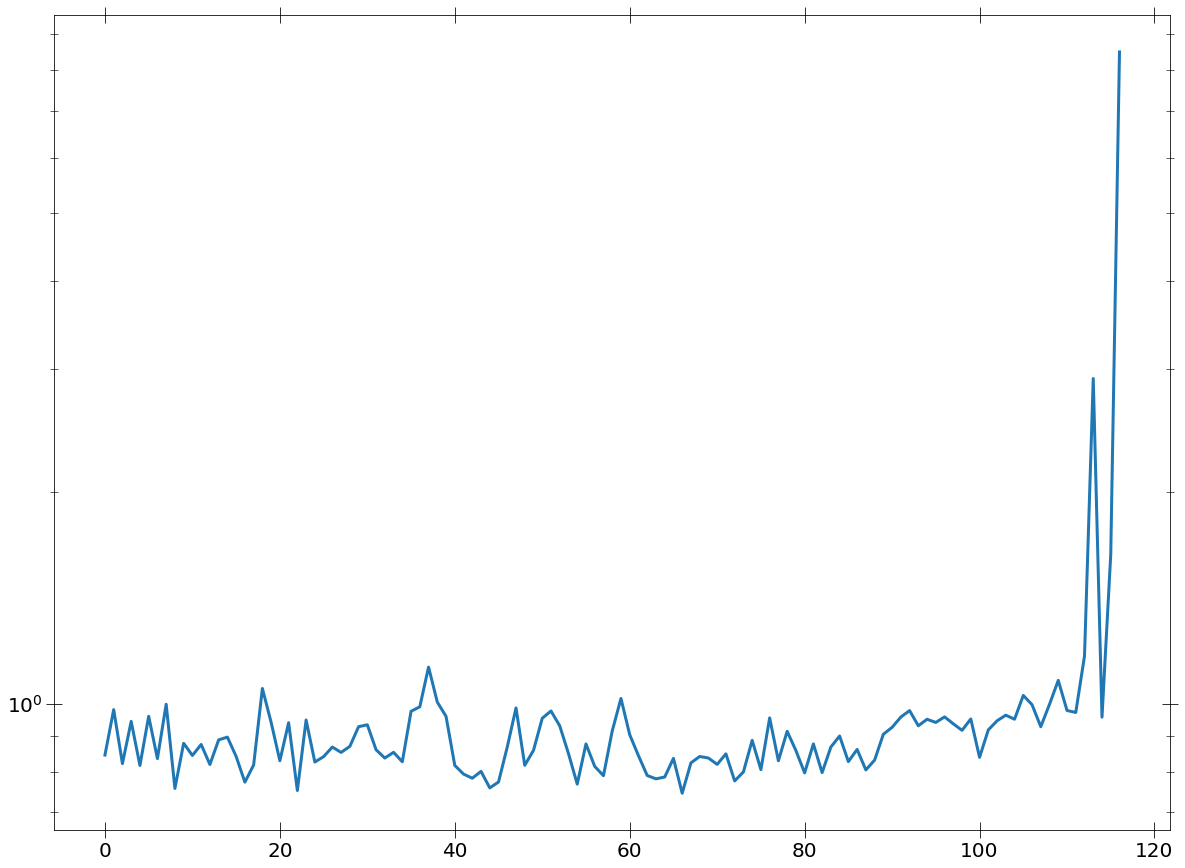

1:62: E225 missing whitespace around operator
2:80: E501 line too long (112 > 79 characters)


In [298]:
plt.plot((np.array(pn_fit_stats_table_pl)[:, 1].astype(float)/
          np.array(pn_fit_stats_table_pl)[:, -1].astype(float))[candia])
plt.yscale('log')

In [297]:
len(np.where(aic_pl_arr[0] < aic_pl_g3_arr[0] - 2)[0])


117

In [271]:
print(len(candidate_srcs_mos))
candidate_srcs_mos

66


array(['202026707015155', '204003401010008', '206556701010016',
       '206556701010040', '206946416010014', '208016803010003',
       '208860207010005', '202026707010160', '206043007010211',
       '206735502010030', '206735502010035', '206735502010047',
       '206735502010048', '206735502010049', '206735502010062',
       '206735502010080', '206735502010100', '206946409010023',
       '206946410010029', '208016804010004', '201129715010017',
       '204003401010007', '208016813010003', '201529201010011',
       '202026707010169', '202026707010179', '202026707010221',
       '202026707010240', '202026707010278', '204105804010009',
       '205049406010006', '206586001010095', '206586001010113',
       '206586001010146', '206735502010018', '206735502010024',
       '205100104010002', '206946401010003', '208860108010001',
       '202026707010062', '202026707010124', '202026707015191',
       '201129707010063', '202026707010170', '202026707010181',
       '207234104010049', '2010326130100

In [302]:
print(len(candidate_srcs_acis))
np.sort(candidate_srcs_acis)

157


array(['2CXOJ174405.3-292031', '2CXOJ174429.4-285531',
       '2CXOJ174431.9-290508', '2CXOJ174433.0-284426',
       '2CXOJ174442.9-292048', '2CXOJ174454.1-285841',
       '2CXOJ174457.4-285020', '2CXOJ174502.3-285449',
       '2CXOJ174503.8-290051', '2CXOJ174505.4-285934',
       '2CXOJ174507.0-290357', '2CXOJ174508.6-285652',
       '2CXOJ174508.6-285939', '2CXOJ174511.8-290032',
       '2CXOJ174512.3-285901', '2CXOJ174512.8-290340',
       '2CXOJ174513.9-285916', '2CXOJ174514.1-285425',
       '2CXOJ174515.0-285914', '2CXOJ174515.1-290016',
       '2CXOJ174515.7-290222', '2CXOJ174516.1-290425',
       '2CXOJ174516.7-290407', '2CXOJ174518.6-290010',
       '2CXOJ174520.2-291044', '2CXOJ174520.3-290634',
       '2CXOJ174520.5-290501', '2CXOJ174521.2-290652',
       '2CXOJ174521.3-285953', '2CXOJ174523.8-290653',
       '2CXOJ174524.3-285705', '2CXOJ174525.2-285404',
       '2CXOJ174526.8-285926', '2CXOJ174526.8-290702',
       '2CXOJ174527.5-290513', '2CXOJ174527.6-290423',
       '2C

In [287]:
def arr_to_str(arr, type='name'):
    string = ''
    for element in arr:
        if type == 'name':
            element = element.split('J')[0] + ' J' + element.split('J')[1]
        string += str(element) + '; '
    return string[:-2]

In [289]:
len(candidate_srcs_pn)

86

In [288]:
arr_to_str(candidate_srcs_pn, type=None)

'201129701010028; 201129707010018; 201129707010031; 203017301010002; 205100104010019; 205547201010008; 206946402010138; 206946404010167; 206946408010129; 206946410010025; 206946410010046; 206946410015051; 206946410015093; 206946416010055; 206946416010103; 206946416010105; 206946416010109; 207641901010010; 207641901010014; 207641917010007; 208016812010006; 208251401010013; 208441011010118; 208441011010128; 208441011010233; 208624701010019; 208860105010003; 208860207010005; 208861209010005; 200305401015015; 201113501010117; 201129704010031; 201129704010056; 204003401010008; 205100104010002; 205110012010036; 206946401010003; 206946404010202; 206946410010178; 206946416010014; 208016803010003; 208441011010009; 208441011010032; 208624701010022; 208860108010001; 208938111010034; 201129707010046; 201129707010057; 204003401010007; 205110012010017; 205110012010028; 205110012010053; 205110012010055; 208016813010003; 201032613010002; 201129721010057; 201129721010133; 206946402010009; 2074363090100

(array([  0,   5,   7,  13,  53,  60,  91,  94, 101, 178, 241, 242, 267,
       275, 276, 279, 280, 281, 283, 284, 288, 315, 326, 338, 345, 361,
       392, 402, 405, 421, 423, 424, 425, 479, 481, 487, 503, 504, 522,
       551, 557, 586, 608, 613, 632, 635, 636, 648, 660, 672, 686, 692,
       733, 735, 737, 740]),)
['200305401010008' '200305401015015' '201032613010001' '201113501010117'
 '201129704010031' '201129704010056' '201129707010018' '201129707010031'
 '201129707010046' '201529201010060' '204003401010003' '204003401010007'
 '205049406010031' '205100104010019' '205110002015026' '205110012010017'
 '205110012010028' '205110012010036' '205110012010055' '205110012015035'
 '205547201010008' '206746007010035' '206946401010024' '206946401010096'
 '206946402010031' '206946404010062' '206946410010025' '206946410010178'
 '206946410015093' '206946416010055' '206946416010103' '206946416010105'
 '206946416010109' '207242102010146' '207242102015037' '207436309010072'
 '207641901010010' '2076

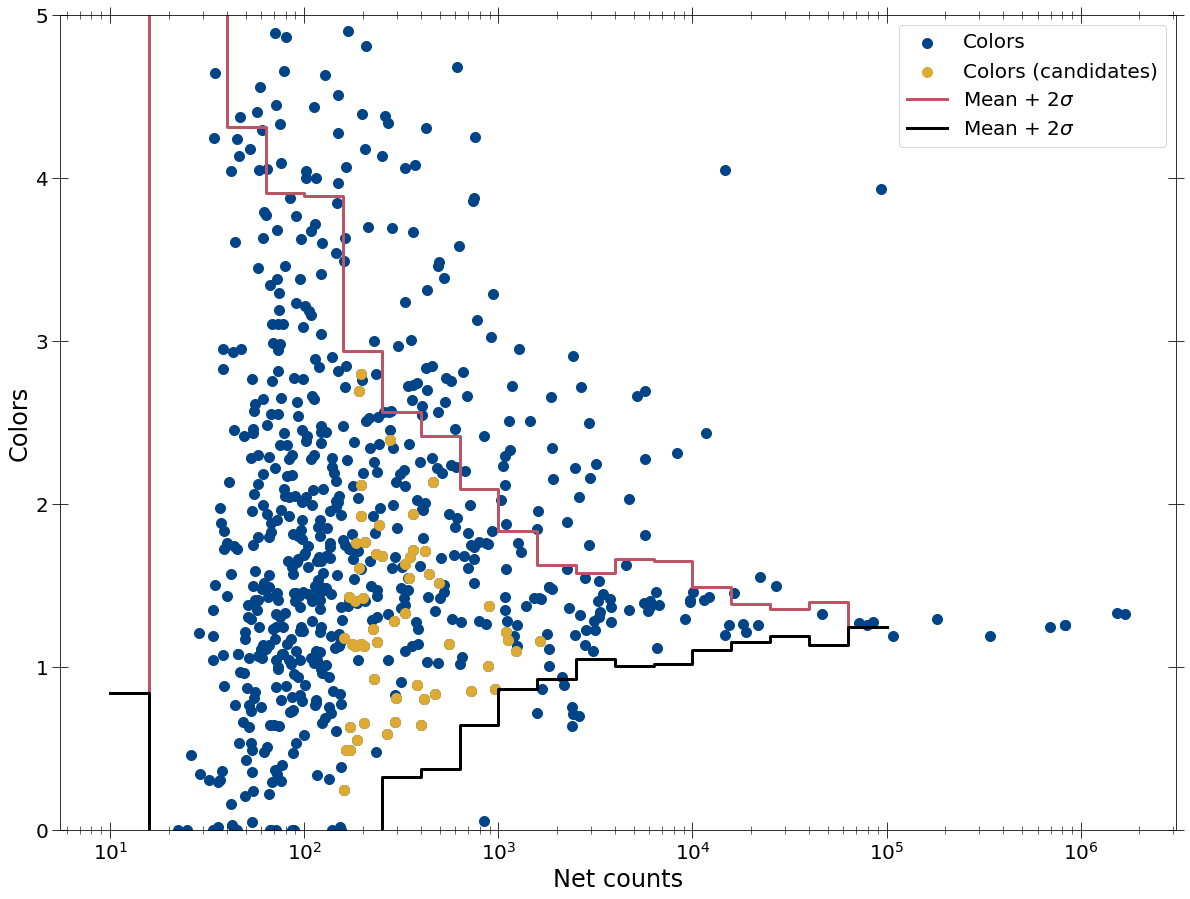

2:80: E501 line too long (83 > 79 characters)


In [93]:
mark_interested_srcs(sim_color_dict_arr[0], obs_color_dict_arr[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     candidate_srcs_pn_good, 0)

(array([  3, 143, 144, 162, 169, 170, 171, 270, 277, 279, 280, 282, 283,
       284, 285, 286, 288, 290, 292, 296, 298, 308, 315, 317, 319, 324,
       333, 334, 338, 340, 345, 347, 349, 352, 353, 362, 383, 387, 388,
       414, 441, 444]),)
['201032613010001' '204003401010003' '204003401010007' '205110002015026'
 '206556701010016' '206556701010023' '206556701010040' '208861209010009'
 '201529201010011' '202026707010062' '202026707010124' '202026707010160'
 '202026707010169' '202026707010170' '202026707010179' '202026707010181'
 '202026707010221' '202026707010240' '202026707010278' '202026707015146'
 '202026707015191' '204024303010060' '205110012010005' '206043007010211'
 '206556701010043' '206586001010113' '206735502010018' '206735502010024'
 '206735502010030' '206735502010035' '206735502010047' '206735502010049'
 '206735502010052' '206735502010061' '206735502010062' '206735502010080'
 '206904418015036' '206946409010023' '206946410010029' '207234104010049'
 '208016804010004' '20862470

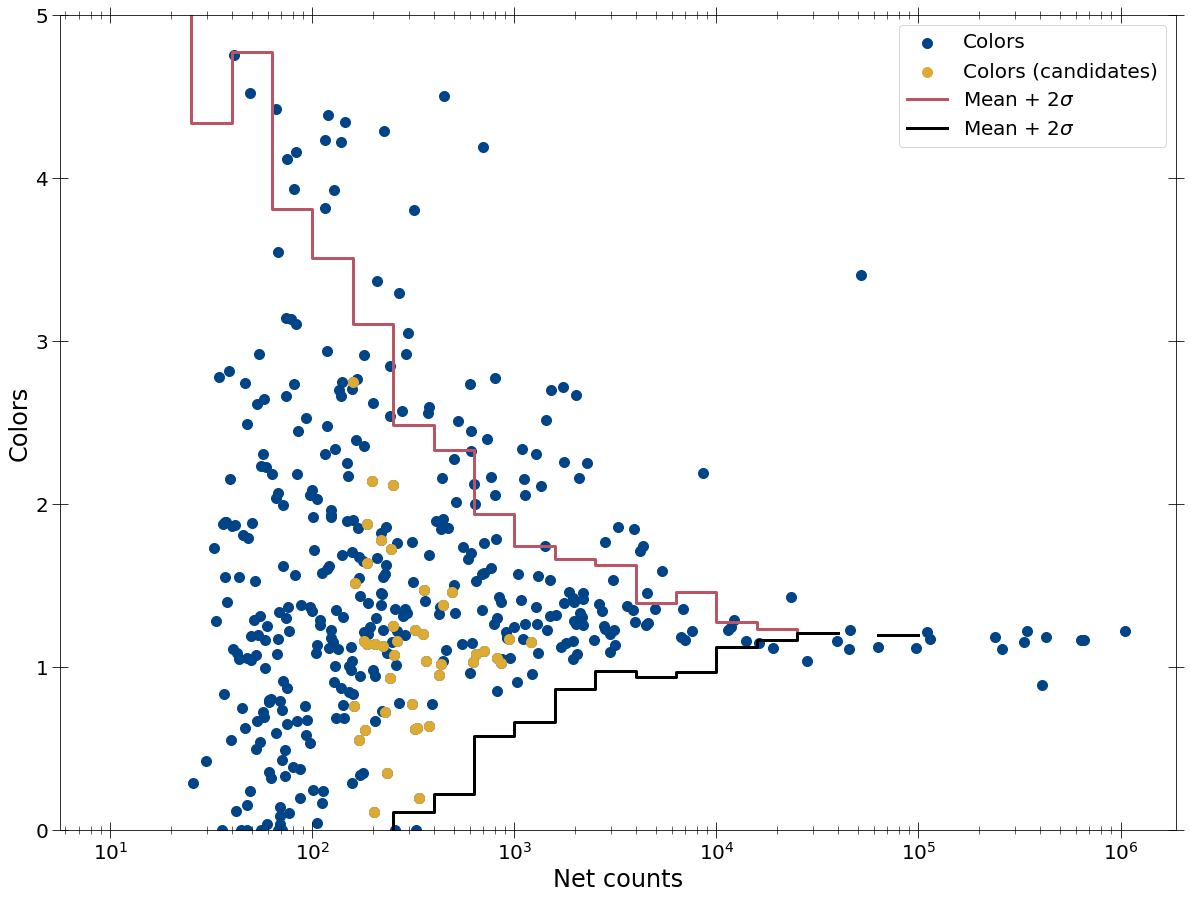

2:80: E501 line too long (83 > 79 characters)


In [95]:
mark_interested_srcs(sim_color_dict_arr[1], obs_color_dict_arr[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     candidate_srcs_mos_good, 0)

(array([  28,   74,   90,  107,  130,  138,  165,  173,  180,  212,  223,
        243,  264,  267,  276,  283,  294,  327,  377,  382,  389,  492,
        530,  613,  652,  657,  763,  764,  806,  809,  842,  863,  931,
        975, 1001, 1035, 1073, 1187, 1200, 1248, 1259, 1279, 1329, 1348,
       1362, 1375, 1376, 1381, 1390, 1408, 1419, 1420, 1474, 1489, 1499,
       1520, 1527, 1541, 1547, 1562, 1563, 1571, 1575, 1578, 1586, 1596,
       1612, 1618, 1633, 1649, 1666, 1672, 1675, 1703, 1705, 1706, 1710,
       1761, 1783, 1820, 1829, 1862, 1877, 1880, 1888, 1895, 1909, 1920,
       1963, 2006, 2012, 2031, 2068, 2121, 2199, 2210, 2260, 2285, 2303,
       2364, 2373, 2392, 2394, 2418, 2431, 2436, 2440, 2452, 2462, 2465,
       2483, 2485, 2488, 2517, 2522, 2529, 2536, 2543, 2570, 2590, 2603]),)
['2CXOJ174405.3-292031' '2CXOJ174429.4-285531' '2CXOJ174433.0-284426'
 '2CXOJ174442.9-292048' '2CXOJ174454.1-285841' '2CXOJ174457.4-285020'
 '2CXOJ174503.8-290051' '2CXOJ174507.0-290357' '2CXOJ

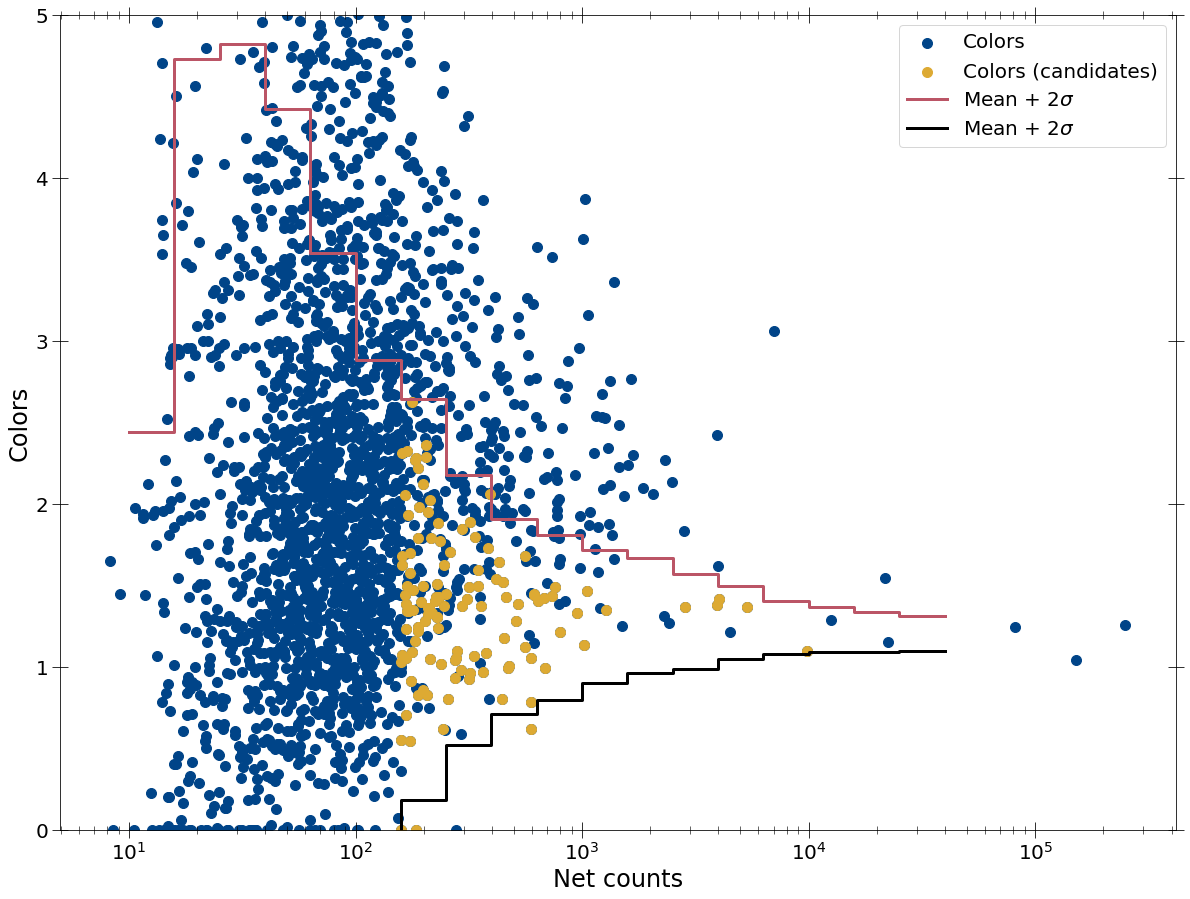

2:80: E501 line too long (83 > 79 characters)


In [97]:
mark_interested_srcs(sim_color_dict_arr[2], obs_color_dict_arr[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     candidate_srcs_acis_good, 0)

(array([  5,   8,  13,  26,  32,  53,  60,  65,  91,  94, 101, 104, 106,
       155, 157, 164, 168, 178, 183, 195, 212, 236, 242, 243, 274, 275,
       278, 279, 280, 281, 282, 283, 288, 322, 344, 356, 366, 367, 387,
       392, 394, 402, 404, 405, 418, 421, 423, 424, 425, 479, 481, 487,
       490, 503, 504, 522, 535, 536, 537, 538, 539, 541, 542, 543, 544,
       545, 548, 550, 551, 557, 568, 586, 604, 628, 630, 632, 635, 636,
       648, 660, 661, 692, 698, 722, 735, 740]),)
['200305401015015' '201032613010002' '201113501010117' '201129701010028'
 '201129702010002' '201129704010031' '201129704010056' '201129705010011'
 '201129707010018' '201129707010031' '201129707010046' '201129707010057'
 '201129707010063' '201129721010057' '201129721010060' '201129721010133'
 '201442201010001' '201529201010060' '202026705010003' '202026707010271'
 '203017301010002' '203032102010002' '204003401010007' '204003401010008'
 '205100104010002' '205100104010019' '205110012010001' '205110012010017'
 '2051

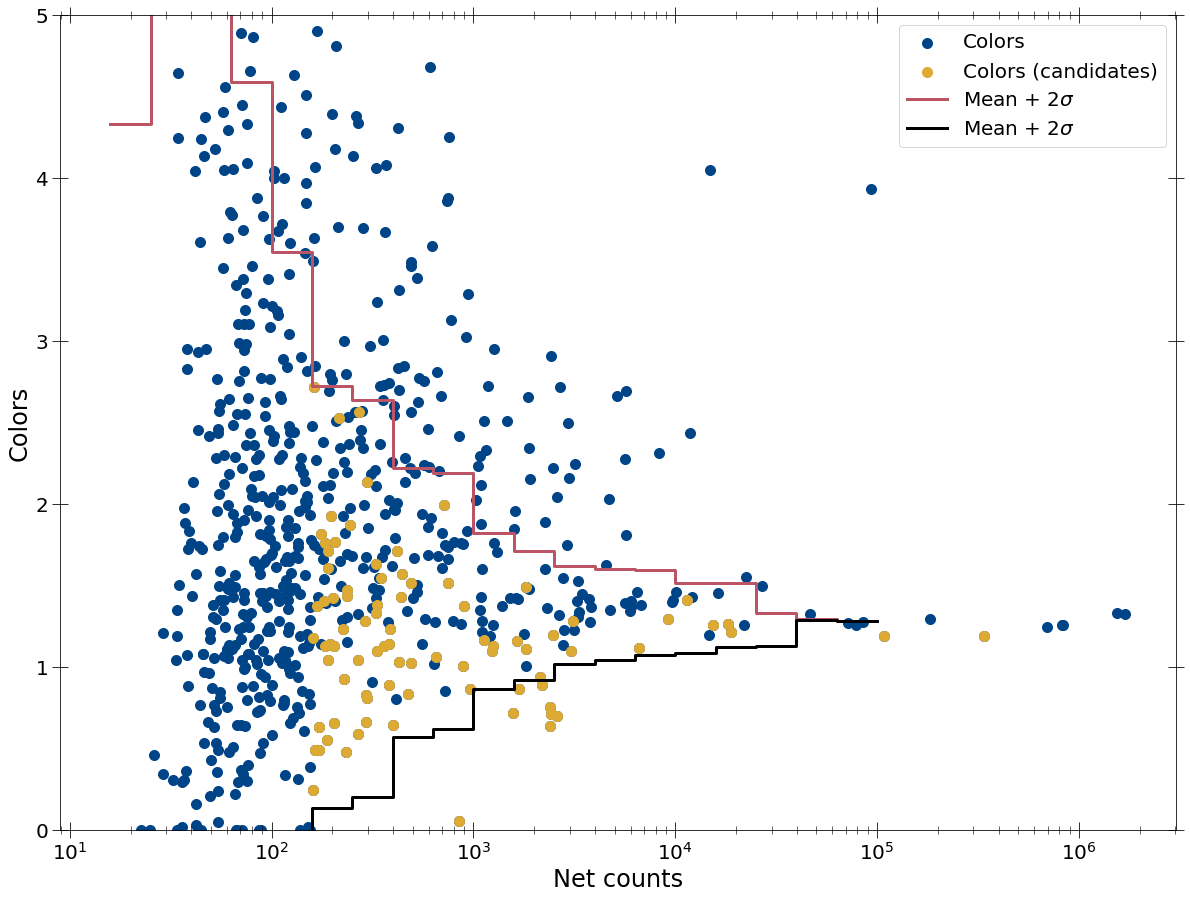

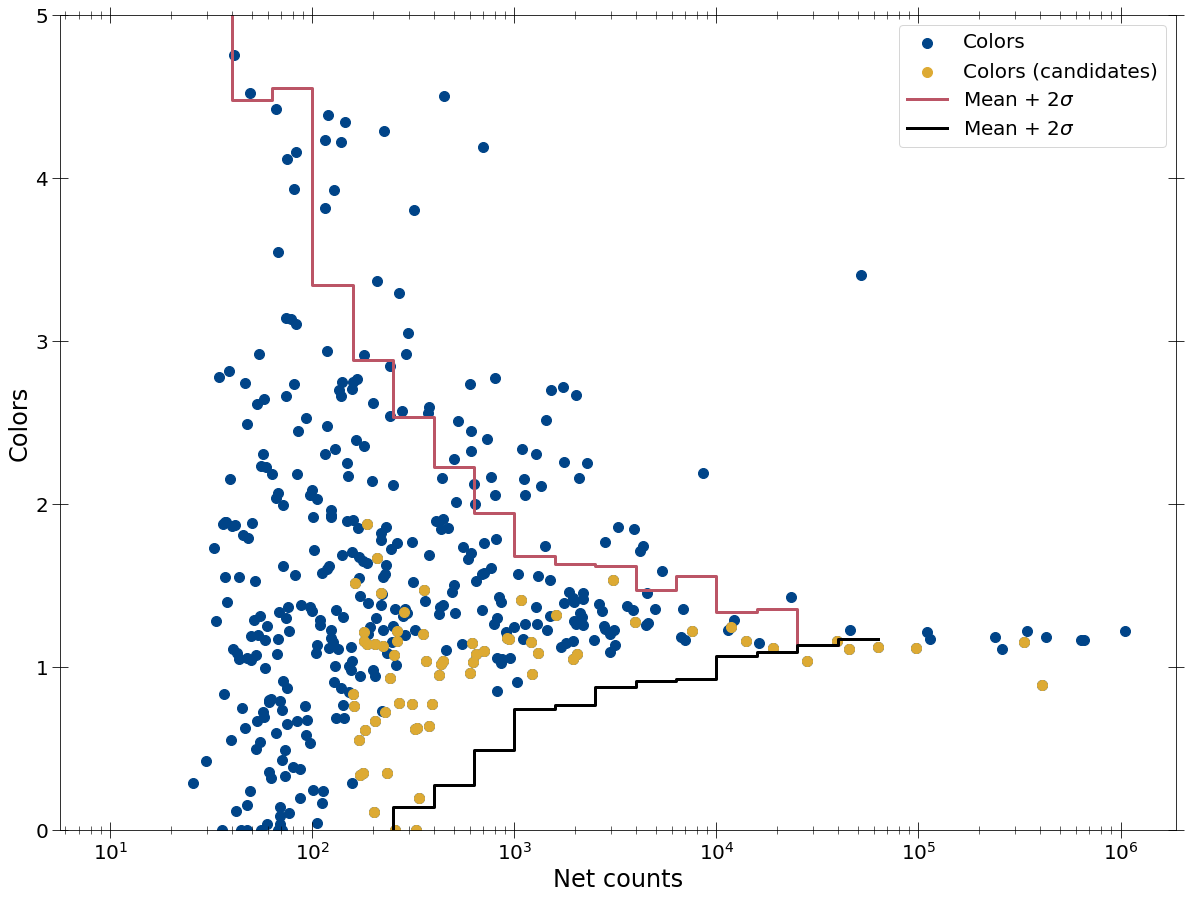

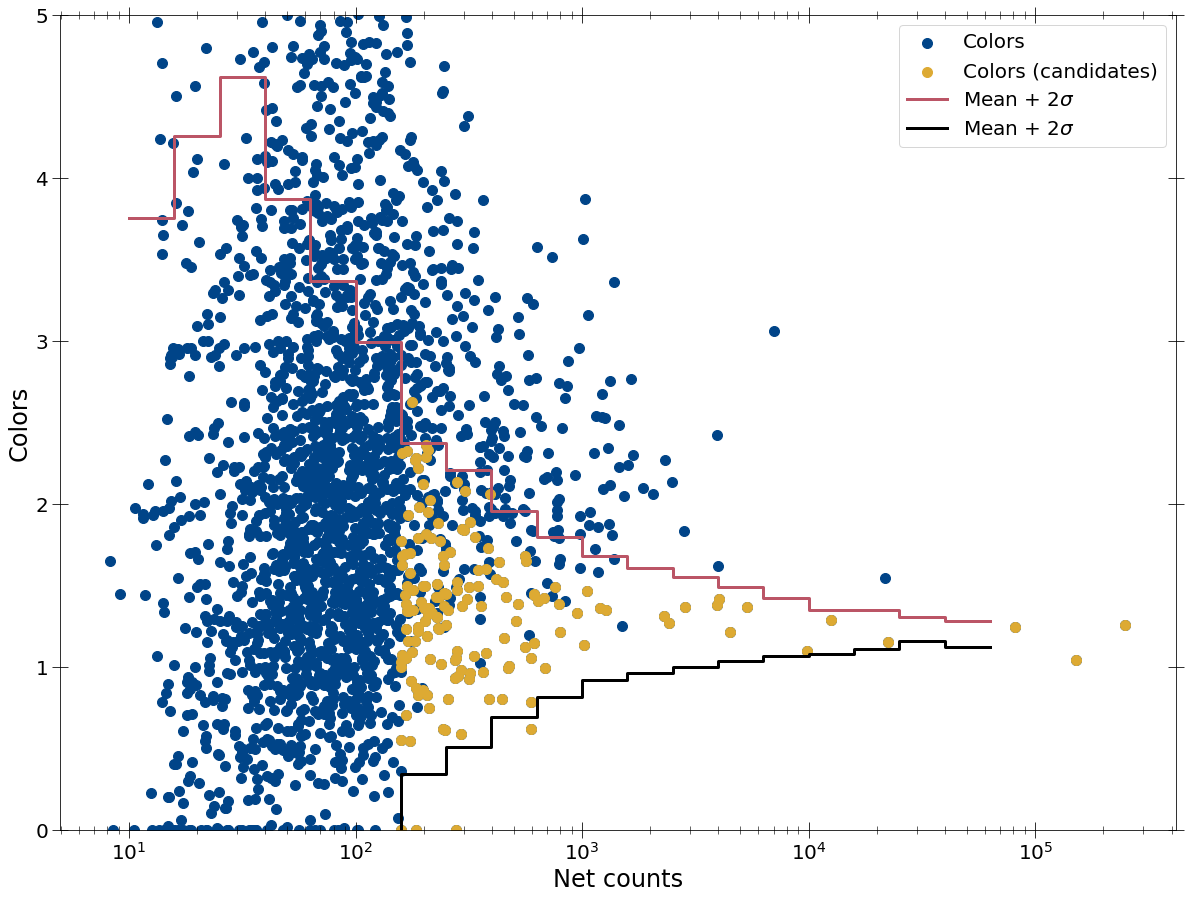

1:80: E501 line too long (82 > 79 characters)
2:80: E501 line too long (83 > 79 characters)
4:80: E501 line too long (82 > 79 characters)
5:80: E501 line too long (83 > 79 characters)
7:80: E501 line too long (82 > 79 characters)
8:80: E501 line too long (83 > 79 characters)


In [276]:
mark_interested_srcs(sim_color_dict_arr_clipped[0], obs_color_dict_arr_clipped[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     candidate_srcs_pn, 0)
mark_interested_srcs(sim_color_dict_arr_clipped[1], obs_color_dict_arr_clipped[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     candidate_srcs_mos, 0)
mark_interested_srcs(sim_color_dict_arr_clipped[2], obs_color_dict_arr_clipped[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     candidate_srcs_acis, 0)

In [169]:
np.where(interested_srcs_alldet[2] == '2CXOJ174534.3-290231')

(array([], dtype=int64),)

In [285]:
print(acis_fit_stats_table_pl[125])
print(acis_fit_stats_table_pl_g[125])
print(acis_fit_stats_table_pl_g2[125])
print()
print(acis_fit_stats_table_pl[208])
print(acis_fit_stats_table_pl_g[208])
print(acis_fit_stats_table_pl_g2[208])
print()
print(acis_fit_stats_table_pl[133])
print(acis_fit_stats_table_pl_g[133])
print(acis_fit_stats_table_pl_g2[133])
print()
print(acis_fit_stats_table_pl[46])
print(acis_fit_stats_table_pl_g[46])
print(acis_fit_stats_table_pl_g2[46])
print()
print(acis_fit_stats_table_pl[88])
print(acis_fit_stats_table_pl_g[88])
print(acis_fit_stats_table_pl_g2[88])
print()
print(acis_fit_stats_table_pl[188])
print(acis_fit_stats_table_pl_g[188])
print(acis_fit_stats_table_pl_g2[188])

['2CXOJ174540.3-290049', 266.01879656001785, -7.589646752720701, 50.0, 299]
['2CXOJ174540.3-290049', 264.6833556689429, -7.805990677928118, 50.0, 297]
['2CXOJ174540.3-290049', 263.92879916841827, -7.8578460350119865, 50.0, 296]

['2CXOJ174536.9-290039', 344.5620739732016, -9.526574126034008, 50.0, 389]
['2CXOJ174536.9-290039', 341.77998992125424, -9.871299609625027, 50.0, 387]
['2CXOJ174536.9-290039', 340.80402348470886, -9.916018231068454, 50.0, 386]

['2CXOJ174535.7-290004', 219.3432290242929, -8.32886982476195, 50.0, 254]
['2CXOJ174535.7-290004', 216.10212421697082, -8.175803506918273, 50.0, 252]
['2CXOJ174535.7-290004', 216.40324068904283, -8.163633107538715, 50.0, 251]

['2CXOJ174543.2-290003', 168.34505326473322, -7.38207827477904, 50.0, 262]
['2CXOJ174543.2-290003', 166.74607251218066, -7.295869408022453, 50.0, 260]
['2CXOJ174543.2-290003', 167.088320724579, -7.364177348527165, 50.0, 259]

['2CXOJ174535.0-285757', 140.70723931932093, -7.684272731913274, 50.0, 193]
['2CXOJ174535.

In [157]:
print(acis_model_params_table_pl_g2[125])
print(acis_model_params_table_pl_g2[208])
print(acis_model_params_table_pl_g2[133])
print(acis_model_params_table_pl_g2[46])
print(acis_model_params_table_pl_g2[88])
print(acis_model_params_table_pl_g2[188])

['2CXOJ174540.3-290049', 14.747172266857492, 2.284559245444103, 0.014014393023623173, 3.157876082859608e-08, 1.936457506907927e-08, 4.298694332175304e-19, 0.0, 8.242343569531286e-08, 0.0, 7.391659902986237e-08, 0.0, 3.2311902308687976e-08]
['2CXOJ174536.9-290039', 32.91698126831548, 2.169538475539656, 0.13824128530453256, 5.4557158152566107e-14, 1.4314730567579634e-07, 7.4035496908206e-08, 0.0, 1.1265319696324751e-07, 0.0, 3.059586290967107e-07, 0.0, 2.3806088884467742e-07]
['2CXOJ174535.7-290004', 25.294693190701558, 1.6423470508550815, 0.040934446317875135, 8.531655806100725e-08, 3.5908650704885276e-08, 1.1327547386683504e-08, 0.0, 1.9846436077281447e-07, 0.0, 1.5934190141787257e-07, 0.0, 1.3669784512889456e-07]
['2CXOJ174543.2-290003', 57.451790453056155, 4.999999999999999, 0.3025621014701397, 6.405396701097331e-22, 1.716821005151346e-19, 1.2932393486615652e-07, 0.0, 1.4473062790960989e-07, 0.0, 2.977575924227808e-07, 0.0, 3.5802429139269943e-07]
['2CXOJ174535.0-285757', 16.72445583

(array([ 200,  692,  806,  990, 1051, 1199, 1665, 1685, 1702]),)
['2CXOJ174534.3-290231' '2CXOJ174546.2-290003' '2CXOJ174538.1-290319'
 '2CXOJ174535.7-290004' '2CXOJ174543.2-290003' '2CXOJ174532.9-290110'
 '2CXOJ174535.0-285757' '2CXOJ174527.8-290210' '2CXOJ174544.1-285940']
[176.43000154  68.51315789 148.93362531 333.82959801 176.07171884
  69.72756558 160.74684514 452.65052956  15.82249253]
[2.8743079         inf 0.88800633 1.79911604 0.7109796  2.33402784
 1.63259623 1.30960658        inf]


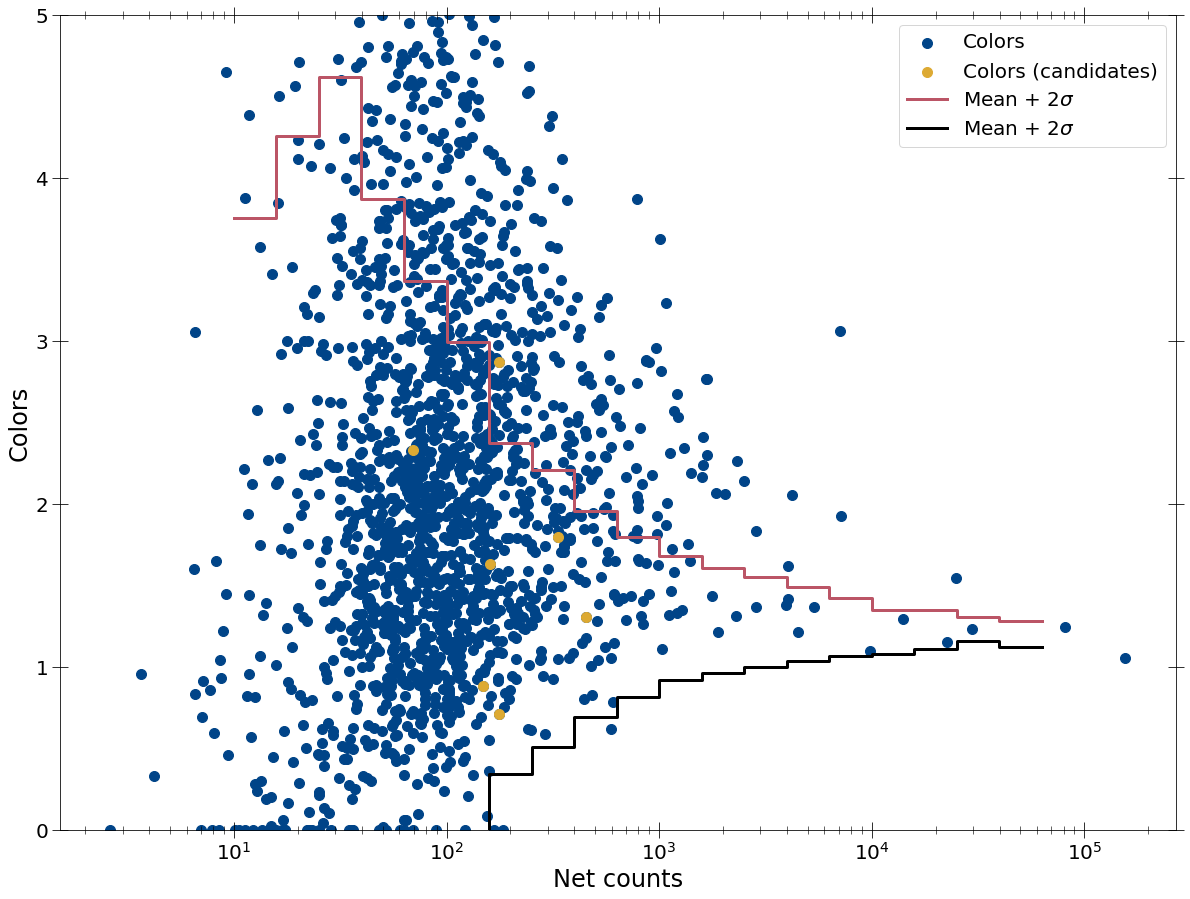

2:80: E501 line too long (83 > 79 characters)


In [168]:
mark_interested_srcs(sim_color_dict_arr[2], obs_color_dict_arr[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     ['2CXOJ174543.2-290003', '2CXOJ174535.7-290004',
                      '2CXOJ174544.1-285940', '2CXOJ174546.2-290003',
                      '2CXOJ174532.9-290110', '2CXOJ174534.3-290231',
                      '2CXOJ174535.0-285757', '2CXOJ174538.1-290319', '2CXOJ174527.8-290210'], 0)

(array([ 678,  840,  990, 1335]),)
['2CXOJ174540.3-290049' '2CXOJ174536.9-290039' '2CXOJ174535.7-290004'
 '2CXOJ174536.1-285638']
[ 309.98665049 1113.49755019  333.82959801 7063.35067975]
[1.41798004 1.31906731 1.79911604 3.06266218]


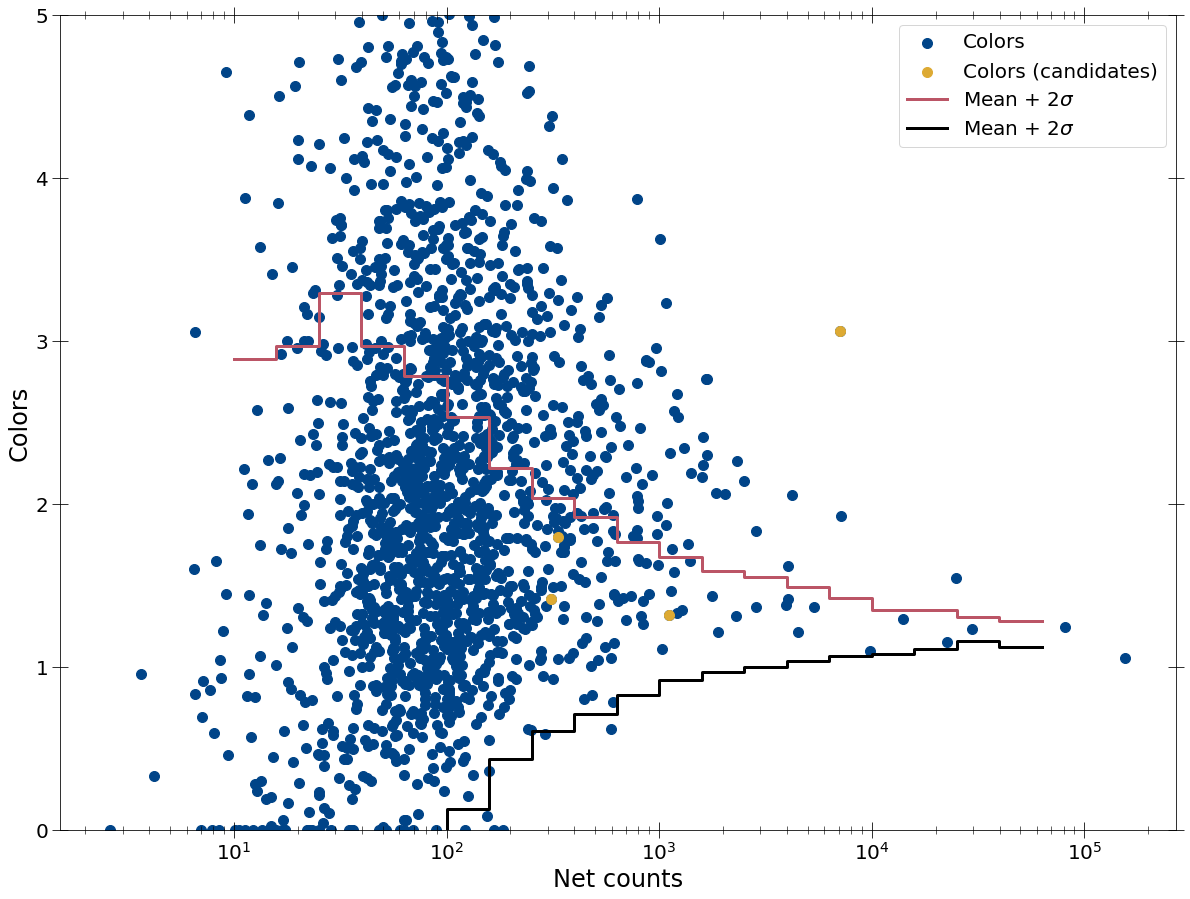

1:80: E501 line too long (82 > 79 characters)
2:80: E501 line too long (83 > 79 characters)


In [167]:
mark_interested_srcs(sim_color_dict_arr_clipped[2], obs_color_dict_arr_clipped[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     ['2CXOJ174540.3-290049', '2CXOJ174536.9-290039',
                      '2CXOJ174535.7-290004', '2CXOJ174536.1-285638',
                      '2CXOJ174532.7-285616', '2CXOJ174610.5-285550'], 0)

In [289]:
np.savetxt('ACIS_interested_plmodels.txt', acis_model_params_table_pl, fmt='%s')
np.savetxt('ACIS_interested_g2models.txt', acis_model_params_table_pl_g2, fmt='%s')

1:80: E501 line too long (80 > 79 characters)


# Checking for low norm sources

In [277]:
acis_model_g2_arr = np.array(acis_model_params_table_pl_g2)
zero_norms_args = np.where(np.logical_and(np.logical_and(
    np.logical_or(
        acis_model_g2_arr[:, 7].astype(float) == 0,
        acis_model_g2_arr[:, 7].astype(float) >= acis_model_g2_arr[:, 4].astype(float)),
    np.logical_or(
        acis_model_g2_arr[:, 9].astype(float) == 0,
        acis_model_g2_arr[:, 9].astype(float) >= acis_model_g2_arr[:, 5].astype(float))),
    np.logical_or(
        acis_model_g2_arr[:, 11].astype(float) == 0,
        acis_model_g2_arr[:, 11].astype(float) >= acis_model_g2_arr[:, 6].astype(float))))[0]

5:80: E501 line too long (88 > 79 characters)
8:80: E501 line too long (89 > 79 characters)


In [278]:
high_norms_args = np.where(np.logical_or(np.logical_or(
    acis_model_g2_arr[:, 7].astype(float) >= acis_model_g2_arr[:, 4].astype(float),
    acis_model_g2_arr[:, 9].astype(float) >= acis_model_g2_arr[:, 5].astype(float)),
    acis_model_g2_arr[:, 11].astype(float) >= acis_model_g2_arr[:, 6].astype(float)))[0]

2:80: E501 line too long (83 > 79 characters)
3:80: E501 line too long (84 > 79 characters)


In [279]:
len(high_norms_args)

29

In [247]:
zero_norm_args = np.append(zero_norms_args.copy(), high_norms_args)

In [280]:
len(zero_norms_args)

144

In [281]:
np.min((aic_pl_g3_arr[2] - aic_pl_arr[2])[zero_norms_args])

0.8924075464469752

In [258]:
print(acis_fit_stats_table_pl[117])
print(acis_fit_stats_table_pl_g2[117])

['2CXOJ174601.1-285952', 273.95609098450296, -7.238976643444733, 50.0, 270]
['2CXOJ174601.1-285952', 250.28253432384366, -8.420395729866275, 50.0, 267]


In [259]:
print(acis_model_params_table_pl[117])
print(acis_model_params_table_pl_g2[117])

['2CXOJ174601.1-285952', 15.645019663669181, 0.551782037874522, 0.03696465499752591]
['2CXOJ174601.1-285952', 19.737789482731742, 1.5997676215429104, 0.0331508926935257, 1.6215554900609572e-07, 2.6901888734595366e-07, 2.995211254045239e-08, 5.937151313098362e-08, 2.905464964537258e-07, 1.33223904033065e-07, 4.348939115214157e-07, 0.0, 1.7693666605934802e-07]


In [282]:
print(len(np.where(aic_pl_arr[2] < aic_pl_g3_arr[2])[0]))
print(len(np.where(aic_pl_arr[2] < aic_pl_g3_arr[2] - 1.39)[0]))
print(len(np.where(aic_pl_arr[2] < aic_pl_g3_arr[2] - 3.0)[0]))
print(len(np.where(aic_pl_arr[2] < aic_pl_g3_arr[2] - 4.0)[0]))
print(len(np.where(aic_pl_arr[2] < aic_pl_g3_arr[2] - 4.605)[0]))

199
164
132
102
85


In [286]:
print(len(np.where(aic_pl_arr[2][zero_norms_args] < aic_pl_g3_arr[2][zero_norms_args])[0]))
print(len(np.where(aic_pl_arr[2][zero_norms_args] < aic_pl_g3_arr[2][zero_norms_args] - 1.0)[0]))
print(len(np.where(aic_pl_arr[2][zero_norms_args] < aic_pl_g3_arr[2][zero_norms_args] - 3.0)[0]))
print(len(np.where(aic_pl_arr[2][zero_norms_args] < aic_pl_g3_arr[2][zero_norms_args] - 4.0)[0]))
print(len(np.where(aic_pl_arr[2][zero_norms_args] < aic_pl_g3_arr[2][zero_norms_args] - 4.605)[0]))

1:80: E501 line too long (91 > 79 characters)
2:80: E501 line too long (97 > 79 characters)
3:80: E501 line too long (97 > 79 characters)
4:80: E501 line too long (97 > 79 characters)


144
143
127
102
85


In [281]:
zero_norms_args

array([  0,   1,   3,   4,  10,  12,  13,  16,  17,  18,  19,  20,  24,
        27,  31,  32,  33,  34,  37,  38,  39,  43,  45,  46,  47,  48,
        51,  53,  54,  56,  59,  61,  62,  65,  67,  68,  70,  73,  74,
        76,  77,  80,  82,  83,  84,  85,  87,  88,  89,  90,  91,  93,
        94,  95,  97,  99, 100, 103, 104, 106, 107, 109, 115, 119, 121,
       123, 124, 125, 128, 129, 130, 132, 133, 134, 136, 139, 141, 143,
       144, 146, 148, 149, 150, 156, 158, 160, 162, 164, 166, 167, 168,
       171, 173, 175, 177, 178, 180, 181, 182, 183, 184, 185, 188, 189,
       190, 191, 193, 195, 197, 198, 199, 200, 203, 208, 209, 210, 212,
       213, 214, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226,
       227])

In [284]:
acis_model_g2_arr[219]

array(['2CXOJ174535.5-290124', '30.35200191082754', '1.4425701490713667',
       '0.47630799807558655', '1.89602805783651e-08',
       '2.8201094011909062e-24', '7.408528059108422e-24', '0.0',
       '2.3455091875304955e-07', '0.8224962005991274', '0.0',
       '0.8224962005991274', '0.0'], dtype='<U32')

In [282]:
np.where(np.logical_and(aic_pl_arr[2] < aic_pl_g3_arr[2] - 3.0,
                        acis_model_g2_arr[:, 11].astype(float) != 0))[0]

array([  3,   4,  17,  19,  27,  97, 109, 113, 132, 162, 178, 190, 191,
       219, 223, 224, 225, 226, 227])

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


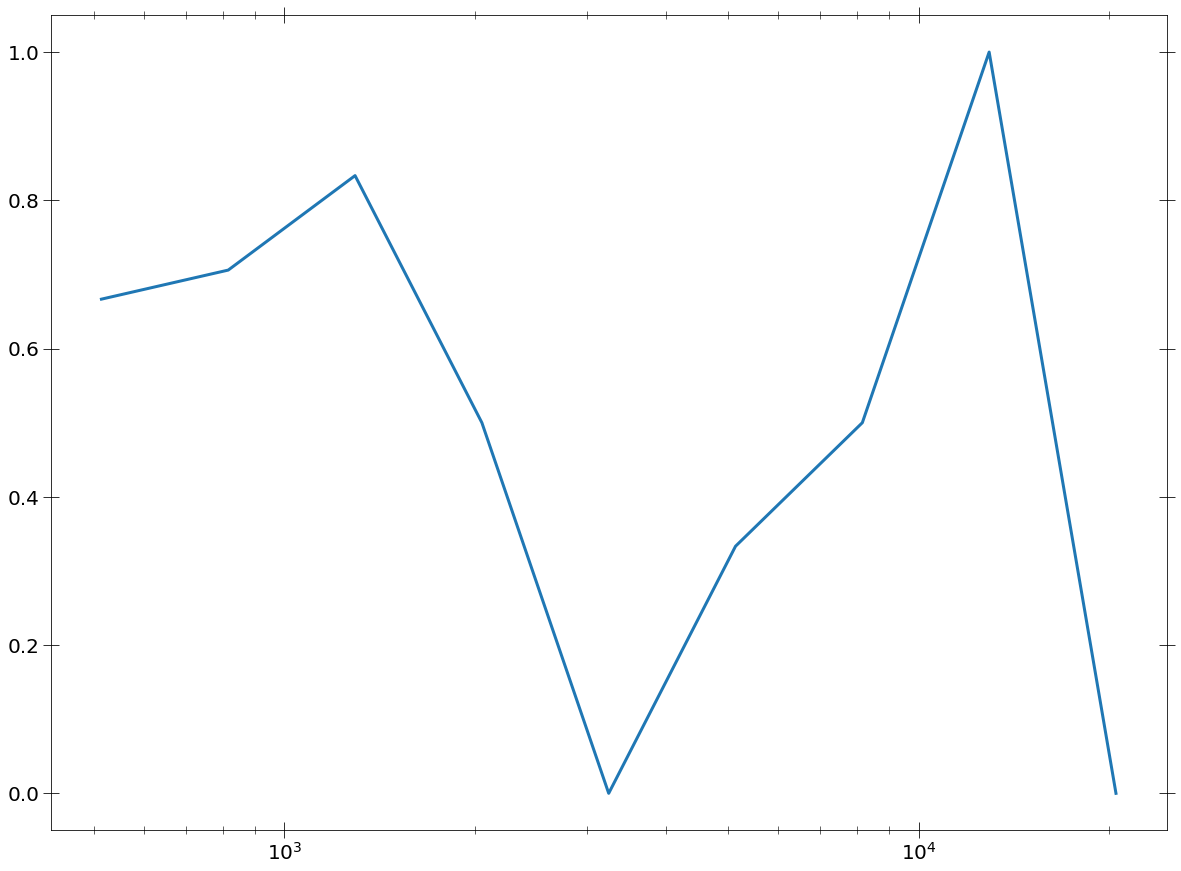

In [451]:
plt.plot(0.5*(bins[1:] + bins[:-1]), candidate_hist/interested_hist)
plt.xscale('log')

In [441]:
len(sim_color_dict_arr[0]['prop_bins'][0])

21

In [452]:
candidate_hist

array([ 0,  0,  0,  0,  0,  0,  0,  0, 12, 12,  5,  1,  0,  1,  1,  3,  0,
        0,  0,  0])

In [453]:
interested_hist

array([ 0,  0,  0,  0,  0,  0,  0,  0, 18, 17,  6,  2,  1,  3,  2,  3,  2,
        0,  0,  0])

In [449]:
bins

array([1.00000000e+01, 1.58489319e+01, 2.51188643e+01, 3.98107171e+01,
       6.30957344e+01, 1.00000000e+02, 1.58489319e+02, 2.51188643e+02,
       3.98107171e+02, 6.30957344e+02, 1.00000000e+03, 1.58489319e+03,
       2.51188643e+03, 3.98107171e+03, 6.30957344e+03, 1.00000000e+04,
       1.58489319e+04, 2.51188643e+04, 3.98107171e+04, 6.30957344e+04,
       1.00000000e+05])

In [454]:
fit_stats_pl_arr = np.array(mos_fit_stats_table_pl)
fit_stats_pl_gauss_arr = np.array(mos_fit_stats_table_pl_g)

aic_pl = fit_stats_pl_arr[:, 1].astype(float) + 6
aic_pl_gauss = fit_stats_pl_gauss_arr[:, 1].astype(float) + 10

candidate_args = interested_args_alldet[1][np.where(aic_pl > aic_pl_gauss)]
candidate_netcounts = spec_summary['counts'][0][1][1][spec_summary['spec_masks'][1][4]][candidate_args]
interested_netcounts = spec_summary['counts'][0][1][1][spec_summary['spec_masks'][1][4]][interested_args_alldet[1]]

candidate_hist, bins = np.histogram(candidate_netcounts, bins=sim_color_dict_arr[1]['prop_bins'][0])
interested_hist, bins = np.histogram(interested_netcounts, bins=sim_color_dict_arr[1]['prop_bins'][0])

IndexError: index 38 is out of bounds for axis 0 with size 38

8:80: E501 line too long (103 > 79 characters)
9:80: E501 line too long (115 > 79 characters)
11:80: E501 line too long (100 > 79 characters)


In [455]:
len(fit_stats_pl_arr)

57

In [456]:
len(mos_fit_stats_table_pl)

57

In [459]:
np.sort(interested_srcs_alldet[0])

array(['201113501010010', '201113501010035', '201113501010066',
       '201113501010154', '201113501010169', '201113503010004',
       '201129701010011', '201129701010015', '201129701010027',
       '201129701010041', '201129702010002', '201129704010011',
       '201129704010019', '201129704010027', '201129705010011',
       '201129705010015', '201129705010038', '201129705010067',
       '201129705010076', '201129705010079', '201129705015062',
       '201129706010014', '201129707010012', '201129707010063',
       '201129707010079', '201129709010024', '201129715010041',
       '201129719010010', '201129721010003', '201129721010009',
       '201129721010014', '201129721010022', '201129721010034',
       '201129721010035', '201129721010044', '201129721010057',
       '201129721010060', '201129721010063', '201129721010070',
       '201129721010078', '201129721010126', '201129721010133',
       '201129721015131', '202026705010034', '202026705010109',
       '202026708010021', '2030321020100

In [460]:
np.sort(interested_srcs_alldet[1])

array(['200305402010002', '201113501010010', '201113501010069',
       '201113501010114', '201113503010004', '201129701010035',
       '201129702010002', '201129704010048', '201129705010011',
       '201129705010014', '201129705010024', '201129705010067',
       '201129705010079', '201129705010095', '201129705015062',
       '201129706010014', '201129707010063', '201129708010036',
       '201129719010010', '201129721010003', '201129721010005',
       '201129721010014', '201129721010022', '201129721010034',
       '201129721010045', '201129721010053', '201129721010057',
       '201129721010060', '201129721010075', '201129721010138',
       '202026705010053', '204105804015018', '206556701010012',
       '206556701010019', '206946404010008', '207641904010001',
       '208016803010001', '208251401010006'], dtype=object)

In [69]:
def get_candidate_src_nums_det2(obs_src_nums, obs_det_mask, sim_color_dict,
                               obs_color_dict, min_counts):
    """Get src nums of quiescent sources for given detector"""
    obs_netcounts = obs_color_dict['prop_list'][0]
    netcount_bins = sim_color_dict['prop_bins'][0]
    obs_colors = obs_color_dict['colors']
    color_median = sim_color_dict['color_stat'][0][0]
    color_std = sim_color_dict['color_stat'][2][0]
    interested_args = []
    interested_srcs = []
    for i, lower_bin in enumerate(netcount_bins):
        if lower_bin < min_counts:
            continue
        if i == len(netcount_bins) - 1:
            upper_bin = np.max(obs_netcounts) + 10
            median_color = color_median[-1]
            std_color = color_std[-1]
        else:
            upper_bin = netcount_bins[i+1]
            median_color = color_median[i]
            std_color = color_std[i]
        if np.isnan(median_color) or np.isnan(std_color):
                    int_args = np.where(np.logical_and(
                        obs_netcounts >= lower_bin,
                        obs_netcounts < upper_bin))
        else:
        
            int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        print(obs_netcounts[int_args])
        interested_args.append(int_args)
        interested_srcs.append(obs_src_nums[obs_det_mask][int_args])
    return interested_args, interested_srcs


def get_candidate_src_nums_alldet2(spec_summary, sim_color_dict_arr,
                                  obs_color_dict_arr, min_count_arr=None):
    """Get source nums for all detectors."""
    interested_args_alldet = []
    interested_sources_alldet = []
    if min_count_arr is None:
        min_count_arr = [700, 700, 250]
    for i, obs_color_dict in enumerate(obs_color_dict_arr):
        if i > 0:
            interested_args, interested_srcs = get_candidate_src_nums_det2(
                spec_summary['src_nums'][i-1], spec_summary['spec_masks'][1][i],
                sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        else:
            interested_args, interested_srcs = get_candidate_src_nums_det2(
            spec_summary['src_nums'][i], spec_summary['spec_masks'][1][i],
            sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        interested_args_alldet.append(interested_args)
        interested_sources_alldet.append(interested_srcs)
    return interested_args_alldet, interested_sources_alldet


2:32: E128 continuation line under-indented for visual indent
23:21: E117 over-indented
27:1: W293 blank line contains whitespace
45:35: E128 continuation line under-indented for visual indent
54:80: E501 line too long (80 > 79 characters)
58:13: E122 continuation line missing indentation or outdented
59:13: E122 continuation line missing indentation or outdented


In [70]:
test_args, test_srcs = get_candidate_src_nums_alldet2(spec_summary, sim_color_dict_arr, obs_color_dict_arr,
                                                      min_count_arr=[380, 380, 220])

[569.59489915 404.91355624 452.26180445 465.79990524 576.32276827
 493.39928098 487.52737681 463.48454887 513.71340716 539.95700063
 612.30372428 609.93432573 398.9688382  574.42562696 508.04667046
 592.28189506 435.03011623 522.26141993]
[652.69197128 823.33408827 792.69706455 674.18975953 876.79367389
 679.04689138 739.16724045 845.56868658 723.70611642 845.86782834
 764.06300906 648.50489117 711.53733848 864.90478044 817.363117
 923.15858478 648.64365916 797.95791783]
[1536.6024365  1114.66782348 1422.7130562  1291.96679205 1584.24987616
 1222.55308145]
[1989.78879578 2448.29069852]
[3333.91840967]
[5906.66947885 4300.15059039 5076.11064059]
[8272.89976422 7040.72877535]
[10372.3500844  14301.84303534 13285.45941   ]
[23304.51640767 18219.60240603]
[]
[]
[]
[ 736611.79761745  418037.54709113 2024254.48411136]
[608.05064636 440.51106749 493.03633815 438.03845112 598.07676261
 443.31577824 586.65762292 507.54544255 433.71040735 542.88105163
 402.12852783]
[743.55291637 648.44849731 71

1:80: E501 line too long (107 > 79 characters)


In [44]:
test_srcs

[[array(['201113501010066', '201113501010154', '201129701010015',
         '201129704010011', '201129704010019', '201129704010027',
         '201129707010012', '201129707010063', '201129709010024',
         '201129715010041', '201129721010070', '201129721010126',
         '204003401010007', '204105804010005', '206556701010012',
         '208016803010001', '208016813010003', '208251401010006'],
        dtype=object),
  array(['201113501010169', '201129701010011', '201129701010027',
         '201129701010041', '201129704010048', '201129705010015',
         '201129705010038', '201129705010067', '201129705015062',
         '201129721010022', '201129721010035', '201129721010057',
         '201129721010133', '202026705010109', '202026708010021',
         '205547504010092', '206946402010009', '207641904010001'],
        dtype=object),
  array(['201113501010035', '201129707010079', '201129721010063',
         '201129721010078', '201129721015131', '202026705010034'],
        dtype=object),
  ar

In [93]:
def combine_spec_analysis(int_srcs_list, source_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    spec_list = []
    for source_num in int_srcs_list:
        if telescope == 'XMM':
            spec_pnfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                     str(source_num) + '_PN_combined_src_grp1*')
            spec_mosfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                      str(source_num) + '_MOS_combined_src_grp1*')
            if len(spec_pnfile) > 0:
                spec_pn = xspec.Spectrum(spec_pnfile[0])
                spec_pn.ignore('0.0-2.0, 10.0-**')
                spec_pn.notice('2.0-10.0')
                spec_list.append(spec_pn)
                print(spec_pn.rate[0]*spec_pn.exposure)
            if len(spec_mosfile) > 0:
                spec_mos = xspec.Spectrum(spec_mosfile[0])
                spec_mos.ignore('0.0-2.0, 10.0-**')
                spec_pn.notice('2.0-10.0')
                spec_list.append(spec_mos)
                print(spec_mos.rate[0]*spec_mos.exposure)
        elif telescope == 'Chandra':
            os.chdir(src_folder + '/' + source_num)
            spec_file = str(source_num) + '_combined_src_grp1.pi'
            spec = xspec.Spectrum(spec_file)
            spec.ignore('0.0-2.0, 10.0-**')
            spec.notice('2.0-10.0')
            os.chdir(curr_dir)
        else:
            print('Telescope not recognized.')
    
    model = xspec.Model('tbabs*pegpwrlw')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.perform()
    xspec.Fit.error('2.706 2')
    xspec.Fit.perform()
    #goodness = xspec.Fit.goodness(1000)
    goodness = 50.0
    
    xspec.Plot.device = '/xw'
    xspec.Plot.xAxis = 'keV'
    xspec.Plot.yLog = True
    xspec.Plot.setRebin(2, 1000, -1)
    xspec.Plot()
    print('Model params: '
          'NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0])
    print('Fit stats : ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    if telescope == 'Chandra':
        os.chdir(curr_dir)
    return ([int_srcs_list, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [int_srcs_list, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0]])

10:80: E501 line too long (80 > 79 characters)
12:80: E501 line too long (82 > 79 characters)
34:1: W293 blank line contains whitespace
44:5: E265 block comment should start with '# '
46:1: W293 blank line contains whitespace
61:80: E501 line too long (83 > 79 characters)


In [95]:
combine_spec_analysis(test_srcs[0][1])

654.4603630490105
824.1378576545412
716.8100536050601
795.4471140394922
220.3010253394772
673.1919534877306
806.0406733582817
877.330611434544
949.5044931691929
681.247948793877
162.2880763393362
736.751589007554
349.2025802477865
841.2293566233209
680.7494567901176
725.3070590144457
844.6655306385417
845.6103149179244
2153.566380181197
764.2810261818187
642.8417595934877
1078.7955794357108
711.3929357221539
864.5409737688612
113.31528293446061
815.8800274223036
923.4042521844088
74.37753238277094
649.1042695369483
797.4801613279265
586.9997543090454
Model params: NH =  13.231711938962313  Gamma:  0.9200176939172249  norm:  0.1632279364041732
Fit stats :  32184.51283053665 -6.530554835870103 50.0 29932




([array(['201113501010169', '201129701010011', '201129701010027',
         '201129701010041', '201129704010048', '201129705010015',
         '201129705010038', '201129705010067', '201129705015062',
         '201129721010022', '201129721010035', '201129721010057',
         '201129721010133', '202026705010109', '202026708010021',
         '205547504010092', '206946402010009', '207641904010001'],
        dtype=object),
  32184.51283053665,
  -6.530554835870103,
  50.0,
  29932],
 [array(['201113501010169', '201129701010011', '201129701010027',
         '201129701010041', '201129704010048', '201129705010015',
         '201129705010038', '201129705010067', '201129705015062',
         '201129721010022', '201129721010035', '201129721010057',
         '201129721010133', '202026705010109', '202026708010021',
         '205547504010092', '206946402010009', '207641904010001'],
        dtype=object),
  13.231711938962313,
  0.9200176939172249,
  0.1632279364041732])

In [88]:
spec_summary['counts'][0][0][1][spec_summary['spec_masks'][1][0]][test_args[0][0]]

array([569.59489915, 404.91355624, 452.26180445, 465.79990524,
       576.32276827, 493.39928098, 487.52737681, 463.48454887,
       513.71340716, 539.95700063, 612.30372428, 609.93432573,
       398.9688382 , 574.42562696, 508.04667046, 592.28189506,
       435.03011623, 522.26141993])

In [80]:
spec_summary['counts'][0][1][1][spec_summary['spec_masks'][1][0]][test_args[0][0]]

array([  77.06422098,  169.29402981,   80.75597502,  287.22584027,
        117.51882974,  131.66078883,   62.82256871,  493.03633815,
        226.05028649,  204.3105431 ,  115.47278273, -167.7485317 ,
        311.87986676, 1110.11849309,  443.31577824,  507.54544255,
        262.10215037,  433.71040735])

In [99]:
len(interested_srcs_alldet[2])

140

In [22]:
def fit_src_pl_gauss2(source_num, src_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    xspec.Xset.parallel.error = 4
    xspec.Xset.parallel.goodness = 4
    if telescope == 'XMM':
        spec_pnfile = glob2.glob(src_folder +
                                 str(source_num) + '_PN_combined_src_grp1*')
        spec_mosfile = glob2.glob(src_folder +
                                  str(source_num) + '_MOS_combined_src_grp1*')
        if len(spec_pnfile) > 0:
            spec_pn = xspec.Spectrum(spec_pnfile[0])
            spec_pn.ignore('0.0-2.0, 10.0-**')
        if len(spec_mosfile) > 0:
            spec_mos = xspec.Spectrum(spec_mosfile[0])
            spec_mos.ignore('0.0-2.0, 10.0-**')
    elif telescope == 'Chandra':
        os.chdir(src_folder + '/' + source_num)
        spec_file = str(source_num) + '_combined_src_grp1.pi'
        spec = xspec.Spectrum(spec_file)
        spec.ignore('0.0-2.0, 10.0-**')
        spec.notice('2.0-10.0')
    else:
        print('Telescope not recognized.')
    
    model = xspec.Model('tbabs*(pegpwrlw+gauss+gauss+gauss)')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    model.pegpwrlw.eMin.values = '2.0'
    model.pegpwrlw.eMax.values = '10.0'
    model.gaussian.LineE.values = '6.4 0'
    model.gaussian.Sigma.values = '0.0 0'
    model.gaussian.norm.values = '1.0E-5, 0.001,,,,'
    model.gaussian_4.LineE.values = '6.7 0'
    model.gaussian_4.Sigma.values = '0.0 0'
    model.gaussian_4.norm.values = '1.0E-5, 0.001,,,,'
    model.gaussian_5.LineE.values = '7.0 0'
    model.gaussian_5.Sigma.values = '0.0 0'
    model.gaussian_5.norm.values = '1.0E-5, 0.001,,,,'
    
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.query = 'yes'
    xspec.Fit.perform()
    xspec.Fit.error('2.706 8')
    xspec.Fit.perform()
    xspec.Fit.error('2.706 11')
    xspec.Fit.perform()
    xspec.Fit.error('2.706 14')
    # xspec.Fit.error('2.706 8')
    goodness = xspec.Fit.goodness(1000)
    #goodness = 50.0
    line_norm1_low = xspec.AllModels(1).gaussian.norm.error[0]
    line_norm1_high = xspec.AllModels(1).gaussian.norm.error[1]
    line_norm2_low = xspec.AllModels(1).gaussian_4.norm.error[0]
    line_norm2_high = xspec.AllModels(1).gaussian_4.norm.error[1]
    line_norm3_low = xspec.AllModels(1).gaussian_5.norm.error[0]
    line_norm3_high = xspec.AllModels(1).gaussian_5.norm.error[1]
    print('Model params for ' + source_num +
          ': NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0],
          ' Fe_norms:', xspec.AllModels(1).gaussian.norm.values[0],
          line_norm1_low, line_norm1_high,
          xspec.AllModels(1).gaussian_4.norm.values[0], line_norm2_low,
          line_norm2_high, xspec.AllModels(1).gaussian_5.norm.values[0],
          line_norm3_low, line_norm3_high)
    print('Fit stats for ' + source_num + ': ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    os.chdir(curr_dir)
    return ([source_num, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [source_num, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0],
             xspec.AllModels(1).gaussian.norm.values[0],
             xspec.AllModels(1).gaussian_4.norm.values[0],
             xspec.AllModels(1).gaussian_5.norm.values[0], line_norm1_low,
             line_norm1_high, line_norm2_low, line_norm2_high, line_norm3_low,
             line_norm3_high])


27:1: W293 blank line contains whitespace
42:1: W293 blank line contains whitespace
55:5: E265 block comment should start with '# '
75:80: E501 line too long (80 > 79 characters)


In [345]:
fit_src_pl_gauss2(interested_srcs_alldet[0][125])

Model params for 201129719010009: NH =  49.09545966807596  Gamma:  5.901436569190227e-07  norm:  1.6180422940868509  Fe_norms: 4.937682968507158e-06 2.9610772812057045e-06 7.153882470031282e-06 9.845990294269878e-18 0.0 1.05806955863098e-06 1.4620451121862783e-06 0.0 3.5136516612540593e-06
Fit stats for 201129719010009:  626.6786998273194 -7.9943285845749665 71.6 789




(['201129719010009', 626.6786998273194, -7.9943285845749665, 71.6, 789],
 ['201129719010009',
  49.09545966807596,
  5.901436569190227e-07,
  1.6180422940868509,
  4.937682968507158e-06,
  9.845990294269878e-18,
  1.4620451121862783e-06,
  2.9610772812057045e-06,
  7.153882470031282e-06,
  0.0,
  1.05806955863098e-06,
  0.0,
  3.5136516612540593e-06])

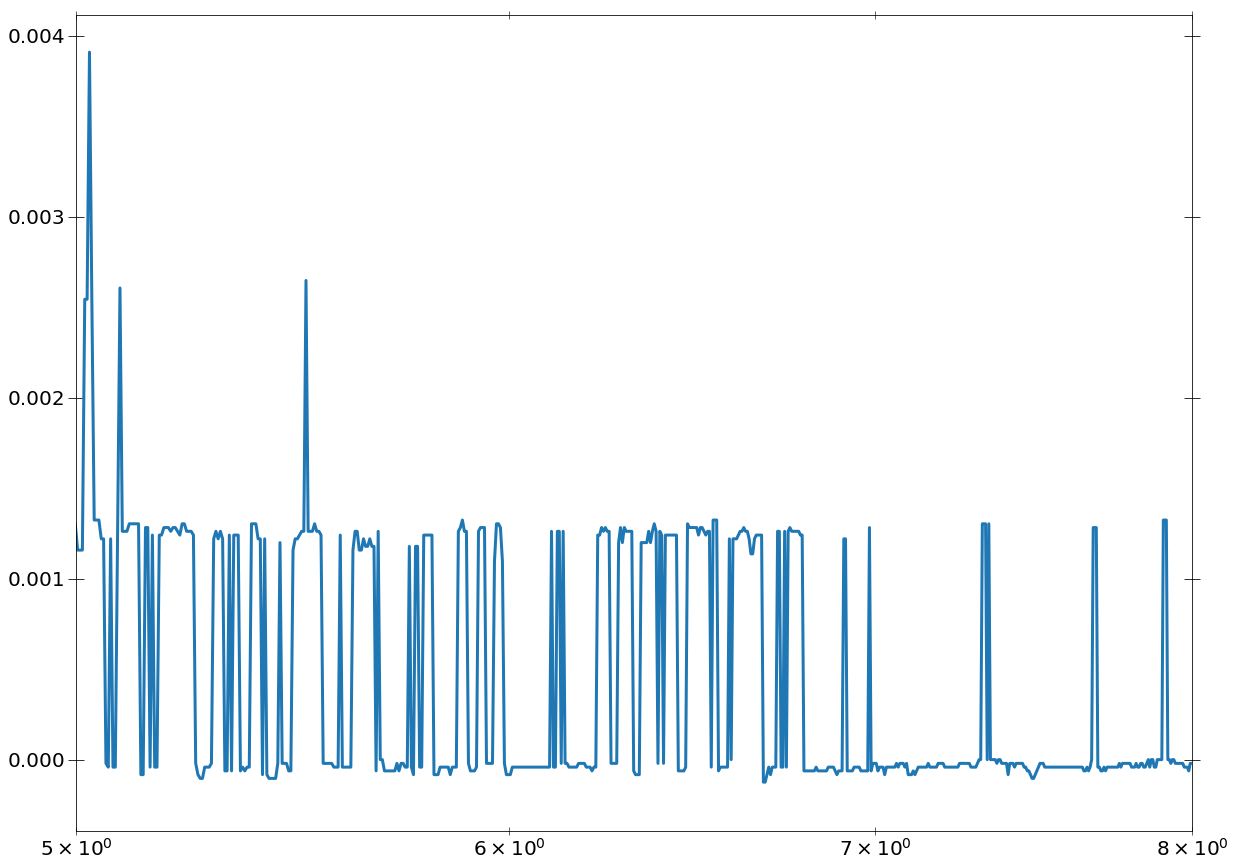

2:80: E501 line too long (130 > 79 characters)


In [62]:
plt.plot(spec_summary['ebins'][1][1][400:2000],
         median_filter(spec_summary['norm_specs'][1][1][spec_summary['spec_masks'][1][1]][interested_args_alldet[1][11]], size=5))
plt.xlim(5.0, 8.0)
plt.xscale('log')

In [67]:
spec_summary['src_nums'][0][spec_summary['spec_masks'][1][1]][interested_args_alldet[1][11]]

'200305402010002'

In [82]:
from astropy.table import Table
from astropy.table.pprint import conf
conf.max_lines = -1
conf.max_width = -1

In [83]:
Table(np.column_stack([np.array(pn_fit_stats_table_pl)[:, 0],
                       np.array(pn_fit_stats_table_pl_g2)[:, 4],
                       np.array(pn_fit_stats_table_pl)[:, 1],
                       np.array(pn_fit_stats_table_pl_g)[:, 1],
                       np.array(pn_fit_stats_table_pl_g2)[:, 1],
                       np.array(pn_model_params_table_pl_g)[:, 4],
                       np.array(pn_model_params_table_pl_g)[:, 7],
                       np.array(pn_model_params_table_pl_g2)[:, 4],
                       np.array(pn_model_params_table_pl_g2)[:, 5],
                       np.array(pn_model_params_table_pl_g2)[:, 6]]))

<Table length=58>
      col0       col1        col2               col3               col4               col5                 col6                   col7                   col8                   col9         
     str32      str32       str32              str32              str32              str32                str32                  str32                  str32                  str32         
--------------- ----- ------------------ ------------------ ------------------ ------------------ ---------------------- ---------------------- ---------------------- ----------------------
201113501010066  1097  888.3133866673959  881.7070650294453  881.1913228858143  6.495842098254313  5.728099295853509e-07  4.331544399555877e-07 1.9773822826801004e-07 1.5584199303060894e-07
201113501010154  1149  903.3608054015875  898.9897342154572  894.8121029186211  6.416690600469637  3.657184129034429e-07 3.5010040157522126e-07  4.580896096106657e-20 3.0838833914018393e-07
201129701010015   880  729.9447013450703  726.1680242153152   728.208293235638  6.878504435779244 2.8030459351071563e-07  6.557294646155204e-09  3.952180009005394e-08   1.84901608991034e-07
201129704010011  1194 1012.6079029890961 1002.1164436811466 1000.9736609156014  6.376259261068899  1.038662399360663e-06  7.930982457150612e-07  1.384644000570789e-07  4.940973238026691e-07
201129704010019  1215 1029.8154873905944 1025.8642811120633 1025.0969960585987  6.445404018100875  4.927351161304949e-07 3.2552759609400053e-07 1.0890863712728476e-07 3.7679459927014663e-07
201129704010027  1010  785.9195607248512  779.6130717470733  772.8673731092612  6.914603394912961  9.147377125465467e-07  7.142996249303996e-07 2.7521655807736366e-07  8.885324041183697e-07
201129707010012   682   567.787069467711  553.9318661357931  560.4612703153173  6.280521164961761  1.108564397466515e-06  6.793189563458339e-07 2.4888436958518062e-11  7.328702613575944e-08
201129707010063  2029  1603.580620175288 1603.4019947460515 1603.5633270184708  6.818844746386391 1.7222155963966992e-07 1.3274084432954834e-13 4.1359511318018613e-08 2.1443448180484209e-13
201129709010024   900  811.3262222227015  794.8089768017549  781.4206009405018 6.5481877496665355  9.642184610454263e-07  6.496074113129098e-07   6.07007290264001e-07 4.4822010250036727e-07
201129715010041  1034  874.5940461384438  863.4061820593956  856.2815123478654  6.789130174138019  5.935354490473833e-07  4.044163041726859e-07 3.4045138379642045e-07  2.829822266799647e-07
201129721010070  1536 1368.7909668927011 1363.6786628556076 1359.2717472122838  6.698765985480515  3.636688327975731e-07  2.536432877641739e-07 2.7199356036791055e-07  6.380835318524561e-08
201129721010126  2247 2056.1101220958135  2053.200585681294  2056.155328694617  6.100000000039239 1.9827337971923438e-07  1.123985724773552e-19 2.2605979657196566e-08 1.0167671193164822e-21
204003401010007  1384 1141.6552412391381 1141.5054008909347 1141.6854008904472  7.299999998226762  7.519391980881133e-08 6.2415342406533365e-15 2.1783277157329295e-15 2.4556035404823284e-16
204105804010005  1831  1497.955651820031 1491.1449179670433 1494.0475189246063  6.335984950645728  9.956675298151302e-07  5.889168575620609e-07  4.101678286897325e-14  1.508131704458345e-07
206556701010012  1498 1186.5589869334085 1158.4382948149878   1156.93355462016  6.664569714183259  9.879737143004975e-07  1.258050961555429e-07  8.132278353689629e-07  3.694738627039989e-12
208016803010001  1130   991.648224955775  986.3285668155654  986.6302556755354   6.47529835813703  1.348419485181247e-06 1.0077564820562453e-06 3.5762682889789996e-07  6.663621104605321e-15
208016813010003   760  609.6442782716246   607.318719084682  608.3194279092002  6.922400232207302  3.887961194557842e-07  3.958987589518239e-08  5.459081399403479e-22 3.2083101899889503e-07
208251401010006  1153  885.2047801624528  868.0245187034831  865.2031044494875  6.796034861844605 1.0310878445694557e-06 2.0726588575814643e-07  6.388394028854008e-07   6.25504734638

In [75]:
np.array(pn_fit_stats_table_pl)

array([['201113501010066', '888.3133866673959', '-8.204968056946765',
        '50.0', '1100'],
       ['201113501010154', '903.3608054015875', '-7.9889327474572935',
        '50.0', '1152'],
       ['201129701010015', '729.9447013450703', '-6.853237332107479',
        '50.0', '883'],
       ['201129704010011', '1012.6079029890961', '-4.516491937423837',
        '50.0', '1197'],
       ['201129704010019', '1029.8154873905944', '-8.696263026204749',
        '50.0', '1218'],
       ['201129704010027', '785.9195607248512', '-7.299622810407817',
        '50.0', '1013'],
       ['201129707010012', '567.787069467711', '-7.714088239148532',
        '50.0', '685'],
       ['201129707010063', '1603.580620175288', '-5.885724150152902',
        '50.0', '2032'],
       ['201129709010024', '811.3262222227015', '-6.198280503456527',
        '50.0', '903'],
       ['201129715010041', '874.5940461384438', '-8.348768445708139',
        '50.0', '1037'],
       ['201129721010070', '1368.7909668927011', '-